In [1]:
import warnings ; warnings.filterwarnings('ignore')

In [2]:
import ray
import os
import numpy as np
from ray.tune.registry import register_env
from rldm.utils import football_tools as ft
from rldm.utils import system_tools as st
from ray import tune
from ray.rllib.policy.policy import PolicySpec
from ray.rllib.utils import merge_dicts
from ray.rllib.agents.sac import DEFAULT_CONFIG

In [3]:
n_cpus, n_gpus = st.get_cpu_gpu_count()

# Ray Initialization

In [4]:
ray.init(num_cpus=n_cpus, num_gpus=n_gpus)

{'node_ip_address': '172.17.0.2',
 'raylet_ip_address': '172.17.0.2',
 'redis_address': '172.17.0.2:38784',
 'object_store_address': '/tmp/ray/session_2022-07-22_15-30-02_040642_201/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2022-07-22_15-30-02_040642_201/sockets/raylet',
 'webui_url': None,
 'session_dir': '/tmp/ray/session_2022-07-22_15-30-02_040642_201',
 'metrics_export_port': 45226,
 'node_id': 'de25d0f86db610d1ab98ecdc1f4c83bb16f011b91b7335bd062b3032'}

# Environment

In [5]:
env_name = ft.n_players_to_env_name(n_players=3, auto_GK=True)
env_name

'3_vs_3_auto_GK'

In [6]:
register_env(env_name, lambda _: ft.RllibGFootball(env_name=env_name))

In [7]:
obs_space, act_space = ft.get_obs_act_space(env_name)

In [8]:
def gen_policy(idx):
    # ref> https://docs.ray.io/en/latest/rllib/rllib-training.html#common-parameters
    # (policy_cls, obs_space, act_space, config)
    return PolicySpec(policy_class=None,
                      observation_space=obs_space[f'player_{idx}'],
                      action_space=act_space[f'player_{idx}'],
                      config={
                          "agent_id": idx,
                          "use_local_critic": True,
                          "obs_space_dict":obs_space,
                          "act_space_dict":act_space
                      })

In [9]:
# separate policy per player.
n_policies = len(obs_space)  # number of players
policies = {
        'agent_{}'.format(idx): gen_policy(idx) for idx in range(n_policies)
    }
policy_ids = list(policies.keys())
policy_mapping_fn = lambda agent_id, episode, **kwargs: \
        policy_ids[0 if len(policy_ids) == 1 else int(agent_id.split('_')[1])]


# for shared policy
# shared_policy = {'agent_0': gen_policy(0)}
# shared_policy_mapping_fn = lambda agent_id, episode, **kwargs: 'agent_0'
# shared_multiagent = {
#     'policies': shared_policy,
#     'policy_mapping_fn': shared_policy_mapping_fn,
# }

In [10]:
common_config = merge_dicts(DEFAULT_CONFIG,{
    'env': env_name,
    "evaluation_interval": 50,
    "evaluation_num_episodes": 10,
    'num_workers': 1,  # one goes to the trainer
    'num_gpus': n_gpus,
    'horizon': 500,  # maximum episode length
    "log_level": "ERROR",
    'multiagent': {
        # from policy ids to tuples
        # of (policy_cls, obs_space, act_space, config)
        'policies': policies,
        # Determines those policies that should be updated.
        'policy_mapping_fn': policy_mapping_fn
    },
    'optimization':{
        "critic_learning_rate": 1e-7
    }
})

In [11]:
algorithm = "SAC"
config = merge_dicts(
    common_config,
    {
        "framework": "tf",
        "train_batch_size": 1024,
    }
)

stop = {
    "timesteps_total": 100_000
}
n_trials = 1

In [12]:
a = tune.run(algorithm,
             name="SAC-tf",
             stop=stop,
             num_samples=n_trials,
#              checkpoint_freq=50,
             checkpoint_at_end=True,
             local_dir="../../logs",
             config=config,
             )

(pid=321) 2022-07-22 15:30:52,619	INFO trainer.py:714 -- Tip: set framework=tfe or the --eager flag to enable TensorFlow eager execution
(pid=321) 2022-07-22 15:30:52,619	INFO trainer.py:728 -- Current log_level is ERROR. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
(pid=321) 2022-07-22 15:31:07,703	INFO trainable.py:109 -- Trainable.setup took 15.094 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 3000
  custom_metrics: {}
  date: 2022-07-22_15-31-17
  done: false
  episode_len_mean: 295.6
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.8
  episode_reward_min: -2.0
  episodes_this_iter: 5
  episodes_total: 5
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 1500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -2.944288492202759
          alpha_loss: 0.0
          alpha_value: 1.0
          critic_loss: 2.409822463989258
          max_q: 0.005329351406544447
          mean_q: -0.00014735966396983713
          mean_td_error: 2.9093377590179443
          min_q: -0.008118603378534317
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[2.91609   2.9167402 2.9138012 ... 2.9152374 2.9134545 2.9143949]'
        train: null
      agent_1:
        learner_stats:
          actor_loss

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 3200
  custom_metrics: {}
  date: 2022-07-22_15-31-24
  done: false
  episode_len_mean: 264.5
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.6666666666666666
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 6
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 1600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -5.301110744476318
          alpha_loss: -0.0005875368369743228
          alpha_value: 0.9900513887405396
          critic_loss: 0.23774491250514984
          max_q: 4.775203227996826
          mean_q: 2.3858442306518555
          mean_td_error: 0.6572911143302917
          min_q: 1.9273478984832764
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5138254  0.8058342  0.8385104  ... 0.54130375 0.72308314 0.5898948
          ]'
        train: null
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 3400
  custom_metrics: {}
  date: 2022-07-22_15-31-32
  done: false
  episode_len_mean: 264.5
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.6666666666666666
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 6
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 1700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -6.386476039886475
          alpha_loss: -0.0011670786188915372
          alpha_value: 0.9802494049072266
          critic_loss: 0.04122670739889145
          max_q: 5.49934720993042
          mean_q: 3.4998276233673096
          mean_td_error: 0.14989948272705078
          min_q: 3.0189995765686035
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01431882 0.13756847 0.03566098 ... 0.04117358 0.0316596  0.03561068]'
        train: null
      agent_

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 3600
  custom_metrics: {}
  date: 2022-07-22_15-31-39
  done: false
  episode_len_mean: 264.5
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.6666666666666666
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 6
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 1800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -7.228359222412109
          alpha_loss: -0.0017603664891794324
          alpha_value: 0.9704907536506653
          critic_loss: 0.03290778398513794
          max_q: 5.717925071716309
          mean_q: 4.370697021484375
          mean_td_error: 0.11264796555042267
          min_q: 3.8519904613494873
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1293633  0.08576012 0.05105162 ... 0.08882475 0.07660842 0.0560174
          ]'
        train: null
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 3800
  custom_metrics: {}
  date: 2022-07-22_15-31-47
  done: false
  episode_len_mean: 262.7142857142857
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.8571428571428571
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 7
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 1900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -8.182479858398438
          alpha_loss: -0.002349673304706812
          alpha_value: 0.9608168005943298
          critic_loss: 0.007875882089138031
          max_q: 6.667464733123779
          mean_q: 5.353322982788086
          mean_td_error: 0.06857098639011383
          min_q: 4.863166809082031
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0827415  0.09876204 0.00852108 ... 0.10816956 0.05859399 0.06452346]'
        train: null
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 4000
  custom_metrics: {}
  date: 2022-07-22_15-31-54
  done: false
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.75
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 8
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -9.187735557556152
          alpha_loss: -0.0029393713921308517
          alpha_value: 0.9512407779693604
          critic_loss: 0.04136020690202713
          max_q: 7.7520341873168945
          mean_q: 6.386791229248047
          mean_td_error: 0.09361690282821655
          min_q: 5.880362033843994
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09672594 0.02633977 0.07524776 ... 0.10697722 0.02880788 0.04837132]'
        train: null
      agent_1:
        lea

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 4200
  custom_metrics: {}
  date: 2022-07-22_15-32-01
  done: false
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.75
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 8
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -10.191466331481934
          alpha_loss: -0.0035254505928605795
          alpha_value: 0.941763162612915
          critic_loss: 0.022950053215026855
          max_q: 8.635045051574707
          mean_q: 7.418420314788818
          mean_td_error: 0.06923924386501312
          min_q: 6.814306259155273
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0271275  0.02514696 0.120368   ... 0.02901077 0.00249815 0.02760577]'
        train: null
      agent_1:
        lea

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 4400
  custom_metrics: {}
  date: 2022-07-22_15-32-09
  done: false
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.75
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 8
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -11.187751770019531
          alpha_loss: -0.004117576405405998
          alpha_value: 0.9323833584785461
          critic_loss: 0.026172339916229248
          max_q: 9.810203552246094
          mean_q: 8.442328453063965
          mean_td_error: 0.06817713379859924
          min_q: 7.382615566253662
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01198149 0.02392912 0.21917152 ... 0.0253334  0.0736866  0.03106403]'
        train: null
      agent_1:
        lea

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 4600
  custom_metrics: {}
  date: 2022-07-22_15-32-16
  done: false
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.75
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 8
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -12.204816818237305
          alpha_loss: -0.004706125240772963
          alpha_value: 0.9230971336364746
          critic_loss: 0.06518228352069855
          max_q: 10.86060619354248
          mean_q: 9.486726760864258
          mean_td_error: 0.10544376075267792
          min_q: 8.52088737487793
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02514124 0.03651905 0.04443979 ... 0.01515722 0.01932478 0.04059649]'
        train: null
      agent_1:
        learn

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 4800
  custom_metrics: {}
  date: 2022-07-22_15-32-24
  done: false
  episode_len_mean: 246.0
  episode_media: {}
  episode_reward_max: 0.0
  episode_reward_mean: -0.75
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 8
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.234987258911133
          alpha_loss: -0.0052930014207959175
          alpha_value: 0.9139042496681213
          critic_loss: 0.02059060148894787
          max_q: 11.985349655151367
          mean_q: 10.543983459472656
          mean_td_error: 0.05733458325266838
          min_q: 9.592538833618164
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03451252 0.03124094 0.1025362  ... 0.02854967 0.0597496  0.01458359]'
        train: null
      agent_1:
        l

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 5000
  custom_metrics: {}
  date: 2022-07-22_15-32-31
  done: false
  episode_len_mean: 274.22222222222223
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6555555553899871
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 9
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.314342498779297
          alpha_loss: -0.00588395306840539
          alpha_value: 0.9048047065734863
          critic_loss: 0.034486256539821625
          max_q: 12.880419731140137
          mean_q: 11.650121688842773
          mean_td_error: 0.06784668564796448
          min_q: 10.504830360412598
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1144886  0.01088238 0.05353165 ... 0.05073929 0.02034426 0.07730675]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 5200
  custom_metrics: {}
  date: 2022-07-22_15-32-39
  done: false
  episode_len_mean: 255.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 10
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.353514671325684
          alpha_loss: -0.00646942900493741
          alpha_value: 0.8957964181900024
          critic_loss: 0.025494515895843506
          max_q: 14.126021385192871
          mean_q: 12.715775489807129
          mean_td_error: 0.0619477853178978
          min_q: 11.566427230834961
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08056545 0.12736511 0.01800632 ... 0.01325607 0.0473218  0.04621601]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 5400
  custom_metrics: {}
  date: 2022-07-22_15-32-47
  done: false
  episode_len_mean: 255.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 10
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.421932220458984
          alpha_loss: -0.007055194582790136
          alpha_value: 0.8868808150291443
          critic_loss: 0.07961168140172958
          max_q: 15.41126823425293
          mean_q: 13.810479164123535
          mean_td_error: 0.11617489159107208
          min_q: 12.806539535522461
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06598711 0.09746027 0.0502634  ... 0.02435684 0.00440168 0.03247023]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 5600
  custom_metrics: {}
  date: 2022-07-22_15-32-54
  done: false
  episode_len_mean: 249.8181818181818
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7090909088199789
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 11
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.502750396728516
          alpha_loss: -0.007645472884178162
          alpha_value: 0.8780553340911865
          critic_loss: 0.028465377166867256
          max_q: 16.522174835205078
          mean_q: 14.917224884033203
          mean_td_error: 0.0643589198589325
          min_q: 13.896506309509277
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01896238 0.11495972 0.1143446  ... 0.00175047 0.01031542 0.04134846]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 5800
  custom_metrics: {}
  date: 2022-07-22_15-33-02
  done: false
  episode_len_mean: 236.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 12
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 2900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.55704116821289
          alpha_loss: -0.008227669633924961
          alpha_value: 0.8693183064460754
          critic_loss: 0.030308404937386513
          max_q: 17.570938110351562
          mean_q: 15.997276306152344
          mean_td_error: 0.06538823992013931
          min_q: 14.784992218017578
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01920605 0.02244282 0.03043938 ... 0.01917267 0.02062893 0.01610279]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 6000
  custom_metrics: {}
  date: 2022-07-22_15-33-09
  done: false
  episode_len_mean: 236.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 12
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.591943740844727
          alpha_loss: -0.008815045468509197
          alpha_value: 0.86067134141922
          critic_loss: 0.01911919005215168
          max_q: 18.598308563232422
          mean_q: 17.057640075683594
          mean_td_error: 0.05423721671104431
          min_q: 15.971375465393066
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01232433 0.02079487 0.01836967 ... 0.03283024 0.01527119 0.0155344
          ]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 6200
  custom_metrics: {}
  date: 2022-07-22_15-33-17
  done: false
  episode_len_mean: 236.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 12
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.683311462402344
          alpha_loss: -0.009378043934702873
          alpha_value: 0.8521133661270142
          critic_loss: 0.0022208322770893574
          max_q: 27.484785079956055
          mean_q: 18.174121856689453
          mean_td_error: 0.04208454489707947
          min_q: 17.043773651123047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02263546 0.01476955 0.01060963 ... 0.0664463  0.02080727 0.03009129]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 6400
  custom_metrics: {}
  date: 2022-07-22_15-33-25
  done: false
  episode_len_mean: 236.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 12
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.682783126831055
          alpha_loss: -0.009963158518075943
          alpha_value: 0.8436519503593445
          critic_loss: 0.07244111597537994
          max_q: 28.453704833984375
          mean_q: 19.198467254638672
          mean_td_error: 0.11060429364442825
          min_q: 17.725685119628906
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[2.4027824e-02 5.2463531e-02 4.8234940e-02 ... 1.8997192e-02 1.9694489e+01\n\
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 6600
  custom_metrics: {}
  date: 2022-07-22_15-33-32
  done: false
  episode_len_mean: 236.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 12
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.681608200073242
          alpha_loss: -0.010541005060076714
          alpha_value: 0.835274875164032
          critic_loss: 0.03757132589817047
          max_q: 28.86079978942871
          mean_q: 20.221954345703125
          mean_td_error: 0.0812784880399704
          min_q: 18.666933059692383
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0445137  0.0460844  0.06872749 ... 0.03288841 0.03335476 0.02753258]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 6800
  custom_metrics: {}
  date: 2022-07-22_15-33-40
  done: false
  episode_len_mean: 256.7692307692308
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5999999997707514
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 13
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.661174774169922
          alpha_loss: -0.011134517379105091
          alpha_value: 0.8269829154014587
          critic_loss: 0.15744006633758545
          max_q: 30.332624435424805
          mean_q: 21.225927352905273
          mean_td_error: 0.19783124327659607
          min_q: 19.661846160888672
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03171825 0.0252533  0.02306366 ... 0.02481937 0.00673962 0.01018906]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 7000
  custom_metrics: {}
  date: 2022-07-22_15-33-48
  done: false
  episode_len_mean: 256.7692307692308
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5999999997707514
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 13
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.632909774780273
          alpha_loss: -0.011714240536093712
          alpha_value: 0.8187733888626099
          critic_loss: 0.1462438702583313
          max_q: 31.27088737487793
          mean_q: 22.22180938720703
          mean_td_error: 0.18780654668807983
          min_q: 20.5196475982666
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02014637 0.0495491  0.0769186  ... 0.04787731 0.0863533  0.0592041
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 7200
  custom_metrics: {}
  date: 2022-07-22_15-33-55
  done: false
  episode_len_mean: 256.7692307692308
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5999999997707514
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 13
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.616615295410156
          alpha_loss: -0.012314124032855034
          alpha_value: 0.8106451630592346
          critic_loss: 0.06662717461585999
          max_q: 32.022640228271484
          mean_q: 23.22955322265625
          mean_td_error: 0.1074124276638031
          min_q: 21.388874053955078
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04508495 0.02231789 0.08183098 ... 0.01943016 0.01663685 0.02558041]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 7400
  custom_metrics: {}
  date: 2022-07-22_15-34-03
  done: false
  episode_len_mean: 262.7142857142857
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5571428569299834
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 14
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.627853393554688
          alpha_loss: -0.012861864641308784
          alpha_value: 0.8025990128517151
          critic_loss: 0.005518551915884018
          max_q: 32.897125244140625
          mean_q: 24.264379501342773
          mean_td_error: 0.042588356882333755
          min_q: 22.051054000854492
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04404926 0.0483408  0.02556133 ... 0.02750206 0.04359436 0.01851654]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 7600
  custom_metrics: {}
  date: 2022-07-22_15-34-11
  done: false
  episode_len_mean: 262.7142857142857
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5571428569299834
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 14
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.542560577392578
          alpha_loss: -0.01347375474870205
          alpha_value: 0.7946327924728394
          critic_loss: 0.0745210349559784
          max_q: 32.9938850402832
          mean_q: 25.202543258666992
          mean_td_error: 0.11896856129169464
          min_q: 22.932891845703125
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03965664 0.03463078 0.05136681 ... 0.04495907 0.00705719 0.03984261]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 7800
  custom_metrics: {}
  date: 2022-07-22_15-34-18
  done: false
  episode_len_mean: 256.46666666666664
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5199999998013178
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 15
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 3900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.47405433654785
          alpha_loss: -0.014045104384422302
          alpha_value: 0.7867440581321716
          critic_loss: 0.09856532514095306
          max_q: 32.622344970703125
          mean_q: 26.15729331970215
          mean_td_error: 0.14207473397254944
          min_q: 23.55634880065918
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02637863 0.03635693 0.0171423  ... 0.01183128 0.02843857 0.0036974
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 8000
  custom_metrics: {}
  date: 2022-07-22_15-34-26
  done: false
  episode_len_mean: 248.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6124999998137355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 16
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.4226016998291
          alpha_loss: -0.014598038978874683
          alpha_value: 0.7789298892021179
          critic_loss: 0.10097631067037582
          max_q: 35.227725982666016
          mean_q: 27.128738403320312
          mean_td_error: 0.14887939393520355
          min_q: 24.44013023376465
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01648617 0.04332829 0.02317047 ... 0.05523491 0.01542664 0.07657909]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 8200
  custom_metrics: {}
  date: 2022-07-22_15-34-34
  done: false
  episode_len_mean: 248.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6124999998137355
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 16
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.330829620361328
          alpha_loss: -0.015186328440904617
          alpha_value: 0.7711947560310364
          critic_loss: 0.05545657128095627
          max_q: 34.795936584472656
          mean_q: 28.059782028198242
          mean_td_error: 0.09906737506389618
          min_q: 25.178136825561523
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03370285 0.02011871 0.04556561 ... 0.02621269 0.07512569 0.19021702]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 8400
  custom_metrics: {}
  date: 2022-07-22_15-34-42
  done: false
  episode_len_mean: 248.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6124999998137355
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 16
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.2784423828125
          alpha_loss: -0.01575569622218609
          alpha_value: 0.7635346055030823
          critic_loss: 0.10915665328502655
          max_q: 36.90887451171875
          mean_q: 29.029939651489258
          mean_td_error: 0.15681521594524384
          min_q: 26.368743896484375
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08124256 0.00575638 0.0059166  ... 0.0361948  0.03878593 0.00599861]'
        train: nu

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 8600
  custom_metrics: {}
  date: 2022-07-22_15-34-49
  done: false
  episode_len_mean: 248.35294117647058
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6941176468835157
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 17
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.139522552490234
          alpha_loss: -0.016393616795539856
          alpha_value: 0.7559504508972168
          critic_loss: 0.16788709163665771
          max_q: 37.55974578857422
          mean_q: 29.913333892822266
          mean_td_error: 0.21595509350299835
          min_q: 27.125032424926758
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00825024 0.10367966 0.00886631 ... 0.01523399 0.01513004 0.04736519]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 8800
  custom_metrics: {}
  date: 2022-07-22_15-34-57
  done: false
  episode_len_mean: 229.73684210526315
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7263157893168298
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 19
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.019622802734375
          alpha_loss: -0.016944896429777145
          alpha_value: 0.7484400272369385
          critic_loss: 0.03299252316355705
          max_q: 36.882537841796875
          mean_q: 30.815475463867188
          mean_td_error: 0.0833597332239151
          min_q: 27.53281593322754
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04956341 0.02920723 0.02080536 ... 0.07868576 0.14207172 0.02371025]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 9000
  custom_metrics: {}
  date: 2022-07-22_15-35-05
  done: false
  episode_len_mean: 223.65
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 20
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.850467681884766
          alpha_loss: -0.017527641728520393
          alpha_value: 0.7410048246383667
          critic_loss: 0.12186172604560852
          max_q: 38.948604583740234
          mean_q: 31.668354034423828
          mean_td_error: 0.17364028096199036
          min_q: 28.26133918762207
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02815914 0.01713943 0.18505383 ... 0.03485203 0.02071953 0.0501318
          ]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 9200
  custom_metrics: {}
  date: 2022-07-22_15-35-12
  done: false
  episode_len_mean: 223.65
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.69400405883789
          alpha_loss: -0.01809597946703434
          alpha_value: 0.7336424589157104
          critic_loss: 0.1853480041027069
          max_q: 39.653038024902344
          mean_q: 32.53349685668945
          mean_td_error: 0.23802587389945984
          min_q: 29.15753936767578
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0667057  0.09636116 0.02959061 ... 0.00668907 0.19522095 0.04119682]'
        train: nu

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 9400
  custom_metrics: {}
  date: 2022-07-22_15-35-20
  done: false
  episode_len_mean: 223.65
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.496978759765625
          alpha_loss: -0.018712177872657776
          alpha_value: 0.7263510227203369
          critic_loss: 0.20085524022579193
          max_q: 39.649742126464844
          mean_q: 33.35799026489258
          mean_td_error: 0.2556506395339966
          min_q: 29.664453506469727
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06410599 0.07417488 1.0317554  ... 0.02256012 0.03019714 0.12458611]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 9600
  custom_metrics: {}
  date: 2022-07-22_15-35-28
  done: false
  episode_len_mean: 223.65
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.277687072753906
          alpha_loss: -0.01929129660129547
          alpha_value: 0.719131588935852
          critic_loss: 0.0430726557970047
          max_q: 41.15634536743164
          mean_q: 34.15990447998047
          mean_td_error: 0.10334600508213043
          min_q: 30.7908992767334
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10805702 0.07410812 0.01842499 ... 0.02986526 0.07945442 0.09981155]'
        train: null

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 9800
  custom_metrics: {}
  date: 2022-07-22_15-35-35
  done: false
  episode_len_mean: 223.65
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7899999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 20
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 4900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.054473876953125
          alpha_loss: -0.01986801065504551
          alpha_value: 0.7119810581207275
          critic_loss: 0.03804025799036026
          max_q: 41.40995407104492
          mean_q: 34.9578971862793
          mean_td_error: 0.09315997362136841
          min_q: 31.967910766601562
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12698936 0.02566528 0.03055382 ... 0.02781677 0.03286743 0.03076935]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 10000
  custom_metrics: {}
  date: 2022-07-22_15-35-43
  done: false
  episode_len_mean: 236.8095238095238
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7523809522390366
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 21
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.881744384765625
          alpha_loss: -0.02045178785920143
          alpha_value: 0.7049015760421753
          critic_loss: 0.20783376693725586
          max_q: 42.44831466674805
          mean_q: 35.80586242675781
          mean_td_error: 0.26296350359916687
          min_q: 31.692720413208008
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03407097 0.05880356 0.01465988 ... 0.05625343 0.09165382 0.04630852]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 10200
  custom_metrics: {}
  date: 2022-07-22_15-35-51
  done: false
  episode_len_mean: 236.8095238095238
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7523809522390366
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 21
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.63134002685547
          alpha_loss: -0.02103974111378193
          alpha_value: 0.6978933811187744
          critic_loss: 0.1793816238641739
          max_q: 40.970279693603516
          mean_q: 36.57619857788086
          mean_td_error: 0.23296301066875458
          min_q: 32.70603942871094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05296707 0.06687927 0.03577995 ... 0.08277512 0.03113365 0.01176453]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 10400
  custom_metrics: {}
  date: 2022-07-22_15-35-59
  done: false
  episode_len_mean: 232.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7181818180463531
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 22
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.40187072753906
          alpha_loss: -0.02159961871802807
          alpha_value: 0.6909547448158264
          critic_loss: 0.07203954458236694
          max_q: 43.75045394897461
          mean_q: 37.367164611816406
          mean_td_error: 0.12540748715400696
          min_q: 33.4188117980957
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04402351 0.03543091 0.07845688 ... 0.00854492 0.02923965 0.07551003]'
        train: nu

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 10600
  custom_metrics: {}
  date: 2022-07-22_15-36-07
  done: false
  episode_len_mean: 232.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7181818180463531
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 22
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.088783264160156
          alpha_loss: -0.022199483588337898
          alpha_value: 0.684084951877594
          critic_loss: 0.07461441308259964
          max_q: 44.408145904541016
          mean_q: 38.074424743652344
          mean_td_error: 0.1359630823135376
          min_q: 33.22520446777344
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18559456 0.05116272 0.00945663 ... 0.01912117 0.04365921 0.01282692]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 10800
  custom_metrics: {}
  date: 2022-07-22_15-36-14
  done: false
  episode_len_mean: 231.95652173913044
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6869565216095551
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 23
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.880252838134766
          alpha_loss: -0.022751234471797943
          alpha_value: 0.6772837042808533
          critic_loss: 0.10893365740776062
          max_q: 44.61549377441406
          mean_q: 38.885658264160156
          mean_td_error: 0.16522690653800964
          min_q: 34.21236801147461
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[5.0975800e-02 3.5557850e+01 6.3068390e-02 ... 1.4673233e-02 1.7904282e-01

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 11000
  custom_metrics: {}
  date: 2022-07-22_15-36-22
  done: false
  episode_len_mean: 231.95652173913044
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6869565216095551
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 23
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.60445785522461
          alpha_loss: -0.023417608812451363
          alpha_value: 0.6705498099327087
          critic_loss: 0.05415521189570427
          max_q: 45.457603454589844
          mean_q: 39.6298828125
          mean_td_error: 0.11365068703889847
          min_q: 34.94912338256836
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07703209 0.08379745 0.01744461 ... 0.02524757 0.09519577 0.09228325]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 11200
  custom_metrics: {}
  date: 2022-07-22_15-36-30
  done: false
  episode_len_mean: 231.95652173913044
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6869565216095551
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 23
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.2488899230957
          alpha_loss: -0.02394632250070572
          alpha_value: 0.6638814806938171
          critic_loss: 0.0810798704624176
          max_q: 46.028648376464844
          mean_q: 40.29379653930664
          mean_td_error: 0.13928738236427307
          min_q: 35.26156997680664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03082085 0.01657295 0.05554581 ... 0.11946869 0.02797699 0.015728  ]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 11400
  custom_metrics: {}
  date: 2022-07-22_15-36-38
  done: false
  episode_len_mean: 231.95652173913044
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6869565216095551
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 23
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.942630767822266
          alpha_loss: -0.024554330855607986
          alpha_value: 0.6572801470756531
          critic_loss: 0.15717823803424835
          max_q: 45.82680892944336
          mean_q: 41.007015228271484
          mean_td_error: 0.21917350590229034
          min_q: 35.80793762207031
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1712532  0.05956268 0.07578659 ... 0.04241753 0.01560593 0.27584457]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 11600
  custom_metrics: {}
  date: 2022-07-22_15-36-46
  done: false
  episode_len_mean: 231.95652173913044
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6869565216095551
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 23
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -43.629844665527344
          alpha_loss: -0.025073081254959106
          alpha_value: 0.6507452726364136
          critic_loss: 0.194268137216568
          max_q: 47.01127243041992
          mean_q: 41.71328353881836
          mean_td_error: 0.2554056942462921
          min_q: 36.47528839111328
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01604652 0.01886368 0.0119381  ... 0.05861282 0.04674339 0.12960815]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 11800
  custom_metrics: {}
  date: 2022-07-22_15-36-54
  done: false
  episode_len_mean: 243.125
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.658333333209157
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 24
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 5900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.30753707885742
          alpha_loss: -0.02567945048213005
          alpha_value: 0.6442753672599792
          critic_loss: 0.1554335057735443
          max_q: 47.517173767089844
          mean_q: 42.41027069091797
          mean_td_error: 0.2184557020664215
          min_q: 37.03151321411133
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05020142 0.05456352 0.02544022 ... 0.09839249 0.08313942 0.01405334]'
        train: nu

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 12000
  custom_metrics: {}
  date: 2022-07-22_15-37-01
  done: false
  episode_len_mean: 243.125
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.658333333209157
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 24
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.97875213623047
          alpha_loss: -0.026265664026141167
          alpha_value: 0.6378685832023621
          critic_loss: 0.12372010201215744
          max_q: 48.276573181152344
          mean_q: 43.10028076171875
          mean_td_error: 0.1847870796918869
          min_q: 37.5828971862793
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01935005 0.07908058 0.03106117 ... 0.02243233 0.02784729 0.07511902]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 12200
  custom_metrics: {}
  date: 2022-07-22_15-37-09
  done: false
  episode_len_mean: 240.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7119999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 25
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -45.54452133178711
          alpha_loss: -0.026885686442255974
          alpha_value: 0.631525993347168
          critic_loss: 0.20887011289596558
          max_q: 47.816932678222656
          mean_q: 43.68479537963867
          mean_td_error: 0.27758511900901794
          min_q: 38.021461486816406
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04814339 0.08151817 0.2552185  ... 0.03526878 0.05053139 0.06236458]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 12400
  custom_metrics: {}
  date: 2022-07-22_15-37-17
  done: false
  episode_len_mean: 235.42307692307693
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6846153845007603
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 26
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.2492561340332
          alpha_loss: -0.027403194457292557
          alpha_value: 0.6252444982528687
          critic_loss: 0.25550901889801025
          max_q: 49.139949798583984
          mean_q: 44.407928466796875
          mean_td_error: 0.3224218785762787
          min_q: 38.13407897949219
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11616325 0.05232239 0.22915268 ... 0.01846504 0.02856827 0.0807991
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 12600
  custom_metrics: {}
  date: 2022-07-22_15-37-25
  done: false
  episode_len_mean: 235.42307692307693
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6846153845007603
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 26
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.83473587036133
          alpha_loss: -0.02803388424217701
          alpha_value: 0.619027316570282
          critic_loss: 0.13196434080600739
          max_q: 49.12234878540039
          mean_q: 45.01169204711914
          mean_td_error: 0.1968003660440445
          min_q: 39.01184844970703
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19328499 0.07199478 0.03237152 ... 0.07065392 0.04886627 0.06655121]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 12800
  custom_metrics: {}
  date: 2022-07-22_15-37-43
  done: false
  episode_len_mean: 235.42307692307693
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6846153845007603
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 26
  evaluation:
    custom_metrics: {}
    episode_len_mean: 207.2
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.3899999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 346
      - 326
      - 132
      - 118
      - 152
      - 92
      - 169
      - 459
      - 168
      - 110
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 13000
  custom_metrics: {}
  date: 2022-07-22_15-37-51
  done: false
  episode_len_mean: 239.03703703703704
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7296296294640612
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 27
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.04340362548828
          alpha_loss: -0.029211897403001785
          alpha_value: 0.6067760586738586
          critic_loss: 0.22247745096683502
          max_q: 50.592437744140625
          mean_q: 46.256622314453125
          mean_td_error: 0.2924293875694275
          min_q: 40.039920806884766
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03650284 0.04081726 0.11092949 ... 0.12723541 0.14043427 0.12222099]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 13200
  custom_metrics: {}
  date: 2022-07-22_15-37-59
  done: false
  episode_len_mean: 234.46428571428572
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7749999998403447
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 28
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.56471633911133
          alpha_loss: -0.02972707897424698
          alpha_value: 0.6007407307624817
          critic_loss: 0.351637601852417
          max_q: 48.637107849121094
          mean_q: 46.79561233520508
          mean_td_error: 0.42137670516967773
          min_q: 40.42393493652344
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06444359 0.09299088 0.26576424 ... 0.10348511 0.10816002 0.2189846
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 13400
  custom_metrics: {}
  date: 2022-07-22_15-38-07
  done: false
  episode_len_mean: 234.46428571428572
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7749999998403447
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -49.152618408203125
          alpha_loss: -0.030344754457473755
          alpha_value: 0.5947678089141846
          critic_loss: 0.1438453495502472
          max_q: 51.29518127441406
          mean_q: 47.40101623535156
          mean_td_error: 0.21326959133148193
          min_q: 41.22427749633789
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03501129 0.0952282  0.05483627 ... 0.06945229 0.11140633 0.01578522]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 13600
  custom_metrics: {}
  date: 2022-07-22_15-38-15
  done: false
  episode_len_mean: 234.46428571428572
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7749999998403447
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -49.73591995239258
          alpha_loss: -0.030937559902668
          alpha_value: 0.5888538360595703
          critic_loss: 0.17997577786445618
          max_q: 49.80133056640625
          mean_q: 48.00175857543945
          mean_td_error: 0.2532303035259247
          min_q: 40.672367095947266
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0358448  0.22776413 0.04798698 ... 0.04605103 0.01679993 0.09210968]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 13800
  custom_metrics: {}
  date: 2022-07-22_15-38-23
  done: false
  episode_len_mean: 234.46428571428572
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7749999998403447
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 6900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -50.274436950683594
          alpha_loss: -0.0315360501408577
          alpha_value: 0.5829994678497314
          critic_loss: 0.23240329325199127
          max_q: 51.715789794921875
          mean_q: 48.55757141113281
          mean_td_error: 0.3033083379268646
          min_q: 41.12859344482422
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07147408 0.14549255 0.07069778 ... 0.1216259  0.02640533 0.13244629]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 14000
  custom_metrics: {}
  date: 2022-07-22_15-38-31
  done: false
  episode_len_mean: 234.46428571428572
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7749999998403447
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 28
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -50.916473388671875
          alpha_loss: -0.032086633145809174
          alpha_value: 0.5772015452384949
          critic_loss: 0.06073382869362831
          max_q: 51.34361267089844
          mean_q: 49.21664810180664
          mean_td_error: 0.13411357998847961
          min_q: 43.1095085144043
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08318901 0.06634331 0.23357582 ... 0.1231842  0.1367302  0.23781204]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 14200
  custom_metrics: {}
  date: 2022-07-22_15-38-39
  done: false
  episode_len_mean: 243.6206896551724
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7482758619148155
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 29
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -51.32416534423828
          alpha_loss: -0.032678570598363876
          alpha_value: 0.5714616179466248
          critic_loss: 0.0619317963719368
          max_q: 52.74132537841797
          mean_q: 49.64130783081055
          mean_td_error: 0.13551150262355804
          min_q: 43.410884857177734
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09628296 0.13097954 0.12714195 ... 0.06038475 0.02464867 0.09633446]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 14400
  custom_metrics: {}
  date: 2022-07-22_15-38-47
  done: false
  episode_len_mean: 238.76666666666668
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7233333331843217
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 30
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -51.94861602783203
          alpha_loss: -0.033281389623880386
          alpha_value: 0.5657792091369629
          critic_loss: 0.14414572715759277
          max_q: 52.33014678955078
          mean_q: 50.28239822387695
          mean_td_error: 0.22303307056427002
          min_q: 43.120914459228516
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1050396  0.10966301 0.04989052 ... 0.08063316 0.01929665 0.03505135]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 14600
  custom_metrics: {}
  date: 2022-07-22_15-38-55
  done: false
  episode_len_mean: 238.76666666666668
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7233333331843217
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 30
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.450321197509766
          alpha_loss: -0.03386809304356575
          alpha_value: 0.5601519346237183
          critic_loss: 0.23952420055866241
          max_q: 52.50912857055664
          mean_q: 50.800743103027344
          mean_td_error: 0.31197690963745117
          min_q: 44.21413040161133
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11422157 0.12594795 0.09307671 ... 0.06769943 0.04652977 0.10108757]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 14800
  custom_metrics: {}
  date: 2022-07-22_15-39-02
  done: false
  episode_len_mean: 235.90322580645162
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7612903223883721
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 31
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.95673751831055
          alpha_loss: -0.03444763273000717
          alpha_value: 0.5545822978019714
          critic_loss: 0.06158418580889702
          max_q: 53.42155838012695
          mean_q: 51.323570251464844
          mean_td_error: 0.13543030619621277
          min_q: 43.6995849609375
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10368919 0.05175781 0.1349945  ... 0.10177422 0.03763008 0.24227715]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 15000
  custom_metrics: {}
  date: 2022-07-22_15-39-10
  done: false
  episode_len_mean: 231.6875
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.7374999998137355
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 32
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.446250915527344
          alpha_loss: -0.035007376223802567
          alpha_value: 0.5490683317184448
          critic_loss: 0.24932977557182312
          max_q: 53.956390380859375
          mean_q: 51.829288482666016
          mean_td_error: 0.3249647319316864
          min_q: 43.38928985595703
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06401062 0.00327682 0.03580856 ... 0.01216125 0.04651833 0.06008339]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 15200
  custom_metrics: {}
  date: 2022-07-22_15-39-18
  done: false
  episode_len_mean: 230.03030303030303
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.712121211895437
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 33
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.9390983581543
          alpha_loss: -0.03559024631977081
          alpha_value: 0.5436104536056519
          critic_loss: 0.15418843924999237
          max_q: 54.431026458740234
          mean_q: 52.33806228637695
          mean_td_error: 0.23115681111812592
          min_q: 44.49929428100586
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2424736  0.04101181 0.02440834 ... 0.05641365 0.18959045 0.11327934]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 15400
  custom_metrics: {}
  date: 2022-07-22_15-39-26
  done: false
  episode_len_mean: 226.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6911764703691006
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 34
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -54.31170654296875
          alpha_loss: -0.036155179142951965
          alpha_value: 0.5382062792778015
          critic_loss: 0.2509208023548126
          max_q: 54.865203857421875
          mean_q: 52.7265510559082
          mean_td_error: 0.3291625678539276
          min_q: 43.94682693481445
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1820221  0.15556908 0.03584671 ... 0.15589142 0.03312874 0.01612282]'
        train: nul

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 15600
  custom_metrics: {}
  date: 2022-07-22_15-39-34
  done: false
  episode_len_mean: 226.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6911764703691006
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 34
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -54.81744384765625
          alpha_loss: -0.036736227571964264
          alpha_value: 0.5328596234321594
          critic_loss: 0.16150608658790588
          max_q: 55.35710906982422
          mean_q: 53.24819564819336
          mean_td_error: 0.2416994571685791
          min_q: 44.325462341308594
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04163361 0.03229523 0.08931732 ... 0.20687103 0.12509346 0.01816368]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 15800
  custom_metrics: {}
  date: 2022-07-22_15-39-42
  done: false
  episode_len_mean: 226.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6911764703691006
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 34
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 7900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -55.25780487060547
          alpha_loss: -0.03732972592115402
          alpha_value: 0.5275651812553406
          critic_loss: 0.15734517574310303
          max_q: 55.599609375
          mean_q: 53.7042350769043
          mean_td_error: 0.23600399494171143
          min_q: 45.414363861083984
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01919937 0.03577042 0.01155472 ... 0.07348633 0.0137558  0.00580978]'
        train: null
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 16000
  custom_metrics: {}
  date: 2022-07-22_15-39-51
  done: false
  episode_len_mean: 227.65714285714284
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.66857142831598
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 35
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -55.73126220703125
          alpha_loss: -0.03784703463315964
          alpha_value: 0.5223248600959778
          critic_loss: 0.2655631899833679
          max_q: 56.31747817993164
          mean_q: 54.19289016723633
          mean_td_error: 0.34461742639541626
          min_q: 44.75882339477539
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24499702 0.06785965 0.1051693  ... 0.00848579 0.04063606 0.17482185]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 16200
  custom_metrics: {}
  date: 2022-07-22_15-39-59
  done: false
  episode_len_mean: 227.65714285714284
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.66857142831598
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.16324234008789
          alpha_loss: -0.03840431571006775
          alpha_value: 0.5171398520469666
          critic_loss: 0.36442941427230835
          max_q: 56.55215835571289
          mean_q: 54.6402587890625
          mean_td_error: 0.4493459463119507
          min_q: 46.29474639892578
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13254738 0.22955132 0.03152657 ... 0.08630371 0.05921364 0.01698303]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 16400
  custom_metrics: {}
  date: 2022-07-22_15-40-07
  done: false
  episode_len_mean: 227.65714285714284
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.66857142831598
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.424922943115234
          alpha_loss: -0.03900797665119171
          alpha_value: 0.5120058655738831
          critic_loss: 0.31646278500556946
          max_q: 56.98471450805664
          mean_q: 54.91713333129883
          mean_td_error: 0.4022700786590576
          min_q: 45.58050537109375
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05117416 0.16815758 0.13680458 ... 0.01984787 0.18486404 0.055439  ]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 16600
  custom_metrics: {}
  date: 2022-07-22_15-40-15
  done: false
  episode_len_mean: 227.65714285714284
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.66857142831598
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.8868293762207
          alpha_loss: -0.03955686092376709
          alpha_value: 0.5069228410720825
          critic_loss: 0.26486700773239136
          max_q: 57.67221450805664
          mean_q: 55.393798828125
          mean_td_error: 0.34164902567863464
          min_q: 45.6329460144043
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06202507 0.08493805 0.05526543 ... 0.13801956 0.06357193 0.07189941]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 16800
  custom_metrics: {}
  date: 2022-07-22_15-40-23
  done: false
  episode_len_mean: 227.65714285714284
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.66857142831598
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 35
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -57.32624816894531
          alpha_loss: -0.04011780768632889
          alpha_value: 0.5018904209136963
          critic_loss: 0.27556395530700684
          max_q: 57.60934829711914
          mean_q: 55.84811782836914
          mean_td_error: 0.36348024010658264
          min_q: 48.39192581176758
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11166382 0.01520729 0.04204941 ... 0.114048   0.08725357 0.12263298]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 17000
  custom_metrics: {}
  date: 2022-07-22_15-40-31
  done: false
  episode_len_mean: 235.22222222222223
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 36
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -57.73404312133789
          alpha_loss: -0.040737420320510864
          alpha_value: 0.49690914154052734
          critic_loss: 0.16711804270744324
          max_q: 58.015506744384766
          mean_q: 56.27065658569336
          mean_td_error: 0.249780535697937
          min_q: 46.08048629760742
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08394241 0.07785034 0.1522255  ... 0.05907059 0.01129913 0.07691002]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 17200
  custom_metrics: {}
  date: 2022-07-22_15-40-39
  done: false
  episode_len_mean: 235.22222222222223
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.06059646606445
          alpha_loss: -0.04125533998012543
          alpha_value: 0.49197855591773987
          critic_loss: 0.33364662528038025
          max_q: 58.849212646484375
          mean_q: 56.611732482910156
          mean_td_error: 0.4213206171989441
          min_q: 47.4085807800293
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0896759  0.00953293 0.4402027  ... 0.14618301 0.08236694 0.11052895]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 17400
  custom_metrics: {}
  date: 2022-07-22_15-40-46
  done: false
  episode_len_mean: 235.22222222222223
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6499999997516474
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 36
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.459266662597656
          alpha_loss: -0.041871894150972366
          alpha_value: 0.4870981276035309
          critic_loss: 0.17287002503871918
          max_q: 58.93411636352539
          mean_q: 57.02480697631836
          mean_td_error: 0.2590551972389221
          min_q: 46.61460876464844
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03746796 0.083498   0.04017639 ... 0.1136055  0.3061657  0.03934288]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 17600
  custom_metrics: {}
  date: 2022-07-22_15-40-54
  done: false
  episode_len_mean: 236.56756756756758
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6324324321907919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 37
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.77824020385742
          alpha_loss: -0.042415715754032135
          alpha_value: 0.48226481676101685
          critic_loss: 0.17357507348060608
          max_q: 59.40968322753906
          mean_q: 57.357818603515625
          mean_td_error: 0.25305113196372986
          min_q: 47.274410247802734
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03474998 0.02127838 0.09711266 ... 0.03255463 0.06788063 0.24030113]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 17800
  custom_metrics: {}
  date: 2022-07-22_15-41-02
  done: false
  episode_len_mean: 233.1315789473684
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.615789473448929
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 38
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 8900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.15266418457031
          alpha_loss: -0.04293891414999962
          alpha_value: 0.47748053073883057
          critic_loss: 0.18910837173461914
          max_q: 59.73345184326172
          mean_q: 57.74633026123047
          mean_td_error: 0.2771468162536621
          min_q: 47.36362838745117
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07524681 0.02450943 0.08956909 ... 0.0657196  0.0556469  0.2119503
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 18000
  custom_metrics: {}
  date: 2022-07-22_15-41-10
  done: false
  episode_len_mean: 233.1315789473684
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.615789473448929
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 38
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.49323654174805
          alpha_loss: -0.043482258915901184
          alpha_value: 0.47274377942085266
          critic_loss: 0.18089023232460022
          max_q: 61.803916931152344
          mean_q: 58.10085678100586
          mean_td_error: 0.26715582609176636
          min_q: 47.59535598754883
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02793884 0.0340004  0.04449844 ... 0.03437805 0.05895805 0.04988098]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 18200
  custom_metrics: {}
  date: 2022-07-22_15-41-18
  done: false
  episode_len_mean: 233.05128205128204
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6512820510528027
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 39
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.77572250366211
          alpha_loss: -0.04398588463664055
          alpha_value: 0.46805644035339355
          critic_loss: 0.12366817891597748
          max_q: 61.965797424316406
          mean_q: 58.39714050292969
          mean_td_error: 0.21436376869678497
          min_q: 47.73994064331055
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05057907 0.13098717 0.05992889 ... 0.02080917 0.02129555 0.03626633]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 18400
  custom_metrics: {}
  date: 2022-07-22_15-41-27
  done: false
  episode_len_mean: 233.05128205128204
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6512820510528027
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 39
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.21764373779297
          alpha_loss: -0.044629525393247604
          alpha_value: 0.46341681480407715
          critic_loss: 0.07873209565877914
          max_q: 62.37226104736328
          mean_q: 58.85285949707031
          mean_td_error: 0.16500988602638245
          min_q: 48.57091522216797
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22539902 0.10477066 0.00958061 ... 0.06850052 0.09002495 0.02313805]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 18600
  custom_metrics: {}
  date: 2022-07-22_15-41-34
  done: false
  episode_len_mean: 230.075
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6349999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 40
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.571720123291016
          alpha_loss: -0.04520798474550247
          alpha_value: 0.4588206112384796
          critic_loss: 0.28352126479148865
          max_q: 62.61153030395508
          mean_q: 59.22024154663086
          mean_td_error: 0.3729676306247711
          min_q: 50.26904296875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14273262 0.0650444  0.08465385 ... 0.23269081 0.06913948 0.10852242]'
        train: nul

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 18800
  custom_metrics: {}
  date: 2022-07-22_15-41-42
  done: false
  episode_len_mean: 230.075
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6349999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.83845138549805
          alpha_loss: -0.04576469212770462
          alpha_value: 0.4542728066444397
          critic_loss: 0.23038136959075928
          max_q: 63.09481430053711
          mean_q: 59.500457763671875
          mean_td_error: 0.31535571813583374
          min_q: 48.86942672729492
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01205063 0.07744408 0.1524334  ... 0.01108551 0.539978   0.09563637]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 19000
  custom_metrics: {}
  date: 2022-07-22_15-41-51
  done: false
  episode_len_mean: 230.075
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6349999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.21017074584961
          alpha_loss: -0.04637124389410019
          alpha_value: 0.4497670829296112
          critic_loss: 0.1663673222064972
          max_q: 63.515193939208984
          mean_q: 59.885589599609375
          mean_td_error: 0.25181788206100464
          min_q: 49.0309944152832
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10375214 0.04920006 0.02179718 ... 0.08296776 0.06269836 0.02654266]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 19200
  custom_metrics: {}
  date: 2022-07-22_15-41-59
  done: false
  episode_len_mean: 230.075
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6349999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.46767807006836
          alpha_loss: -0.046873558312654495
          alpha_value: 0.4453071653842926
          critic_loss: 0.4552431106567383
          max_q: 63.788734436035156
          mean_q: 60.15595626831055
          mean_td_error: 0.5413967370986938
          min_q: 51.343475341796875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01366234 0.0576458  0.03333664 ... 0.14394379 0.03845215 0.07336235]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 19400
  custom_metrics: {}
  date: 2022-07-22_15-42-07
  done: false
  episode_len_mean: 230.075
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6349999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 40
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.72782516479492
          alpha_loss: -0.0475115031003952
          alpha_value: 0.4408910572528839
          critic_loss: 0.23692184686660767
          max_q: 63.05006408691406
          mean_q: 60.42930221557617
          mean_td_error: 0.32752490043640137
          min_q: 51.827301025390625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10762405 0.01178741 0.03861427 ... 0.10497284 0.09023285 0.20082855]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 19600
  custom_metrics: {}
  date: 2022-07-22_15-42-15
  done: false
  episode_len_mean: 236.65853658536585
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6195121949038854
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 41
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.95978927612305
          alpha_loss: -0.04795491322875023
          alpha_value: 0.4365178644657135
          critic_loss: 0.22606660425662994
          max_q: 64.2108154296875
          mean_q: 60.673866271972656
          mean_td_error: 0.3192369341850281
          min_q: 48.71341323852539
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07312584 0.07096481 0.10849953 ... 0.04340553 0.10713577 0.06535721]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 19800
  custom_metrics: {}
  date: 2022-07-22_15-42-23
  done: false
  episode_len_mean: 233.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.604761904549031
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 42
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 9900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.30653381347656
          alpha_loss: -0.04847494512796402
          alpha_value: 0.4321915805339813
          critic_loss: 0.13108104467391968
          max_q: 63.900611877441406
          mean_q: 61.033485412597656
          mean_td_error: 0.21616505086421967
          min_q: 49.01005935668945
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08325768 0.1123333  0.23148537 ... 0.03421783 0.21194458 0.2053814
          ]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 20000
  custom_metrics: {}
  date: 2022-07-22_15-42-31
  done: false
  episode_len_mean: 233.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.604761904549031
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 42
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.56218719482422
          alpha_loss: -0.049015652388334274
          alpha_value: 0.4279106855392456
          critic_loss: 0.23814725875854492
          max_q: 63.478206634521484
          mean_q: 61.30190658569336
          mean_td_error: 0.3275286555290222
          min_q: 51.50161361694336
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03557777 0.08102798 0.05653381 ... 0.09786797 0.06452942 0.3219185
          ]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 20200
  custom_metrics: {}
  date: 2022-07-22_15-42-39
  done: false
  episode_len_mean: 233.5
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.604761904549031
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 42
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.862640380859375
          alpha_loss: -0.04944335296750069
          alpha_value: 0.4236733913421631
          critic_loss: 0.40964221954345703
          max_q: 64.7529525756836
          mean_q: 61.61440658569336
          mean_td_error: 0.5108350515365601
          min_q: 49.75820541381836
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03151894 0.27036476 0.32536507 ... 0.05772972 0.08174515 0.11434555]'
        train: nul

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 20400
  custom_metrics: {}
  date: 2022-07-22_15-42-47
  done: false
  episode_len_mean: 236.2325581395349
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5906976742106814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 43
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.013790130615234
          alpha_loss: -0.04994704946875572
          alpha_value: 0.4194794297218323
          critic_loss: 0.40049564838409424
          max_q: 69.44290924072266
          mean_q: 61.7778434753418
          mean_td_error: 0.5018770694732666
          min_q: 49.565879821777344
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05587959 0.17877007 0.09677887 ... 0.1145401  0.00717163 0.11136627]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 20600
  custom_metrics: {}
  date: 2022-07-22_15-42-55
  done: false
  episode_len_mean: 233.1590909090909
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5772727270695296
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 44
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.36148452758789
          alpha_loss: -0.05069513991475105
          alpha_value: 0.41532641649246216
          critic_loss: 0.15446701645851135
          max_q: 70.68047332763672
          mean_q: 62.137939453125
          mean_td_error: 0.24740523099899292
          min_q: 51.013465881347656
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12562752 0.20597458 0.01766396 ... 0.04884338 0.05244255 0.07868958]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 20800
  custom_metrics: {}
  date: 2022-07-22_15-43-03
  done: false
  episode_len_mean: 230.13333333333333
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6088888886902067
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 45
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.548553466796875
          alpha_loss: -0.05115952342748642
          alpha_value: 0.41121652722358704
          critic_loss: 0.4473787248134613
          max_q: 70.99742126464844
          mean_q: 62.33735275268555
          mean_td_error: 0.5435420274734497
          min_q: 50.0699348449707
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12716484 0.0938549  0.08709335 ... 0.06280327 0.0257225  0.07406425]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 21000
  custom_metrics: {}
  date: 2022-07-22_15-43-11
  done: false
  episode_len_mean: 230.13333333333333
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6088888886902067
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.85575485229492
          alpha_loss: -0.05185345560312271
          alpha_value: 0.40714335441589355
          critic_loss: 0.1369359940290451
          max_q: 71.10150909423828
          mean_q: 62.65663528442383
          mean_td_error: 0.2268989384174347
          min_q: 50.7939453125
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08157158 0.10609245 0.063694   ... 0.01529694 0.04012489 0.06202126]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 21200
  custom_metrics: {}
  date: 2022-07-22_15-43-20
  done: false
  episode_len_mean: 230.13333333333333
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6088888886902067
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.00270080566406
          alpha_loss: -0.0522068552672863
          alpha_value: 0.4031132161617279
          critic_loss: 0.29998496174812317
          max_q: 70.83348083496094
          mean_q: 62.815185546875
          mean_td_error: 0.3920232653617859
          min_q: 50.758445739746094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14540482 0.17723274 0.05388832 ... 0.1728077  0.17814255 0.14438629]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 21400
  custom_metrics: {}
  date: 2022-07-22_15-43-28
  done: false
  episode_len_mean: 230.13333333333333
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6088888886902067
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.21095275878906
          alpha_loss: -0.05284252017736435
          alpha_value: 0.39912164211273193
          critic_loss: 0.44513213634490967
          max_q: 66.0924072265625
          mean_q: 63.03518295288086
          mean_td_error: 0.5437770485877991
          min_q: 50.25651931762695
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09740829 0.06313515 0.14862442 ... 0.06138039 0.10907173 0.21336937]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 21600
  custom_metrics: {}
  date: 2022-07-22_15-43-36
  done: false
  episode_len_mean: 230.13333333333333
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6088888886902067
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 45
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.36972045898438
          alpha_loss: -0.053303226828575134
          alpha_value: 0.39517197012901306
          critic_loss: 0.35349375009536743
          max_q: 68.00540924072266
          mean_q: 63.2054557800293
          mean_td_error: 0.4498348534107208
          min_q: 49.952545166015625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07759094 0.02441597 0.08832359 ... 0.25271034 0.15555954 0.1882019
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 21800
  custom_metrics: {}
  date: 2022-07-22_15-43-44
  done: false
  episode_len_mean: 236.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5956521737186805
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 46
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 10900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.56036376953125
          alpha_loss: -0.053936418145895004
          alpha_value: 0.3912621736526489
          critic_loss: 0.02774561569094658
          max_q: 71.73258209228516
          mean_q: 63.407623291015625
          mean_td_error: 0.12086394429206848
          min_q: 51.1845817565918
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02616501 0.05136108 0.13454819 ... 0.02283669 0.33229065 0.04074669]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 22000
  custom_metrics: {}
  date: 2022-07-22_15-43-52
  done: false
  episode_len_mean: 236.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5956521737186805
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 46
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.70877075195312
          alpha_loss: -0.05430036410689354
          alpha_value: 0.38739365339279175
          critic_loss: 0.1873752772808075
          max_q: 65.94755554199219
          mean_q: 63.5676383972168
          mean_td_error: 0.2844032943248749
          min_q: 50.21122741699219
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06965256 0.00676918 0.01710892 ... 0.03363037 0.05376434 0.20632362]'
        train: nul

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 22200
  custom_metrics: {}
  date: 2022-07-22_15-44-00
  done: false
  episode_len_mean: 236.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5956521737186805
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 46
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.94264221191406
          alpha_loss: -0.05483130365610123
          alpha_value: 0.38356441259384155
          critic_loss: 0.13408753275871277
          max_q: 66.83511352539062
          mean_q: 63.812564849853516
          mean_td_error: 0.23486573994159698
          min_q: 50.6234130859375
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04655075 0.10396194 0.04257202 ... 0.28437424 0.00802994 0.06886292]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 22400
  custom_metrics: {}
  date: 2022-07-22_15-44-08
  done: false
  episode_len_mean: 236.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5956521737186805
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 46
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.11399841308594
          alpha_loss: -0.05537153035402298
          alpha_value: 0.3797706365585327
          critic_loss: 0.23914411664009094
          max_q: 71.18462371826172
          mean_q: 63.994911193847656
          mean_td_error: 0.34019502997398376
          min_q: 50.64946746826172
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04125786 0.08048248 0.16285324 ... 0.0509758  0.09133339 0.02887344]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 22600
  custom_metrics: {}
  date: 2022-07-22_15-44-16
  done: false
  episode_len_mean: 236.0
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5956521737186805
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 46
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.43028259277344
          alpha_loss: -0.056111179292201996
          alpha_value: 0.37601402401924133
          critic_loss: 0.1457313895225525
          max_q: 67.20587921142578
          mean_q: 64.32244873046875
          mean_td_error: 0.24390238523483276
          min_q: 52.94801712036133
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17647171 0.14708328 0.05235672 ... 0.07796097 0.03982544 0.04571342]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 22800
  custom_metrics: {}
  date: 2022-07-22_15-44-39
  done: false
  episode_len_mean: 241.61702127659575
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5829787232140278
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 47
  evaluation:
    custom_metrics: {}
    episode_len_mean: 287.9
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.3899999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 131
      - 293
      - 92
      - 315
      - 286
      - 398
      - 214
      - 150
      - 500
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 23000
  custom_metrics: {}
  date: 2022-07-22_15-44-47
  done: false
  episode_len_mean: 238.625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5708333331470689
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 48
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.72882080078125
          alpha_loss: -0.05704718455672264
          alpha_value: 0.36861133575439453
          critic_loss: 0.19489401578903198
          max_q: 68.25980377197266
          mean_q: 64.64273071289062
          mean_td_error: 0.293499231338501
          min_q: 50.568443298339844
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0875206  0.11234665 0.35639572 ... 0.2987175  0.10049438 0.11299133]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 23200
  custom_metrics: {}
  date: 2022-07-22_15-44-55
  done: false
  episode_len_mean: 238.625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5708333331470689
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 48
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.7754898071289
          alpha_loss: -0.05758795887231827
          alpha_value: 0.364969402551651
          critic_loss: 0.4164251685142517
          max_q: 67.58984375
          mean_q: 64.70028686523438
          mean_td_error: 0.5192708969116211
          min_q: 52.26569366455078
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04058456 0.04268265 0.07502174 ... 0.09325027 0.13222122 0.08662033]'
        train: null
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 23400
  custom_metrics: {}
  date: 2022-07-22_15-45-03
  done: false
  episode_len_mean: 238.625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5708333331470689
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 48
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.02555084228516
          alpha_loss: -0.05796492099761963
          alpha_value: 0.36136358976364136
          critic_loss: 0.13032937049865723
          max_q: 69.54643249511719
          mean_q: 64.9608154296875
          mean_td_error: 0.2349160760641098
          min_q: 53.03269577026367
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01140976 0.03296661 0.07203293 ... 0.08263397 0.10047531 0.0308609
          ]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 23600
  custom_metrics: {}
  date: 2022-07-22_15-45-12
  done: false
  episode_len_mean: 238.625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5708333331470689
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 48
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.0422592163086
          alpha_loss: -0.05861825495958328
          alpha_value: 0.35779470205307007
          critic_loss: 0.30092257261276245
          max_q: 72.22428131103516
          mean_q: 64.98807525634766
          mean_td_error: 0.4023585319519043
          min_q: 50.537837982177734
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04835892 0.07686996 0.11515045 ... 0.17065811 0.01448822 0.3467636
          ]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 23800
  custom_metrics: {}
  date: 2022-07-22_15-45-20
  done: false
  episode_len_mean: 242.0204081632653
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5591836732869245
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 49
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 11900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.2939453125
          alpha_loss: -0.05905970185995102
          alpha_value: 0.3542613089084625
          critic_loss: 0.08781678229570389
          max_q: 72.5784683227539
          mean_q: 65.25028228759766
          mean_td_error: 0.19297544658184052
          min_q: 51.377601623535156
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05142593 0.01947784 0.1464119  ... 0.08485031 0.2404747  0.01082993]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 24000
  custom_metrics: {}
  date: 2022-07-22_15-45-28
  done: false
  episode_len_mean: 242.0204081632653
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5591836732869245
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 49
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.42619323730469
          alpha_loss: -0.05965626239776611
          alpha_value: 0.3507641553878784
          critic_loss: 0.25642961263656616
          max_q: 70.39958190917969
          mean_q: 65.39269256591797
          mean_td_error: 0.3572331964969635
          min_q: 51.27408218383789
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08614731 0.2106514  0.04124069 ... 0.03248978 0.14625931 0.07291412]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 24200
  custom_metrics: {}
  date: 2022-07-22_15-45-36
  done: false
  episode_len_mean: 242.0204081632653
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5591836732869245
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 49
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.66532135009766
          alpha_loss: -0.060306206345558167
          alpha_value: 0.347299188375473
          critic_loss: 0.12745830416679382
          max_q: 71.0097885131836
          mean_q: 65.64183807373047
          mean_td_error: 0.2312658429145813
          min_q: 52.61362075805664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16033745 0.12727737 0.3922081  ... 0.0448761  0.12784386 0.07474899]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 24400
  custom_metrics: {}
  date: 2022-07-22_15-45-44
  done: false
  episode_len_mean: 242.0204081632653
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5591836732869245
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 49
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.68650817871094
          alpha_loss: -0.060698237270116806
          alpha_value: 0.34387335181236267
          critic_loss: 0.2746317684650421
          max_q: 68.53644561767578
          mean_q: 65.67283630371094
          mean_td_error: 0.3808025121688843
          min_q: 53.1822624206543
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09264755 0.10997391 0.19789505 ... 0.02143097 0.12828445 0.70301247]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 24600
  custom_metrics: {}
  date: 2022-07-22_15-45-53
  done: false
  episode_len_mean: 242.0204081632653
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5591836732869245
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 49
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.83203125
          alpha_loss: -0.0611271932721138
          alpha_value: 0.3404741883277893
          critic_loss: 0.2901792526245117
          max_q: 69.91301727294922
          mean_q: 65.82878112792969
          mean_td_error: 0.3954823613166809
          min_q: 52.64142990112305
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03410721 0.05015564 0.0565033  ... 0.18286896 1.1539993  0.06307602]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 24800
  custom_metrics: {}
  date: 2022-07-22_15-46-01
  done: false
  episode_len_mean: 246.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5479999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 50
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.88226318359375
          alpha_loss: -0.0617123544216156
          alpha_value: 0.33711302280426025
          critic_loss: 0.31036436557769775
          max_q: 70.07714080810547
          mean_q: 65.88878631591797
          mean_td_error: 0.41318631172180176
          min_q: 55.43434524536133
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17490387 0.07875061 0.0071373  ... 0.01405334 0.21283722 0.27380753]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 25000
  custom_metrics: {}
  date: 2022-07-22_15-46-09
  done: false
  episode_len_mean: 245.07843137254903
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5764705880599863
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 51
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.99893188476562
          alpha_loss: -0.062257517129182816
          alpha_value: 0.3337875008583069
          critic_loss: 0.30943894386291504
          max_q: 69.29439544677734
          mean_q: 66.0154037475586
          mean_td_error: 0.4101333022117615
          min_q: 52.67414855957031
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16647339 0.05338287 0.03606415 ... 0.10128403 0.1681881  0.11526489]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 25200
  custom_metrics: {}
  date: 2022-07-22_15-46-17
  done: false
  episode_len_mean: 245.07843137254903
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5764705880599863
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 51
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.03053283691406
          alpha_loss: -0.06264334917068481
          alpha_value: 0.3304942846298218
          critic_loss: 0.19207829236984253
          max_q: 71.65211486816406
          mean_q: 66.05642700195312
          mean_td_error: 0.2955966889858246
          min_q: 51.270633697509766
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.25175095 56.95968     0.09233856 ...  0.13579178  0.15350723\n\
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 25400
  custom_metrics: {}
  date: 2022-07-22_15-46-25
  done: false
  episode_len_mean: 245.07843137254903
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5764705880599863
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 51
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.20626831054688
          alpha_loss: -0.06334787607192993
          alpha_value: 0.3272315561771393
          critic_loss: 0.13205431401729584
          max_q: 68.95606231689453
          mean_q: 66.24195098876953
          mean_td_error: 0.23012830317020416
          min_q: 51.22589111328125
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05157471 0.05225372 0.05334473 ... 0.0287056  0.2010498  0.05076599]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 25600
  custom_metrics: {}
  date: 2022-07-22_15-46-33
  done: false
  episode_len_mean: 245.07843137254903
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5764705880599863
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 51
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.17219543457031
          alpha_loss: -0.06350067257881165
          alpha_value: 0.32400068640708923
          critic_loss: 0.2018880695104599
          max_q: 70.41759490966797
          mean_q: 66.21705627441406
          mean_td_error: 0.30926379561424255
          min_q: 53.13909149169922
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07649994 0.21133804 0.04661942 ... 0.04805374 0.13504028 0.05454636]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 25800
  custom_metrics: {}
  date: 2022-07-22_15-46-42
  done: false
  episode_len_mean: 245.07843137254903
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5764705880599863
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 51
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 12900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.33798217773438
          alpha_loss: -0.06422081589698792
          alpha_value: 0.3208017945289612
          critic_loss: 0.21215128898620605
          max_q: 69.36100006103516
          mean_q: 66.3926010131836
          mean_td_error: 0.3149009346961975
          min_q: 50.67976379394531
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24988556 0.03614044 0.06869125 ... 0.19278717 0.02363205 0.0277977
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 26000
  custom_metrics: {}
  date: 2022-07-22_15-46-50
  done: false
  episode_len_mean: 249.98076923076923
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5653846152126789
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 52
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.45867156982422
          alpha_loss: -0.06442100554704666
          alpha_value: 0.3176417350769043
          critic_loss: 0.3178095817565918
          max_q: 70.28256225585938
          mean_q: 66.52256774902344
          mean_td_error: 0.42044591903686523
          min_q: 51.288902282714844
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05339432 0.14857483 0.05610275 ... 0.08988571 0.03382492 0.07727814]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 26200
  custom_metrics: {}
  date: 2022-07-22_15-46-58
  done: false
  episode_len_mean: 249.98076923076923
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5653846152126789
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 52
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.46876525878906
          alpha_loss: -0.06509676575660706
          alpha_value: 0.314508318901062
          critic_loss: 0.3989751935005188
          max_q: 69.4005355834961
          mean_q: 66.54176330566406
          mean_td_error: 0.5056172013282776
          min_q: 52.27922058105469
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02287674 0.05632782 0.15541458 ... 0.06768036 0.12604904 0.09781265]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 26400
  custom_metrics: {}
  date: 2022-07-22_15-47-06
  done: false
  episode_len_mean: 247.54716981132074
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5547169809633831
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 53
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.57459259033203
          alpha_loss: -0.06560245156288147
          alpha_value: 0.3114093244075775
          critic_loss: 0.21175304055213928
          max_q: 69.53114318847656
          mean_q: 66.6570053100586
          mean_td_error: 0.31533777713775635
          min_q: 50.75531768798828
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0465126  0.06417847 0.05522919 ... 0.07162094 0.04663086 0.04797363]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 26600
  custom_metrics: {}
  date: 2022-07-22_15-47-14
  done: false
  episode_len_mean: 244.77777777777777
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.544444444278876
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 54
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.70482635498047
          alpha_loss: -0.06581953167915344
          alpha_value: 0.30834823846817017
          critic_loss: 0.3709375858306885
          max_q: 69.80158996582031
          mean_q: 66.79588317871094
          mean_td_error: 0.47562381625175476
          min_q: 51.912445068359375
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08258057 0.10476303 0.25203705 ... 0.04816055 0.02293396 0.1054306
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 26800
  custom_metrics: {}
  date: 2022-07-22_15-47-23
  done: false
  episode_len_mean: 244.77777777777777
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.544444444278876
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.71456909179688
          alpha_loss: -0.06626556813716888
          alpha_value: 0.3053176999092102
          critic_loss: 0.32305967807769775
          max_q: 70.04863739013672
          mean_q: 66.8143310546875
          mean_td_error: 0.4320545494556427
          min_q: 50.699398040771484
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15319061 0.06612396 0.15752411 ... 0.15363693 0.08069992 0.03674316]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 27000
  custom_metrics: {}
  date: 2022-07-22_15-47-31
  done: false
  episode_len_mean: 244.77777777777777
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.544444444278876
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.82814025878906
          alpha_loss: -0.06723837554454803
          alpha_value: 0.30231332778930664
          critic_loss: 0.20918193459510803
          max_q: 71.72360229492188
          mean_q: 66.93706512451172
          mean_td_error: 0.3131687641143799
          min_q: 51.572731018066406
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06962967 0.20423126 0.07474518 ... 0.07006836 0.0513916  0.02812195]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 27200
  custom_metrics: {}
  date: 2022-07-22_15-47-39
  done: false
  episode_len_mean: 244.77777777777777
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.544444444278876
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.72535705566406
          alpha_loss: -0.06710834801197052
          alpha_value: 0.29934191703796387
          critic_loss: 0.37566936016082764
          max_q: 71.07585906982422
          mean_q: 66.84300231933594
          mean_td_error: 0.4843162000179291
          min_q: 51.34838104248047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12929916 0.16141129 0.19500351 ... 0.0645752  0.1422348  0.06197739]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 27400
  custom_metrics: {}
  date: 2022-07-22_15-47-47
  done: false
  episode_len_mean: 244.77777777777777
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.544444444278876
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 54
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.87617492675781
          alpha_loss: -0.0678543895483017
          alpha_value: 0.29640135169029236
          critic_loss: 0.20914365351200104
          max_q: 71.34750366210938
          mean_q: 67.0025405883789
          mean_td_error: 0.31203553080558777
          min_q: 51.28984832763672
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20295334 0.17054367 0.18169022 ... 0.19995499 0.03612137 0.06941605]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 27600
  custom_metrics: {}
  date: 2022-07-22_15-47-56
  done: false
  episode_len_mean: 249.4181818181818
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5345454543828965
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 55
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.00247192382812
          alpha_loss: -0.06840402632951736
          alpha_value: 0.293489545583725
          critic_loss: 0.21006232500076294
          max_q: 71.06364440917969
          mean_q: 67.1373062133789
          mean_td_error: 0.31458231806755066
          min_q: 55.14926528930664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05711365 0.18952942 0.01692581 ... 0.02443314 0.05318832 0.0605278
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 27800
  custom_metrics: {}
  date: 2022-07-22_15-48-04
  done: false
  episode_len_mean: 246.83928571428572
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5249999998403447
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 56
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 13900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.01187133789062
          alpha_loss: -0.06885657459497452
          alpha_value: 0.29060372710227966
          critic_loss: 0.34135836362838745
          max_q: 70.83320617675781
          mean_q: 67.15560913085938
          mean_td_error: 0.4479684829711914
          min_q: 52.003971099853516
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03490448 0.08877182 0.07307434 ... 0.13879395 0.0724411  0.08862686]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 28000
  custom_metrics: {}
  date: 2022-07-22_15-48-12
  done: false
  episode_len_mean: 245.49122807017545
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5508771928256018
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 57
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.90803527832031
          alpha_loss: -0.06950338184833527
          alpha_value: 0.28774237632751465
          critic_loss: 0.14747333526611328
          max_q: 69.95689392089844
          mean_q: 67.0601577758789
          mean_td_error: 0.2519504725933075
          min_q: 54.024349212646484
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.26794815 0.06159592 0.14444351 ... 0.13916397 0.01706314 0.05578232]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 28200
  custom_metrics: {}
  date: 2022-07-22_15-48-20
  done: false
  episode_len_mean: 245.49122807017545
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5508771928256018
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 57
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.0088119506836
          alpha_loss: -0.0698103979229927
          alpha_value: 0.28490719199180603
          critic_loss: 0.07602141797542572
          max_q: 70.21173095703125
          mean_q: 67.16912841796875
          mean_td_error: 0.17999997735023499
          min_q: 54.1837043762207
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10586929 0.16556549 0.05545044 ... 0.02357101 0.13061523 0.26618958]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 28400
  custom_metrics: {}
  date: 2022-07-22_15-48-29
  done: false
  episode_len_mean: 243.3448275862069
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5413793101906776
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 58
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.0984115600586
          alpha_loss: -0.0702001079916954
          alpha_value: 0.28210780024528503
          critic_loss: 0.26490992307662964
          max_q: 70.25968933105469
          mean_q: 67.26701354980469
          mean_td_error: 0.38090935349464417
          min_q: 50.910091400146484
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.32021332 0.07120514 0.08776474 ... 0.06341171 0.03640366 0.11216736]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 28600
  custom_metrics: {}
  date: 2022-07-22_15-48-37
  done: false
  episode_len_mean: 243.3448275862069
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5413793101906776
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 58
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.0833511352539
          alpha_loss: -0.06998328119516373
          alpha_value: 0.2793397307395935
          critic_loss: 0.2098976969718933
          max_q: 70.13591766357422
          mean_q: 67.25971221923828
          mean_td_error: 0.3156983554363251
          min_q: 52.86897659301758
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01748657 0.02371979 0.1342392  ... 0.02233124 0.02279282 0.04694366]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 28800
  custom_metrics: {}
  date: 2022-07-22_15-48-45
  done: false
  episode_len_mean: 243.3448275862069
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5413793101906776
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 58
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.00569152832031
          alpha_loss: -0.07108595967292786
          alpha_value: 0.2765955626964569
          critic_loss: 0.36257651448249817
          max_q: 70.30734252929688
          mean_q: 67.18990325927734
          mean_td_error: 0.4688754379749298
          min_q: 50.188297271728516
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14818192 0.04640961 0.12894058 ... 0.09040833 0.08169556 0.24290848]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 29000
  custom_metrics: {}
  date: 2022-07-22_15-48-53
  done: false
  episode_len_mean: 243.3448275862069
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5413793101906776
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 58
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.17868041992188
          alpha_loss: -0.07119471579790115
          alpha_value: 0.27387532591819763
          critic_loss: 0.48245900869369507
          max_q: 70.29995727539062
          mean_q: 67.37096405029297
          mean_td_error: 0.5950576066970825
          min_q: 51.594947814941406
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11985016 0.04657364 0.1683693  ... 0.09893799 0.16067505 0.28490448]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 29200
  custom_metrics: {}
  date: 2022-07-22_15-49-02
  done: false
  episode_len_mean: 247.10169491525423
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.566101694763717
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 59
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.11082458496094
          alpha_loss: -0.07216543704271317
          alpha_value: 0.27118581533432007
          critic_loss: 0.12983338534832
          max_q: 70.26181030273438
          mean_q: 67.3110580444336
          mean_td_error: 0.23834601044654846
          min_q: 49.90937423706055
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00971985 0.18372726 0.07928085 ... 0.30392075 0.13254166 0.02796555]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 29400
  custom_metrics: {}
  date: 2022-07-22_15-49-10
  done: false
  episode_len_mean: 244.98333333333332
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5566666665176551
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 60
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.0953369140625
          alpha_loss: -0.0727052167057991
          alpha_value: 0.26851820945739746
          critic_loss: 0.14516094326972961
          max_q: 70.26528930664062
          mean_q: 67.30360412597656
          mean_td_error: 0.255360871553421
          min_q: 50.529815673828125
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19776535 0.08688736 0.03668213 ... 0.0248909  0.10949326 0.0959549
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 29600
  custom_metrics: {}
  date: 2022-07-22_15-49-18
  done: false
  episode_len_mean: 244.98333333333332
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5566666665176551
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.10955047607422
          alpha_loss: -0.07309117913246155
          alpha_value: 0.2658786475658417
          critic_loss: 0.23539073765277863
          max_q: 70.4268798828125
          mean_q: 67.32630157470703
          mean_td_error: 0.34628647565841675
          min_q: 50.06939697265625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08624649 0.14116669 0.08112717 ... 0.22026825 0.08455658 0.14043045]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 29800
  custom_metrics: {}
  date: 2022-07-22_15-49-26
  done: false
  episode_len_mean: 244.98333333333332
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5566666665176551
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 14900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.09528350830078
          alpha_loss: -0.07336904108524323
          alpha_value: 0.2632635533809662
          critic_loss: 0.2604016661643982
          max_q: 70.4077377319336
          mean_q: 67.31879425048828
          mean_td_error: 0.3684126138687134
          min_q: 51.08370590209961
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04644394 0.08720398 0.19552612 ... 0.12594604 0.01563263 0.00662231]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 30000
  custom_metrics: {}
  date: 2022-07-22_15-49-35
  done: false
  episode_len_mean: 244.98333333333332
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5566666665176551
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 60
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.08555603027344
          alpha_loss: -0.07375005632638931
          alpha_value: 0.2606736719608307
          critic_loss: 0.11207617074251175
          max_q: 70.43679809570312
          mean_q: 67.31692504882812
          mean_td_error: 0.22330638766288757
          min_q: 52.673580169677734
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05095673 0.0310936  0.0815239  ... 0.07326126 0.00802994 0.11809158]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 30200
  custom_metrics: {}
  date: 2022-07-22_15-49-43
  done: false
  episode_len_mean: 246.80327868852459
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5475409834599886
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 61
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.04510498046875
          alpha_loss: -0.07455076277256012
          alpha_value: 0.258115291595459
          critic_loss: 0.4478203058242798
          max_q: 70.47188568115234
          mean_q: 67.28388977050781
          mean_td_error: 0.5608909130096436
          min_q: 51.671329498291016
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22039413 0.01387405 0.04246902 ... 0.11777496 0.03978348 0.38902283]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 30400
  custom_metrics: {}
  date: 2022-07-22_15-49-51
  done: false
  episode_len_mean: 244.70967741935485
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5387096772751501
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 62
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.0657730102539
          alpha_loss: -0.07432308793067932
          alpha_value: 0.2555856704711914
          critic_loss: 0.2593002915382385
          max_q: 70.06846618652344
          mean_q: 67.3115234375
          mean_td_error: 0.3709140419960022
          min_q: 49.2049674987793
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06682205 0.08013535 0.08573532 ... 0.04526138 0.06169128 0.18518448]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 30600
  custom_metrics: {}
  date: 2022-07-22_15-50-00
  done: false
  episode_len_mean: 244.70967741935485
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5387096772751501
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 62
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.10729217529297
          alpha_loss: -0.07537639886140823
          alpha_value: 0.25308242440223694
          critic_loss: 0.41242605447769165
          max_q: 70.71916961669922
          mean_q: 67.36082458496094
          mean_td_error: 0.5235853791236877
          min_q: 53.32906723022461
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0694313  0.02044678 0.13454056 ... 0.08971405 0.07444    0.05537415]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 30800
  custom_metrics: {}
  date: 2022-07-22_15-50-08
  done: false
  episode_len_mean: 244.15873015873015
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5285714284058601
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 63
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.14202880859375
          alpha_loss: -0.07432695478200912
          alpha_value: 0.25061196088790894
          critic_loss: 0.4360453486442566
          max_q: 70.01172637939453
          mean_q: 67.40316772460938
          mean_td_error: 0.5409655570983887
          min_q: 49.0798454284668
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.4815407  0.03406906 0.03459167 ... 0.04293823 0.13347626 0.20258713]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 31000
  custom_metrics: {}
  date: 2022-07-22_15-50-16
  done: false
  episode_len_mean: 244.15873015873015
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5285714284058601
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 63
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -68.01994323730469
          alpha_loss: -0.07547521591186523
          alpha_value: 0.24816083908081055
          critic_loss: 0.2849537134170532
          max_q: 70.34617614746094
          mean_q: 67.28826904296875
          mean_td_error: 0.39577823877334595
          min_q: 52.77582931518555
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17145157 0.13776016 0.11008072 ... 0.11320877 0.125206   0.21647072]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 31200
  custom_metrics: {}
  date: 2022-07-22_15-50-25
  done: false
  episode_len_mean: 242.265625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5203124998370185
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 64
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.86465454101562
          alpha_loss: -0.07605062425136566
          alpha_value: 0.24572405219078064
          critic_loss: 0.32253310084342957
          max_q: 69.92407989501953
          mean_q: 67.13954162597656
          mean_td_error: 0.4409269690513611
          min_q: 49.11741256713867
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01955032 0.14964294 0.02492523 ... 0.08507919 0.01416016 0.14515305]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 31400
  custom_metrics: {}
  date: 2022-07-22_15-50-33
  done: false
  episode_len_mean: 242.265625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5203124998370185
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 64
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.8812255859375
          alpha_loss: -0.07699954509735107
          alpha_value: 0.2433166205883026
          critic_loss: 0.14867839217185974
          max_q: 70.31829833984375
          mean_q: 67.16351318359375
          mean_td_error: 0.26255059242248535
          min_q: 51.9253044128418
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0091095  0.01595688 0.10608292 ... 0.05146408 0.19010925 0.14247131]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 31600
  custom_metrics: {}
  date: 2022-07-22_15-50-41
  done: false
  episode_len_mean: 242.265625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5203124998370185
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 64
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.9906005859375
          alpha_loss: -0.0772729218006134
          alpha_value: 0.24093097448349
          critic_loss: 0.13438181579113007
          max_q: 70.07242584228516
          mean_q: 67.2799301147461
          mean_td_error: 0.24731086194515228
          min_q: 52.73171615600586
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07009506 0.12347412 0.07790756 ... 0.03124619 0.10876846 0.03387833]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 31800
  custom_metrics: {}
  date: 2022-07-22_15-50-50
  done: false
  episode_len_mean: 242.265625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5203124998370185
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 64
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 15900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.84786224365234
          alpha_loss: -0.07700573652982712
          alpha_value: 0.23857112228870392
          critic_loss: 0.34679555892944336
          max_q: 70.48230743408203
          mean_q: 67.14347839355469
          mean_td_error: 0.45958226919174194
          min_q: 51.47293472290039
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13388824 0.12080765 0.07088089 ... 0.14139557 0.04352188 0.2857399
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 32000
  custom_metrics: {}
  date: 2022-07-22_15-50-58
  done: false
  episode_len_mean: 242.265625
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5203124998370185
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 64
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.86856842041016
          alpha_loss: -0.07734990119934082
          alpha_value: 0.2362339347600937
          critic_loss: 0.1931692212820053
          max_q: 70.53300476074219
          mean_q: 67.17159271240234
          mean_td_error: 0.30322012305259705
          min_q: 49.31606674194336
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12213135 0.08962631 0.08564377 ... 0.16317749 0.07728958 0.04265976]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 32200
  custom_metrics: {}
  date: 2022-07-22_15-51-06
  done: false
  episode_len_mean: 246.23076923076923
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5107692305858319
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 65
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.65922546386719
          alpha_loss: -0.07781568914651871
          alpha_value: 0.23391830921173096
          critic_loss: 0.3761977553367615
          max_q: 70.74429321289062
          mean_q: 66.96862030029297
          mean_td_error: 0.4899369478225708
          min_q: 49.84145736694336
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25481796 0.13799286 0.08546448 ... 0.08587265 0.00697708 0.0994339
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 32400
  custom_metrics: {}
  date: 2022-07-22_15-51-15
  done: false
  episode_len_mean: 244.5151515151515
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5030303028496829
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 66
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.86405181884766
          alpha_loss: -0.07939524948596954
          alpha_value: 0.23162990808486938
          critic_loss: 0.21510091423988342
          max_q: 70.46739196777344
          mean_q: 67.18072509765625
          mean_td_error: 0.32550114393234253
          min_q: 47.67329788208008
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17434692 0.07413101 0.09758377 ... 0.06747437 0.06302643 0.17238235]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 32600
  custom_metrics: {}
  date: 2022-07-22_15-51-23
  done: false
  episode_len_mean: 242.37313432835822
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.49552238788177716
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 67
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.69847106933594
          alpha_loss: -0.07827773690223694
          alpha_value: 0.2293514907360077
          critic_loss: 0.37787723541259766
          max_q: 70.5012435913086
          mean_q: 67.02201843261719
          mean_td_error: 0.48998430371284485
          min_q: 48.71589279174805
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.46765518 0.55615234 0.15613937 ... 0.1678276  0.07658577 0.18087387]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 32800
  custom_metrics: {}
  date: 2022-07-22_15-51-44
  done: false
  episode_len_mean: 242.37313432835822
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.49552238788177716
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 67
  evaluation:
    custom_metrics: {}
    episode_len_mean: 267.6
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 164
      - 117
      - 161
      - 123
      - 210
      - 500
      - 500
      - 120
      - 500
      - 281
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 33000
  custom_metrics: {}
  date: 2022-07-22_15-51-53
  done: false
  episode_len_mean: 242.37313432835822
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.49552238788177716
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 67
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.62139129638672
          alpha_loss: -0.08060385286808014
          alpha_value: 0.22487665712833405
          critic_loss: 0.31857389211654663
          max_q: 70.27483367919922
          mean_q: 66.9578628540039
          mean_td_error: 0.42620474100112915
          min_q: 49.71357345581055
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24747467 0.08503342 0.09646606 ... 0.09605026 0.08386993 0.09331512]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 33200
  custom_metrics: {}
  date: 2022-07-22_15-52-01
  done: false
  episode_len_mean: 242.37313432835822
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.49552238788177716
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 67
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.342041015625
          alpha_loss: -0.07954899966716766
          alpha_value: 0.22267195582389832
          critic_loss: 0.32112541794776917
          max_q: 70.41900634765625
          mean_q: 66.6847915649414
          mean_td_error: 0.43763813376426697
          min_q: 47.146812438964844
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05810165 0.03720093 0.03668976 ... 0.3093567  0.43365097 0.15336609]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 33400
  custom_metrics: {}
  date: 2022-07-22_15-52-09
  done: false
  episode_len_mean: 242.37313432835822
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.49552238788177716
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 67
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.60890197753906
          alpha_loss: -0.0808442160487175
          alpha_value: 0.2204955667257309
          critic_loss: 0.24427002668380737
          max_q: 70.25657653808594
          mean_q: 66.95844268798828
          mean_td_error: 0.35640767216682434
          min_q: 48.12464904785156
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05189896 0.07954788 0.05656433 ... 0.10421371 0.27164078 0.04919815]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 33600
  custom_metrics: {}
  date: 2022-07-22_15-52-18
  done: false
  episode_len_mean: 245.7941176470588
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5176470586482216
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 68
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.1812515258789
          alpha_loss: -0.08062651753425598
          alpha_value: 0.21833860874176025
          critic_loss: 0.21908631920814514
          max_q: 69.3871078491211
          mean_q: 66.53736877441406
          mean_td_error: 0.336778461933136
          min_q: 49.08808517456055
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11451721 0.08872604 0.03181458 ... 0.04776001 0.10098648 0.22222137]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 33800
  custom_metrics: {}
  date: 2022-07-22_15-52-26
  done: false
  episode_len_mean: 240.82857142857142
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5314285712582725
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 70
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 16900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.22671508789062
          alpha_loss: -0.08107271790504456
          alpha_value: 0.21619737148284912
          critic_loss: 0.16734787821769714
          max_q: 70.40098571777344
          mean_q: 66.58847045898438
          mean_td_error: 0.28727370500564575
          min_q: 46.92255401611328
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[4.8805237e-02 1.3850021e-01 2.5909042e-01 ... 6.3322510e+01 7.7854156e-02\

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 34000
  custom_metrics: {}
  date: 2022-07-22_15-52-34
  done: false
  episode_len_mean: 240.82857142857142
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5314285712582725
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 70
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.21282196044922
          alpha_loss: -0.08204126358032227
          alpha_value: 0.21407751739025116
          critic_loss: 0.166279137134552
          max_q: 70.32250213623047
          mean_q: 66.5810775756836
          mean_td_error: 0.2816644608974457
          min_q: 46.578346252441406
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04531479 0.13312149 0.12418747 ... 0.30926895 0.3860321  0.39497185]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 34200
  custom_metrics: {}
  date: 2022-07-22_15-52-42
  done: false
  episode_len_mean: 239.7605633802817
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5521126758884376
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 71
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.97279357910156
          alpha_loss: -0.08122358471155167
          alpha_value: 0.2119816392660141
          critic_loss: 0.3623476028442383
          max_q: 69.52075958251953
          mean_q: 66.34687042236328
          mean_td_error: 0.47888654470443726
          min_q: 46.42473602294922
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4193344  0.05695343 1.1760349  ... 0.18204498 0.0670166  0.2705803
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 34400
  custom_metrics: {}
  date: 2022-07-22_15-52-51
  done: false
  episode_len_mean: 237.86111111111111
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5722222220566537
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 72
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.94950866699219
          alpha_loss: -0.0823342427611351
          alpha_value: 0.2099130004644394
          critic_loss: 0.24173423647880554
          max_q: 69.16580200195312
          mean_q: 66.32994842529297
          mean_td_error: 0.3584575057029724
          min_q: 49.10414505004883
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.46320343 0.24686432 0.12639236 ... 0.05010986 0.2805977  0.29126358]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 34600
  custom_metrics: {}
  date: 2022-07-22_15-52-59
  done: false
  episode_len_mean: 236.83561643835617
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5643835614805353
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 73
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.99774932861328
          alpha_loss: -0.08159331977367401
          alpha_value: 0.2078610509634018
          critic_loss: 0.2681245505809784
          max_q: 69.5878677368164
          mean_q: 66.38465881347656
          mean_td_error: 0.38098326325416565
          min_q: 45.27016830444336
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.63071823 0.06173706 0.09958649 ... 0.09883881 0.09648514 0.09043121]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 34800
  custom_metrics: {}
  date: 2022-07-22_15-53-07
  done: false
  episode_len_mean: 236.83561643835617
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5643835614805353
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 73
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -67.00646209716797
          alpha_loss: -0.0838070884346962
          alpha_value: 0.20583586394786835
          critic_loss: 0.07457435131072998
          max_q: 69.47563171386719
          mean_q: 66.39915466308594
          mean_td_error: 0.1863282024860382
          min_q: 44.59278869628906
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3749466  0.01777267 0.04266357 ... 0.10845566 0.06731033 0.03605652]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 35000
  custom_metrics: {}
  date: 2022-07-22_15-53-16
  done: false
  episode_len_mean: 235.51351351351352
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5567567565956631
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 74
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.8198013305664
          alpha_loss: -0.08319377899169922
          alpha_value: 0.20382222533226013
          critic_loss: 0.3395480215549469
          max_q: 69.16272735595703
          mean_q: 66.2184066772461
          mean_td_error: 0.45474064350128174
          min_q: 46.818756103515625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21123123 0.03043365 0.12345886 ... 0.06090546 0.06194687 0.0560379
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 35200
  custom_metrics: {}
  date: 2022-07-22_15-53-24
  done: false
  episode_len_mean: 233.65333333333334
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5493333331743876
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 75
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.70491027832031
          alpha_loss: -0.08444306999444962
          alpha_value: 0.20182892680168152
          critic_loss: 0.2996838092803955
          max_q: 69.1030044555664
          mean_q: 66.10903930664062
          mean_td_error: 0.4125218689441681
          min_q: 45.02411651611328
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0386734  0.0243454  0.03625488 ... 0.06903458 0.14064407 0.15566254]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 35400
  custom_metrics: {}
  date: 2022-07-22_15-53-32
  done: false
  episode_len_mean: 231.82894736842104
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5684210524747246
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 76
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.52578735351562
          alpha_loss: -0.08311650902032852
          alpha_value: 0.19985537230968475
          critic_loss: 0.28613829612731934
          max_q: 68.78899383544922
          mean_q: 65.93560028076172
          mean_td_error: 0.39935219287872314
          min_q: 44.80802917480469
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14408875 0.0687561  0.10322952 ... 0.18145561 0.10684586 0.11027527]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 35600
  custom_metrics: {}
  date: 2022-07-22_15-53-41
  done: false
  episode_len_mean: 231.82894736842104
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5684210524747246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 76
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.52804565429688
          alpha_loss: -0.0851888507604599
          alpha_value: 0.19790492951869965
          critic_loss: 0.20895172655582428
          max_q: 68.9666519165039
          mean_q: 65.94364166259766
          mean_td_error: 0.32399865984916687
          min_q: 45.89616394042969
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06954193 0.13503647 0.19421768 ... 0.11763382 0.67969894 0.09011078]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 35800
  custom_metrics: {}
  date: 2022-07-22_15-53-49
  done: false
  episode_len_mean: 231.82894736842104
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5684210524747246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 76
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 17900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.38383483886719
          alpha_loss: -0.084670789539814
          alpha_value: 0.1959691196680069
          critic_loss: 0.21468627452850342
          max_q: 68.8734130859375
          mean_q: 65.8050308227539
          mean_td_error: 0.3312666416168213
          min_q: 45.58565139770508
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1206398  0.11930466 0.14607239 ... 0.07963943 0.16430664 0.20241928]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 36000
  custom_metrics: {}
  date: 2022-07-22_15-53-57
  done: false
  episode_len_mean: 231.82894736842104
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5684210524747246
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 76
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.13679504394531
          alpha_loss: -0.08414354920387268
          alpha_value: 0.19406089186668396
          critic_loss: 0.5049412846565247
          max_q: 68.93367004394531
          mean_q: 65.56463623046875
          mean_td_error: 0.6280759572982788
          min_q: 42.773094177246094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11021423 0.11851311 0.07885361 ... 0.05913925 0.10889816 0.15102768]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 36200
  custom_metrics: {}
  date: 2022-07-22_15-54-06
  done: false
  episode_len_mean: 234.3896103896104
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5610389608841437
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 77
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.11155700683594
          alpha_loss: -0.08476601541042328
          alpha_value: 0.19217656552791595
          critic_loss: 0.4888462424278259
          max_q: 68.2428970336914
          mean_q: 65.54409790039062
          mean_td_error: 0.6135623455047607
          min_q: 45.08625793457031
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06313324 0.16062546 0.14316177 ... 0.06507492 0.23109055 0.11585999]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 36400
  custom_metrics: {}
  date: 2022-07-22_15-54-14
  done: false
  episode_len_mean: 232.44871794871796
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5538461536933215
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 78
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -66.05946350097656
          alpha_loss: -0.08597619831562042
          alpha_value: 0.19030997157096863
          critic_loss: 0.17735759913921356
          max_q: 68.70657348632812
          mean_q: 65.49810791015625
          mean_td_error: 0.2954103350639343
          min_q: 43.104164123535156
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18523026 0.05410004 0.63829803 ... 0.01094818 0.27606583 2.3830528
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 36600
  custom_metrics: {}
  date: 2022-07-22_15-54-22
  done: false
  episode_len_mean: 232.44871794871796
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5538461536933215
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 78
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.8861083984375
          alpha_loss: -0.08414877951145172
          alpha_value: 0.18845656514167786
          critic_loss: 0.2846776247024536
          max_q: 68.61320495605469
          mean_q: 65.32962799072266
          mean_td_error: 0.4032149314880371
          min_q: 41.9990119934082
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20453262 0.18050385 0.08539581 ... 0.09158325 0.08045578 0.0348587
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 36800
  custom_metrics: {}
  date: 2022-07-22_15-54-31
  done: false
  episode_len_mean: 232.44871794871796
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5538461536933215
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 78
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.7804946899414
          alpha_loss: -0.0854925736784935
          alpha_value: 0.1866227388381958
          critic_loss: 0.31966298818588257
          max_q: 68.57090759277344
          mean_q: 65.22919464111328
          mean_td_error: 0.44440895318984985
          min_q: 41.7482795715332
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.1768665  0.0157547  0.0856514  ... 0.06315994 0.08895493 0.23010254]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 37000
  custom_metrics: {}
  date: 2022-07-22_15-54-39
  done: false
  episode_len_mean: 232.44871794871796
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5538461536933215
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 78
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.7919692993164
          alpha_loss: -0.08597436547279358
          alpha_value: 0.18480536341667175
          critic_loss: 0.19061459600925446
          max_q: 68.8948974609375
          mean_q: 65.24681091308594
          mean_td_error: 0.31245386600494385
          min_q: 46.20936965942383
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08289146 0.14683914 1.0572205  ... 0.13255692 0.13806534 0.25248718]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 37200
  custom_metrics: {}
  date: 2022-07-22_15-54-48
  done: false
  episode_len_mean: 232.44871794871796
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5538461536933215
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 78
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.53353118896484
          alpha_loss: -0.08513417840003967
          alpha_value: 0.18301959335803986
          critic_loss: 0.26714736223220825
          max_q: 68.43470764160156
          mean_q: 64.99301147460938
          mean_td_error: 0.39628028869628906
          min_q: 45.01868438720703
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1419487  0.15838623 0.02261734 ... 0.14662933 0.11611938 0.23285675]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 37400
  custom_metrics: {}
  date: 2022-07-22_15-54-56
  done: false
  episode_len_mean: 235.83544303797467
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5468354428870769
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 79
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.47135925292969
          alpha_loss: -0.0855134055018425
          alpha_value: 0.18125072121620178
          critic_loss: 0.37005308270454407
          max_q: 69.0680923461914
          mean_q: 64.93601989746094
          mean_td_error: 0.4917890429496765
          min_q: 40.766483306884766
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15374756 0.03442383 0.05367279 ... 0.08703995 0.17164993 0.0750885
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 37600
  custom_metrics: {}
  date: 2022-07-22_15-55-04
  done: false
  episode_len_mean: 234.125
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5399999998509883
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 80
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.58628845214844
          alpha_loss: -0.08760532736778259
          alpha_value: 0.1794939786195755
          critic_loss: 0.1887320578098297
          max_q: 68.65812683105469
          mean_q: 65.05644226074219
          mean_td_error: 0.3065052032470703
          min_q: 40.49592208862305
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12822723 0.09448242 0.01608276 ... 0.05868149 0.19515228 0.39401245]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 37800
  custom_metrics: {}
  date: 2022-07-22_15-55-13
  done: false
  episode_len_mean: 232.9506172839506
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5333333331861614
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 81
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 18900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.35381317138672
          alpha_loss: -0.08634714782238007
          alpha_value: 0.17774876952171326
          critic_loss: 0.3181595802307129
          max_q: 68.21195983886719
          mean_q: 64.8282699584961
          mean_td_error: 0.44497424364089966
          min_q: 41.411720275878906
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06734085 0.23639297 0.24232292 ... 0.0236702  0.28970528 0.1016655
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 38000
  custom_metrics: {}
  date: 2022-07-22_15-55-21
  done: false
  episode_len_mean: 232.9506172839506
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5333333331861614
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 81
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.02639770507812
          alpha_loss: -0.08712942898273468
          alpha_value: 0.17602765560150146
          critic_loss: 0.24649453163146973
          max_q: 67.63944244384766
          mean_q: 64.50630187988281
          mean_td_error: 0.3725731670856476
          min_q: 39.90746307373047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06623077 0.17562866 0.06001663 ... 0.04338837 0.306015   0.3622284
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 38200
  custom_metrics: {}
  date: 2022-07-22_15-55-29
  done: false
  episode_len_mean: 232.9506172839506
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5333333331861614
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 81
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -65.00176239013672
          alpha_loss: -0.08764483034610748
          alpha_value: 0.17432419955730438
          critic_loss: 0.14774087071418762
          max_q: 67.8494873046875
          mean_q: 64.48719024658203
          mean_td_error: 0.2693333923816681
          min_q: 44.59159469604492
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04171753 0.14484406 0.04592133 ... 0.03503799 0.08707047 0.04803085]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 38400
  custom_metrics: {}
  date: 2022-07-22_15-55-38
  done: false
  episode_len_mean: 233.76829268292684
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5268292681473058
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 82
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.95568084716797
          alpha_loss: -0.08752743899822235
          alpha_value: 0.17263229191303253
          critic_loss: 0.19968242943286896
          max_q: 67.83048248291016
          mean_q: 64.44532775878906
          mean_td_error: 0.32220643758773804
          min_q: 43.14889144897461
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01288223 0.11700439 0.08395195 ... 0.59858894 0.11619568 0.13087082]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 38600
  custom_metrics: {}
  date: 2022-07-22_15-55-46
  done: false
  episode_len_mean: 233.76829268292684
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5268292681473058
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 82
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.85980987548828
          alpha_loss: -0.08832019567489624
          alpha_value: 0.1709689348936081
          critic_loss: 0.20487560331821442
          max_q: 67.86971282958984
          mean_q: 64.3548583984375
          mean_td_error: 0.325944185256958
          min_q: 38.94825744628906
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02056503 0.07151794 0.05379105 ... 0.7306442  0.1862297  0.10030556]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 38800
  custom_metrics: {}
  date: 2022-07-22_15-55-54
  done: false
  episode_len_mean: 232.90361445783134
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5445783131093864
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 83
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.61849212646484
          alpha_loss: -0.08773526549339294
          alpha_value: 0.1693180799484253
          critic_loss: 0.3820205330848694
          max_q: 67.51253509521484
          mean_q: 64.11848449707031
          mean_td_error: 0.5054236054420471
          min_q: 41.4481201171875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.77157974 0.17118454 0.13627625 ... 0.04373932 0.0994339  0.27398682]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 39000
  custom_metrics: {}
  date: 2022-07-22_15-56-03
  done: false
  episode_len_mean: 231.57142857142858
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5619047617628461
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 84
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.464111328125
          alpha_loss: -0.08797267079353333
          alpha_value: 0.167690247297287
          critic_loss: 0.5589717030525208
          max_q: 67.43280029296875
          mean_q: 63.967926025390625
          mean_td_error: 0.6893467307090759
          min_q: 39.8043327331543
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09487152 0.04429626 0.06960106 ... 0.2477932  0.06554031 0.05859184]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 39200
  custom_metrics: {}
  date: 2022-07-22_15-56-11
  done: false
  episode_len_mean: 231.57142857142858
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5619047617628461
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 84
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.37123107910156
          alpha_loss: -0.0885695368051529
          alpha_value: 0.16606904566287994
          critic_loss: 0.1670440137386322
          max_q: 67.41952514648438
          mean_q: 63.88117980957031
          mean_td_error: 0.29240232706069946
          min_q: 44.11090850830078
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07653427 0.02129745 0.4641323  ... 0.21851349 1.0603867  0.09243774]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 39400
  custom_metrics: {}
  date: 2022-07-22_15-56-20
  done: false
  episode_len_mean: 231.57142857142858
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5619047617628461
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 84
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.10540771484375
          alpha_loss: -0.08820609748363495
          alpha_value: 0.16446886956691742
          critic_loss: 0.09249360859394073
          max_q: 67.69060516357422
          mean_q: 63.618831634521484
          mean_td_error: 0.21745352447032928
          min_q: 41.4217414855957
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12332153 0.05682373 0.06287003 ... 0.14681625 0.22034645 0.0411644
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 39600
  custom_metrics: {}
  date: 2022-07-22_15-56-28
  done: false
  episode_len_mean: 232.0705882352941
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5552941175068126
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 85
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -64.17056274414062
          alpha_loss: -0.09025570750236511
          alpha_value: 0.1628793329000473
          critic_loss: 0.03620004281401634
          max_q: 66.98236846923828
          mean_q: 63.689453125
          mean_td_error: 0.1571267545223236
          min_q: 37.6572380065918
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04737473 0.01882935 0.09716034 ... 0.15112305 0.10446548 0.10278511]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 39800
  custom_metrics: {}
  date: 2022-07-22_15-56-36
  done: false
  episode_len_mean: 230.5581395348837
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5488372091637101
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 86
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 19900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.631263732910156
          alpha_loss: -0.0864681750535965
          alpha_value: 0.1613086313009262
          critic_loss: 0.5872037410736084
          max_q: 67.1439208984375
          mean_q: 63.1551399230957
          mean_td_error: 0.7247246503829956
          min_q: 37.27598190307617
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5668335  0.06613159 0.2093811  ... 0.09291267 0.11567307 0.03641129]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 40000
  custom_metrics: {}
  date: 2022-07-22_15-56-45
  done: false
  episode_len_mean: 230.5581395348837
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5488372091637101
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 86
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.837921142578125
          alpha_loss: -0.08885303139686584
          alpha_value: 0.15975378453731537
          critic_loss: 0.22817489504814148
          max_q: 66.46043395996094
          mean_q: 63.36574935913086
          mean_td_error: 0.35395440459251404
          min_q: 39.367156982421875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11830139 0.12929153 0.5817795  ... 0.14299774 0.26525497 0.03578949]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 40200
  custom_metrics: {}
  date: 2022-07-22_15-56-53
  done: false
  episode_len_mean: 230.5581395348837
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5488372091637101
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 86
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.6729850769043
          alpha_loss: -0.08894676715135574
          alpha_value: 0.15821856260299683
          critic_loss: 0.23975259065628052
          max_q: 66.82189178466797
          mean_q: 63.205387115478516
          mean_td_error: 0.3634253740310669
          min_q: 40.23815155029297
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03883362 0.2598629  0.08048439 ... 0.04016876 0.2543373  0.01891899]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 40400
  custom_metrics: {}
  date: 2022-07-22_15-57-02
  done: false
  episode_len_mean: 230.5581395348837
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5488372091637101
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 86
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.41710662841797
          alpha_loss: -0.08815274387598038
          alpha_value: 0.15670078992843628
          critic_loss: 0.17055994272232056
          max_q: 66.56128692626953
          mean_q: 62.95423126220703
          mean_td_error: 0.30447813868522644
          min_q: 39.16610336303711
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0820694  0.1399498  0.0862484  ... 0.04183578 0.20531464 0.09378815]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 40600
  custom_metrics: {}
  date: 2022-07-22_15-57-10
  done: false
  episode_len_mean: 233.2528735632184
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5425287354951618
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 87
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -63.22531509399414
          alpha_loss: -0.08847491443157196
          alpha_value: 0.15520191192626953
          critic_loss: 0.28158676624298096
          max_q: 66.76022338867188
          mean_q: 62.76597213745117
          mean_td_error: 0.4123348593711853
          min_q: 38.53364181518555
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06774139 0.12472153 0.10056114 ... 0.03541946 0.01937866 0.14443398]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 40800
  custom_metrics: {}
  date: 2022-07-22_15-57-18
  done: false
  episode_len_mean: 233.2528735632184
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5425287354951618
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 87
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.9981575012207
          alpha_loss: -0.08655388653278351
          alpha_value: 0.15372920036315918
          critic_loss: 0.31422361731529236
          max_q: 65.85601043701172
          mean_q: 62.54309844970703
          mean_td_error: 0.4477521777153015
          min_q: 36.63132858276367
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16536903 0.35303116 0.15734482 ... 0.06307602 0.06944656 0.1820221
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 41000
  custom_metrics: {}
  date: 2022-07-22_15-57-27
  done: false
  episode_len_mean: 232.3409090909091
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5363636362281713
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 88
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.82148361206055
          alpha_loss: -0.08426638692617416
          alpha_value: 0.15227586030960083
          critic_loss: 0.2759755849838257
          max_q: 66.3369369506836
          mean_q: 62.37074661254883
          mean_td_error: 0.40650057792663574
          min_q: 36.155216217041016
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07858086 0.01612091 0.09106064 ... 0.0955658  0.83901596 0.1881218
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 41200
  custom_metrics: {}
  date: 2022-07-22_15-57-35
  done: false
  episode_len_mean: 232.3409090909091
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5363636362281713
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 88
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.798587799072266
          alpha_loss: -0.08626730740070343
          alpha_value: 0.15085114538669586
          critic_loss: 0.3054177761077881
          max_q: 66.6000747680664
          mean_q: 62.352115631103516
          mean_td_error: 0.434607595205307
          min_q: 39.77778625488281
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1428299  0.15205574 0.06116486 ... 0.42775917 0.36362648 0.14258385]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 41400
  custom_metrics: {}
  date: 2022-07-22_15-57-43
  done: false
  episode_len_mean: 232.3409090909091
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5363636362281713
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 88
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.69031524658203
          alpha_loss: -0.08598945289850235
          alpha_value: 0.14943648874759674
          critic_loss: 0.2538122534751892
          max_q: 66.65896606445312
          mean_q: 62.24795150756836
          mean_td_error: 0.379766583442688
          min_q: 38.24135208129883
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03755569 0.05407715 0.04253387 ... 0.34313202 0.11004639 0.08209038]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 41600
  custom_metrics: {}
  date: 2022-07-22_15-57-52
  done: false
  episode_len_mean: 232.3409090909091
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5363636362281713
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 88
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.61244201660156
          alpha_loss: -0.08402502536773682
          alpha_value: 0.14804570376873016
          critic_loss: 0.33682781457901
          max_q: 69.686767578125
          mean_q: 62.1740837097168
          mean_td_error: 0.46375757455825806
          min_q: 39.253055572509766
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05879211 0.20154381 0.12914085 ... 0.14835167 0.0810051  0.145195  ]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 41800
  custom_metrics: {}
  date: 2022-07-22_15-58-00
  done: false
  episode_len_mean: 232.3409090909091
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5363636362281713
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 88
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 20900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.41749572753906
          alpha_loss: -0.08541711419820786
          alpha_value: 0.14667488634586334
          critic_loss: 0.2529726028442383
          max_q: 66.69235229492188
          mean_q: 61.984832763671875
          mean_td_error: 0.38695526123046875
          min_q: 38.92526626586914
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03368568 0.03731155 0.12164879 ... 0.18939781 0.05789566 0.09309769]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 42000
  custom_metrics: {}
  date: 2022-07-22_15-58-08
  done: false
  episode_len_mean: 235.04494382022472
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5303370785177424
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 89
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.317440032958984
          alpha_loss: -0.08578471094369888
          alpha_value: 0.14530779421329498
          critic_loss: 0.2180415242910385
          max_q: 69.19163513183594
          mean_q: 61.88777160644531
          mean_td_error: 0.3490940034389496
          min_q: 35.582149505615234
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2609501  0.089077   0.13539886 ... 0.29057693 0.03376389 0.04477692]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 42200
  custom_metrics: {}
  date: 2022-07-22_15-58-17
  done: false
  episode_len_mean: 233.54444444444445
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5244444443119897
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 90
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -62.159141540527344
          alpha_loss: -0.08610721677541733
          alpha_value: 0.1439640074968338
          critic_loss: 0.16221272945404053
          max_q: 68.60590362548828
          mean_q: 61.73265838623047
          mean_td_error: 0.2911243438720703
          min_q: 37.15892791748047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07164574 0.27115822 0.1550026  ... 0.03105927 0.04622078 0.09347534]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 42400
  custom_metrics: {}
  date: 2022-07-22_15-58-25
  done: false
  episode_len_mean: 233.54444444444445
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5244444443119897
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.95553207397461
          alpha_loss: -0.08770433068275452
          alpha_value: 0.1426270455121994
          critic_loss: 0.2750498056411743
          max_q: 68.02925872802734
          mean_q: 61.5338020324707
          mean_td_error: 0.4072791337966919
          min_q: 39.1306266784668
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[1.1520958e-01 5.4399490e-02 1.3630867e-01 ... 2.0860291e-01 7.1186066e-02\n\
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 42600
  custom_metrics: {}
  date: 2022-07-22_15-58-34
  done: false
  episode_len_mean: 233.54444444444445
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5244444443119897
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.84321212768555
          alpha_loss: -0.08596345037221909
          alpha_value: 0.14127947390079498
          critic_loss: 0.18645736575126648
          max_q: 66.8399658203125
          mean_q: 61.42470169067383
          mean_td_error: 0.31254687905311584
          min_q: 34.8961296081543
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09864044 0.26926994 0.08805656 ... 0.7450104  0.10176277 0.08559799]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 42800
  custom_metrics: {}
  date: 2022-07-22_15-58-59
  done: false
  episode_len_mean: 233.54444444444445
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5244444443119897
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 90
  evaluation:
    custom_metrics: {}
    episode_len_mean: 341.4
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.17999999970197678
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 475
      - 500
      - 500
      - 464
      - 195
      - 160
      - 282
      - 500
      - 252
      - 86
      episode_reward:
      - 0.10000000149011612
      - 0.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 43000
  custom_metrics: {}
  date: 2022-07-22_15-59-07
  done: false
  episode_len_mean: 233.54444444444445
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5244444443119897
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 90
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.56515121459961
          alpha_loss: -0.08685114979743958
          alpha_value: 0.13865970075130463
          critic_loss: 0.09152737259864807
          max_q: 66.86248016357422
          mean_q: 61.15453338623047
          mean_td_error: 0.22047273814678192
          min_q: 40.33440399169922
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07110214 0.13354874 0.16381264 ... 0.1009922  0.0804081  0.41208267]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 43200
  custom_metrics: {}
  date: 2022-07-22_15-59-16
  done: false
  episode_len_mean: 236.41758241758242
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5186813185503195
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 91
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.31577682495117
          alpha_loss: -0.08598820865154266
          alpha_value: 0.13736465573310852
          critic_loss: 0.24314194917678833
          max_q: 65.07881164550781
          mean_q: 60.90991973876953
          mean_td_error: 0.3771010637283325
          min_q: 36.408348083496094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[10.133047    0.15343094  0.03479767 ...  0.08322334  0.08144951\n\
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 43400
  custom_metrics: {}
  date: 2022-07-22_15-59-24
  done: false
  episode_len_mean: 235.22826086956522
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5130434781312943
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 92
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.277896881103516
          alpha_loss: -0.086866095662117
          alpha_value: 0.1360747516155243
          critic_loss: 0.25410372018814087
          max_q: 64.64997863769531
          mean_q: 60.8747444152832
          mean_td_error: 0.39404213428497314
          min_q: 37.064598083496094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07379532 0.17216492 0.4296627  ... 0.08089066 0.10921669 0.22846794]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 43600
  custom_metrics: {}
  date: 2022-07-22_15-59-33
  done: false
  episode_len_mean: 234.01075268817203
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5075268815922481
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 93
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -61.103790283203125
          alpha_loss: -0.08497008681297302
          alpha_value: 0.13480885326862335
          critic_loss: 0.1526401937007904
          max_q: 64.66561889648438
          mean_q: 60.70500183105469
          mean_td_error: 0.28058910369873047
          min_q: 36.1259765625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.37217903 0.06811523 0.08395004 ... 0.10070229 0.17468262 0.0547905
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 43800
  custom_metrics: {}
  date: 2022-07-22_15-59-41
  done: false
  episode_len_mean: 232.60638297872342
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5021276594476497
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 94
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 21900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.797119140625
          alpha_loss: -0.0864172875881195
          alpha_value: 0.13355399668216705
          critic_loss: 0.3249865174293518
          max_q: 64.8260498046875
          mean_q: 60.401790618896484
          mean_td_error: 0.4616125822067261
          min_q: 39.17287826538086
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1752491  0.12732124 0.10298538 ... 0.41791916 0.06714058 0.08046722]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 44000
  custom_metrics: {}
  date: 2022-07-22_15-59-50
  done: false
  episode_len_mean: 232.60638297872342
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5021276594476497
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 94
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.652286529541016
          alpha_loss: -0.08582774549722672
          alpha_value: 0.13230520486831665
          critic_loss: 0.22620749473571777
          max_q: 65.92218780517578
          mean_q: 60.260406494140625
          mean_td_error: 0.3604997396469116
          min_q: 36.839813232421875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11983299 0.10650063 0.12358665 ... 0.29122162 0.12931824 0.19443512]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 44200
  custom_metrics: {}
  date: 2022-07-22_15-59-58
  done: false
  episode_len_mean: 231.85263157894738
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5178947367166218
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 95
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.58118438720703
          alpha_loss: -0.08571097254753113
          alpha_value: 0.13107292354106903
          critic_loss: 0.21919366717338562
          max_q: 65.46826171875
          mean_q: 60.192344665527344
          mean_td_error: 0.3503603935241699
          min_q: 33.408626556396484
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13873672 0.09099007 0.01976013 ... 0.09085846 0.11214066 0.06725502]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 44400
  custom_metrics: {}
  date: 2022-07-22_16-00-07
  done: false
  episode_len_mean: 231.85263157894738
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5178947367166218
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 95
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.37949752807617
          alpha_loss: -0.08587157726287842
          alpha_value: 0.12985454499721527
          critic_loss: 0.1991683542728424
          max_q: 63.59164810180664
          mean_q: 59.99448776245117
          mean_td_error: 0.3356549143791199
          min_q: 36.82194900512695
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0179863  0.19155502 0.10863113 ... 0.07589722 0.14895439 0.38298035]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 44600
  custom_metrics: {}
  date: 2022-07-22_16-00-15
  done: false
  episode_len_mean: 231.85263157894738
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5178947367166218
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 95
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.109745025634766
          alpha_loss: -0.08293117582798004
          alpha_value: 0.12866684794425964
          critic_loss: 0.23149101436138153
          max_q: 63.607425689697266
          mean_q: 59.72768020629883
          mean_td_error: 0.37341728806495667
          min_q: 36.22416305541992
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20953941 0.13722801 0.14406967 ... 0.06423378 0.04712105 0.3129959
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 44800
  custom_metrics: {}
  date: 2022-07-22_16-00-24
  done: false
  episode_len_mean: 232.83333333333334
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5124999998758236
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 96
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -60.09477233886719
          alpha_loss: -0.07836590707302094
          alpha_value: 0.12749449908733368
          critic_loss: 0.46382203698158264
          max_q: 63.76712417602539
          mean_q: 59.71704864501953
          mean_td_error: 0.5984728336334229
          min_q: 33.63175582885742
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18286514 0.0560894  0.00997925 ... 0.0785408  0.02420998 0.1437397
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 45000
  custom_metrics: {}
  date: 2022-07-22_16-00-32
  done: false
  episode_len_mean: 232.83333333333334
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5124999998758236
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 96
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.76860427856445
          alpha_loss: -0.0827404111623764
          alpha_value: 0.1263357698917389
          critic_loss: 0.3334570527076721
          max_q: 64.56712341308594
          mean_q: 59.39374923706055
          mean_td_error: 0.4708585739135742
          min_q: 32.01881408691406
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1593628  0.054142   0.41773987 ... 0.00287819 0.04573822 0.18330765]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 45200
  custom_metrics: {}
  date: 2022-07-22_16-00-40
  done: false
  episode_len_mean: 232.83333333333334
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5124999998758236
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 96
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.70613479614258
          alpha_loss: -0.07907922565937042
          alpha_value: 0.12522466480731964
          critic_loss: 0.228600412607193
          max_q: 63.134456634521484
          mean_q: 59.334556579589844
          mean_td_error: 0.3654020428657532
          min_q: 34.67347717285156
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2367897  0.10190392 0.26755905 ... 0.20389557 0.12087059 0.01398087]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 45400
  custom_metrics: {}
  date: 2022-07-22_16-00-49
  done: false
  episode_len_mean: 232.83333333333334
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5124999998758236
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 96
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.522544860839844
          alpha_loss: -0.08060713112354279
          alpha_value: 0.12409290671348572
          critic_loss: 0.20942111313343048
          max_q: 63.040863037109375
          mean_q: 59.15432357788086
          mean_td_error: 0.3446301519870758
          min_q: 31.4826717376709
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.306036   0.11485481 0.3950653  ... 0.56578064 0.30315018 0.12323952]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 45600
  custom_metrics: {}
  date: 2022-07-22_16-00-57
  done: false
  episode_len_mean: 232.83333333333334
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.5124999998758236
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 96
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.459007263183594
          alpha_loss: -0.08184769004583359
          alpha_value: 0.12296851724386215
          critic_loss: 0.11857570707798004
          max_q: 63.725624084472656
          mean_q: 59.0942497253418
          mean_td_error: 0.24955104291439056
          min_q: 38.37759780883789
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06153107 0.10582542 0.19945145 ... 0.02041435 0.22876549 0.01138496]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 45800
  custom_metrics: {}
  date: 2022-07-22_16-01-06
  done: false
  episode_len_mean: 235.58762886597938
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5051546390216375
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 97
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 22900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.1114501953125
          alpha_loss: -0.08032158017158508
          alpha_value: 0.12185484170913696
          critic_loss: 0.4479486346244812
          max_q: 62.6944580078125
          mean_q: 58.74995040893555
          mean_td_error: 0.5878242254257202
          min_q: 31.444225311279297
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2225666  0.15202904 0.05109406 ... 0.10566711 0.22302628 0.05403137]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 46000
  custom_metrics: {}
  date: 2022-07-22_16-01-14
  done: false
  episode_len_mean: 234.4795918367347
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.49999999984794735
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 98
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -59.1136360168457
          alpha_loss: -0.07739032059907913
          alpha_value: 0.12075094878673553
          critic_loss: 0.37365788221359253
          max_q: 63.7695426940918
          mean_q: 58.754947662353516
          mean_td_error: 0.5149121880531311
          min_q: 35.84285354614258
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16282463 0.06185532 0.17310143 ... 0.21362686 0.10489082 0.03022194]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 46200
  custom_metrics: {}
  date: 2022-07-22_16-01-23
  done: false
  episode_len_mean: 234.4795918367347
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.49999999984794735
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 98
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.55357360839844
          alpha_loss: -0.0772436335682869
          alpha_value: 0.11965125799179077
          critic_loss: 0.3080517649650574
          max_q: 62.344303131103516
          mean_q: 58.19770812988281
          mean_td_error: 0.44990402460098267
          min_q: 33.81686782836914
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16542625 0.43379784 0.31009102 ... 0.20438957 0.09184456 0.02421951]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 46400
  custom_metrics: {}
  date: 2022-07-22_16-01-31
  done: false
  episode_len_mean: 233.57575757575756
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.49494949479897815
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 99
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.60280227661133
          alpha_loss: -0.07840707898139954
          alpha_value: 0.11855451762676239
          critic_loss: 0.10586031526327133
          max_q: 62.05451583862305
          mean_q: 58.249698638916016
          mean_td_error: 0.24103742837905884
          min_q: 34.949764251708984
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07501602 0.11291885 0.16568947 ... 0.076334   0.05641556 0.0582695
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 46600
  custom_metrics: {}
  date: 2022-07-22_16-01-40
  done: false
  episode_len_mean: 232.05
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 100
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.42485046386719
          alpha_loss: -0.07897425442934036
          alpha_value: 0.11749040335416794
          critic_loss: 0.3967943787574768
          max_q: 62.075355529785156
          mean_q: 58.07532501220703
          mean_td_error: 0.5314695835113525
          min_q: 33.51896286010742
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.47577667 0.04654694 0.08826256 ... 0.07428169 0.04842186 0.02886391]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 46800
  custom_metrics: {}
  date: 2022-07-22_16-01-48
  done: false
  episode_len_mean: 232.05
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 100
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.0501823425293
          alpha_loss: -0.07652270048856735
          alpha_value: 0.11642453819513321
          critic_loss: 0.2523075342178345
          max_q: 61.96393966674805
          mean_q: 57.704254150390625
          mean_td_error: 0.3858662247657776
          min_q: 31.94821548461914
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6986599  0.26081085 0.24581528 ... 0.09841537 0.14074135 0.14636993]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 47000
  custom_metrics: {}
  date: 2022-07-22_16-01-57
  done: false
  episode_len_mean: 229.82
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4899999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 101
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.07301712036133
          alpha_loss: -0.08253205567598343
          alpha_value: 0.11537205427885056
          critic_loss: 0.26385003328323364
          max_q: 61.737308502197266
          mean_q: 57.730072021484375
          mean_td_error: 0.3925236463546753
          min_q: 35.275577545166016
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.72138214 0.25154495 0.07006073 ... 0.05070686 0.17803574 0.16360855]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 47200
  custom_metrics: {}
  date: 2022-07-22_16-02-05
  done: false
  episode_len_mean: 229.7
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4699999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 102
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -58.07367706298828
          alpha_loss: -0.08012476563453674
          alpha_value: 0.11433323472738266
          critic_loss: 0.15231911838054657
          max_q: 61.75291442871094
          mean_q: 57.73359680175781
          mean_td_error: 0.28554049134254456
          min_q: 34.59496307373047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0723896  0.11332321 0.0827179  ... 0.06643677 0.10559654 0.08775139]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 47400
  custom_metrics: {}
  date: 2022-07-22_16-02-14
  done: false
  episode_len_mean: 229.7
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4699999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 102
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -57.58856964111328
          alpha_loss: -0.07720261812210083
          alpha_value: 0.11331340670585632
          critic_loss: 0.49689650535583496
          max_q: 61.36579895019531
          mean_q: 57.2518196105957
          mean_td_error: 0.6345616579055786
          min_q: 31.101320266723633
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07697487 0.13749695 0.09882164 ... 0.19535255 0.30114937 0.2410984
          ]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 47600
  custom_metrics: {}
  date: 2022-07-22_16-02-22
  done: false
  episode_len_mean: 229.7
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4699999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 102
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -57.53300476074219
          alpha_loss: -0.07426749169826508
          alpha_value: 0.11229424923658371
          critic_loss: 0.35955485701560974
          max_q: 61.38865280151367
          mean_q: 57.199310302734375
          mean_td_error: 0.49840986728668213
          min_q: 33.986572265625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06422234 0.06705856 0.1857357  ... 0.6741142  0.06253624 0.29580116]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 47800
  custom_metrics: {}
  date: 2022-07-22_16-02-31
  done: false
  episode_len_mean: 229.7
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4699999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 102
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 23900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -57.335567474365234
          alpha_loss: -0.07917702198028564
          alpha_value: 0.1112743616104126
          critic_loss: 0.3509703576564789
          max_q: 61.67338562011719
          mean_q: 57.004974365234375
          mean_td_error: 0.4952295124530792
          min_q: 33.150146484375
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20102501 0.06746292 0.13922691 ... 0.26064873 0.11282539 0.10037231]'
        train: nu

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 48000
  custom_metrics: {}
  date: 2022-07-22_16-02-39
  done: false
  episode_len_mean: 229.7
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4699999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 102
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -57.094295501708984
          alpha_loss: -0.07438541203737259
          alpha_value: 0.11025731265544891
          critic_loss: 0.16851970553398132
          max_q: 61.22053146362305
          mean_q: 56.766048431396484
          mean_td_error: 0.2997862696647644
          min_q: 29.27492332458496
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2637577  0.19000435 0.1458683  ... 0.17141533 0.08707809 0.17293358]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 48200
  custom_metrics: {}
  date: 2022-07-22_16-02-47
  done: false
  episode_len_mean: 233.26
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 103
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.86811065673828
          alpha_loss: -0.06974942982196808
          alpha_value: 0.10927514731884003
          critic_loss: 0.21058616042137146
          max_q: 61.06499099731445
          mean_q: 56.54353332519531
          mean_td_error: 0.35366177558898926
          min_q: 28.611644744873047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1286087  0.09554863 0.08099937 ... 0.09204102 0.13767624 0.08852196]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 48400
  custom_metrics: {}
  date: 2022-07-22_16-02-56
  done: false
  episode_len_mean: 233.26
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 103
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.93339157104492
          alpha_loss: -0.07987867295742035
          alpha_value: 0.10830269008874893
          critic_loss: 0.22413954138755798
          max_q: 60.173118591308594
          mean_q: 56.611610412597656
          mean_td_error: 0.3617306053638458
          min_q: 36.91718292236328
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16297531 0.206316   0.03060341 ... 0.39418602 0.08202171 0.1471653
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 48600
  custom_metrics: {}
  date: 2022-07-22_16-03-04
  done: false
  episode_len_mean: 233.26
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 103
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.8404541015625
          alpha_loss: -0.07831267267465591
          alpha_value: 0.10731340199708939
          critic_loss: 0.40807831287384033
          max_q: 60.80708694458008
          mean_q: 56.52170181274414
          mean_td_error: 0.546893298625946
          min_q: 29.885038375854492
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[30.24901     0.2422905   0.04331398 ...  0.06028938  0.98750114\n\
          \  0.18998

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 48800
  custom_metrics: {}
  date: 2022-07-22_16-03-13
  done: false
  episode_len_mean: 233.26
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 103
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.29941940307617
          alpha_loss: -0.06804179400205612
          alpha_value: 0.10636521875858307
          critic_loss: 0.38209158182144165
          max_q: 60.04852294921875
          mean_q: 55.983367919921875
          mean_td_error: 0.5195552110671997
          min_q: 27.5203914642334
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.36960602 0.03729248 0.08548164 ... 0.12957382 0.10619926 0.05451775]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 49000
  custom_metrics: {}
  date: 2022-07-22_16-03-21
  done: false
  episode_len_mean: 233.26
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 103
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.15366744995117
          alpha_loss: -0.07405637949705124
          alpha_value: 0.1054462268948555
          critic_loss: 0.2538711428642273
          max_q: 60.1599006652832
          mean_q: 55.840370178222656
          mean_td_error: 0.39285334944725037
          min_q: 33.7262077331543
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.31725502 0.1083622  0.42635918 ... 0.06258774 0.07229042 0.0885601
          ]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 49200
  custom_metrics: {}
  date: 2022-07-22_16-03-30
  done: false
  episode_len_mean: 235.98
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 104
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -56.0727653503418
          alpha_loss: -0.0702705904841423
          alpha_value: 0.10453074425458908
          critic_loss: 0.469839870929718
          max_q: 60.27848815917969
          mean_q: 55.76105880737305
          mean_td_error: 0.6086103320121765
          min_q: 26.971193313598633
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21330452 0.07312393 0.30253983 ... 0.1064949  0.1622448  0.2632408
          ]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 49400
  custom_metrics: {}
  date: 2022-07-22_16-03-38
  done: false
  episode_len_mean: 232.11
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4689999998360872
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 105
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -55.79023361206055
          alpha_loss: -0.06654879450798035
          alpha_value: 0.10361507534980774
          critic_loss: 0.17449653148651123
          max_q: 59.93327713012695
          mean_q: 55.48258972167969
          mean_td_error: 0.3089379072189331
          min_q: 26.972618103027344
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03670311 0.02214241 0.07093048 ... 0.06902504 0.15604782 0.38485336]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 49600
  custom_metrics: {}
  date: 2022-07-22_16-03-47
  done: false
  episode_len_mean: 232.11
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4689999998360872
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 105
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -55.573944091796875
          alpha_loss: -0.06683017313480377
          alpha_value: 0.10271308571100235
          critic_loss: 0.2285919040441513
          max_q: 59.6665153503418
          mean_q: 55.268592834472656
          mean_td_error: 0.36348092555999756
          min_q: 31.253049850463867
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.33322906 0.0504303  0.06307983 ... 0.04713058 0.05275536 0.05886269]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 49800
  custom_metrics: {}
  date: 2022-07-22_16-03-55
  done: false
  episode_len_mean: 232.39
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4689999998360872
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 106
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 24900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -55.462379455566406
          alpha_loss: -0.0688687190413475
          alpha_value: 0.10181045532226562
          critic_loss: 0.1482553482055664
          max_q: 59.094505310058594
          mean_q: 55.15969467163086
          mean_td_error: 0.2836773991584778
          min_q: 26.422088623046875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0690918  0.05075073 0.29613495 ... 0.13871193 0.03239441 0.13370895]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 50000
  custom_metrics: {}
  date: 2022-07-22_16-04-04
  done: false
  episode_len_mean: 232.39
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4689999998360872
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 106
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -55.22334289550781
          alpha_loss: -0.07224845886230469
          alpha_value: 0.10091804713010788
          critic_loss: 0.33295196294784546
          max_q: 59.417362213134766
          mean_q: 54.92361068725586
          mean_td_error: 0.47511112689971924
          min_q: 28.66586685180664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07554626 0.13743973 0.2440033  ... 0.07035637 0.15993309 0.052248  ]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 50200
  custom_metrics: {}
  date: 2022-07-22_16-04-12
  done: false
  episode_len_mean: 232.39
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4689999998360872
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 106
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -54.94614028930664
          alpha_loss: -0.06469164043664932
          alpha_value: 0.1000378429889679
          critic_loss: 0.2421128749847412
          max_q: 58.920448303222656
          mean_q: 54.64773178100586
          mean_td_error: 0.37653541564941406
          min_q: 31.364513397216797
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15515327 0.2248249  0.7785492  ... 0.384943   0.04338264 0.02595711]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 50400
  custom_metrics: {}
  date: 2022-07-22_16-04-21
  done: false
  episode_len_mean: 232.93
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 107
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -55.22773361206055
          alpha_loss: -0.07185308635234833
          alpha_value: 0.09918021410703659
          critic_loss: 0.27620410919189453
          max_q: 58.80804443359375
          mean_q: 54.933902740478516
          mean_td_error: 0.4114483594894409
          min_q: 25.41683006286621
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17285728 0.09988594 0.12217712 ... 0.21800995 0.06806183 0.07565117]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 50600
  custom_metrics: {}
  date: 2022-07-22_16-04-29
  done: false
  episode_len_mean: 232.93
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 107
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -54.73858642578125
          alpha_loss: -0.06715551763772964
          alpha_value: 0.09832398593425751
          critic_loss: 0.11838757991790771
          max_q: 58.13856506347656
          mean_q: 54.44560623168945
          mean_td_error: 0.25829237699508667
          min_q: 28.755525588989258
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0939312  0.2242527  0.21018028 ... 0.46896553 0.11938095 0.1873188
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 50800
  custom_metrics: {}
  date: 2022-07-22_16-04-38
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 108
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -54.488990783691406
          alpha_loss: -0.06295856088399887
          alpha_value: 0.09748798608779907
          critic_loss: 0.33480268716812134
          max_q: 58.7219352722168
          mean_q: 54.19804763793945
          mean_td_error: 0.47668421268463135
          min_q: 28.628582000732422
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05537987 0.10941887 0.22706223 ... 0.2528305  0.15794182 0.03122711]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 51000
  custom_metrics: {}
  date: 2022-07-22_16-04-46
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -54.22955322265625
          alpha_loss: -0.06399770081043243
          alpha_value: 0.09664618223905563
          critic_loss: 0.11183302849531174
          max_q: 58.71125793457031
          mean_q: 53.94118881225586
          mean_td_error: 0.25195810198783875
          min_q: 24.61566734313965
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21536064 0.2262249  0.5350456  ... 0.0773716  0.10206223 0.01506424]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 51200
  custom_metrics: {}
  date: 2022-07-22_16-04-55
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -54.13722229003906
          alpha_loss: -0.06573517620563507
          alpha_value: 0.09578816592693329
          critic_loss: 0.2907531261444092
          max_q: 58.082523345947266
          mean_q: 53.85114669799805
          mean_td_error: 0.42836496233940125
          min_q: 24.50670623779297
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07625771 0.03204918 0.07300186 ... 0.02417374 0.08135796 0.05028152]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 51400
  custom_metrics: {}
  date: 2022-07-22_16-05-03
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.89701461791992
          alpha_loss: -0.05488273501396179
          alpha_value: 0.09497462213039398
          critic_loss: 0.18628659844398499
          max_q: 58.130043029785156
          mean_q: 53.61288070678711
          mean_td_error: 0.3221912086009979
          min_q: 27.113994598388672
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11081696 0.09521103 0.07528687 ... 0.02781296 0.16051483 0.3300228
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 51600
  custom_metrics: {}
  date: 2022-07-22_16-05-12
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.44899999983608724
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 108
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.8685188293457
          alpha_loss: -0.05798392742872238
          alpha_value: 0.0941997617483139
          critic_loss: 0.3863869905471802
          max_q: 58.04780578613281
          mean_q: 53.58842468261719
          mean_td_error: 0.5214380621910095
          min_q: 31.690868377685547
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[2.9885178  0.0660553  0.43592834 ... 0.09833336 0.20217705 0.28491592]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 51800
  custom_metrics: {}
  date: 2022-07-22_16-05-20
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 109
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 25900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.69080352783203
          alpha_loss: -0.05755925178527832
          alpha_value: 0.0934259444475174
          critic_loss: 0.192152738571167
          max_q: 58.26414489746094
          mean_q: 53.41261291503906
          mean_td_error: 0.32715922594070435
          min_q: 23.732410430908203
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14119911 0.23111153 0.76330376 ... 0.04656601 0.08765221 0.07988739]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 52000
  custom_metrics: {}
  date: 2022-07-22_16-05-29
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 109
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.277217864990234
          alpha_loss: -0.04944220185279846
          alpha_value: 0.09266910701990128
          critic_loss: 0.10116071999073029
          max_q: 56.72857666015625
          mean_q: 53.0013313293457
          mean_td_error: 0.23621630668640137
          min_q: 26.311744689941406
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07348442 0.07342911 0.04075623 ... 0.04472923 0.11303329 0.11145401]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 52200
  custom_metrics: {}
  date: 2022-07-22_16-05-37
  done: false
  episode_len_mean: 233.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4499999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 109
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.11661911010742
          alpha_loss: -0.055927351117134094
          alpha_value: 0.0919053927063942
          critic_loss: 0.10147914290428162
          max_q: 56.604583740234375
          mean_q: 52.8416633605957
          mean_td_error: 0.2406606674194336
          min_q: 23.24399757385254
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01555824 0.4673481  0.09894371 ... 0.29452324 0.5363312  0.23874092]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 52400
  custom_metrics: {}
  date: 2022-07-22_16-05-46
  done: false
  episode_len_mean: 236.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 110
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -53.17693328857422
          alpha_loss: -0.05688990280032158
          alpha_value: 0.09117782860994339
          critic_loss: 0.1378328800201416
          max_q: 57.40223693847656
          mean_q: 52.90620040893555
          mean_td_error: 0.2708691358566284
          min_q: 25.488821029663086
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08187485 0.23087883 0.327343   ... 0.19384575 0.09274483 0.15353394]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 52600
  custom_metrics: {}
  date: 2022-07-22_16-05-54
  done: false
  episode_len_mean: 236.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 110
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.95320129394531
          alpha_loss: -0.05702377110719681
          alpha_value: 0.09041642397642136
          critic_loss: 0.12492908537387848
          max_q: 56.4017219543457
          mean_q: 52.68320846557617
          mean_td_error: 0.2606498897075653
          min_q: 23.904251098632812
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15365982 0.29104233 0.06424713 ... 0.1608181  0.16370392 0.18623734]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 52800
  custom_metrics: {}
  date: 2022-07-22_16-06-16
  done: false
  episode_len_mean: 236.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 110
  evaluation:
    custom_metrics: {}
    episode_len_mean: 268.5
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.9899999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 332
      - 99
      - 139
      - 292
      - 184
      - 500
      - 330
      - 243
      - 169
      - 397
      episode_reward:
      - -2.0
      - 0.0
      - -2.0
      - -2.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - -2.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - -1.0
      - -1.0
      - 0.0
      - 0.0
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 53000
  custom_metrics: {}
  date: 2022-07-22_16-06-25
  done: false
  episode_len_mean: 236.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 110
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.54798126220703
          alpha_loss: -0.05884448438882828
          alpha_value: 0.08896917849779129
          critic_loss: 0.41663098335266113
          max_q: 56.11112594604492
          mean_q: 52.28114700317383
          mean_td_error: 0.5575149059295654
          min_q: 26.147525787353516
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.59968376 0.2047596  0.3709793  ... 0.24855804 0.1250782  0.12164497]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 53200
  custom_metrics: {}
  date: 2022-07-22_16-06-34
  done: false
  episode_len_mean: 236.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 110
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.39223098754883
          alpha_loss: -0.05029485747218132
          alpha_value: 0.08826149255037308
          critic_loss: 0.23854270577430725
          max_q: 56.35782241821289
          mean_q: 52.128631591796875
          mean_td_error: 0.36882954835891724
          min_q: 26.488340377807617
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.19567299 13.720844    0.03589821 ...  0.5516567   0.05430603\n\
          \  0.0

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 53400
  custom_metrics: {}
  date: 2022-07-22_16-06-42
  done: false
  episode_len_mean: 239.4
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.43099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 111
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.13471984863281
          alpha_loss: -0.046405158936977386
          alpha_value: 0.08756028860807419
          critic_loss: 0.209782212972641
          max_q: 56.140682220458984
          mean_q: 51.87223815917969
          mean_td_error: 0.3507840633392334
          min_q: 27.3973331451416
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.23085022 0.5482807  0.02866364 ... 0.1323719  0.16763878 0.13084793]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 53600
  custom_metrics: {}
  date: 2022-07-22_16-06-50
  done: false
  episode_len_mean: 239.61
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45099999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 112
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.02267837524414
          alpha_loss: -0.055137306451797485
          alpha_value: 0.08687779307365417
          critic_loss: 0.13299499452114105
          max_q: 56.8198356628418
          mean_q: 51.762569427490234
          mean_td_error: 0.2733600437641144
          min_q: 28.51470947265625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1671009  0.30824852 0.13596535 ... 0.12231636 0.45886993 0.05146217]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 53800
  custom_metrics: {}
  date: 2022-07-22_16-06-59
  done: false
  episode_len_mean: 239.61
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45099999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 112
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 26900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -52.01180648803711
          alpha_loss: -0.04899273067712784
          alpha_value: 0.08620789647102356
          critic_loss: 0.25327128171920776
          max_q: 56.54288101196289
          mean_q: 51.753082275390625
          mean_td_error: 0.38714146614074707
          min_q: 22.6270694732666
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08761787 0.08414268 0.14425278 ... 0.18202591 0.17914009 0.09825134]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 54000
  custom_metrics: {}
  date: 2022-07-22_16-07-08
  done: false
  episode_len_mean: 239.61
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45099999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 112
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -51.70381546020508
          alpha_loss: -0.05157342925667763
          alpha_value: 0.08558227866888046
          critic_loss: 0.1812267303466797
          max_q: 56.13576126098633
          mean_q: 51.4473991394043
          mean_td_error: 0.32468974590301514
          min_q: 25.537385940551758
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.378767   0.30882835 0.40616417 ... 0.18760872 0.577631   0.04511642]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 54200
  custom_metrics: {}
  date: 2022-07-22_16-07-16
  done: false
  episode_len_mean: 237.02
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 113
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -51.526607513427734
          alpha_loss: -0.04760533943772316
          alpha_value: 0.08496927469968796
          critic_loss: 0.17226020991802216
          max_q: 54.94326400756836
          mean_q: 51.27278518676758
          mean_td_error: 0.3103226125240326
          min_q: 20.071788787841797
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24732208 0.19275284 0.18456459 ... 0.1108036  2.485649   0.66869354]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 54400
  custom_metrics: {}
  date: 2022-07-22_16-07-25
  done: false
  episode_len_mean: 237.02
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 113
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -51.06294631958008
          alpha_loss: -0.04679115489125252
          alpha_value: 0.08428847044706345
          critic_loss: 0.23060324788093567
          max_q: 54.74626159667969
          mean_q: 50.81039810180664
          mean_td_error: 0.3762773871421814
          min_q: 23.2539005279541
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4409504  0.32735443 0.11969566 ... 0.2834072  0.10571671 0.09689903]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 54600
  custom_metrics: {}
  date: 2022-07-22_16-07-33
  done: false
  episode_len_mean: 237.02
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 113
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -51.06344985961914
          alpha_loss: -0.04916667938232422
          alpha_value: 0.08365990966558456
          critic_loss: 0.23047012090682983
          max_q: 55.46763610839844
          mean_q: 50.81310272216797
          mean_td_error: 0.3733029365539551
          min_q: 23.438446044921875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06160545 0.19248772 0.5442352  ... 0.19265175 0.18185425 0.1643486
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 54800
  custom_metrics: {}
  date: 2022-07-22_16-07-42
  done: false
  episode_len_mean: 237.02
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 113
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -50.85204315185547
          alpha_loss: -0.0395640954375267
          alpha_value: 0.08307293057441711
          critic_loss: 0.24893778562545776
          max_q: 55.58372116088867
          mean_q: 50.603477478027344
          mean_td_error: 0.3868148922920227
          min_q: 22.161298751831055
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5985279  0.06745911 0.46343613 ... 0.07368469 0.15319252 0.0940361
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 55000
  custom_metrics: {}
  date: 2022-07-22_16-07-50
  done: false
  episode_len_mean: 237.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 114
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -50.45725631713867
          alpha_loss: -0.03200613334774971
          alpha_value: 0.08254148066043854
          critic_loss: 0.3050153851509094
          max_q: 55.37627029418945
          mean_q: 50.21045684814453
          mean_td_error: 0.4464123845100403
          min_q: 21.763036727905273
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.384655   0.28092003 0.06851196 ... 0.12698936 0.06763268 0.08560944]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 55200
  custom_metrics: {}
  date: 2022-07-22_16-07-59
  done: false
  episode_len_mean: 237.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 114
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -50.4827995300293
          alpha_loss: -0.028313079848885536
          alpha_value: 0.08198690414428711
          critic_loss: 0.25269898772239685
          max_q: 53.985321044921875
          mean_q: 50.236183166503906
          mean_td_error: 0.3951791822910309
          min_q: 21.913745880126953
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09612083 0.2892685  0.47067833 ... 0.03209686 0.02529526 0.20876312]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 55400
  custom_metrics: {}
  date: 2022-07-22_16-08-07
  done: false
  episode_len_mean: 237.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 114
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -50.1745719909668
          alpha_loss: -0.022619858384132385
          alpha_value: 0.08154498785734177
          critic_loss: 0.2444506138563156
          max_q: 54.665802001953125
          mean_q: 49.929290771484375
          mean_td_error: 0.3880259692668915
          min_q: 23.499040603637695
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18475533 0.55200386 0.18291092 ... 0.21149445 0.10633278 0.08491325]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 55600
  custom_metrics: {}
  date: 2022-07-22_16-08-16
  done: false
  episode_len_mean: 238.62
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 115
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -50.04608917236328
          alpha_loss: -0.023095201700925827
          alpha_value: 0.08111316710710526
          critic_loss: 0.2742707133293152
          max_q: 54.58920669555664
          mean_q: 49.8028678894043
          mean_td_error: 0.4157230257987976
          min_q: 19.229101181030273
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08128548 0.28991318 0.9313259  ... 0.7431221  0.13230324 0.04902649]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 55800
  custom_metrics: {}
  date: 2022-07-22_16-08-25
  done: false
  episode_len_mean: 238.62
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 115
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 27900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -49.955177307128906
          alpha_loss: -0.033353257924318314
          alpha_value: 0.08059367537498474
          critic_loss: 0.18531815707683563
          max_q: 54.4371452331543
          mean_q: 49.71405029296875
          mean_td_error: 0.32803380489349365
          min_q: 23.54631233215332
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2166462  0.19861412 0.16926384 ... 0.05216408 0.0389576  0.02011681]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 56000
  custom_metrics: {}
  date: 2022-07-22_16-08-33
  done: false
  episode_len_mean: 239.74
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45099999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 116
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -49.460113525390625
          alpha_loss: -0.013756826519966125
          alpha_value: 0.0801268219947815
          critic_loss: 0.37558525800704956
          max_q: 54.5185661315918
          mean_q: 49.218528747558594
          mean_td_error: 0.5259146690368652
          min_q: 17.56501007080078
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15378189 0.06797218 0.1784668  ... 0.0985527  0.09762573 0.16027069]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 56200
  custom_metrics: {}
  date: 2022-07-22_16-08-42
  done: false
  episode_len_mean: 239.74
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45099999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 116
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -49.64044189453125
          alpha_loss: -0.030984627082943916
          alpha_value: 0.07964010536670685
          critic_loss: 0.20274922251701355
          max_q: 53.85520935058594
          mean_q: 49.402130126953125
          mean_td_error: 0.3420434296131134
          min_q: 24.463762283325195
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06061172 0.11380959 0.27549744 ... 0.02099037 0.07474899 0.21702194]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 56400
  custom_metrics: {}
  date: 2022-07-22_16-08-50
  done: false
  episode_len_mean: 239.74
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45099999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 116
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -49.34620666503906
          alpha_loss: -0.014926374889910221
          alpha_value: 0.07920236140489578
          critic_loss: 0.13799642026424408
          max_q: 53.345516204833984
          mean_q: 49.10709762573242
          mean_td_error: 0.27489814162254333
          min_q: 24.58547019958496
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11177254 0.05589867 0.19121742 ... 0.11685562 0.16696167 0.07065582]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 56600
  custom_metrics: {}
  date: 2022-07-22_16-08-59
  done: false
  episode_len_mean: 240.67
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 117
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.990386962890625
          alpha_loss: -0.023233437910676003
          alpha_value: 0.0788232609629631
          critic_loss: 0.22852930426597595
          max_q: 53.18092727661133
          mean_q: 48.7539176940918
          mean_td_error: 0.3696432113647461
          min_q: 22.165491104125977
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0550251  0.29429245 0.07593536 ... 0.10326576 0.07449532 0.10116577]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 56800
  custom_metrics: {}
  date: 2022-07-22_16-09-08
  done: false
  episode_len_mean: 240.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 118
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -49.096561431884766
          alpha_loss: -0.02603519707918167
          alpha_value: 0.07839073240756989
          critic_loss: 0.32658129930496216
          max_q: 52.6887321472168
          mean_q: 48.86006164550781
          mean_td_error: 0.46676409244537354
          min_q: 16.36310577392578
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[4.8309845e+01 1.6788673e-01 1.1450958e-01 ... 1.5354538e-01 7.1928596e-01\n\
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 57000
  custom_metrics: {}
  date: 2022-07-22_16-09-16
  done: false
  episode_len_mean: 240.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 118
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.77924346923828
          alpha_loss: -0.01318660844117403
          alpha_value: 0.07798265665769577
          critic_loss: 0.3242532014846802
          max_q: 53.49298858642578
          mean_q: 48.545692443847656
          mean_td_error: 0.46561068296432495
          min_q: 16.025510787963867
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.29579163 0.18712807 0.41379356 ... 0.05715942 0.29786873 0.28616333]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 57200
  custom_metrics: {}
  date: 2022-07-22_16-09-25
  done: false
  episode_len_mean: 240.8
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 120
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.440860748291016
          alpha_loss: -0.012489371001720428
          alpha_value: 0.07760569453239441
          critic_loss: 0.21160563826560974
          max_q: 53.46094512939453
          mean_q: 48.2075309753418
          mean_td_error: 0.35520344972610474
          min_q: 20.950902938842773
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11815453 0.23247528 0.06371117 ... 0.23307991 0.04169655 0.2031231
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 57400
  custom_metrics: {}
  date: 2022-07-22_16-09-33
  done: false
  episode_len_mean: 240.8
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 120
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.37906265258789
          alpha_loss: -0.014431747607886791
          alpha_value: 0.07726557552814484
          critic_loss: 0.21627122163772583
          max_q: 52.99508285522461
          mean_q: 48.146339416503906
          mean_td_error: 0.3558254539966583
          min_q: 21.284500122070312
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.1002903   0.20426369  0.03311157 ... 13.628988    0.03784943\n\
          \  0.25

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 57600
  custom_metrics: {}
  date: 2022-07-22_16-09-42
  done: false
  episode_len_mean: 237.6
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 121
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.311546325683594
          alpha_loss: -0.018418513238430023
          alpha_value: 0.0769190639257431
          critic_loss: 0.15517589449882507
          max_q: 52.18266296386719
          mean_q: 48.079036712646484
          mean_td_error: 0.2943369448184967
          min_q: 22.672948837280273
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12777519 0.06883812 0.13507843 ... 0.05057526 0.17229271 0.05667686]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 57800
  custom_metrics: {}
  date: 2022-07-22_16-09-50
  done: false
  episode_len_mean: 237.6
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 121
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 28900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.09152603149414
          alpha_loss: -0.008765826001763344
          alpha_value: 0.07662616670131683
          critic_loss: 0.2986077666282654
          max_q: 51.26090621948242
          mean_q: 47.861541748046875
          mean_td_error: 0.43484434485435486
          min_q: 15.681424140930176
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05301476 0.5234299  0.16880608 ... 0.14830208 0.23961258 0.04846191]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 58000
  custom_metrics: {}
  date: 2022-07-22_16-09-59
  done: false
  episode_len_mean: 237.6
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 121
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -48.02553176879883
          alpha_loss: -0.02073407545685768
          alpha_value: 0.07632962614297867
          critic_loss: 0.195997416973114
          max_q: 51.72346496582031
          mean_q: 47.79707717895508
          mean_td_error: 0.33045220375061035
          min_q: 20.854150772094727
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00168991 0.2029953  0.03128815 ... 0.16388893 0.07817841 0.13452911]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 58200
  custom_metrics: {}
  date: 2022-07-22_16-10-08
  done: false
  episode_len_mean: 237.6
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 121
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -47.69064712524414
          alpha_loss: -0.021434150636196136
          alpha_value: 0.07592832297086716
          critic_loss: 0.2496357411146164
          max_q: 52.109169006347656
          mean_q: 47.46101760864258
          mean_td_error: 0.3843413293361664
          min_q: 19.03297996520996
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08360291 0.09067726 0.15547943 ... 0.133461   0.08672333 0.35453224]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 58400
  custom_metrics: {}
  date: 2022-07-22_16-10-16
  done: false
  episode_len_mean: 237.6
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 121
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -47.33123779296875
          alpha_loss: 0.004244679119437933
          alpha_value: 0.07564996182918549
          critic_loss: 0.30121108889579773
          max_q: 51.2786979675293
          mean_q: 47.10413360595703
          mean_td_error: 0.44167596101760864
          min_q: 21.877424240112305
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2542839  0.03885651 0.15275192 ... 0.08986664 0.207901   0.06091118]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 58600
  custom_metrics: {}
  date: 2022-07-22_16-10-25
  done: false
  episode_len_mean: 241.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 122
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -47.128509521484375
          alpha_loss: -0.010247519239783287
          alpha_value: 0.07531861960887909
          critic_loss: 0.17816774547100067
          max_q: 50.65174865722656
          mean_q: 46.90143585205078
          mean_td_error: 0.3277403712272644
          min_q: 20.098894119262695
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19036293 0.13978577 0.17881775 ... 0.02222824 0.3025341  0.05723763]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 58800
  custom_metrics: {}
  date: 2022-07-22_16-10-34
  done: false
  episode_len_mean: 241.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 122
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -47.102210998535156
          alpha_loss: -0.00893776211887598
          alpha_value: 0.07497230172157288
          critic_loss: 0.2693108916282654
          max_q: 50.885684967041016
          mean_q: 46.8776969909668
          mean_td_error: 0.4064391255378723
          min_q: 13.249600410461426
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.37049484 0.12380219 0.01906204 ... 0.6056919  0.20470428 0.16420174]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 59000
  custom_metrics: {}
  date: 2022-07-22_16-10-42
  done: false
  episode_len_mean: 241.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 122
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.73910903930664
          alpha_loss: 0.0019578696228563786
          alpha_value: 0.0747290551662445
          critic_loss: 0.19837437570095062
          max_q: 51.33763122558594
          mean_q: 46.51433181762695
          mean_td_error: 0.3367610573768616
          min_q: 12.736961364746094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06907272 0.17864418 0.20236588 ... 0.07122993 0.12298012 0.09538269]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 59200
  custom_metrics: {}
  date: 2022-07-22_16-10-51
  done: false
  episode_len_mean: 241.29
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 122
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.81092834472656
          alpha_loss: -0.012167843990027905
          alpha_value: 0.07458430528640747
          critic_loss: 0.15534821152687073
          max_q: 50.744720458984375
          mean_q: 46.58708190917969
          mean_td_error: 0.29886674880981445
          min_q: 19.579429626464844
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18805504 0.09900284 0.03577995 ... 0.09633255 0.06255531 0.20598984]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 59400
  custom_metrics: {}
  date: 2022-07-22_16-10-59
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 123
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.54292297363281
          alpha_loss: -0.010239842347800732
          alpha_value: 0.07437532395124435
          critic_loss: 0.18828579783439636
          max_q: 51.07834243774414
          mean_q: 46.31986999511719
          mean_td_error: 0.33175331354141235
          min_q: 19.47871208190918
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07632446 0.17393303 0.07279205 ... 0.07585907 0.04939651 0.04100037]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 59600
  custom_metrics: {}
  date: 2022-07-22_16-11-08
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4099999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 123
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.31198501586914
          alpha_loss: -0.0036753283347934484
          alpha_value: 0.07415326684713364
          critic_loss: 0.23086053133010864
          max_q: 50.782962799072266
          mean_q: 46.08933639526367
          mean_td_error: 0.37886589765548706
          min_q: 19.661649703979492
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4917755  0.09896088 0.10247612 ... 0.1153183  0.09033585 0.21817589]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 59800
  custom_metrics: {}
  date: 2022-07-22_16-11-17
  done: false
  episode_len_mean: 240.58
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 124
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 29900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.18811798095703
          alpha_loss: -0.011810985393822193
          alpha_value: 0.07403159141540527
          critic_loss: 0.2943922281265259
          max_q: 49.94890594482422
          mean_q: 45.963932037353516
          mean_td_error: 0.43919456005096436
          min_q: 15.494312286376953
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15828705 0.17739105 0.43291092 ... 0.04302788 0.12390709 0.06924248]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 60000
  custom_metrics: {}
  date: 2022-07-22_16-11-25
  done: false
  episode_len_mean: 240.58
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 124
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -46.2218017578125
          alpha_loss: -0.012758811004459858
          alpha_value: 0.07392608374357224
          critic_loss: 0.12274376302957535
          max_q: 49.37849426269531
          mean_q: 45.9995002746582
          mean_td_error: 0.26276904344558716
          min_q: 11.052146911621094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.39097786 0.02850914 0.10095024 ... 0.06141663 0.07177162 0.15649414]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 60200
  custom_metrics: {}
  date: 2022-07-22_16-11-34
  done: false
  episode_len_mean: 240.54
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 125
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -45.989017486572266
          alpha_loss: -0.003952402621507645
          alpha_value: 0.07386508584022522
          critic_loss: 0.25372564792633057
          max_q: 49.345977783203125
          mean_q: 45.76821517944336
          mean_td_error: 0.3969501554965973
          min_q: 16.65662956237793
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2653427  0.16244125 0.16705132 ... 0.2300148  0.03661156 0.04773521]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 60400
  custom_metrics: {}
  date: 2022-07-22_16-11-42
  done: false
  episode_len_mean: 240.47
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4299999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 126
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -45.64982604980469
          alpha_loss: 0.0011545761954039335
          alpha_value: 0.0738375335931778
          critic_loss: 0.3343738317489624
          max_q: 49.81317138671875
          mean_q: 45.42673110961914
          mean_td_error: 0.4857136011123657
          min_q: 13.933582305908203
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04989815 0.03481293 0.18429947 ... 0.14614677 0.21846962 0.05448151]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 60600
  custom_metrics: {}
  date: 2022-07-22_16-11-51
  done: false
  episode_len_mean: 238.36
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.43099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 127
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -45.64826583862305
          alpha_loss: -0.0026053739711642265
          alpha_value: 0.0739668756723404
          critic_loss: 0.3171895146369934
          max_q: 49.54612731933594
          mean_q: 45.42507553100586
          mean_td_error: 0.4544566571712494
          min_q: 20.37338638305664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.08826637  0.0457325   0.04494095 ...  0.16687584 41.715603\n\
          \  0.05059

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 60800
  custom_metrics: {}
  date: 2022-07-22_16-12-00
  done: false
  episode_len_mean: 238.36
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.43099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 127
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -45.21127700805664
          alpha_loss: -0.008853073231875896
          alpha_value: 0.07390473783016205
          critic_loss: 0.19664454460144043
          max_q: 48.772159576416016
          mean_q: 44.98860168457031
          mean_td_error: 0.33897456526756287
          min_q: 18.573244094848633
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07534027 0.23495674 0.32833672 ... 0.063694   0.10336113 0.0626297
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 61000
  custom_metrics: {}
  date: 2022-07-22_16-12-08
  done: false
  episode_len_mean: 238.7
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.41099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 128
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -45.17329406738281
          alpha_loss: -0.0035900319926440716
          alpha_value: 0.074067622423172
          critic_loss: 0.19065076112747192
          max_q: 49.611656188964844
          mean_q: 44.9497184753418
          mean_td_error: 0.3352792263031006
          min_q: 17.456615447998047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11462212 0.25497055 0.07686424 ... 0.7772541  0.09159088 0.11304474]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 61200
  custom_metrics: {}
  date: 2022-07-22_16-12-17
  done: false
  episode_len_mean: 234.7
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.41099999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 129
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.8992805480957
          alpha_loss: 0.0009447738993912935
          alpha_value: 0.07393819093704224
          critic_loss: 0.2357569932937622
          max_q: 49.0480842590332
          mean_q: 44.6765251159668
          mean_td_error: 0.37952950596809387
          min_q: 14.692608833312988
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01052475 0.00627708 0.3063202  ... 0.11124611 0.04740715 0.04298782]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 61400
  custom_metrics: {}
  date: 2022-07-22_16-12-26
  done: false
  episode_len_mean: 234.68
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.43099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 130
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.96398162841797
          alpha_loss: -0.0039297472685575485
          alpha_value: 0.07390690594911575
          critic_loss: 0.21696442365646362
          max_q: 49.051082611083984
          mean_q: 44.74127960205078
          mean_td_error: 0.361159086227417
          min_q: 18.965991973876953
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11783218 0.08932114 0.05508041 ... 0.27585602 0.06490326 0.31628227]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 61600
  custom_metrics: {}
  date: 2022-07-22_16-12-34
  done: false
  episode_len_mean: 234.68
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.43099999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 130
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.6439208984375
          alpha_loss: 0.0030203552450984716
          alpha_value: 0.07405046373605728
          critic_loss: 0.20734858512878418
          max_q: 48.40692138671875
          mean_q: 44.42151641845703
          mean_td_error: 0.35449928045272827
          min_q: 8.056723594665527
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1368618  0.20830154 0.31191635 ... 0.31366158 0.19213486 0.12222099]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 61800
  custom_metrics: {}
  date: 2022-07-22_16-12-43
  done: false
  episode_len_mean: 235.52
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4319999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 131
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 30900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.456504821777344
          alpha_loss: -0.0032751522958278656
          alpha_value: 0.07426600903272629
          critic_loss: 0.3498021364212036
          max_q: 48.348819732666016
          mean_q: 44.232574462890625
          mean_td_error: 0.4924771785736084
          min_q: 18.67078971862793
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04532433 0.12973404 0.16347313 ... 0.26249886 0.19789696 0.08265495]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 62000
  custom_metrics: {}
  date: 2022-07-22_16-12-52
  done: false
  episode_len_mean: 235.52
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4319999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 131
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.27418518066406
          alpha_loss: -0.001844755606725812
          alpha_value: 0.07414095103740692
          critic_loss: 0.14935381710529327
          max_q: 48.7769889831543
          mean_q: 44.04964828491211
          mean_td_error: 0.2934276759624481
          min_q: 7.3808794021606445
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13381004 0.37072372 0.14543915 ... 0.5545349  0.55679893 0.01394653]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 62200
  custom_metrics: {}
  date: 2022-07-22_16-13-00
  done: false
  episode_len_mean: 235.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4319999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 132
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -44.0289421081543
          alpha_loss: 0.022218625992536545
          alpha_value: 0.07439357042312622
          critic_loss: 0.3733484148979187
          max_q: 48.752262115478516
          mean_q: 43.803836822509766
          mean_td_error: 0.5207549333572388
          min_q: 12.62674617767334
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08854103 0.10075951 0.14221382 ... 0.06731987 0.16098022 0.10886192]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 62400
  custom_metrics: {}
  date: 2022-07-22_16-13-09
  done: false
  episode_len_mean: 235.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4319999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 132
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -43.97838592529297
          alpha_loss: 0.0023117181845009327
          alpha_value: 0.07477293908596039
          critic_loss: 0.3124580681324005
          max_q: 48.291015625
          mean_q: 43.753971099853516
          mean_td_error: 0.46031323075294495
          min_q: 11.216062545776367
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.62303925 0.08124542 0.15449333 ... 0.05527687 0.2637024  0.25196266]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 62600
  custom_metrics: {}
  date: 2022-07-22_16-13-17
  done: false
  episode_len_mean: 235.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4319999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 132
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -43.76698303222656
          alpha_loss: 0.016154859215021133
          alpha_value: 0.07504391670227051
          critic_loss: 0.23915530741214752
          max_q: 47.91054153442383
          mean_q: 43.540828704833984
          mean_td_error: 0.38415461778640747
          min_q: 13.224355697631836
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.38391495 0.11427689 0.09133339 ... 0.05393219 0.14608002 0.18109894]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 62800
  custom_metrics: {}
  date: 2022-07-22_16-13-40
  done: false
  episode_len_mean: 235.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4319999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 132
  evaluation:
    custom_metrics: {}
    episode_len_mean: 264.7
    episode_media: {}
    episode_reward_max: 0.4000000059604645
    episode_reward_mean: -0.5599999994039535
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 231
      - 72
      - 238
      - 374
      - 292
      - 236
      - 236
      - 257
      - 500
      - 211
      episode_reward:
      - 0.4000000059604645
      - -2.0
      - 0.0
      - 0.0
      - -2.0
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - -1.0
      - -1.0
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 63000
  custom_metrics: {}
  date: 2022-07-22_16-13-48
  done: false
  episode_len_mean: 238.75
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 133
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -43.440093994140625
          alpha_loss: -0.006477548740804195
          alpha_value: 0.07561609894037247
          critic_loss: 0.13712379336357117
          max_q: 47.199485778808594
          mean_q: 43.212711334228516
          mean_td_error: 0.2867230176925659
          min_q: 11.491177558898926
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5818691  0.29387474 0.06606865 ... 0.12707138 0.01020813 0.13373756]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 63200
  custom_metrics: {}
  date: 2022-07-22_16-13-57
  done: false
  episode_len_mean: 238.75
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 133
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -43.1724853515625
          alpha_loss: 0.00845688208937645
          alpha_value: 0.07573387771844864
          critic_loss: 0.30156832933425903
          max_q: 47.368160247802734
          mean_q: 42.94305419921875
          mean_td_error: 0.4462316632270813
          min_q: 10.4459810256958
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12571907 0.3195057  0.1420002  ... 0.15058517 0.0294323  0.1085186
          ]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 63400
  custom_metrics: {}
  date: 2022-07-22_16-14-06
  done: false
  episode_len_mean: 239.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4529999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 134
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -43.20677185058594
          alpha_loss: 0.0027922550216317177
          alpha_value: 0.07617887854576111
          critic_loss: 0.1793719083070755
          max_q: 46.70620346069336
          mean_q: 42.97667694091797
          mean_td_error: 0.3218599259853363
          min_q: 13.631780624389648
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0037365  0.50808525 0.186903   ... 0.03461075 0.462677   0.2101841
          ]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 63600
  custom_metrics: {}
  date: 2022-07-22_16-14-14
  done: false
  episode_len_mean: 239.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4529999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 134
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.71364212036133
          alpha_loss: 0.020392578095197678
          alpha_value: 0.07651639729738235
          critic_loss: 0.2714763283729553
          max_q: 46.53036117553711
          mean_q: 42.481292724609375
          mean_td_error: 0.41988205909729004
          min_q: 4.752694606781006
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15924644 0.07455063 0.12209511 ... 0.04528809 0.38884163 0.11068153]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 63800
  custom_metrics: {}
  date: 2022-07-22_16-14-23
  done: false
  episode_len_mean: 239.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4529999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 134
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 31900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.6899528503418
          alpha_loss: 0.010788554325699806
          alpha_value: 0.07695209980010986
          critic_loss: 0.1768835186958313
          max_q: 47.183589935302734
          mean_q: 42.45915222167969
          mean_td_error: 0.3254091441631317
          min_q: 11.42874813079834
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.45469475 0.14944649 0.4316826  ... 0.18200684 0.24962997 0.29316902]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 64000
  custom_metrics: {}
  date: 2022-07-22_16-14-32
  done: false
  episode_len_mean: 239.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4529999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 134
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.6297721862793
          alpha_loss: 0.009381186217069626
          alpha_value: 0.07748310267925262
          critic_loss: 0.12684202194213867
          max_q: 46.770301818847656
          mean_q: 42.3956413269043
          mean_td_error: 0.2735777795314789
          min_q: 8.779476165771484
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05589676 0.09737396 0.38750648 ... 0.11137772 0.34433556 0.2277565
          ]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 64200
  custom_metrics: {}
  date: 2022-07-22_16-14-40
  done: false
  episode_len_mean: 239.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.4529999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 134
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.41566848754883
          alpha_loss: 0.013023478910326958
          alpha_value: 0.0778837502002716
          critic_loss: 0.20182353258132935
          max_q: 46.867977142333984
          mean_q: 42.1805419921875
          mean_td_error: 0.3510141372680664
          min_q: 11.766556739807129
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28891754 0.17895126 0.11590004 ... 0.09971428 0.04833603 0.16671371]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 64400
  custom_metrics: {}
  date: 2022-07-22_16-14-49
  done: false
  episode_len_mean: 241.4
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45399999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 135
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.35602569580078
          alpha_loss: 0.0029230299405753613
          alpha_value: 0.07830806821584702
          critic_loss: 0.18894974887371063
          max_q: 45.89410400390625
          mean_q: 42.12089538574219
          mean_td_error: 0.3319357633590698
          min_q: 6.720107078552246
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08019638 0.14792061 0.08229446 ... 0.11748314 0.09558487 0.070858  ]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 64600
  custom_metrics: {}
  date: 2022-07-22_16-14-58
  done: false
  episode_len_mean: 235.44
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45399999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 137
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.09214782714844
          alpha_loss: -0.0012050541117787361
          alpha_value: 0.07845275104045868
          critic_loss: 0.15753662586212158
          max_q: 45.602046966552734
          mean_q: 41.85537338256836
          mean_td_error: 0.3028636574745178
          min_q: 10.473952293395996
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10170937 0.03996849 0.09821892 ... 0.13887596 0.10003471 0.10435867]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 64800
  custom_metrics: {}
  date: 2022-07-22_16-15-06
  done: false
  episode_len_mean: 235.44
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45399999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 137
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.996219635009766
          alpha_loss: 0.02087021991610527
          alpha_value: 0.07867979258298874
          critic_loss: 0.23408903181552887
          max_q: 45.45344161987305
          mean_q: 41.7579231262207
          mean_td_error: 0.37961912155151367
          min_q: 9.896007537841797
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.517231   0.09559441 0.20763779 ... 0.08939362 0.1051178  0.235178  ]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 65000
  custom_metrics: {}
  date: 2022-07-22_16-15-15
  done: false
  episode_len_mean: 235.69
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47399999991059305
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 138
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -42.08643341064453
          alpha_loss: 0.002680898644030094
          alpha_value: 0.07924772799015045
          critic_loss: 0.13153323531150818
          max_q: 46.3564338684082
          mean_q: 41.84864044189453
          mean_td_error: 0.2807462513446808
          min_q: 8.905314445495605
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05714417 0.06087685 0.81445503 ... 0.16244698 0.06404877 0.1726551
          ]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 65200
  custom_metrics: {}
  date: 2022-07-22_16-15-24
  done: false
  episode_len_mean: 235.69
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47399999991059305
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 138
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.61981201171875
          alpha_loss: 0.018457133322954178
          alpha_value: 0.07987026870250702
          critic_loss: 0.2401764690876007
          max_q: 45.485557556152344
          mean_q: 41.37939453125
          mean_td_error: 0.3964129388332367
          min_q: 2.971487522125244
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25619698 0.05200577 0.11862564 ... 0.17176247 0.27199936 0.1394329
          ]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 65400
  custom_metrics: {}
  date: 2022-07-22_16-15-32
  done: false
  episode_len_mean: 235.86
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45399999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 139
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.69145965576172
          alpha_loss: 0.011071313172578812
          alpha_value: 0.08053459227085114
          critic_loss: 0.2236303687095642
          max_q: 46.194915771484375
          mean_q: 41.449066162109375
          mean_td_error: 0.3725165128707886
          min_q: 10.78854751586914
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18778801 0.33301163 0.19785309 ... 0.18883133 2.8080273  0.21848679]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 65600
  custom_metrics: {}
  date: 2022-07-22_16-15-41
  done: false
  episode_len_mean: 235.86
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45399999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 139
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.22200393676758
          alpha_loss: 0.03674032911658287
          alpha_value: 0.08149431645870209
          critic_loss: 0.17553074657917023
          max_q: 45.18848419189453
          mean_q: 40.97748947143555
          mean_td_error: 0.325967401266098
          min_q: 2.590999126434326
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2055664  0.20100498 0.04519463 ... 0.11258125 0.18977737 0.01563644]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 65800
  custom_metrics: {}
  date: 2022-07-22_16-15-50
  done: false
  episode_len_mean: 235.86
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45399999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 139
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 32900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.33049011230469
          alpha_loss: 0.0011170448269695044
          alpha_value: 0.08151832222938538
          critic_loss: 0.3521450161933899
          max_q: 45.592750549316406
          mean_q: 41.085227966308594
          mean_td_error: 0.5098304152488708
          min_q: 10.113327026367188
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06740379 0.0332222  0.39308167 ... 0.22436333 0.08729172 0.12514687]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 66000
  custom_metrics: {}
  date: 2022-07-22_16-15-58
  done: false
  episode_len_mean: 235.86
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.45399999991059303
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 139
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.12993621826172
          alpha_loss: 0.007814200595021248
          alpha_value: 0.08188360929489136
          critic_loss: 0.3352351784706116
          max_q: 45.12311935424805
          mean_q: 40.882659912109375
          mean_td_error: 0.48378098011016846
          min_q: 2.333179473876953
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.09587479 35.145473    0.23841858 ...  0.44976807  0.07219887\n\
          \  0.47

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 66200
  custom_metrics: {}
  date: 2022-07-22_16-16-07
  done: false
  episode_len_mean: 238.2
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47399999991059305
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 140
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.16373825073242
          alpha_loss: 0.002014528727158904
          alpha_value: 0.08203815668821335
          critic_loss: 0.2479468733072281
          max_q: 45.41082763671875
          mean_q: 40.91663360595703
          mean_td_error: 0.3943905532360077
          min_q: 2.279440402984619
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10809898 0.03688812 0.06590843 ... 0.02309799 0.2231636  0.07179451]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 66400
  custom_metrics: {}
  date: 2022-07-22_16-16-15
  done: false
  episode_len_mean: 238.2
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.47399999991059305
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 140
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -41.07086944580078
          alpha_loss: -0.001882909215055406
          alpha_value: 0.08241572231054306
          critic_loss: 0.13515332341194153
          max_q: 45.21658706665039
          mean_q: 40.82302474975586
          mean_td_error: 0.2854364514350891
          min_q: 3.408344030380249
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09225273 0.13488388 0.10233688 ... 0.03800011 0.17287827 0.06834412]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 66600
  custom_metrics: {}
  date: 2022-07-22_16-16-24
  done: false
  episode_len_mean: 235.36
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.493999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 141
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.822975158691406
          alpha_loss: 0.002558847889304161
          alpha_value: 0.08269503712654114
          critic_loss: 0.175698384642601
          max_q: 45.150611877441406
          mean_q: 40.573463439941406
          mean_td_error: 0.3266952335834503
          min_q: 4.040485858917236
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0612812  0.13248253 0.18561745 ... 0.4675045  0.25634575 0.02371407]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 66800
  custom_metrics: {}
  date: 2022-07-22_16-16-33
  done: false
  episode_len_mean: 235.68
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5139999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 142
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.49750900268555
          alpha_loss: 0.014057050459086895
          alpha_value: 0.08301275968551636
          critic_loss: 0.1486131250858307
          max_q: 45.22246170043945
          mean_q: 40.24658203125
          mean_td_error: 0.30125752091407776
          min_q: 4.786501884460449
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2533989  0.2946148  0.07613182 ... 0.12512779 0.29600716 0.04916191]'
        train: nu

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 67000
  custom_metrics: {}
  date: 2022-07-22_16-16-41
  done: false
  episode_len_mean: 235.68
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5139999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 142
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.50892639160156
          alpha_loss: 0.00429464690387249
          alpha_value: 0.08365452289581299
          critic_loss: 0.13898728787899017
          max_q: 44.84915542602539
          mean_q: 40.25771713256836
          mean_td_error: 0.2845485508441925
          min_q: 8.319393157958984
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24282265 0.06056976 0.26704597 ... 0.15890503 0.23176956 0.35238266]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 67200
  custom_metrics: {}
  date: 2022-07-22_16-16-50
  done: false
  episode_len_mean: 233.79
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 143
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.25521469116211
          alpha_loss: 0.005676474422216415
          alpha_value: 0.08393025398254395
          critic_loss: 0.24045614898204803
          max_q: 44.03401184082031
          mean_q: 40.0029182434082
          mean_td_error: 0.3938601315021515
          min_q: 7.302293300628662
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0711956  0.09565353 0.0871582  ... 0.09220314 0.06032181 0.20254326]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 67400
  custom_metrics: {}
  date: 2022-07-22_16-16-59
  done: false
  episode_len_mean: 233.95
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 144
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.353885650634766
          alpha_loss: -0.014186153188347816
          alpha_value: 0.08402978628873825
          critic_loss: 0.29493194818496704
          max_q: 43.96063995361328
          mean_q: 40.1009407043457
          mean_td_error: 0.4406437277793884
          min_q: 1.7466093301773071
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.58543587 0.05700302 0.11038017 ... 0.15639877 0.22409248 0.08939362]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 67600
  custom_metrics: {}
  date: 2022-07-22_16-17-07
  done: false
  episode_len_mean: 233.95
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -40.181671142578125
          alpha_loss: -0.012143495492637157
          alpha_value: 0.08402940630912781
          critic_loss: 0.22830510139465332
          max_q: 44.543399810791016
          mean_q: 39.92868423461914
          mean_td_error: 0.3764815330505371
          min_q: 11.043451309204102
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.26491928 0.17384148 0.15096664 ... 0.1648674  0.02188873 0.0829525
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 67800
  custom_metrics: {}
  date: 2022-07-22_16-17-16
  done: false
  episode_len_mean: 233.95
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 144
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 33900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.80439758300781
          alpha_loss: -0.001224131090566516
          alpha_value: 0.0839870274066925
          critic_loss: 0.10818322002887726
          max_q: 44.20878219604492
          mean_q: 39.55202102661133
          mean_td_error: 0.2585872709751129
          min_q: 1.3280456066131592
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19298744 0.06904221 0.02919579 ... 1.151844   0.05692673 0.27004433]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 68000
  custom_metrics: {}
  date: 2022-07-22_16-17-24
  done: false
  episode_len_mean: 236.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5129999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 145
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.74069595336914
          alpha_loss: 0.0015880713472142816
          alpha_value: 0.0840044692158699
          critic_loss: 0.2534538209438324
          max_q: 44.37098693847656
          mean_q: 39.4872932434082
          mean_td_error: 0.4092481732368469
          min_q: 4.8254170417785645
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6454239  0.1074791  0.12999344 ... 0.2751007  0.32595253 0.09649086]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 68200
  custom_metrics: {}
  date: 2022-07-22_16-17-33
  done: false
  episode_len_mean: 236.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5129999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 145
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.645851135253906
          alpha_loss: 0.002298746258020401
          alpha_value: 0.08380229771137238
          critic_loss: 0.15066254138946533
          max_q: 43.721282958984375
          mean_q: 39.39157485961914
          mean_td_error: 0.3063344657421112
          min_q: 1.4732084274291992
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09878159 1.3747872  0.06629181 ... 0.22324753 0.15850449 0.18126869]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 68400
  custom_metrics: {}
  date: 2022-07-22_16-17-42
  done: false
  episode_len_mean: 232.45
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5129999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 146
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.64302062988281
          alpha_loss: -0.008378964848816395
          alpha_value: 0.0839371606707573
          critic_loss: 0.15406686067581177
          max_q: 44.03507614135742
          mean_q: 39.39071273803711
          mean_td_error: 0.3025255501270294
          min_q: 1.8016000986099243
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03754997 0.13373756 1.6501179  ... 0.20407295 0.06093216 0.20708466]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 68600
  custom_metrics: {}
  date: 2022-07-22_16-17-50
  done: false
  episode_len_mean: 229.38
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 147
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.52652359008789
          alpha_loss: -0.011641329154372215
          alpha_value: 0.08409705013036728
          critic_loss: 0.19289889931678772
          max_q: 43.704185485839844
          mean_q: 39.274810791015625
          mean_td_error: 0.34126603603363037
          min_q: 1.0404945611953735
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03672218 0.07718849 0.0798912  ... 0.2978058  0.16193771 0.10397339]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 68800
  custom_metrics: {}
  date: 2022-07-22_16-17-59
  done: false
  episode_len_mean: 229.43
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 148
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.117488861083984
          alpha_loss: 0.013894193805754185
          alpha_value: 0.08413513004779816
          critic_loss: 0.18249806761741638
          max_q: 44.04008483886719
          mean_q: 38.86345672607422
          mean_td_error: 0.3393184542655945
          min_q: 3.4892842769622803
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03767014 0.02839661 0.03371048 ... 0.06240463 0.07414627 0.03589439]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 69000
  custom_metrics: {}
  date: 2022-07-22_16-18-07
  done: false
  episode_len_mean: 229.43
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 148
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -39.02801513671875
          alpha_loss: 0.0029879992362111807
          alpha_value: 0.08466234803199768
          critic_loss: 0.17409032583236694
          max_q: 43.50731658935547
          mean_q: 38.77238845825195
          mean_td_error: 0.32910382747650146
          min_q: 0.9590616822242737
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.32491875 0.11843872 0.17297173 ... 0.21972084 0.7097225  0.04913712]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 69200
  custom_metrics: {}
  date: 2022-07-22_16-18-16
  done: false
  episode_len_mean: 229.43
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 148
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.97030258178711
          alpha_loss: -0.008787346072494984
          alpha_value: 0.08481438457965851
          critic_loss: 0.2862330675125122
          max_q: 43.44977951049805
          mean_q: 38.714744567871094
          mean_td_error: 0.4420710504055023
          min_q: 1.9304983615875244
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03220367 0.3447075  0.12231445 ... 0.46998978 0.04950523 0.21024895]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 69400
  custom_metrics: {}
  date: 2022-07-22_16-18-25
  done: false
  episode_len_mean: 229.43
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 148
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.65339660644531
          alpha_loss: 0.0260331891477108
          alpha_value: 0.0854686051607132
          critic_loss: 0.25306954979896545
          max_q: 43.43250274658203
          mean_q: 38.39516067504883
          mean_td_error: 0.4131760001182556
          min_q: 6.169897079467773
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08054543 0.1162796  0.14742088 ... 0.05406761 0.13065147 0.15560913]'
        train: nu

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 69600
  custom_metrics: {}
  date: 2022-07-22_16-18-34
  done: false
  episode_len_mean: 229.43
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 148
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.83846664428711
          alpha_loss: -0.014297543093562126
          alpha_value: 0.08580278605222702
          critic_loss: 0.10940490663051605
          max_q: 43.293678283691406
          mean_q: 38.58110809326172
          mean_td_error: 0.25382524728775024
          min_q: 1.906218409538269
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.45110512 0.12008667 0.21504211 ... 0.03935432 0.1937027  0.24256897]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 69800
  custom_metrics: {}
  date: 2022-07-22_16-18-42
  done: false
  episode_len_mean: 230.12
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 149
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 34900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.525054931640625
          alpha_loss: 0.005950670689344406
          alpha_value: 0.08546340465545654
          critic_loss: 0.24503210186958313
          max_q: 42.97560501098633
          mean_q: 38.26749801635742
          mean_td_error: 0.39686787128448486
          min_q: 3.922642230987549
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15180397 0.247015   0.42556953 ... 0.09885025 0.17863464 0.35322762]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 70000
  custom_metrics: {}
  date: 2022-07-22_16-18-51
  done: false
  episode_len_mean: 226.53
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 150
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.55677032470703
          alpha_loss: -0.010029898956418037
          alpha_value: 0.08547361940145493
          critic_loss: 0.19362863898277283
          max_q: 43.143375396728516
          mean_q: 38.30036544799805
          mean_td_error: 0.3443518280982971
          min_q: 4.753649711608887
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10071754 0.05391693 0.13481331 ... 0.0762825  0.23424149 0.2127552
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 70200
  custom_metrics: {}
  date: 2022-07-22_16-19-00
  done: false
  episode_len_mean: 226.53
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 150
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.196590423583984
          alpha_loss: -0.0011978293769061565
          alpha_value: 0.08528337627649307
          critic_loss: 0.14920207858085632
          max_q: 42.497230529785156
          mean_q: 37.94035720825195
          mean_td_error: 0.2991176247596741
          min_q: 5.169365406036377
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.40085602 0.13821983 0.10995674 ... 0.11588669 0.03161049 0.01359177]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 70400
  custom_metrics: {}
  date: 2022-07-22_16-19-09
  done: false
  episode_len_mean: 226.85
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 151
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.32582092285156
          alpha_loss: -0.008076202124357224
          alpha_value: 0.08549222350120544
          critic_loss: 0.08833600580692291
          max_q: 42.66645812988281
          mean_q: 38.06760787963867
          mean_td_error: 0.24337933957576752
          min_q: 2.691162586212158
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.33719826 0.02807617 0.4407692  ... 0.16028976 0.11348534 0.02321243]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 70600
  custom_metrics: {}
  date: 2022-07-22_16-19-18
  done: false
  episode_len_mean: 226.85
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 151
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -38.047393798828125
          alpha_loss: -0.00312585337087512
          alpha_value: 0.08581069111824036
          critic_loss: 0.15193703770637512
          max_q: 42.67873001098633
          mean_q: 37.78904342651367
          mean_td_error: 0.31056854128837585
          min_q: 0.9862658381462097
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21666527 0.73765564 0.09809494 ... 0.15577126 0.17034912 0.01467705]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 70800
  custom_metrics: {}
  date: 2022-07-22_16-19-27
  done: false
  episode_len_mean: 223.31
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 152
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.95522689819336
          alpha_loss: -0.0027712462469935417
          alpha_value: 0.08657786250114441
          critic_loss: 0.27658772468566895
          max_q: 42.53652572631836
          mean_q: 37.69398880004883
          mean_td_error: 0.42850959300994873
          min_q: 1.7995762825012207
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09409523 0.22310066 0.2407074  ... 0.25951195 0.1859417  0.04401398]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 71000
  custom_metrics: {}
  date: 2022-07-22_16-19-36
  done: false
  episode_len_mean: 223.31
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 152
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.74629211425781
          alpha_loss: 0.002015929203480482
          alpha_value: 0.08667349070310593
          critic_loss: 0.2628960609436035
          max_q: 42.58823776245117
          mean_q: 37.485565185546875
          mean_td_error: 0.41904667019844055
          min_q: 1.101313591003418
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6253662  0.24094582 0.35905457 ... 0.13750267 0.09569931 0.24822044]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 71200
  custom_metrics: {}
  date: 2022-07-22_16-19-45
  done: false
  episode_len_mean: 224.76
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 153
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.61827087402344
          alpha_loss: 0.0006496221758425236
          alpha_value: 0.08683743327856064
          critic_loss: 0.2252160906791687
          max_q: 42.19193649291992
          mean_q: 37.35761642456055
          mean_td_error: 0.38342949748039246
          min_q: 0.79176926612854
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08481216 0.18817711 0.11022949 ... 0.5833664  0.06296158 0.21369934]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 71400
  custom_metrics: {}
  date: 2022-07-22_16-19-55
  done: false
  episode_len_mean: 224.8
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 154
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.47463607788086
          alpha_loss: -0.0013430087128654122
          alpha_value: 0.0866708904504776
          critic_loss: 0.24874436855316162
          max_q: 42.37381362915039
          mean_q: 37.21228790283203
          mean_td_error: 0.4076510965824127
          min_q: 2.1173229217529297
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 1.2556963   0.24595642  0.528986   ...  0.34837532 24.18407\n \
          \ 0.137725

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 71600
  custom_metrics: {}
  date: 2022-07-22_16-20-04
  done: false
  episode_len_mean: 224.8
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 154
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.642452239990234
          alpha_loss: -0.007467571180313826
          alpha_value: 0.086658775806427
          critic_loss: 0.09514133632183075
          max_q: 42.11920928955078
          mean_q: 37.38157653808594
          mean_td_error: 0.24719129502773285
          min_q: 0.8043922185897827
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12127113 0.26633072 0.18247604 ... 0.2525444  0.1730423  0.10989761]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 71800
  custom_metrics: {}
  date: 2022-07-22_16-20-13
  done: false
  episode_len_mean: 221.69
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 155
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 35900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.26069259643555
          alpha_loss: 0.003345638047903776
          alpha_value: 0.0866505354642868
          critic_loss: 0.14040203392505646
          max_q: 42.28541946411133
          mean_q: 37.000064849853516
          mean_td_error: 0.3026253879070282
          min_q: 0.6111894845962524
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11195183 0.10081291 0.05450058 ... 0.09523582 0.17242813 0.01749992]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 72000
  custom_metrics: {}
  date: 2022-07-22_16-20-22
  done: false
  episode_len_mean: 221.66
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 156
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.15324401855469
          alpha_loss: 0.007295525632798672
          alpha_value: 0.08650853484869003
          critic_loss: 0.12787067890167236
          max_q: 41.57456970214844
          mean_q: 36.89252853393555
          mean_td_error: 0.28922098875045776
          min_q: 0.5175940990447998
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10635948 0.1277237  0.04616928 ... 0.07994652 0.05827141 0.22933769]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 72200
  custom_metrics: {}
  date: 2022-07-22_16-20-31
  done: false
  episode_len_mean: 221.66
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 156
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -37.123817443847656
          alpha_loss: -0.0013865998480468988
          alpha_value: 0.0864463746547699
          critic_loss: 0.1533513069152832
          max_q: 41.9391975402832
          mean_q: 36.86442565917969
          mean_td_error: 0.3108527958393097
          min_q: 0.3572901785373688
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09654427 0.16677094 0.12188911 ... 0.08881378 0.10512924 0.1283207
          ]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 72400
  custom_metrics: {}
  date: 2022-07-22_16-20-40
  done: false
  episode_len_mean: 221.66
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 156
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.88653564453125
          alpha_loss: 0.01825370453298092
          alpha_value: 0.08688201755285263
          critic_loss: 0.2481783926486969
          max_q: 41.37478256225586
          mean_q: 36.62446212768555
          mean_td_error: 0.40885764360427856
          min_q: 0.6027551889419556
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04484558 0.21925354 0.10082626 ... 0.02218246 0.369833   0.11009407]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 72600
  custom_metrics: {}
  date: 2022-07-22_16-20-49
  done: false
  episode_len_mean: 221.66
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 156
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.93736267089844
          alpha_loss: -0.007510862313210964
          alpha_value: 0.08773385733366013
          critic_loss: 0.1775583028793335
          max_q: 41.76462173461914
          mean_q: 36.67374038696289
          mean_td_error: 0.33384969830513
          min_q: 0.9970041513442993
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.40981483 0.16347885 0.21216583 ... 0.09480667 0.65922546 0.3891716
          ]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 72800
  custom_metrics: {}
  date: 2022-07-22_16-21-11
  done: false
  episode_len_mean: 221.66
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 156
  evaluation:
    custom_metrics: {}
    episode_len_mean: 244.1
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.7899999998509883
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 395
      - 232
      - 241
      - 148
      - 375
      - 98
      - 500
      - 171
      - 140
      - 141
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - -1.0
      - 0.0
      - -1.0
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 73000
  custom_metrics: {}
  date: 2022-07-22_16-21-20
  done: false
  episode_len_mean: 224.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 157
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.798221588134766
          alpha_loss: -0.00432530976831913
          alpha_value: 0.0873662680387497
          critic_loss: 0.19275425374507904
          max_q: 41.483028411865234
          mean_q: 36.53605651855469
          mean_td_error: 0.35499483346939087
          min_q: 0.023366913199424744
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12727737 0.21078491 0.06461716 ... 0.09677696 0.34162712 0.23135567]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 73200
  custom_metrics: {}
  date: 2022-07-22_16-21-29
  done: false
  episode_len_mean: 224.96
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 157
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.22627639770508
          alpha_loss: 0.010038946755230427
          alpha_value: 0.08725270628929138
          critic_loss: 0.25196290016174316
          max_q: 41.32370376586914
          mean_q: 35.962921142578125
          mean_td_error: 0.4138578176498413
          min_q: 0.23465925455093384
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1714096  0.63534474 0.08715057 ... 0.31860542 0.08280563 0.15079689]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 73400
  custom_metrics: {}
  date: 2022-07-22_16-21-39
  done: false
  episode_len_mean: 225.08
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 158
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.2486686706543
          alpha_loss: 0.0022415092680603266
          alpha_value: 0.08739369362592697
          critic_loss: 0.1663968563079834
          max_q: 41.18135070800781
          mean_q: 35.98748016357422
          mean_td_error: 0.33233076333999634
          min_q: 0.45898720622062683
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08190346 0.18297958 0.42530823 ... 0.15195084 0.1581192  0.12001038]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 73600
  custom_metrics: {}
  date: 2022-07-22_16-21-48
  done: false
  episode_len_mean: 225.08
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 158
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.29791259765625
          alpha_loss: -0.002679313998669386
          alpha_value: 0.08733464032411575
          critic_loss: 0.10755793750286102
          max_q: 40.70055389404297
          mean_q: 36.03430938720703
          mean_td_error: 0.26308536529541016
          min_q: 0.5258944630622864
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17838287 0.08779716 0.21569824 ... 0.64463043 0.04487419 0.19849777]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 73800
  custom_metrics: {}
  date: 2022-07-22_16-21-57
  done: false
  episode_len_mean: 225.08
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 158
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 36900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.02495574951172
          alpha_loss: 0.006573997437953949
          alpha_value: 0.08715492486953735
          critic_loss: 0.39215511083602905
          max_q: 41.21951675415039
          mean_q: 35.76224899291992
          mean_td_error: 0.5579454302787781
          min_q: 0.525484561920166
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.43086815 0.12910652 0.12500763 ... 0.22000885 0.15884781 0.10179901]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 74000
  custom_metrics: {}
  date: 2022-07-22_16-22-06
  done: false
  episode_len_mean: 225.08
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 158
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -36.24754333496094
          alpha_loss: -0.007947292178869247
          alpha_value: 0.08733488619327545
          critic_loss: 0.10374715179204941
          max_q: 40.841453552246094
          mean_q: 35.98408508300781
          mean_td_error: 0.26044580340385437
          min_q: -0.041645970195531845
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07705116 0.01536942 0.38362122 ... 0.13912582 0.03261757 0.11772346]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 74200
  custom_metrics: {}
  date: 2022-07-22_16-22-15
  done: false
  episode_len_mean: 225.08
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 158
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.94996643066406
          alpha_loss: 0.00502717075869441
          alpha_value: 0.0875285267829895
          critic_loss: 0.2025361806154251
          max_q: 40.98320770263672
          mean_q: 35.68655014038086
          mean_td_error: 0.36146342754364014
          min_q: 0.7897093296051025
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.44629478 0.17549133 0.20231819 ... 0.20144844 0.05636787 0.09284782]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 74400
  custom_metrics: {}
  date: 2022-07-22_16-22-24
  done: false
  episode_len_mean: 225.43
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5329999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 159
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.655067443847656
          alpha_loss: -0.0007991262245923281
          alpha_value: 0.08811481297016144
          critic_loss: 0.2545645534992218
          max_q: 40.72591018676758
          mean_q: 35.3901252746582
          mean_td_error: 0.4268265962600708
          min_q: 0.12036418169736862
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13620758 0.08722878 0.25205612 ... 0.12354851 0.03652191 0.31157684]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 74600
  custom_metrics: {}
  date: 2022-07-22_16-22-33
  done: false
  episode_len_mean: 225.06
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 160
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.625999450683594
          alpha_loss: 0.01445291843265295
          alpha_value: 0.08832533657550812
          critic_loss: 0.16912606358528137
          max_q: 40.24132537841797
          mean_q: 35.35990905761719
          mean_td_error: 0.33468061685562134
          min_q: 0.1546400934457779
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19058037 0.6434765  0.12017632 ... 0.17250061 0.06867599 0.31824684]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 74800
  custom_metrics: {}
  date: 2022-07-22_16-22-42
  done: false
  episode_len_mean: 225.06
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 160
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.455345153808594
          alpha_loss: -0.006631522439420223
          alpha_value: 0.08856523036956787
          critic_loss: 0.18354183435440063
          max_q: 39.891807556152344
          mean_q: 35.189483642578125
          mean_td_error: 0.3407360911369324
          min_q: 0.16781574487686157
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09741783 0.05797195 0.2108612  ... 0.11567116 0.26049232 0.19993973]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 75000
  custom_metrics: {}
  date: 2022-07-22_16-22-51
  done: false
  episode_len_mean: 225.06
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 160
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.3658561706543
          alpha_loss: -0.004691763781011105
          alpha_value: 0.08820946514606476
          critic_loss: 0.14017042517662048
          max_q: 39.928104400634766
          mean_q: 35.099639892578125
          mean_td_error: 0.2969662547111511
          min_q: -0.11577129364013672
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03195763 0.28463745 0.1373539  ... 0.31349373 0.3189993  0.09531403]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 75200
  custom_metrics: {}
  date: 2022-07-22_16-23-00
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5519999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 161
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.438289642333984
          alpha_loss: 0.004539209417998791
          alpha_value: 0.08820012956857681
          critic_loss: 0.12913642823696136
          max_q: 40.27299499511719
          mean_q: 35.17422103881836
          mean_td_error: 0.2958422601222992
          min_q: 0.10707901418209076
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.66036415 0.2666893  0.16341782 ... 0.4266224  0.11948776 0.5402603
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 75400
  custom_metrics: {}
  date: 2022-07-22_16-23-09
  done: false
  episode_len_mean: 225.09
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5719999998807908
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 162
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -35.036319732666016
          alpha_loss: 0.001783302053809166
          alpha_value: 0.08789683133363724
          critic_loss: 0.3255589008331299
          max_q: 40.660621643066406
          mean_q: 34.772552490234375
          mean_td_error: 0.4907568395137787
          min_q: -0.4353542625904083
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14115524 0.10082054 0.15407181 ... 0.1665554  0.30311775 0.05921555]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 75600
  custom_metrics: {}
  date: 2022-07-22_16-23-18
  done: false
  episode_len_mean: 225.09
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5719999998807908
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 162
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.97344970703125
          alpha_loss: 0.00199466897174716
          alpha_value: 0.08766813576221466
          critic_loss: 0.1932188719511032
          max_q: 39.35090255737305
          mean_q: 34.70867919921875
          mean_td_error: 0.36409446597099304
          min_q: -0.7291305661201477
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.29446125 0.04646683 0.24522972 ... 0.31077576 0.14779091 0.18224716]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 75800
  custom_metrics: {}
  date: 2022-07-22_16-23-28
  done: false
  episode_len_mean: 224.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 163
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 37900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.80028533935547
          alpha_loss: 0.01075000874698162
          alpha_value: 0.08755239844322205
          critic_loss: 0.1669561117887497
          max_q: 39.40911102294922
          mean_q: 34.53786087036133
          mean_td_error: 0.33363574743270874
          min_q: -0.36455249786376953
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03195    0.5117073  0.12481499 ... 0.49323463 0.13168287 0.05841827]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 76000
  custom_metrics: {}
  date: 2022-07-22_16-23-37
  done: false
  episode_len_mean: 224.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 163
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.81461715698242
          alpha_loss: 0.00656358664855361
          alpha_value: 0.08793309330940247
          critic_loss: 0.13538101315498352
          max_q: 39.96965408325195
          mean_q: 34.55028533935547
          mean_td_error: 0.29885733127593994
          min_q: -0.14716048538684845
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.18798256  0.16257858  0.25152588 ...  0.03157997 16.31067\n \
          \ 1.1783

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 76200
  custom_metrics: {}
  date: 2022-07-22_16-23-46
  done: false
  episode_len_mean: 225.27
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 164
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.700252532958984
          alpha_loss: -0.01075360644608736
          alpha_value: 0.08768092840909958
          critic_loss: 0.1605982929468155
          max_q: 39.65740966796875
          mean_q: 34.43726348876953
          mean_td_error: 0.32745444774627686
          min_q: -0.5579953193664551
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20246315 0.21544838 0.21527767 ... 0.33085442 0.04668045 0.5410452
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 76400
  custom_metrics: {}
  date: 2022-07-22_16-23-55
  done: false
  episode_len_mean: 225.27
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 164
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.89554214477539
          alpha_loss: 0.005307597108185291
          alpha_value: 0.0874154269695282
          critic_loss: 0.24800607562065125
          max_q: 38.88768005371094
          mean_q: 34.632591247558594
          mean_td_error: 0.41309690475463867
          min_q: -0.8857300877571106
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1046772  0.0216465  0.11476707 ... 0.49962616 0.10474014 0.6312914
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 76600
  custom_metrics: {}
  date: 2022-07-22_16-24-04
  done: false
  episode_len_mean: 222.45
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.593999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 165
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.56589889526367
          alpha_loss: -0.002800636226311326
          alpha_value: 0.08814690262079239
          critic_loss: 0.1403695046901703
          max_q: 39.74718475341797
          mean_q: 34.301692962646484
          mean_td_error: 0.30077388882637024
          min_q: -0.9703484177589417
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.25209045  0.1250515   0.04668808 ...  0.09314919  0.17020988\n\
          \ 24.2

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 76800
  custom_metrics: {}
  date: 2022-07-22_16-24-13
  done: false
  episode_len_mean: 222.45
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.593999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 165
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.59794616699219
          alpha_loss: -0.002684570848941803
          alpha_value: 0.087752565741539
          critic_loss: 0.19014742970466614
          max_q: 39.35765075683594
          mean_q: 34.33423614501953
          mean_td_error: 0.34671688079833984
          min_q: -0.35907045006752014
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20916176 0.28307056 0.06232834 ... 0.10813522 0.05394173 0.20539856]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 77000
  custom_metrics: {}
  date: 2022-07-22_16-24-22
  done: false
  episode_len_mean: 222.45
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.593999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 165
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.1823616027832
          alpha_loss: 0.010224979370832443
          alpha_value: 0.08783413469791412
          critic_loss: 0.2903422713279724
          max_q: 40.0196647644043
          mean_q: 33.91809844970703
          mean_td_error: 0.45522305369377136
          min_q: -0.7424068450927734
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.47920704 0.2659626  0.1128273  ... 0.12843895 0.07842636 0.10195065]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 77200
  custom_metrics: {}
  date: 2022-07-22_16-24-31
  done: false
  episode_len_mean: 224.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.593999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 166
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.43540954589844
          alpha_loss: -0.006394419353455305
          alpha_value: 0.0880684033036232
          critic_loss: 0.15619777143001556
          max_q: 39.88513946533203
          mean_q: 34.17003631591797
          mean_td_error: 0.32076120376586914
          min_q: -0.6968079805374146
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.37072754 0.02435493 0.12395477 ... 0.3280449  0.09537315 0.41137695]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 77400
  custom_metrics: {}
  date: 2022-07-22_16-24-41
  done: false
  episode_len_mean: 224.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.6139999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 167
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.01219177246094
          alpha_loss: 0.0023274319246411324
          alpha_value: 0.0880659893155098
          critic_loss: 0.1660321056842804
          max_q: 39.47861862182617
          mean_q: 33.74667739868164
          mean_td_error: 0.32468900084495544
          min_q: -0.831123411655426
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13525009 0.05909348 0.15078163 ... 0.13723946 0.07696152 0.08476448]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 77600
  custom_metrics: {}
  date: 2022-07-22_16-24-50
  done: false
  episode_len_mean: 224.24
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.6139999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 167
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.07258224487305
          alpha_loss: -0.007803202606737614
          alpha_value: 0.08848303556442261
          critic_loss: 0.19829650223255157
          max_q: 38.96174240112305
          mean_q: 33.806480407714844
          mean_td_error: 0.36353009939193726
          min_q: -0.4596126079559326
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16204453 0.17704678 0.14532089 ... 0.12582397 0.34817123 0.7938757
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 77800
  custom_metrics: {}
  date: 2022-07-22_16-24-59
  done: false
  episode_len_mean: 221.71
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.593999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 168
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 38900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -34.09418869018555
          alpha_loss: -0.008113240823149681
          alpha_value: 0.08819232881069183
          critic_loss: 0.2947576940059662
          max_q: 39.021644592285156
          mean_q: 33.828521728515625
          mean_td_error: 0.46818655729293823
          min_q: -1.00557279586792
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3146658  0.09617805 0.02787399 ... 0.27064896 0.2618084  0.11299706]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 78000
  custom_metrics: {}
  date: 2022-07-22_16-25-08
  done: false
  episode_len_mean: 221.71
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.593999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 168
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.983699798583984
          alpha_loss: -0.0162031352519989
          alpha_value: 0.08738169074058533
          critic_loss: 0.15226027369499207
          max_q: 38.543113708496094
          mean_q: 33.7217903137207
          mean_td_error: 0.31538882851600647
          min_q: -0.9054287075996399
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07902145 0.35889435 0.08708    ... 0.11124039 0.19277573 0.16510487]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 78200
  custom_metrics: {}
  date: 2022-07-22_16-25-17
  done: false
  episode_len_mean: 222.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 169
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.52021789550781
          alpha_loss: 0.0009497650898993015
          alpha_value: 0.08722957223653793
          critic_loss: 0.21600189805030823
          max_q: 38.379486083984375
          mean_q: 33.256893157958984
          mean_td_error: 0.3872325122356415
          min_q: -0.9332666397094727
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25024605 0.09135437 0.07254219 ... 0.11468315 0.06610107 0.14038849]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 78400
  custom_metrics: {}
  date: 2022-07-22_16-25-26
  done: false
  episode_len_mean: 222.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 169
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.59468078613281
          alpha_loss: 0.003439292311668396
          alpha_value: 0.08725140988826752
          critic_loss: 0.15698139369487762
          max_q: 38.914794921875
          mean_q: 33.33156204223633
          mean_td_error: 0.3267253339290619
          min_q: -1.106596827507019
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05148888 0.19155502 0.16760254 ... 0.05994415 0.4431367  0.41145706]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 78600
  custom_metrics: {}
  date: 2022-07-22_16-25-35
  done: false
  episode_len_mean: 222.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 169
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.63884353637695
          alpha_loss: -0.003542979247868061
          alpha_value: 0.08691556006669998
          critic_loss: 0.22548091411590576
          max_q: 38.35755920410156
          mean_q: 33.37715148925781
          mean_td_error: 0.39070725440979004
          min_q: -0.8906112313270569
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0716362  0.14336014 0.11401939 ... 0.10722733 0.09323883 0.03754997]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 78800
  custom_metrics: {}
  date: 2022-07-22_16-25-44
  done: false
  episode_len_mean: 222.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 169
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.28910827636719
          alpha_loss: 0.003369710175320506
          alpha_value: 0.08663744479417801
          critic_loss: 0.2605971693992615
          max_q: 39.22451400756836
          mean_q: 33.026824951171875
          mean_td_error: 0.4284176230430603
          min_q: -1.0208383798599243
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1774311  0.08402061 1.0459442  ... 0.08584023 0.10688972 0.11647797]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 79000
  custom_metrics: {}
  date: 2022-07-22_16-25-53
  done: false
  episode_len_mean: 222.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 169
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.46870803833008
          alpha_loss: -0.008657637983560562
          alpha_value: 0.08613111823797226
          critic_loss: 0.29422131180763245
          max_q: 37.95273208618164
          mean_q: 33.20949172973633
          mean_td_error: 0.46148189902305603
          min_q: -0.7312676906585693
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.73851967 0.3608284  0.2985897  ... 0.46377385 0.42173576 0.15010262]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 79200
  custom_metrics: {}
  date: 2022-07-22_16-26-03
  done: false
  episode_len_mean: 226.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 170
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -33.07201385498047
          alpha_loss: 0.00338823813945055
          alpha_value: 0.08567102998495102
          critic_loss: 0.24771970510482788
          max_q: 37.977420806884766
          mean_q: 32.8141975402832
          mean_td_error: 0.4208363890647888
          min_q: -0.9558799266815186
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20236206 0.40032005 0.11793232 ... 0.23020935 1.1728153  1.4493675
          ]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 79400
  custom_metrics: {}
  date: 2022-07-22_16-26-12
  done: false
  episode_len_mean: 226.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 170
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.783226013183594
          alpha_loss: 0.0004541252856142819
          alpha_value: 0.08511176705360413
          critic_loss: 0.19765660166740417
          max_q: 37.742279052734375
          mean_q: 32.527069091796875
          mean_td_error: 0.3628643751144409
          min_q: -1.5167640447616577
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.43594265 0.09596443 0.09570885 ... 0.4011736  0.23869705 0.34027386]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 79600
  custom_metrics: {}
  date: 2022-07-22_16-26-21
  done: false
  episode_len_mean: 226.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 170
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.82697677612305
          alpha_loss: 0.007668561302125454
          alpha_value: 0.08489888161420822
          critic_loss: 0.28062522411346436
          max_q: 38.29710006713867
          mean_q: 32.571807861328125
          mean_td_error: 0.45216143131256104
          min_q: -1.1883373260498047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10202599 0.25998688 0.13220596 ... 0.06882095 0.1744461  0.70042515]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 79800
  custom_metrics: {}
  date: 2022-07-22_16-26-30
  done: false
  episode_len_mean: 226.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 170
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 39900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.709877014160156
          alpha_loss: 0.004528956487774849
          alpha_value: 0.08463706076145172
          critic_loss: 0.24188479781150818
          max_q: 38.66133117675781
          mean_q: 32.454158782958984
          mean_td_error: 0.4125528633594513
          min_q: -1.4707551002502441
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0635643  0.07989693 0.05758667 ... 0.06121159 0.06348801 0.15221024]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 80000
  custom_metrics: {}
  date: 2022-07-22_16-26-39
  done: false
  episode_len_mean: 229.04
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 171
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.82115936279297
          alpha_loss: 0.007110191509127617
          alpha_value: 0.08459120988845825
          critic_loss: 0.1868925243616104
          max_q: 38.5933952331543
          mean_q: 32.56657028198242
          mean_td_error: 0.35385990142822266
          min_q: -1.384737253189087
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.36982918 0.26035976 0.12664604 ... 0.03573895 0.11165047 0.14307076]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 80200
  custom_metrics: {}
  date: 2022-07-22_16-26-48
  done: false
  episode_len_mean: 229.04
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 171
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.62238693237305
          alpha_loss: -0.005377329885959625
          alpha_value: 0.08480770885944366
          critic_loss: 0.1885201334953308
          max_q: 38.15213394165039
          mean_q: 32.36650466918945
          mean_td_error: 0.3535933494567871
          min_q: -1.4915472269058228
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07008934 0.11869621 0.21120071 ... 0.23057938 0.11282539 0.20767784]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 80400
  custom_metrics: {}
  date: 2022-07-22_16-26-58
  done: false
  episode_len_mean: 228.99
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 173
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.517154693603516
          alpha_loss: 0.0050478181801736355
          alpha_value: 0.0852406844496727
          critic_loss: 0.2848178744316101
          max_q: 36.83195495605469
          mean_q: 32.26057052612305
          mean_td_error: 0.45232120156288147
          min_q: -1.6156609058380127
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.45372963 0.1011343  0.05470657 ... 0.06950283 0.07759857 0.19089794]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 80600
  custom_metrics: {}
  date: 2022-07-22_16-27-07
  done: false
  episode_len_mean: 228.64
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 174
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.43190002441406
          alpha_loss: -0.0017930436879396439
          alpha_value: 0.0852460116147995
          critic_loss: 0.29206663370132446
          max_q: 37.79087448120117
          mean_q: 32.17427062988281
          mean_td_error: 0.4581107497215271
          min_q: -1.2680226564407349
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14931679 0.3477335  0.7271519  ... 0.19315147 0.9441128  0.15749168]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 80800
  custom_metrics: {}
  date: 2022-07-22_16-27-16
  done: false
  episode_len_mean: 228.64
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 174
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.343223571777344
          alpha_loss: 0.016943348571658134
          alpha_value: 0.08540032804012299
          critic_loss: 0.11946482211351395
          max_q: 36.9517822265625
          mean_q: 32.0848503112793
          mean_td_error: 0.29100388288497925
          min_q: -1.5714555978775024
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06211853 0.07098103 0.29481506 ... 0.14143181 0.18053532 0.05053139]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 81000
  custom_metrics: {}
  date: 2022-07-22_16-27-25
  done: false
  episode_len_mean: 228.87
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 175
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.40919876098633
          alpha_loss: -0.0007514145690947771
          alpha_value: 0.08623192459344864
          critic_loss: 0.2133447229862213
          max_q: 37.01310348510742
          mean_q: 32.14924621582031
          mean_td_error: 0.38748663663864136
          min_q: -1.5813608169555664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0557251  0.11405945 0.448349   ... 0.02748108 0.46691895 0.13030052]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 81200
  custom_metrics: {}
  date: 2022-07-22_16-27-34
  done: false
  episode_len_mean: 229.54
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 176
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.76483154296875
          alpha_loss: 0.0050802393816411495
          alpha_value: 0.08604080975055695
          critic_loss: 0.28682243824005127
          max_q: 37.19295883178711
          mean_q: 31.503572463989258
          mean_td_error: 0.4511639475822449
          min_q: -1.29855215549469
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0584774  0.1503601  0.18381119 ... 0.01494026 0.13028336 0.35820007]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 81400
  custom_metrics: {}
  date: 2022-07-22_16-27-44
  done: false
  episode_len_mean: 229.54
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 176
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.21403121948242
          alpha_loss: 0.00028874888084828854
          alpha_value: 0.0864238291978836
          critic_loss: 0.2812814712524414
          max_q: 36.92130661010742
          mean_q: 31.954139709472656
          mean_td_error: 0.44368329644203186
          min_q: -1.6824363470077515
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14897728 0.07876587 0.16638947 ... 0.16832352 0.23167992 0.27191734]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 81600
  custom_metrics: {}
  date: 2022-07-22_16-27-53
  done: false
  episode_len_mean: 229.54
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 176
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -32.247406005859375
          alpha_loss: -0.006181274075061083
          alpha_value: 0.08696211129426956
          critic_loss: 0.1568746566772461
          max_q: 36.83147048950195
          mean_q: 31.986299514770508
          mean_td_error: 0.31417351961135864
          min_q: -1.4849399328231812
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09593582 0.22229576 0.09319687 ... 0.08247948 0.11068535 0.40016174]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 81800
  custom_metrics: {}
  date: 2022-07-22_16-28-02
  done: false
  episode_len_mean: 229.54
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 176
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 40900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.74367904663086
          alpha_loss: 0.005788991693407297
          alpha_value: 0.08710464835166931
          critic_loss: 0.20415005087852478
          max_q: 36.93505859375
          mean_q: 31.4808292388916
          mean_td_error: 0.37096190452575684
          min_q: -1.6209803819656372
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.08286667  0.06975174 26.334753   ...  0.10220337  0.43062592\n\
          \  0.23486

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 82000
  custom_metrics: {}
  date: 2022-07-22_16-28-11
  done: false
  episode_len_mean: 229.54
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 176
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.441938400268555
          alpha_loss: 0.0011954479850828648
          alpha_value: 0.08679500222206116
          critic_loss: 0.23849374055862427
          max_q: 37.181373596191406
          mean_q: 31.180801391601562
          mean_td_error: 0.40741902589797974
          min_q: -1.4539189338684082
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16927338 0.28001404 0.2479744  ... 0.09945679 0.12815475 1.1582642
          

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 82200
  custom_metrics: {}
  date: 2022-07-22_16-28-20
  done: false
  episode_len_mean: 230.25
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 177
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.765674591064453
          alpha_loss: 0.004593547433614731
          alpha_value: 0.08654478937387466
          critic_loss: 0.16928529739379883
          max_q: 36.35227966308594
          mean_q: 31.506004333496094
          mean_td_error: 0.33623990416526794
          min_q: -1.6431535482406616
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11267853 0.21177483 0.16622734 ... 0.534235   0.592289   0.02216339]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 82400
  custom_metrics: {}
  date: 2022-07-22_16-28-29
  done: false
  episode_len_mean: 230.64
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 178
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.585813522338867
          alpha_loss: 0.005800064653158188
          alpha_value: 0.08687976002693176
          critic_loss: 0.19439557194709778
          max_q: 37.12120056152344
          mean_q: 31.323909759521484
          mean_td_error: 0.3629496693611145
          min_q: -1.5164716243743896
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.964715   0.31703854 0.02543068 ... 0.27281475 0.05111313 0.0278511
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 82600
  custom_metrics: {}
  date: 2022-07-22_16-28-38
  done: false
  episode_len_mean: 230.64
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 178
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.383384704589844
          alpha_loss: 0.001058449735864997
          alpha_value: 0.08720077574253082
          critic_loss: 0.15811483561992645
          max_q: 35.84233856201172
          mean_q: 31.120140075683594
          mean_td_error: 0.3315773606300354
          min_q: -1.3479914665222168
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04199219 0.2649927  0.48291302 ... 0.28511333 0.06354713 0.08034515]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 82800
  custom_metrics: {}
  date: 2022-07-22_16-28-57
  done: false
  episode_len_mean: 230.64
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 178
  evaluation:
    custom_metrics: {}
    episode_len_mean: 177.5
    episode_media: {}
    episode_reward_max: 0.30000001192092896
    episode_reward_mean: -0.16999999880790712
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 200
      - 134
      - 114
      - 115
      - 162
      - 130
      - 145
      - 128
      - 157
      - 490
      episode_reward:
      - 0.0
      - 0.0
      - 0.30000001192092896
      - -2.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - 0.0
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 83000
  custom_metrics: {}
  date: 2022-07-22_16-29-06
  done: false
  episode_len_mean: 228.21
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 179
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.3135986328125
          alpha_loss: 0.011118970811367035
          alpha_value: 0.08729741722345352
          critic_loss: 0.21509166061878204
          max_q: 36.87594985961914
          mean_q: 31.049636840820312
          mean_td_error: 0.3765551745891571
          min_q: -1.8630832433700562
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0677948  0.1307106  0.19136047 ... 0.12527466 3.2751656  0.08328629]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 83200
  custom_metrics: {}
  date: 2022-07-22_16-29-15
  done: false
  episode_len_mean: 228.56
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 180
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.87377166748047
          alpha_loss: 0.0169808492064476
          alpha_value: 0.0877741202712059
          critic_loss: 0.12587016820907593
          max_q: 36.76256561279297
          mean_q: 30.609163284301758
          mean_td_error: 0.3030436038970947
          min_q: -1.6177690029144287
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.23509407 0.3745346  0.6026745  ... 0.16794777 0.09298134 0.28008652]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 83400
  custom_metrics: {}
  date: 2022-07-22_16-29-25
  done: false
  episode_len_mean: 228.56
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 180
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.190427780151367
          alpha_loss: -0.009889468550682068
          alpha_value: 0.08796687424182892
          critic_loss: 0.3075256943702698
          max_q: 36.681304931640625
          mean_q: 30.92491340637207
          mean_td_error: 0.4691007137298584
          min_q: -1.6429734230041504
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0486412  0.09185791 0.01768112 ... 0.44759846 0.31274414 0.12043953]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 83600
  custom_metrics: {}
  date: 2022-07-22_16-29-34
  done: false
  episode_len_mean: 229.18
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 181
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -31.133026123046875
          alpha_loss: -0.0011146473698318005
          alpha_value: 0.08792249113321304
          critic_loss: 0.1741940826177597
          max_q: 36.13542556762695
          mean_q: 30.868337631225586
          mean_td_error: 0.3442992866039276
          min_q: -1.8192394971847534
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21266365 0.08582973 0.03749275 ... 0.39310646 0.09632206 0.13379765]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 83800
  custom_metrics: {}
  date: 2022-07-22_16-29-43
  done: false
  episode_len_mean: 227.17
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5929999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 182
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 41900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.99974822998047
          alpha_loss: -0.011952372267842293
          alpha_value: 0.08799376338720322
          critic_loss: 0.26768919825553894
          max_q: 37.05837631225586
          mean_q: 30.734920501708984
          mean_td_error: 0.4334231913089752
          min_q: -1.4696762561798096
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.29873085 0.04935837 0.05265808 ... 0.0556736  0.09947395 0.16787529]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 84000
  custom_metrics: {}
  date: 2022-07-22_16-29-52
  done: false
  episode_len_mean: 227.17
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5929999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 182
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.704240798950195
          alpha_loss: 0.005394839681684971
          alpha_value: 0.08814780414104462
          critic_loss: 0.1831192970275879
          max_q: 35.37592315673828
          mean_q: 30.439599990844727
          mean_td_error: 0.35467997193336487
          min_q: -1.9226616621017456
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22459602 1.1751308  0.0245285  ... 0.3955822  0.17104816 0.28279114]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 84200
  custom_metrics: {}
  date: 2022-07-22_16-30-01
  done: false
  episode_len_mean: 227.17
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5929999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 182
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.72006607055664
          alpha_loss: 0.004754149820655584
          alpha_value: 0.08814368396997452
          critic_loss: 0.15851792693138123
          max_q: 35.81727981567383
          mean_q: 30.456153869628906
          mean_td_error: 0.32348355650901794
          min_q: -1.932712197303772
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10969543 0.9667959  0.30954742 ... 0.06838036 0.04670715 0.19564438]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 84400
  custom_metrics: {}
  date: 2022-07-22_16-30-11
  done: false
  episode_len_mean: 227.17
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5929999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 182
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.69223976135254
          alpha_loss: 0.007599507458508015
          alpha_value: 0.08781055361032486
          critic_loss: 0.09984488785266876
          max_q: 35.89716720581055
          mean_q: 30.426639556884766
          mean_td_error: 0.26200735569000244
          min_q: -1.8142797946929932
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17302322 0.07038021 0.17098427 ... 0.09230232 0.05435753 0.10583496]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 84600
  custom_metrics: {}
  date: 2022-07-22_16-30-20
  done: false
  episode_len_mean: 227.17
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5929999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 182
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.530574798583984
          alpha_loss: -0.0016292294021695852
          alpha_value: 0.08804412931203842
          critic_loss: 0.24401240050792694
          max_q: 36.186283111572266
          mean_q: 30.265151977539062
          mean_td_error: 0.41578739881515503
          min_q: -1.8303560018539429
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14378357 0.21726704 0.1156292  ... 0.06604767 0.28429413 0.17307854]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 84800
  custom_metrics: {}
  date: 2022-07-22_16-30-29
  done: false
  episode_len_mean: 230.55
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 183
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.531951904296875
          alpha_loss: 0.00840445514768362
          alpha_value: 0.08860019594430923
          critic_loss: 0.2292841076850891
          max_q: 36.060150146484375
          mean_q: 30.265047073364258
          mean_td_error: 0.3988723158836365
          min_q: -1.6758097410202026
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00626183 0.16101265 0.22065926 ... 0.425066   0.05881596 0.13610077]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 85000
  custom_metrics: {}
  date: 2022-07-22_16-30-38
  done: false
  episode_len_mean: 230.55
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 183
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.034456253051758
          alpha_loss: 0.021115783601999283
          alpha_value: 0.08835037797689438
          critic_loss: 0.17789985239505768
          max_q: 35.785003662109375
          mean_q: 29.767436981201172
          mean_td_error: 0.35052913427352905
          min_q: -1.930280327796936
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.23397541 0.02508736 0.282437   ... 0.28267097 0.16118813 0.7172766
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 85200
  custom_metrics: {}
  date: 2022-07-22_16-30-48
  done: false
  episode_len_mean: 230.55
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 183
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.232940673828125
          alpha_loss: 0.007687549106776714
          alpha_value: 0.08855561912059784
          critic_loss: 0.17952771484851837
          max_q: 35.73878860473633
          mean_q: 29.967472076416016
          mean_td_error: 0.3546186089515686
          min_q: -1.9945456981658936
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0760746  0.1187582  0.5748558  ... 0.09608841 0.11438179 0.05711555]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 85400
  custom_metrics: {}
  date: 2022-07-22_16-30-57
  done: false
  episode_len_mean: 230.55
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 183
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.246776580810547
          alpha_loss: -0.0032850976567715406
          alpha_value: 0.08903758972883224
          critic_loss: 0.22375348210334778
          max_q: 36.61819839477539
          mean_q: 29.979000091552734
          mean_td_error: 0.3914952576160431
          min_q: -1.875696063041687
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20485497 0.0976966  0.11276817 ... 0.56687856 0.2363615  0.14473534]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 85600
  custom_metrics: {}
  date: 2022-07-22_16-31-06
  done: false
  episode_len_mean: 230.55
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 183
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.232011795043945
          alpha_loss: 0.007777568884193897
          alpha_value: 0.08846186101436615
          critic_loss: 0.18973904848098755
          max_q: 34.97821807861328
          mean_q: 29.965967178344727
          mean_td_error: 0.3544425070285797
          min_q: -1.3381997346878052
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06529617 0.09934807 0.11343193 ... 0.12391472 0.16383934 0.10272408]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 85800
  custom_metrics: {}
  date: 2022-07-22_16-31-15
  done: false
  episode_len_mean: 234.34
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 184
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 42900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.942184448242188
          alpha_loss: -0.00217062677256763
          alpha_value: 0.08860522508621216
          critic_loss: 0.21257397532463074
          max_q: 34.62932586669922
          mean_q: 29.674606323242188
          mean_td_error: 0.3865320086479187
          min_q: -1.8823821544647217
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25159073 0.0450573  0.87576675 ... 0.40061092 0.11214256 0.13340855]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 86000
  custom_metrics: {}
  date: 2022-07-22_16-31-24
  done: false
  episode_len_mean: 234.34
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5529999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 184
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.017684936523438
          alpha_loss: -0.006731895729899406
          alpha_value: 0.08862566202878952
          critic_loss: 0.21911248564720154
          max_q: 35.51032257080078
          mean_q: 29.750484466552734
          mean_td_error: 0.38898056745529175
          min_q: -1.1701257228851318
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3408785  0.27126217 0.10756493 ... 0.01099777 0.12795544 0.71131325]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 86200
  custom_metrics: {}
  date: 2022-07-22_16-31-33
  done: false
  episode_len_mean: 232.9
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 185
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -30.247074127197266
          alpha_loss: -0.007432515732944012
          alpha_value: 0.08867976069450378
          critic_loss: 0.17636331915855408
          max_q: 34.837860107421875
          mean_q: 29.9818172454834
          mean_td_error: 0.34544986486434937
          min_q: -1.501447081565857
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2906189  0.07033539 0.36569786 ... 0.35916233 0.44820118 0.30915928]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 86400
  custom_metrics: {}
  date: 2022-07-22_16-31-43
  done: false
  episode_len_mean: 232.9
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 185
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.752796173095703
          alpha_loss: -0.006561947055160999
          alpha_value: 0.08862470835447311
          critic_loss: 0.20629405975341797
          max_q: 34.69103240966797
          mean_q: 29.4859561920166
          mean_td_error: 0.3709726929664612
          min_q: -1.993377685546875
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07245636 0.28027058 0.10089302 ... 0.1270647  0.24048233 0.02248478]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 86600
  custom_metrics: {}
  date: 2022-07-22_16-31-52
  done: false
  episode_len_mean: 232.9
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 185
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.98616600036621
          alpha_loss: -0.013430030085146427
          alpha_value: 0.08811649680137634
          critic_loss: 0.147411048412323
          max_q: 35.799903869628906
          mean_q: 29.72205924987793
          mean_td_error: 0.3141840398311615
          min_q: -1.7806646823883057
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.31232262 0.04790497 0.483922   ... 0.3636856  0.01324081 0.30400467]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 86800
  custom_metrics: {}
  date: 2022-07-22_16-32-01
  done: false
  episode_len_mean: 232.9
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 185
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.581064224243164
          alpha_loss: 0.01051841489970684
          alpha_value: 0.08787300437688828
          critic_loss: 0.3006272315979004
          max_q: 34.598201751708984
          mean_q: 29.316909790039062
          mean_td_error: 0.4804636240005493
          min_q: -1.9444770812988281
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10323143 0.24337196 0.26879978 ... 0.09680462 0.31638336 0.23696423]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 87000
  custom_metrics: {}
  date: 2022-07-22_16-32-10
  done: false
  episode_len_mean: 232.9
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 185
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.57560157775879
          alpha_loss: 0.0027985363267362118
          alpha_value: 0.08832676708698273
          critic_loss: 0.26237595081329346
          max_q: 35.05462646484375
          mean_q: 29.309860229492188
          mean_td_error: 0.429857075214386
          min_q: -2.0861146450042725
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09257412 0.25821972 0.06231976 ... 0.09566307 0.20183468 0.60107994]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 87200
  custom_metrics: {}
  date: 2022-07-22_16-32-19
  done: false
  episode_len_mean: 236.88
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 186
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.654563903808594
          alpha_loss: 0.004581334535032511
          alpha_value: 0.08824212849140167
          critic_loss: 0.16187050938606262
          max_q: 34.25765609741211
          mean_q: 29.389925003051758
          mean_td_error: 0.3320426344871521
          min_q: -2.0955629348754883
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22782135 0.22694397 0.15052891 ... 0.04216576 0.30453014 0.25347424]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 87400
  custom_metrics: {}
  date: 2022-07-22_16-32-28
  done: false
  episode_len_mean: 236.88
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 186
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.315731048583984
          alpha_loss: 0.007966308854520321
          alpha_value: 0.0890866219997406
          critic_loss: 0.11939521133899689
          max_q: 34.12277603149414
          mean_q: 29.047399520874023
          mean_td_error: 0.28934165835380554
          min_q: -2.077732801437378
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03059673 0.36400604 0.14847088 ... 0.0611515  0.06667042 0.10228252]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 87600
  custom_metrics: {}
  date: 2022-07-22_16-32-38
  done: false
  episode_len_mean: 234.22
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 187
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.255435943603516
          alpha_loss: 0.004944047424942255
          alpha_value: 0.08956804871559143
          critic_loss: 0.18458527326583862
          max_q: 33.85350799560547
          mean_q: 28.986486434936523
          mean_td_error: 0.3532628118991852
          min_q: -2.087501287460327
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22280121 0.22061825 0.496706   ... 0.37065887 0.05346012 0.09383869]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 87800
  custom_metrics: {}
  date: 2022-07-22_16-32-47
  done: false
  episode_len_mean: 233.78
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 188
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 43900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.174097061157227
          alpha_loss: 0.0017683992628008127
          alpha_value: 0.0900404155254364
          critic_loss: 0.12564027309417725
          max_q: 35.1898193359375
          mean_q: 28.90294075012207
          mean_td_error: 0.2898986339569092
          min_q: -1.985012412071228
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18874264 0.1074543  0.13319969 ... 0.04507637 0.1456976  0.04013252]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 88000
  custom_metrics: {}
  date: 2022-07-22_16-32-56
  done: false
  episode_len_mean: 233.78
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 188
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.278583526611328
          alpha_loss: -0.009745617397129536
          alpha_value: 0.09005610644817352
          critic_loss: 0.12264307588338852
          max_q: 33.68641662597656
          mean_q: 29.008394241333008
          mean_td_error: 0.2954760491847992
          min_q: -1.9100987911224365
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12677193 0.07758808 0.11731529 ... 0.24752522 0.07796192 0.12442303]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 88200
  custom_metrics: {}
  date: 2022-07-22_16-33-05
  done: false
  episode_len_mean: 233.78
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5729999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 188
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.986591339111328
          alpha_loss: -0.000713045708835125
          alpha_value: 0.0891905426979065
          critic_loss: 0.13213765621185303
          max_q: 34.081172943115234
          mean_q: 28.7183895111084
          mean_td_error: 0.30786362290382385
          min_q: -1.9223053455352783
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16139793 0.09986877 0.2768383  ... 0.3004055  0.15428734 0.12496853]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 88400
  custom_metrics: {}
  date: 2022-07-22_16-33-15
  done: false
  episode_len_mean: 232.58
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5719999998807908
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 189
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.95757293701172
          alpha_loss: 0.007936091162264347
          alpha_value: 0.08920377492904663
          critic_loss: 0.1943221390247345
          max_q: 34.06815719604492
          mean_q: 28.68903923034668
          mean_td_error: 0.36636075377464294
          min_q: -1.9606441259384155
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08318329 0.13337517 0.2214365  ... 0.10542488 0.22559643 0.06215096]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 88600
  custom_metrics: {}
  date: 2022-07-22_16-33-24
  done: false
  episode_len_mean: 232.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 190
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -29.025991439819336
          alpha_loss: 0.0008424062398262322
          alpha_value: 0.08926212787628174
          critic_loss: 0.14394129812717438
          max_q: 34.930023193359375
          mean_q: 28.757095336914062
          mean_td_error: 0.31216463446617126
          min_q: -1.5576486587524414
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0798521  0.30380535 0.13254452 ... 0.3480692  0.17147923 0.21764469]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 88800
  custom_metrics: {}
  date: 2022-07-22_16-33-33
  done: false
  episode_len_mean: 232.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 190
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.74644660949707
          alpha_loss: -0.008825001306831837
          alpha_value: 0.08923759311437607
          critic_loss: 0.13369739055633545
          max_q: 33.413753509521484
          mean_q: 28.478652954101562
          mean_td_error: 0.298061728477478
          min_q: -2.2234740257263184
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.35557365 0.69192314 1.7981443  ... 0.10747719 0.13933182 0.1277895
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 89000
  custom_metrics: {}
  date: 2022-07-22_16-33-42
  done: false
  episode_len_mean: 232.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 190
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.928373336791992
          alpha_loss: 0.005020284093916416
          alpha_value: 0.08956443518400192
          critic_loss: 0.16531342267990112
          max_q: 34.69054412841797
          mean_q: 28.659822463989258
          mean_td_error: 0.3334735333919525
          min_q: -2.1192235946655273
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16971493 0.355608   0.2670288  ... 0.21200371 0.06951714 0.137496  ]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 89200
  custom_metrics: {}
  date: 2022-07-22_16-33-52
  done: false
  episode_len_mean: 232.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 190
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.704803466796875
          alpha_loss: 0.006593757774680853
          alpha_value: 0.08975395560264587
          critic_loss: 0.24603945016860962
          max_q: 33.49602127075195
          mean_q: 28.435476303100586
          mean_td_error: 0.4145248830318451
          min_q: -2.123561382293701
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11170197 0.06795979 0.20009232 ... 0.12284639 0.0729847  0.0580759
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 89400
  custom_metrics: {}
  date: 2022-07-22_16-34-01
  done: false
  episode_len_mean: 232.77
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 190
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.71027374267578
          alpha_loss: 0.0028394802939146757
          alpha_value: 0.08963271230459213
          critic_loss: 0.21964071691036224
          max_q: 34.96645736694336
          mean_q: 28.439748764038086
          mean_td_error: 0.39378198981285095
          min_q: -2.0357654094696045
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2081089  0.39545822 0.06508732 ... 0.16855145 0.15593147 0.08272076]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 89600
  custom_metrics: {}
  date: 2022-07-22_16-34-10
  done: false
  episode_len_mean: 232.82
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 191
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.603607177734375
          alpha_loss: 0.0003934553824365139
          alpha_value: 0.09022194892168045
          critic_loss: 0.2103683054447174
          max_q: 34.781917572021484
          mean_q: 28.331439971923828
          mean_td_error: 0.38189059495925903
          min_q: -2.139845371246338
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.7691479  0.1882782  0.05105782 ... 0.11119843 0.3095579  0.2328577
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 89800
  custom_metrics: {}
  date: 2022-07-22_16-34-20
  done: false
  episode_len_mean: 232.82
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 191
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 44900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.513874053955078
          alpha_loss: 0.004490496590733528
          alpha_value: 0.09018038213253021
          critic_loss: 0.24684518575668335
          max_q: 33.18008804321289
          mean_q: 28.24168586730957
          mean_td_error: 0.4168741703033447
          min_q: -2.2103192806243896
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16411877 0.43951035 0.512414   ... 0.1411972  0.06938839 0.09661293]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 90000
  custom_metrics: {}
  date: 2022-07-22_16-34-29
  done: false
  episode_len_mean: 232.82
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 191
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.420841217041016
          alpha_loss: -0.0012149882968515158
          alpha_value: 0.09069398045539856
          critic_loss: 0.15904216468334198
          max_q: 34.279842376708984
          mean_q: 28.149150848388672
          mean_td_error: 0.3348151743412018
          min_q: -1.9411007165908813
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.06716061 24.908104    0.20241356 ...  0.06988335  0.14262772\n\
          \ 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 90200
  custom_metrics: {}
  date: 2022-07-22_16-34-38
  done: false
  episode_len_mean: 232.82
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 191
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.50360679626465
          alpha_loss: -0.002908784430474043
          alpha_value: 0.0902911126613617
          critic_loss: 0.15379118919372559
          max_q: 34.665550231933594
          mean_q: 28.231836318969727
          mean_td_error: 0.3232680559158325
          min_q: -2.210048198699951
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.11845493 11.325098    0.7414675  ...  0.08102894  0.12917233\n\
          \  2.4

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 90400
  custom_metrics: {}
  date: 2022-07-22_16-34-47
  done: false
  episode_len_mean: 232.82
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 191
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.52526092529297
          alpha_loss: -0.006543500814586878
          alpha_value: 0.0904579907655716
          critic_loss: 0.21528877317905426
          max_q: 34.70001220703125
          mean_q: 28.254337310791016
          mean_td_error: 0.3817145526409149
          min_q: -2.1036651134490967
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08518887 0.23448372 0.08778    ... 0.22797775 0.17293262 0.09815884]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 90600
  custom_metrics: {}
  date: 2022-07-22_16-34-57
  done: false
  episode_len_mean: 236.55
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 192
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.088102340698242
          alpha_loss: -0.00038764020428061485
          alpha_value: 0.09083771705627441
          critic_loss: 0.12728846073150635
          max_q: 34.6270751953125
          mean_q: 27.814706802368164
          mean_td_error: 0.2955240309238434
          min_q: -1.9530384540557861
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.36600304 0.40176487 0.6171322  ... 0.22595215 0.0720253  0.19457436]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 90800
  custom_metrics: {}
  date: 2022-07-22_16-35-06
  done: false
  episode_len_mean: 236.55
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.5919999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 192
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.468914031982422
          alpha_loss: -0.009453297592699528
          alpha_value: 0.09028465300798416
          critic_loss: 0.10885658860206604
          max_q: 32.23515319824219
          mean_q: 28.19841957092285
          mean_td_error: 0.27562233805656433
          min_q: -2.2655227184295654
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14508438 0.31566525 0.12133312 ... 0.02629471 0.05314732 0.15652752]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 91000
  custom_metrics: {}
  date: 2022-07-22_16-35-15
  done: false
  episode_len_mean: 235.9
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.6119999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 194
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.096698760986328
          alpha_loss: -0.011113789863884449
          alpha_value: 0.09023937582969666
          critic_loss: 0.21008242666721344
          max_q: 33.69186019897461
          mean_q: 27.824974060058594
          mean_td_error: 0.38067007064819336
          min_q: -1.3901398181915283
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06244946 0.10756016 0.16616344 ... 0.09171009 0.12515163 0.00888729]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 91200
  custom_metrics: {}
  date: 2022-07-22_16-35-24
  done: false
  episode_len_mean: 234.94
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.6119999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 195
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -28.135881423950195
          alpha_loss: -0.0006206044345162809
          alpha_value: 0.09043069183826447
          critic_loss: 0.21610958874225616
          max_q: 34.69905471801758
          mean_q: 27.863815307617188
          mean_td_error: 0.3875833749771118
          min_q: -2.1205756664276123
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1596365  0.13409996 0.07859039 ... 0.31031704 0.19457054 0.5305071
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 91400
  custom_metrics: {}
  date: 2022-07-22_16-35-34
  done: false
  episode_len_mean: 233.16
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.6119999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 196
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.843994140625
          alpha_loss: 0.0040300218388438225
          alpha_value: 0.09048478305339813
          critic_loss: 0.19415518641471863
          max_q: 34.57118606567383
          mean_q: 27.571134567260742
          mean_td_error: 0.3692847192287445
          min_q: -2.1554408073425293
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5273571  0.03939056 0.96703625 ... 0.03059483 0.04555893 0.20779896]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 91600
  custom_metrics: {}
  date: 2022-07-22_16-35-43
  done: false
  episode_len_mean: 233.16
  episode_media: {}
  episode_reward_max: 0.20000000298023224
  episode_reward_mean: -0.6119999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 196
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.70745277404785
          alpha_loss: 0.004468979313969612
          alpha_value: 0.0902501568198204
          critic_loss: 0.15446186065673828
          max_q: 32.950103759765625
          mean_q: 27.434646606445312
          mean_td_error: 0.3286130726337433
          min_q: -2.2414004802703857
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.49469948 0.05723    0.03291893 ... 0.1827259  0.10785961 0.5011749
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 91800
  custom_metrics: {}
  date: 2022-07-22_16-35-52
  done: false
  episode_len_mean: 229.66
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6139999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 197
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 45900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.7764892578125
          alpha_loss: -0.0025004902854561806
          alpha_value: 0.09062693268060684
          critic_loss: 0.21278420090675354
          max_q: 34.00672912597656
          mean_q: 27.5035400390625
          mean_td_error: 0.39029908180236816
          min_q: -1.9817744493484497
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28402996 0.35908318 0.13885498 ... 0.17152596 0.16019917 0.08411217]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 92000
  custom_metrics: {}
  date: 2022-07-22_16-36-01
  done: false
  episode_len_mean: 229.46
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6339999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 198
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.583629608154297
          alpha_loss: 0.015387510880827904
          alpha_value: 0.09081567078828812
          critic_loss: 0.1926366239786148
          max_q: 32.677921295166016
          mean_q: 27.309524536132812
          mean_td_error: 0.36612164974212646
          min_q: -2.245164155960083
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.23911095 0.29010677 0.5168365  ... 0.16695595 0.09562111 0.06744194]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 92200
  custom_metrics: {}
  date: 2022-07-22_16-36-11
  done: false
  episode_len_mean: 228.85
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6339999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 199
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.546401977539062
          alpha_loss: 0.008516412228345871
          alpha_value: 0.09107035398483276
          critic_loss: 0.16121035814285278
          max_q: 32.24657440185547
          mean_q: 27.272390365600586
          mean_td_error: 0.3412032723426819
          min_q: -2.150756359100342
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5808687  0.05496311 0.19373608 ... 0.26928234 0.19431973 0.10366058]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 92400
  custom_metrics: {}
  date: 2022-07-22_16-36-20
  done: false
  episode_len_mean: 228.85
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6339999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 199
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.502918243408203
          alpha_loss: 0.0040979329496622086
          alpha_value: 0.091222383081913
          critic_loss: 0.11297698318958282
          max_q: 32.15156555175781
          mean_q: 27.229507446289062
          mean_td_error: 0.28332364559173584
          min_q: -2.2846498489379883
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05883694 0.05456448 0.11315346 ... 0.23470592 0.2578268  0.05338478]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 92600
  custom_metrics: {}
  date: 2022-07-22_16-36-29
  done: false
  episode_len_mean: 228.85
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6339999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 199
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.29931640625
          alpha_loss: 0.020685428753495216
          alpha_value: 0.09185528010129929
          critic_loss: 0.19516530632972717
          max_q: 33.738704681396484
          mean_q: 27.024202346801758
          mean_td_error: 0.3744949996471405
          min_q: -2.0762288570404053
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6818371  0.006073   0.19886494 ... 0.4407513  0.23891163 0.28903675]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 92800
  custom_metrics: {}
  date: 2022-07-22_16-36-53
  done: false
  episode_len_mean: 231.41
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6339999999105931
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 200
  evaluation:
    custom_metrics: {}
    episode_len_mean: 268.9
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.9899999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 202
      - 111
      - 225
      - 423
      - 274
      - 150
      - 179
      - 482
      - 500
      - 143
      episode_reward:
      - -2.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - -1.8999999985098839
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - -1.0
      - 0.0
      - -1.0
      - -1.0
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 93000
  custom_metrics: {}
  date: 2022-07-22_16-37-02
  done: false
  episode_len_mean: 229.83
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 201
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.00802993774414
          alpha_loss: 0.018442900851368904
          alpha_value: 0.09187707304954529
          critic_loss: 0.266328901052475
          max_q: 33.83840560913086
          mean_q: 26.731096267700195
          mean_td_error: 0.4395919740200043
          min_q: -2.045301914215088
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.45263624 0.27435207 0.10383129 ... 0.15554047 0.11252594 0.12800407]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 93200
  custom_metrics: {}
  date: 2022-07-22_16-37-11
  done: false
  episode_len_mean: 229.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 202
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.358396530151367
          alpha_loss: -0.0011913111666217446
          alpha_value: 0.09216711670160294
          critic_loss: 0.17890863120555878
          max_q: 33.240081787109375
          mean_q: 27.081018447875977
          mean_td_error: 0.35090526938438416
          min_q: -2.252748727798462
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0950861  0.16921711 0.2086916  ... 0.10459709 0.05849743 0.04047871]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 93400
  custom_metrics: {}
  date: 2022-07-22_16-37-21
  done: false
  episode_len_mean: 229.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 202
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.31464195251465
          alpha_loss: 0.004235366825014353
          alpha_value: 0.09270022809505463
          critic_loss: 0.23455344140529633
          max_q: 32.69496536254883
          mean_q: 27.036352157592773
          mean_td_error: 0.4075984060764313
          min_q: -1.890095591545105
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0245657  0.05397511 0.03810406 ... 0.02884102 0.54914474 0.0751543
          ]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 93600
  custom_metrics: {}
  date: 2022-07-22_16-37-30
  done: false
  episode_len_mean: 229.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 202
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.210220336914062
          alpha_loss: -0.00998232513666153
          alpha_value: 0.0932466983795166
          critic_loss: 0.13022398948669434
          max_q: 31.63796615600586
          mean_q: 26.929407119750977
          mean_td_error: 0.29474741220474243
          min_q: -1.6528306007385254
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.30648232 0.1348648  0.18193531 ... 0.37777996 0.35191822 0.33076668]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 93800
  custom_metrics: {}
  date: 2022-07-22_16-37-39
  done: false
  episode_len_mean: 229.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 202
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 46900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.101858139038086
          alpha_loss: 0.012041140347719193
          alpha_value: 0.09345682710409164
          critic_loss: 0.24102142453193665
          max_q: 33.675838470458984
          mean_q: 26.821475982666016
          mean_td_error: 0.4109477698802948
          min_q: -2.009434461593628
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21303749 0.09433079 0.11260128 ... 0.14720345 0.17764187 0.11151886]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 94000
  custom_metrics: {}
  date: 2022-07-22_16-37-49
  done: false
  episode_len_mean: 229.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 202
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.91697883605957
          alpha_loss: 0.0010489588603377342
          alpha_value: 0.0929245874285698
          critic_loss: 0.20883014798164368
          max_q: 33.22119903564453
          mean_q: 26.63698387145996
          mean_td_error: 0.3850908875465393
          min_q: -2.2308332920074463
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02520704 0.05871391 0.07224846 ... 0.5419445  0.09248829 0.05534458]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 94200
  custom_metrics: {}
  date: 2022-07-22_16-37-58
  done: false
  episode_len_mean: 229.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 203
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.910470962524414
          alpha_loss: -0.006224504671990871
          alpha_value: 0.09363815188407898
          critic_loss: 0.15998336672782898
          max_q: 33.2856559753418
          mean_q: 26.629663467407227
          mean_td_error: 0.33822333812713623
          min_q: -2.1773431301116943
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.23606205 0.1629858  0.23230171 ... 0.12472725 0.41232967 0.59403324]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 94400
  custom_metrics: {}
  date: 2022-07-22_16-38-07
  done: false
  episode_len_mean: 229.8
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 203
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.055374145507812
          alpha_loss: -0.006470216438174248
          alpha_value: 0.09344964474439621
          critic_loss: 0.20250847935676575
          max_q: 33.53782653808594
          mean_q: 26.773784637451172
          mean_td_error: 0.3730872869491577
          min_q: -1.998482346534729
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08720779 0.09189987 0.02698803 ... 0.18444538 0.0859766  8.12213   ]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 94600
  custom_metrics: {}
  date: 2022-07-22_16-38-17
  done: false
  episode_len_mean: 227.08
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 204
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.94183349609375
          alpha_loss: -0.01483328640460968
          alpha_value: 0.09323836863040924
          critic_loss: 0.17820705473423004
          max_q: 32.639564514160156
          mean_q: 26.662141799926758
          mean_td_error: 0.34443002939224243
          min_q: -2.1649374961853027
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1559515  0.13712311 0.08912659 ... 0.11301994 0.30093193 0.32180023]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 94800
  custom_metrics: {}
  date: 2022-07-22_16-38-26
  done: false
  episode_len_mean: 227.08
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 204
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.56700897216797
          alpha_loss: 0.003021522657945752
          alpha_value: 0.09265126287937164
          critic_loss: 0.1821693629026413
          max_q: 33.380455017089844
          mean_q: 26.287755966186523
          mean_td_error: 0.35738831758499146
          min_q: -2.170161724090576
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4937048  0.16633224 0.13234806 ... 0.13844681 0.14404392 0.17911434]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 95000
  custom_metrics: {}
  date: 2022-07-22_16-38-35
  done: false
  episode_len_mean: 227.08
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 204
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.70560646057129
          alpha_loss: -0.0008040198590606451
          alpha_value: 0.09252232313156128
          critic_loss: 0.11636814475059509
          max_q: 32.698307037353516
          mean_q: 26.427671432495117
          mean_td_error: 0.29070577025413513
          min_q: -2.157902956008911
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.630187   0.3753376  0.12358284 ... 0.10708523 0.37001228 0.30303383]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 95200
  custom_metrics: {}
  date: 2022-07-22_16-38-44
  done: false
  episode_len_mean: 228.89
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 205
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -27.004947662353516
          alpha_loss: -0.0068466379307210445
          alpha_value: 0.09273568540811539
          critic_loss: 0.11668261885643005
          max_q: 31.615814208984375
          mean_q: 26.726547241210938
          mean_td_error: 0.28970128297805786
          min_q: -1.3621547222137451
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03936005 0.54639053 0.44170952 ... 0.35595322 0.5562897  0.19921112]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 95400
  custom_metrics: {}
  date: 2022-07-22_16-38-54
  done: false
  episode_len_mean: 228.89
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 205
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.71741485595703
          alpha_loss: 0.00025012437254190445
          alpha_value: 0.09251511096954346
          critic_loss: 0.1932426393032074
          max_q: 32.41563034057617
          mean_q: 26.438980102539062
          mean_td_error: 0.37115025520324707
          min_q: -2.143038272857666
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05251026 0.26523495 0.01886559 ... 0.26787472 0.08988285 0.05811882]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 95600
  custom_metrics: {}
  date: 2022-07-22_16-39-03
  done: false
  episode_len_mean: 229.19
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 206
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.55501937866211
          alpha_loss: 0.006943894550204277
          alpha_value: 0.0922858864068985
          critic_loss: 0.12223809212446213
          max_q: 31.396726608276367
          mean_q: 26.277074813842773
          mean_td_error: 0.297739177942276
          min_q: -1.923056721687317
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1947918  0.16327953 0.05456448 ... 0.11088562 0.6108017  0.3032751
          ]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 95800
  custom_metrics: {}
  date: 2022-07-22_16-39-12
  done: false
  episode_len_mean: 229.19
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 206
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 47900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.33673667907715
          alpha_loss: -0.0035954024642705917
          alpha_value: 0.09278378635644913
          critic_loss: 0.21556717157363892
          max_q: 31.873390197753906
          mean_q: 26.05901527404785
          mean_td_error: 0.38692954182624817
          min_q: -1.9682753086090088
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21335602 0.07793331 1.2615852  ... 0.08077335 0.23515892 0.08263111]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 96000
  custom_metrics: {}
  date: 2022-07-22_16-39-22
  done: false
  episode_len_mean: 228.39
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 207
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.607086181640625
          alpha_loss: -0.005802159197628498
          alpha_value: 0.09247982501983643
          critic_loss: 0.20099614560604095
          max_q: 33.00310516357422
          mean_q: 26.32969093322754
          mean_td_error: 0.36986464262008667
          min_q: -0.8126402497291565
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.215559   0.11311531 0.07125092 ... 0.15962124 0.40440464 0.07304001]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 96200
  custom_metrics: {}
  date: 2022-07-22_16-39-31
  done: false
  episode_len_mean: 227.11
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 208
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.38257598876953
          alpha_loss: 0.00024605682119727135
          alpha_value: 0.09233305603265762
          critic_loss: 0.2593153715133667
          max_q: 32.735633850097656
          mean_q: 26.105318069458008
          mean_td_error: 0.4305115342140198
          min_q: -2.164705991744995
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3562765  0.51671696 0.0851593  ... 0.1705265  0.29133606 0.07248783]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 96400
  custom_metrics: {}
  date: 2022-07-22_16-39-40
  done: false
  episode_len_mean: 227.11
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 208
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.29322624206543
          alpha_loss: -0.017799410969018936
          alpha_value: 0.09209556877613068
          critic_loss: 0.21518346667289734
          max_q: 32.04393005371094
          mean_q: 26.016733169555664
          mean_td_error: 0.3923826515674591
          min_q: -2.230591297149658
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13420868 0.15737629 0.22317696 ... 0.16844273 0.97404385 0.04489613]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 96600
  custom_metrics: {}
  date: 2022-07-22_16-39-50
  done: false
  episode_len_mean: 227.11
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 208
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.032468795776367
          alpha_loss: 0.006213332526385784
          alpha_value: 0.09149181842803955
          critic_loss: 0.22719904780387878
          max_q: 30.522981643676758
          mean_q: 25.755765914916992
          mean_td_error: 0.40259048342704773
          min_q: -2.142610549926758
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.30646992 0.6048298  0.23731041 ... 0.13893986 0.07502842 0.15164661]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 96800
  custom_metrics: {}
  date: 2022-07-22_16-39-59
  done: false
  episode_len_mean: 227.11
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 208
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.994009017944336
          alpha_loss: 0.005552258808165789
          alpha_value: 0.09175583720207214
          critic_loss: 0.21441355347633362
          max_q: 31.779766082763672
          mean_q: 25.717262268066406
          mean_td_error: 0.3916986882686615
          min_q: -1.9658936262130737
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21525764 0.48345357 0.08772278 ... 0.24393082 0.02438736 0.16620827]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 97000
  custom_metrics: {}
  date: 2022-07-22_16-40-09
  done: false
  episode_len_mean: 227.11
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 208
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.933151245117188
          alpha_loss: 0.005872868001461029
          alpha_value: 0.09187465906143188
          critic_loss: 0.2245410978794098
          max_q: 32.14366149902344
          mean_q: 25.656667709350586
          mean_td_error: 0.407972514629364
          min_q: -1.659254550933838
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20765543 0.3922863  0.04826736 ... 0.5618963  0.79531384 0.11242962]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 97200
  custom_metrics: {}
  date: 2022-07-22_16-40-18
  done: false
  episode_len_mean: 226.63
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 209
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.061399459838867
          alpha_loss: -0.0017417857889086008
          alpha_value: 0.0917113721370697
          critic_loss: 0.1611146628856659
          max_q: 32.32366180419922
          mean_q: 25.786474227905273
          mean_td_error: 0.3333283066749573
          min_q: -2.010854721069336
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12219429 0.06893539 0.41165328 ... 0.4492302  0.36349392 0.12262249]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 97400
  custom_metrics: {}
  date: 2022-07-22_16-40-27
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 210
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -26.100830078125
          alpha_loss: -0.022445106878876686
          alpha_value: 0.09135761111974716
          critic_loss: 0.14277279376983643
          max_q: 31.43068504333496
          mean_q: 25.82596778869629
          mean_td_error: 0.3138759136199951
          min_q: -1.0779587030410767
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10417938 1.33002    0.12577248 ... 0.09185982 0.75775576 0.12221146]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 97600
  custom_metrics: {}
  date: 2022-07-22_16-40-37
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 210
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.827064514160156
          alpha_loss: -0.011581173166632652
          alpha_value: 0.0903196781873703
          critic_loss: 0.20311897993087769
          max_q: 31.479045867919922
          mean_q: 25.55555534362793
          mean_td_error: 0.3740217387676239
          min_q: -2.2007131576538086
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1302967  0.61923623 0.2940817  ... 0.13901043 0.37738228 0.26912975]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 97800
  custom_metrics: {}
  date: 2022-07-22_16-40-46
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 210
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 48900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.904333114624023
          alpha_loss: -0.007042828481644392
          alpha_value: 0.08994641900062561
          critic_loss: 0.10486152023077011
          max_q: 31.39063835144043
          mean_q: 25.634258270263672
          mean_td_error: 0.27837345004081726
          min_q: -1.941336989402771
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03258705 0.44202042 0.21469879 ... 0.1640358  0.06398964 0.25936794]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 98000
  custom_metrics: {}
  date: 2022-07-22_16-40-56
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 210
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.555843353271484
          alpha_loss: 0.0020003514364361763
          alpha_value: 0.08982929587364197
          critic_loss: 0.18510261178016663
          max_q: 31.93039894104004
          mean_q: 25.28559684753418
          mean_td_error: 0.362422376871109
          min_q: -2.242995500564575
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5750904  0.28660583 0.10948181 ... 0.34552985 0.13744926 0.06118298]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 98200
  custom_metrics: {}
  date: 2022-07-22_16-41-05
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 210
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.744905471801758
          alpha_loss: -0.005087144207209349
          alpha_value: 0.08990535885095596
          critic_loss: 0.22020480036735535
          max_q: 31.656147003173828
          mean_q: 25.47545051574707
          mean_td_error: 0.3951672613620758
          min_q: -2.114572048187256
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.48014164 0.58082294 0.7685232  ... 0.07369328 0.08704662 0.2552888
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 98400
  custom_metrics: {}
  date: 2022-07-22_16-41-14
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 211
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.532550811767578
          alpha_loss: -0.0013420123141258955
          alpha_value: 0.08957988023757935
          critic_loss: 0.12189832329750061
          max_q: 30.72793197631836
          mean_q: 25.262502670288086
          mean_td_error: 0.2950475811958313
          min_q: -1.8947182893753052
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4436016  0.09472084 0.08856201 ... 0.29545498 0.8485441  0.28441715]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 98600
  custom_metrics: {}
  date: 2022-07-22_16-41-23
  done: false
  episode_len_mean: 224.48
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6929999998956918
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 211
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.493465423583984
          alpha_loss: -0.005960135720670223
          alpha_value: 0.08916150033473969
          critic_loss: 0.20603758096694946
          max_q: 30.311630249023438
          mean_q: 25.226150512695312
          mean_td_error: 0.38889145851135254
          min_q: -1.964202642440796
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19989872 0.09361839 0.202322   ... 0.0671711  0.38562202 0.15106773]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 98800
  custom_metrics: {}
  date: 2022-07-22_16-41-33
  done: false
  episode_len_mean: 225.45
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 212
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.450193405151367
          alpha_loss: -0.008008320815861225
          alpha_value: 0.08877203613519669
          critic_loss: 0.25136733055114746
          max_q: 30.717487335205078
          mean_q: 25.1838321685791
          mean_td_error: 0.428415447473526
          min_q: -2.1845061779022217
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16704082 0.06472111 0.23287868 ... 0.01019669 0.10070705 0.05899334]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 99000
  custom_metrics: {}
  date: 2022-07-22_16-41-42
  done: false
  episode_len_mean: 225.45
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 212
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.499685287475586
          alpha_loss: 0.0009401410352438688
          alpha_value: 0.08817773312330246
          critic_loss: 0.22395409643650055
          max_q: 30.26908302307129
          mean_q: 25.2343807220459
          mean_td_error: 0.4024803340435028
          min_q: -0.9877408742904663
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07858276 0.4730158  0.05791569 ... 0.18365097 0.0658493  0.06647205]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 99200
  custom_metrics: {}
  date: 2022-07-22_16-41-51
  done: false
  episode_len_mean: 224.92
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 213
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.428852081298828
          alpha_loss: 0.0004905506502836943
          alpha_value: 0.08889640867710114
          critic_loss: 0.14155566692352295
          max_q: 30.817598342895508
          mean_q: 25.16059112548828
          mean_td_error: 0.3151299059391022
          min_q: -1.813664436340332
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.32201767 0.24702549 0.35834694 ... 0.16250229 0.09488297 0.29870987]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 99400
  custom_metrics: {}
  date: 2022-07-22_16-42-00
  done: false
  episode_len_mean: 221.72
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 214
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.000350952148438
          alpha_loss: 0.006406472530215979
          alpha_value: 0.0889415368437767
          critic_loss: 0.2438237965106964
          max_q: 30.133331298828125
          mean_q: 24.73140525817871
          mean_td_error: 0.42074674367904663
          min_q: -2.238154888153076
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3287115  0.16824627 0.36261368 ... 0.2801752  0.42954445 0.2753048
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 99600
  custom_metrics: {}
  date: 2022-07-22_16-42-09
  done: false
  episode_len_mean: 220.72
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 215
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.161712646484375
          alpha_loss: 0.016141116619110107
          alpha_value: 0.08968865126371384
          critic_loss: 0.18693256378173828
          max_q: 29.8861026763916
          mean_q: 24.892040252685547
          mean_td_error: 0.3705637454986572
          min_q: -1.9192554950714111
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20213604 0.23085022 0.22125435 ... 0.820591   0.41280937 0.13594341]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 99800
  custom_metrics: {}
  date: 2022-07-22_16-42-19
  done: false
  episode_len_mean: 219.53
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 216
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 49900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.324533462524414
          alpha_loss: -0.00917003583163023
          alpha_value: 0.09010309725999832
          critic_loss: 0.21741580963134766
          max_q: 30.107921600341797
          mean_q: 25.05319595336914
          mean_td_error: 0.3954235911369324
          min_q: -2.241370439529419
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17219925 0.23325157 0.16400719 ... 0.33416557 0.35142612 0.7945528
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 100000
  custom_metrics: {}
  date: 2022-07-22_16-42-28
  done: false
  episode_len_mean: 219.53
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.021347045898438
          alpha_loss: 0.008615112863481045
          alpha_value: 0.09026743471622467
          critic_loss: 0.14003238081932068
          max_q: 30.014385223388672
          mean_q: 24.750423431396484
          mean_td_error: 0.3160180151462555
          min_q: -2.028809070587158
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06833553 0.10552979 0.12258339 ... 0.15813065 0.18004417 0.3341818
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 100200
  custom_metrics: {}
  date: 2022-07-22_16-42-37
  done: false
  episode_len_mean: 219.53
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.172748565673828
          alpha_loss: -0.008692644536495209
          alpha_value: 0.08994026482105255
          critic_loss: 0.1987423598766327
          max_q: 29.85173225402832
          mean_q: 24.902002334594727
          mean_td_error: 0.373318612575531
          min_q: -1.9143564701080322
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2136631  0.11464024 0.0291357  ... 0.10426998 0.2888317  0.179286  ]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 100400
  custom_metrics: {}
  date: 2022-07-22_16-42-47
  done: false
  episode_len_mean: 219.53
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.900005340576172
          alpha_loss: 0.012652668170630932
          alpha_value: 0.08922978490591049
          critic_loss: 0.13509976863861084
          max_q: 31.27824592590332
          mean_q: 24.63165283203125
          mean_td_error: 0.3099757730960846
          min_q: -1.7364095449447632
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13941574 0.22099781 0.09460831 ... 0.04108334 0.1497078  0.07219982]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 100600
  custom_metrics: {}
  date: 2022-07-22_16-42-56
  done: false
  episode_len_mean: 219.53
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.6729999998956919
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 216
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -25.010250091552734
          alpha_loss: -0.003514891490340233
          alpha_value: 0.08927064388990402
          critic_loss: 0.2048661708831787
          max_q: 29.63469696044922
          mean_q: 24.742507934570312
          mean_td_error: 0.3792533576488495
          min_q: -1.8330813646316528
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08195496 0.3121109  0.08569527 ... 0.17204762 0.3000517  0.18835354]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 100800
  custom_metrics: {}
  date: 2022-07-22_16-43-05
  done: false
  episode_len_mean: 221.06
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 217
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.843154907226562
          alpha_loss: -0.002493657171726227
          alpha_value: 0.08870689570903778
          critic_loss: 0.24406906962394714
          max_q: 29.77109718322754
          mean_q: 24.575895309448242
          mean_td_error: 0.42037320137023926
          min_q: -1.6631183624267578
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5976715  0.07258987 0.0523243  ... 0.10879612 0.13637924 0.23572826]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 101000
  custom_metrics: {}
  date: 2022-07-22_16-43-15
  done: false
  episode_len_mean: 220.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 218
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.830686569213867
          alpha_loss: -0.001341985072940588
          alpha_value: 0.08824360370635986
          critic_loss: 0.16525790095329285
          max_q: 29.81512451171875
          mean_q: 24.565275192260742
          mean_td_error: 0.3394366502761841
          min_q: -0.1204608678817749
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14555836 0.78707504 0.08905315 ... 0.31985855 0.08736134 0.46426868]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 101200
  custom_metrics: {}
  date: 2022-07-22_16-43-24
  done: false
  episode_len_mean: 220.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 218
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.771038055419922
          alpha_loss: 0.0029551382176578045
          alpha_value: 0.08811350911855698
          critic_loss: 0.059103481471538544
          max_q: 30.322921752929688
          mean_q: 24.505834579467773
          mean_td_error: 0.2224360555410385
          min_q: -2.095792770385742
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03666878 0.24533367 0.13428211 ... 0.11447334 0.20290661 2.1492016
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 101400
  custom_metrics: {}
  date: 2022-07-22_16-43-33
  done: false
  episode_len_mean: 220.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 218
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.733348846435547
          alpha_loss: 0.006330967880785465
          alpha_value: 0.08857941627502441
          critic_loss: 0.17689776420593262
          max_q: 29.599346160888672
          mean_q: 24.467321395874023
          mean_td_error: 0.3528621196746826
          min_q: -0.6705371737480164
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08870983 0.3577032  0.44482136 ... 0.18716145 0.12280655 1.2451849
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 101600
  custom_metrics: {}
  date: 2022-07-22_16-43-42
  done: false
  episode_len_mean: 220.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 218
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.866973876953125
          alpha_loss: -0.00916249305009842
          alpha_value: 0.08817561715841293
          critic_loss: 0.1232326477766037
          max_q: 29.33885955810547
          mean_q: 24.60198211669922
          mean_td_error: 0.29260653257369995
          min_q: -1.8854705095291138
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0866766  0.5893583  0.10421848 ... 0.45011997 0.11407566 0.28492165]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 101800
  custom_metrics: {}
  date: 2022-07-22_16-43-52
  done: false
  episode_len_mean: 220.9
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.673999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 218
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 50900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.692808151245117
          alpha_loss: 0.0077383751049637794
          alpha_value: 0.08803480863571167
          critic_loss: 0.136370450258255
          max_q: 30.09650993347168
          mean_q: 24.42752456665039
          mean_td_error: 0.30578142404556274
          min_q: -0.45285001397132874
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05541897 0.13435078 0.1245203  ... 0.13948917 0.26687622 0.11546421]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 102000
  custom_metrics: {}
  date: 2022-07-22_16-44-01
  done: false
  episode_len_mean: 224.39
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 219
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.490184783935547
          alpha_loss: -0.004286003299057484
          alpha_value: 0.088372603058815
          critic_loss: 0.21879532933235168
          max_q: 30.383901596069336
          mean_q: 24.226198196411133
          mean_td_error: 0.39399802684783936
          min_q: -2.010925769805908
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05251789 0.18334484 0.24480438 ... 0.45666218 0.29843998 0.3054304
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 102200
  custom_metrics: {}
  date: 2022-07-22_16-44-10
  done: false
  episode_len_mean: 224.39
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 219
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.446887969970703
          alpha_loss: 0.0029652572702616453
          alpha_value: 0.08825688064098358
          critic_loss: 0.13134551048278809
          max_q: 29.33827018737793
          mean_q: 24.181182861328125
          mean_td_error: 0.3061446249485016
          min_q: -1.7306034564971924
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20507431 0.15138912 0.14952469 ... 0.34804344 0.02381992 0.11453056]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 102400
  custom_metrics: {}
  date: 2022-07-22_16-44-20
  done: false
  episode_len_mean: 224.39
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 219
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.173675537109375
          alpha_loss: 0.0013469402911141515
          alpha_value: 0.08827344328165054
          critic_loss: 0.2750695049762726
          max_q: 29.4124755859375
          mean_q: 23.908594131469727
          mean_td_error: 0.4608209729194641
          min_q: -1.8317972421646118
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.47756195  0.6568217   0.17770863 ...  0.22500038  0.1766757\n\
          \ 23.14

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 102600
  custom_metrics: {}
  date: 2022-07-22_16-44-29
  done: false
  episode_len_mean: 224.39
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 219
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.34568977355957
          alpha_loss: 0.007214688695967197
          alpha_value: 0.08785457164049149
          critic_loss: 0.09083990752696991
          max_q: 29.408239364624023
          mean_q: 24.081317901611328
          mean_td_error: 0.2684212923049927
          min_q: -1.7887481451034546
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06711292 0.4469471  0.3788147  ... 0.11378002 0.33035946 0.08965492]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 102800
  custom_metrics: {}
  date: 2022-07-22_16-44-55
  done: false
  episode_len_mean: 224.39
  episode_media: {}
  episode_reward_max: 0.10000000149011612
  episode_reward_mean: -0.653999999910593
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 219
  evaluation:
    custom_metrics: {}
    episode_len_mean: 317.5
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: -0.3899999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 190
      - 124
      - 247
      - 340
      - 367
      - 500
      - 500
      - 500
      - 289
      - 118
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.8999999985098839
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 103000
  custom_metrics: {}
  date: 2022-07-22_16-45-05
  done: false
  episode_len_mean: 229.2
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 220
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.230350494384766
          alpha_loss: -0.004693007096648216
          alpha_value: 0.08708089590072632
          critic_loss: 0.1753479540348053
          max_q: 28.935935974121094
          mean_q: 23.968463897705078
          mean_td_error: 0.36102405190467834
          min_q: -1.047788381576538
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10957336 0.27188587 0.13459396 ... 0.1828804  0.1834755  0.26369476]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 103200
  custom_metrics: {}
  date: 2022-07-22_16-45-14
  done: false
  episode_len_mean: 229.2
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 220
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.969472885131836
          alpha_loss: -0.008551102131605148
          alpha_value: 0.08728974312543869
          critic_loss: 0.1342564821243286
          max_q: 29.37063980102539
          mean_q: 23.707422256469727
          mean_td_error: 0.303267240524292
          min_q: -1.5193936824798584
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05500317 0.15357685 0.30117607 ... 0.27856445 0.22706223 0.07001305]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 103400
  custom_metrics: {}
  date: 2022-07-22_16-45-23
  done: false
  episode_len_mean: 224.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 222
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -24.321243286132812
          alpha_loss: -0.01255517452955246
          alpha_value: 0.08619464188814163
          critic_loss: 0.2379726618528366
          max_q: 29.062210083007812
          mean_q: 24.062021255493164
          mean_td_error: 0.4081748127937317
          min_q: -2.1049108505249023
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07787514 0.26798916 0.09091854 ... 0.22995186 0.06530094 0.08663464]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 103600
  custom_metrics: {}
  date: 2022-07-22_16-45-32
  done: false
  episode_len_mean: 224.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 222
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.66412925720215
          alpha_loss: 0.010214419104158878
          alpha_value: 0.08586590737104416
          critic_loss: 0.18754345178604126
          max_q: 28.36849021911621
          mean_q: 23.40523338317871
          mean_td_error: 0.3691316545009613
          min_q: -1.4348149299621582
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.46903896 0.11052132 0.13033581 ... 0.29137897 0.07625294 0.12885952]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 103800
  custom_metrics: {}
  date: 2022-07-22_16-45-42
  done: false
  episode_len_mean: 224.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 222
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 51900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.794967651367188
          alpha_loss: -0.0037109891418367624
          alpha_value: 0.0860155001282692
          critic_loss: 0.22459062933921814
          max_q: 29.246761322021484
          mean_q: 23.537607192993164
          mean_td_error: 0.4133477807044983
          min_q: -1.0789291858673096
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18432522 0.13814664 0.25298023 ... 0.18470669 0.03671265 1.0320034
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 104000
  custom_metrics: {}
  date: 2022-07-22_16-45-51
  done: false
  episode_len_mean: 224.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 222
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.785062789916992
          alpha_loss: -0.0014203069731593132
          alpha_value: 0.08574037998914719
          critic_loss: 0.14597812294960022
          max_q: 29.061635971069336
          mean_q: 23.52655601501465
          mean_td_error: 0.32288381457328796
          min_q: -1.7120367288589478
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02943039 0.04149818 0.10929108 ... 0.3881111  0.03553867 0.07465744]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 104200
  custom_metrics: {}
  date: 2022-07-22_16-46-00
  done: false
  episode_len_mean: 224.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 222
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.799694061279297
          alpha_loss: 0.0016206798609346151
          alpha_value: 0.08556988090276718
          critic_loss: 0.16804616153240204
          max_q: 29.15564727783203
          mean_q: 23.541015625
          mean_td_error: 0.34110596776008606
          min_q: -1.9087154865264893
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[4.363323   0.04709053 0.08710289 ... 0.09546852 0.1866312  0.19459724]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 104400
  custom_metrics: {}
  date: 2022-07-22_16-46-10
  done: false
  episode_len_mean: 225.31
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 223
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.711694717407227
          alpha_loss: -0.0007124818512238562
          alpha_value: 0.0858994871377945
          critic_loss: 0.1542454957962036
          max_q: 28.000747680664062
          mean_q: 23.45313262939453
          mean_td_error: 0.3325794041156769
          min_q: -2.015184164047241
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13328171 0.59665346 0.11947823 ... 0.1232214  0.10565853 0.1406269
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 104600
  custom_metrics: {}
  date: 2022-07-22_16-46-19
  done: false
  episode_len_mean: 225.31
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 223
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.78096580505371
          alpha_loss: -0.0029310768004506826
          alpha_value: 0.0862281396985054
          critic_loss: 0.17141158878803253
          max_q: 28.565214157104492
          mean_q: 23.522294998168945
          mean_td_error: 0.35353243350982666
          min_q: -1.499843716621399
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08665752 0.13938141 0.1104126  ... 0.14618587 0.48911953 0.44706535]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 104800
  custom_metrics: {}
  date: 2022-07-22_16-46-28
  done: false
  episode_len_mean: 225.31
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 223
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.538339614868164
          alpha_loss: 0.008619924075901508
          alpha_value: 0.08623574674129486
          critic_loss: 0.1339532732963562
          max_q: 29.23738670349121
          mean_q: 23.279342651367188
          mean_td_error: 0.3086298704147339
          min_q: -1.8425484895706177
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21723175 0.17784786 0.1856327  ... 0.59592533 0.06560516 0.17288876]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 105000
  custom_metrics: {}
  date: 2022-07-22_16-46-38
  done: false
  episode_len_mean: 225.55
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 224
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.67279815673828
          alpha_loss: 0.00039978581480681896
          alpha_value: 0.08644556999206543
          critic_loss: 0.1716589778661728
          max_q: 28.304367065429688
          mean_q: 23.412918090820312
          mean_td_error: 0.3439612090587616
          min_q: -0.3421521782875061
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12496758 0.04351521 0.0601778  ... 0.16147614 0.2056818  0.27057362]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 105200
  custom_metrics: {}
  date: 2022-07-22_16-46-47
  done: false
  episode_len_mean: 225.55
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 224
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.392580032348633
          alpha_loss: -0.00611212570220232
          alpha_value: 0.08670959621667862
          critic_loss: 0.14195093512535095
          max_q: 28.561311721801758
          mean_q: 23.1315860748291
          mean_td_error: 0.32125014066696167
          min_q: -1.351819396018982
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04106998 0.08671188 0.1054287  ... 0.5545492  0.20012951 0.07596588]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 105400
  custom_metrics: {}
  date: 2022-07-22_16-46-56
  done: false
  episode_len_mean: 225.55
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 224
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.64815330505371
          alpha_loss: -0.009910820052027702
          alpha_value: 0.08635777980089188
          critic_loss: 0.18671949207782745
          max_q: 28.212936401367188
          mean_q: 23.388761520385742
          mean_td_error: 0.359866738319397
          min_q: -1.5841072797775269
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1172514  0.3599167  0.18995476 ... 0.3548001  0.19100666 0.23209572]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 105600
  custom_metrics: {}
  date: 2022-07-22_16-47-06
  done: false
  episode_len_mean: 225.55
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 224
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.529495239257812
          alpha_loss: -0.006766869220882654
          alpha_value: 0.08593478053808212
          critic_loss: 0.14768749475479126
          max_q: 27.6656436920166
          mean_q: 23.27027130126953
          mean_td_error: 0.32831043004989624
          min_q: -1.8611035346984863
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08148956 0.08121681 0.0511179  ... 0.18775654 0.3363943  0.07119083]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 105800
  custom_metrics: {}
  date: 2022-07-22_16-47-15
  done: false
  episode_len_mean: 225.55
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 224
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 52900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.527873992919922
          alpha_loss: -0.010110186412930489
          alpha_value: 0.08575215190649033
          critic_loss: 0.2266448736190796
          max_q: 28.298175811767578
          mean_q: 23.269866943359375
          mean_td_error: 0.40095585584640503
          min_q: -1.7364097833633423
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14579964 0.08721352 0.08625031 ... 0.10853004 0.15590191 0.13269043]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 106000
  custom_metrics: {}
  date: 2022-07-22_16-47-25
  done: false
  episode_len_mean: 228.74
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 225
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.372005462646484
          alpha_loss: -0.00244801864027977
          alpha_value: 0.08500931411981583
          critic_loss: 0.12887617945671082
          max_q: 28.18503189086914
          mean_q: 23.116174697875977
          mean_td_error: 0.3069095015525818
          min_q: -1.9518874883651733
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0339365  0.09154415 0.30305386 ... 0.49897957 0.3721733  0.18282318]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 106200
  custom_metrics: {}
  date: 2022-07-22_16-47-34
  done: false
  episode_len_mean: 229.14
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 226
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.21894073486328
          alpha_loss: -0.004732763394713402
          alpha_value: 0.08481757342815399
          critic_loss: 0.18935972452163696
          max_q: 28.39654541015625
          mean_q: 22.963117599487305
          mean_td_error: 0.36143285036087036
          min_q: -1.2491697072982788
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05561829 0.5146637  0.2881508  ... 0.3398428  0.16127014 0.17016506]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 106400
  custom_metrics: {}
  date: 2022-07-22_16-47-43
  done: false
  episode_len_mean: 229.14
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 226
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.238651275634766
          alpha_loss: -0.0032836226746439934
          alpha_value: 0.08457376062870026
          critic_loss: 0.1451679915189743
          max_q: 27.8435115814209
          mean_q: 22.983617782592773
          mean_td_error: 0.3152572810649872
          min_q: -1.4465597867965698
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07206249 0.3236246  0.19974518 ... 0.19726372 0.39632034 0.2178545
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 106600
  custom_metrics: {}
  date: 2022-07-22_16-47-53
  done: false
  episode_len_mean: 229.14
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 226
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.28777313232422
          alpha_loss: -0.008205849677324295
          alpha_value: 0.08516747504472733
          critic_loss: 0.11744973063468933
          max_q: 28.4005184173584
          mean_q: 23.031265258789062
          mean_td_error: 0.29106605052948
          min_q: -1.3326750993728638
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.51718044 0.03885937 0.25893593 ... 0.2961626  0.09919357 0.15752888]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 106800
  custom_metrics: {}
  date: 2022-07-22_16-48-02
  done: false
  episode_len_mean: 230.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 227
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.244586944580078
          alpha_loss: 0.006390606053173542
          alpha_value: 0.08517717570066452
          critic_loss: 0.157819002866745
          max_q: 28.32115364074707
          mean_q: 22.988357543945312
          mean_td_error: 0.3292686343193054
          min_q: -1.1243066787719727
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24469471 0.5332079  0.0736475  ... 0.16295338 0.36789608 0.08432293]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 107000
  custom_metrics: {}
  date: 2022-07-22_16-48-11
  done: false
  episode_len_mean: 230.35
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 228
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.9719295501709
          alpha_loss: 0.0001555230701342225
          alpha_value: 0.0857214704155922
          critic_loss: 0.12912529706954956
          max_q: 28.273420333862305
          mean_q: 22.713510513305664
          mean_td_error: 0.3070037066936493
          min_q: -1.0341860055923462
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.3781652  0.3208742  0.12390423 ... 0.01815796 0.22589016 0.83345413]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 107200
  custom_metrics: {}
  date: 2022-07-22_16-48-21
  done: false
  episode_len_mean: 230.35
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 228
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.191871643066406
          alpha_loss: 0.006196437869220972
          alpha_value: 0.0856594443321228
          critic_loss: 0.14249449968338013
          max_q: 27.63280487060547
          mean_q: 22.93382453918457
          mean_td_error: 0.3200502097606659
          min_q: -1.5809175968170166
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06937695 0.27351093 0.03632832 ... 0.25564575 0.19883823 0.09108257]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 107400
  custom_metrics: {}
  date: 2022-07-22_16-48-30
  done: false
  episode_len_mean: 230.35
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 228
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.83384132385254
          alpha_loss: 0.0010580853559076786
          alpha_value: 0.08515135198831558
          critic_loss: 0.1141696572303772
          max_q: 27.251127243041992
          mean_q: 22.577274322509766
          mean_td_error: 0.28443872928619385
          min_q: -1.2412376403808594
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.33171844 0.1422739  0.0320034  ... 0.08430004 0.07799435 0.06044006]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 107600
  custom_metrics: {}
  date: 2022-07-22_16-48-39
  done: false
  episode_len_mean: 230.35
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 228
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.022705078125
          alpha_loss: 0.0038379570469260216
          alpha_value: 0.08543452620506287
          critic_loss: 0.2480599284172058
          max_q: 27.35318374633789
          mean_q: 22.765214920043945
          mean_td_error: 0.4178315997123718
          min_q: -1.4326752424240112
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04116344 0.19116879 0.05980778 ... 0.16437817 0.06712532 0.05441093]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 107800
  custom_metrics: {}
  date: 2022-07-22_16-48-49
  done: false
  episode_len_mean: 230.35
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 228
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 53900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -23.11406898498535
          alpha_loss: -0.011846587061882019
          alpha_value: 0.08575098216533661
          critic_loss: 0.177676722407341
          max_q: 27.165119171142578
          mean_q: 22.857656478881836
          mean_td_error: 0.3480871915817261
          min_q: -1.0496677160263062
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03121948 0.23951721 0.7965641  ... 0.6146269  0.05361271 0.07420301]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 108000
  custom_metrics: {}
  date: 2022-07-22_16-48-58
  done: false
  episode_len_mean: 234.35
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 229
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.624256134033203
          alpha_loss: 0.01653052121400833
          alpha_value: 0.08546724170446396
          critic_loss: 0.1383589208126068
          max_q: 27.24067497253418
          mean_q: 22.36674690246582
          mean_td_error: 0.31248316168785095
          min_q: -1.5191951990127563
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22704697 0.15852928 0.14730835 ... 0.04616261 0.27678108 0.10031033]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 108200
  custom_metrics: {}
  date: 2022-07-22_16-49-07
  done: false
  episode_len_mean: 234.41
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 230
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.663082122802734
          alpha_loss: 0.011333557777106762
          alpha_value: 0.08554355055093765
          critic_loss: 0.11479252576828003
          max_q: 27.225561141967773
          mean_q: 22.405460357666016
          mean_td_error: 0.286395788192749
          min_q: -1.3823788166046143
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2581644  0.23344517 0.13128757 ... 0.17642498 0.05449009 0.0485487
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 108400
  custom_metrics: {}
  date: 2022-07-22_16-49-17
  done: false
  episode_len_mean: 234.41
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 230
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.662677764892578
          alpha_loss: -0.005350037012249231
          alpha_value: 0.0856841579079628
          critic_loss: 0.16169524192810059
          max_q: 26.77617645263672
          mean_q: 22.405750274658203
          mean_td_error: 0.3338426351547241
          min_q: -1.0891547203063965
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.61262417 0.16410542 0.039814   ... 0.14169025 0.3117113  0.1570282
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 108600
  custom_metrics: {}
  date: 2022-07-22_16-49-26
  done: false
  episode_len_mean: 234.41
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 230
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.348215103149414
          alpha_loss: 0.01833154633641243
          alpha_value: 0.08580080419778824
          critic_loss: 0.20738734304904938
          max_q: 27.076509475708008
          mean_q: 22.09078598022461
          mean_td_error: 0.3818495571613312
          min_q: -1.4798647165298462
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02926064 0.2682972  0.10676384 ... 0.38356304 0.61938    0.21813488]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 108800
  custom_metrics: {}
  date: 2022-07-22_16-49-36
  done: false
  episode_len_mean: 234.41
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 230
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.470014572143555
          alpha_loss: 0.00015828479081392288
          alpha_value: 0.08571736514568329
          critic_loss: 0.12548571825027466
          max_q: 27.178462982177734
          mean_q: 22.21221923828125
          mean_td_error: 0.2965824604034424
          min_q: -1.4215182065963745
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12308216 0.55235004 0.05799484 ... 0.04202271 0.19468307 0.24479485]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 109000
  custom_metrics: {}
  date: 2022-07-22_16-49-45
  done: false
  episode_len_mean: 234.41
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 230
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.507274627685547
          alpha_loss: 0.00845546554774046
          alpha_value: 0.08556186407804489
          critic_loss: 0.09902933239936829
          max_q: 27.587356567382812
          mean_q: 22.249773025512695
          mean_td_error: 0.2704590857028961
          min_q: -1.5933984518051147
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5755768  0.34228462 0.04923725 ... 0.18270493 0.14450645 0.23178768]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 109200
  custom_metrics: {}
  date: 2022-07-22_16-49-54
  done: false
  episode_len_mean: 236.36
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5859999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 231
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.622135162353516
          alpha_loss: -0.010922791436314583
          alpha_value: 0.08580845594406128
          critic_loss: 0.14227089285850525
          max_q: 27.11082649230957
          mean_q: 22.36431121826172
          mean_td_error: 0.3128015398979187
          min_q: -0.9356420636177063
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12287045 0.42524815 0.6565304  ... 0.07326126 0.14577007 0.08330441]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 109400
  custom_metrics: {}
  date: 2022-07-22_16-50-04
  done: false
  episode_len_mean: 235.91
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 232
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.319665908813477
          alpha_loss: 0.009123126976191998
          alpha_value: 0.0856238380074501
          critic_loss: 0.10906006395816803
          max_q: 27.303815841674805
          mean_q: 22.061487197875977
          mean_td_error: 0.28053754568099976
          min_q: -1.4006692171096802
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06580734 0.0397377  0.0350666  ... 0.2829895  0.2994299  0.34087086]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 109600
  custom_metrics: {}
  date: 2022-07-22_16-50-14
  done: false
  episode_len_mean: 232.74
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 233
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.373912811279297
          alpha_loss: -0.0015535252168774605
          alpha_value: 0.08515506982803345
          critic_loss: 0.137200728058815
          max_q: 27.664833068847656
          mean_q: 22.11798667907715
          mean_td_error: 0.30992189049720764
          min_q: -1.3084932565689087
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18443775 0.7398634  0.3399744  ... 0.31712437 0.2546816  0.23352528]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 109800
  custom_metrics: {}
  date: 2022-07-22_16-50-23
  done: false
  episode_len_mean: 232.74
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 233
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 54900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.44637680053711
          alpha_loss: 0.0010236138477921486
          alpha_value: 0.08548808842897415
          critic_loss: 0.20210620760917664
          max_q: 26.53998565673828
          mean_q: 22.189416885375977
          mean_td_error: 0.37950608134269714
          min_q: -1.4052222967147827
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09950924 0.34954262 0.35391617 ... 0.21031284 0.04401779 0.12033367]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 110000
  custom_metrics: {}
  date: 2022-07-22_16-50-32
  done: false
  episode_len_mean: 232.74
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 233
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.326086044311523
          alpha_loss: -0.002182421972975135
          alpha_value: 0.08536095917224884
          critic_loss: 0.2197965532541275
          max_q: 26.25094223022461
          mean_q: 22.070533752441406
          mean_td_error: 0.3945116400718689
          min_q: -1.3570935726165771
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03496647 0.1661892  0.2793579  ... 0.16645813 0.4109335  0.52662086]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 110200
  custom_metrics: {}
  date: 2022-07-22_16-50-42
  done: false
  episode_len_mean: 232.74
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 233
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.41700553894043
          alpha_loss: -0.004766663070768118
          alpha_value: 0.08537868410348892
          critic_loss: 0.12634290754795074
          max_q: 27.60420036315918
          mean_q: 22.160226821899414
          mean_td_error: 0.2937793433666229
          min_q: -0.4376721680164337
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21002865 0.22676182 0.07150953 ... 0.35880184 0.97674084 0.13660812]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 110400
  custom_metrics: {}
  date: 2022-07-22_16-50-51
  done: false
  episode_len_mean: 235.84
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 234
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.28497314453125
          alpha_loss: -0.000865367182996124
          alpha_value: 0.08500996232032776
          critic_loss: 0.1759035289287567
          max_q: 27.47150230407715
          mean_q: 22.028789520263672
          mean_td_error: 0.3447136878967285
          min_q: -1.2576528787612915
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04834366 0.9943218  0.27617073 ... 0.19888306 0.22249317 0.23026752]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 110600
  custom_metrics: {}
  date: 2022-07-22_16-51-01
  done: false
  episode_len_mean: 235.84
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.029054641723633
          alpha_loss: 0.009042467921972275
          alpha_value: 0.08484956622123718
          critic_loss: 0.1108282059431076
          max_q: 26.799034118652344
          mean_q: 21.773630142211914
          mean_td_error: 0.2803143262863159
          min_q: -1.5802379846572876
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14598656 0.45959187 3.2575808  ... 0.124156   0.14835072 0.02736282]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 110800
  custom_metrics: {}
  date: 2022-07-22_16-51-10
  done: false
  episode_len_mean: 235.84
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 234
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.074588775634766
          alpha_loss: 0.006781552918255329
          alpha_value: 0.08443362265825272
          critic_loss: 0.14958420395851135
          max_q: 27.430612564086914
          mean_q: 21.820701599121094
          mean_td_error: 0.3175011873245239
          min_q: -0.6894473433494568
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24662113 0.1309824  0.25834465 ... 0.12073994 0.33053112 0.11623192]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 111000
  custom_metrics: {}
  date: 2022-07-22_16-51-20
  done: false
  episode_len_mean: 233.45
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 235
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.096569061279297
          alpha_loss: 0.0018893347587436438
          alpha_value: 0.08500266820192337
          critic_loss: 0.0935065746307373
          max_q: 26.73893928527832
          mean_q: 21.840951919555664
          mean_td_error: 0.2619371712207794
          min_q: -1.1773087978363037
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08960342 0.2023344  0.13775617 ... 0.12219048 3.519276   0.23115349]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 111200
  custom_metrics: {}
  date: 2022-07-22_16-51-29
  done: false
  episode_len_mean: 233.63
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 236
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.79412841796875
          alpha_loss: 0.011787508614361286
          alpha_value: 0.08525505661964417
          critic_loss: 0.11452949792146683
          max_q: 26.31772804260254
          mean_q: 21.536588668823242
          mean_td_error: 0.28487032651901245
          min_q: -1.1891348361968994
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09099865 0.18192196 0.12150669 ... 0.21568203 0.09852409 0.1760683
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 111400
  custom_metrics: {}
  date: 2022-07-22_16-51-38
  done: false
  episode_len_mean: 233.63
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 236
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.913984298706055
          alpha_loss: 0.005384921561926603
          alpha_value: 0.08613009005784988
          critic_loss: 0.20809903740882874
          max_q: 26.73423194885254
          mean_q: 21.654930114746094
          mean_td_error: 0.37444305419921875
          min_q: -1.4748917818069458
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.07318211  0.31615925 17.412575   ...  0.18341255  0.21987315\n\
          \  0.

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 111600
  custom_metrics: {}
  date: 2022-07-22_16-51-48
  done: false
  episode_len_mean: 234.15
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 237
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.745590209960938
          alpha_loss: -0.003929889295250177
          alpha_value: 0.08621451258659363
          critic_loss: 0.21955262124538422
          max_q: 26.507278442382812
          mean_q: 21.486074447631836
          mean_td_error: 0.39510419964790344
          min_q: -1.351912260055542
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14416122 0.35284138 0.11624432 ... 0.15381908 0.5091734  0.1702547
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 111800
  custom_metrics: {}
  date: 2022-07-22_16-51-57
  done: false
  episode_len_mean: 234.15
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 237
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 55900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -22.080215454101562
          alpha_loss: -0.011615017428994179
          alpha_value: 0.08600930124521255
          critic_loss: 0.14561215043067932
          max_q: 26.662248611450195
          mean_q: 21.821128845214844
          mean_td_error: 0.31362563371658325
          min_q: -1.2502522468566895
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12762642 0.10252094 0.02253532 ... 0.16961575 0.3129263  0.11977386]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 112000
  custom_metrics: {}
  date: 2022-07-22_16-52-07
  done: false
  episode_len_mean: 234.15
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 237
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.871389389038086
          alpha_loss: -0.005007029511034489
          alpha_value: 0.08632560074329376
          critic_loss: 0.2551627457141876
          max_q: 26.58036994934082
          mean_q: 21.611642837524414
          mean_td_error: 0.43073487281799316
          min_q: -1.4899203777313232
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06762314 0.13823223 0.07256699 ... 0.16779327 0.0293808  0.31602478]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 112200
  custom_metrics: {}
  date: 2022-07-22_16-52-16
  done: false
  episode_len_mean: 234.15
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6459999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 237
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.798831939697266
          alpha_loss: -0.005419919267296791
          alpha_value: 0.08626994490623474
          critic_loss: 0.20302903652191162
          max_q: 26.624975204467773
          mean_q: 21.540433883666992
          mean_td_error: 0.37560194730758667
          min_q: -1.1497188806533813
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13210297 0.12542343 0.19239044 ... 0.49992657 0.15262413 0.6795864
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 112400
  custom_metrics: {}
  date: 2022-07-22_16-52-25
  done: false
  episode_len_mean: 236.74
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 238
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.760562896728516
          alpha_loss: -0.003744375891983509
          alpha_value: 0.0856100544333458
          critic_loss: 0.18351322412490845
          max_q: 27.492090225219727
          mean_q: 21.50291633605957
          mean_td_error: 0.3601309061050415
          min_q: -1.1238054037094116
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04078197 0.13648605 0.06114101 ... 0.11998272 0.1873579  0.24333477]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 112600
  custom_metrics: {}
  date: 2022-07-22_16-52-35
  done: false
  episode_len_mean: 235.72
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 239
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.76709747314453
          alpha_loss: -0.00600685179233551
          alpha_value: 0.08535782247781754
          critic_loss: 0.08961857855319977
          max_q: 26.748674392700195
          mean_q: 21.5097599029541
          mean_td_error: 0.25854694843292236
          min_q: -0.8603526949882507
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07968426 0.0677042  0.2665596  ... 0.13983917 0.12839794 0.29200077]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 112800
  custom_metrics: {}
  date: 2022-07-22_16-52-59
  done: false
  episode_len_mean: 235.72
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 239
  evaluation:
    custom_metrics: {}
    episode_len_mean: 267.3
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.3899999998509884
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 285
      - 117
      - 301
      - 500
      - 231
      - 110
      - 500
      - 86
      - 230
      - 313
      episode_reward:
      - 0.0
      - -2.0
      - 0.10000000149011612
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      -

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 113000
  custom_metrics: {}
  date: 2022-07-22_16-53-08
  done: false
  episode_len_mean: 234.1
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 240
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.573728561401367
          alpha_loss: -0.008671795018017292
          alpha_value: 0.08481159061193466
          critic_loss: 0.08797282725572586
          max_q: 26.186899185180664
          mean_q: 21.318716049194336
          mean_td_error: 0.25893667340278625
          min_q: -1.4179461002349854
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.063694   0.25400734 0.23591089 ... 0.12948036 0.24581909 0.16064072]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 113200
  custom_metrics: {}
  date: 2022-07-22_16-53-18
  done: false
  episode_len_mean: 234.1
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 240
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.45598030090332
          alpha_loss: 0.009489629417657852
          alpha_value: 0.08476386219263077
          critic_loss: 0.20669090747833252
          max_q: 25.798274993896484
          mean_q: 21.20093536376953
          mean_td_error: 0.38254332542419434
          min_q: -0.9410885572433472
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.11344624  0.24908733  0.06952667 ...  0.16355038 19.875046\n\
          \  0.3707

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 113400
  custom_metrics: {}
  date: 2022-07-22_16-53-27
  done: false
  episode_len_mean: 234.1
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.6059999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 240
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.46299934387207
          alpha_loss: 0.007268327288329601
          alpha_value: 0.08519482612609863
          critic_loss: 0.12656106054782867
          max_q: 26.280519485473633
          mean_q: 21.206146240234375
          mean_td_error: 0.29177016019821167
          min_q: -1.373467206954956
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01081371 0.26612377 0.6434741  ... 0.083395   0.05293655 0.37919617]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 113600
  custom_metrics: {}
  date: 2022-07-22_16-53-37
  done: false
  episode_len_mean: 235.54
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5859999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 241
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.50455093383789
          alpha_loss: -0.007329315412789583
          alpha_value: 0.08519101142883301
          critic_loss: 0.09172016382217407
          max_q: 25.935382843017578
          mean_q: 21.24860191345215
          mean_td_error: 0.2550230324268341
          min_q: -0.8113745450973511
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3444276  0.38288212 0.03048229 ... 0.03968239 0.7306757  0.14482498]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 113800
  custom_metrics: {}
  date: 2022-07-22_16-53-46
  done: false
  episode_len_mean: 235.22
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 242
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 56900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.50425148010254
          alpha_loss: -0.0010066376999020576
          alpha_value: 0.08445508033037186
          critic_loss: 0.11728891730308533
          max_q: 26.10352325439453
          mean_q: 21.250818252563477
          mean_td_error: 0.2854756712913513
          min_q: -0.6370898485183716
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28212357 0.02896976 0.00794888 ... 0.10834599 0.12859249 0.28354836]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 114000
  custom_metrics: {}
  date: 2022-07-22_16-53-55
  done: false
  episode_len_mean: 235.22
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 242
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.452953338623047
          alpha_loss: -0.01394246518611908
          alpha_value: 0.08500611037015915
          critic_loss: 0.13416361808776855
          max_q: 27.033592224121094
          mean_q: 21.19767951965332
          mean_td_error: 0.30726614594459534
          min_q: -0.9075918793678284
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5308485  0.06713295 0.05081654 ... 0.08918667 0.15482616 0.32801247]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 114200
  custom_metrics: {}
  date: 2022-07-22_16-54-05
  done: false
  episode_len_mean: 235.22
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 242
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.30746078491211
          alpha_loss: 0.00415812898427248
          alpha_value: 0.08514697849750519
          critic_loss: 0.1302708089351654
          max_q: 25.771188735961914
          mean_q: 21.05134391784668
          mean_td_error: 0.2984459698200226
          min_q: -1.3308254480361938
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06069422 0.26525497 0.18836594 ... 0.10416317 0.13723469 0.05767059]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 114400
  custom_metrics: {}
  date: 2022-07-22_16-54-14
  done: false
  episode_len_mean: 235.22
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 242
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.213638305664062
          alpha_loss: 0.008566517382860184
          alpha_value: 0.08551144599914551
          critic_loss: 0.14976303279399872
          max_q: 25.368337631225586
          mean_q: 20.955833435058594
          mean_td_error: 0.32249438762664795
          min_q: -1.0025343894958496
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.07052803  0.14743805 16.334648   ... 18.397991    0.05493355\n\
          \  0

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 114600
  custom_metrics: {}
  date: 2022-07-22_16-54-24
  done: false
  episode_len_mean: 235.22
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5659999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 242
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.077707290649414
          alpha_loss: -0.002995119895786047
          alpha_value: 0.08640613406896591
          critic_loss: 0.205390065908432
          max_q: 25.798551559448242
          mean_q: 20.817546844482422
          mean_td_error: 0.37475693225860596
          min_q: -0.822189211845398
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14092731 0.15038013 0.18527985 ... 0.0939312  0.01485157 0.05673027]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 114800
  custom_metrics: {}
  date: 2022-07-22_16-54-33
  done: false
  episode_len_mean: 237.74
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 243
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.045557022094727
          alpha_loss: 0.0034374711103737354
          alpha_value: 0.08640944957733154
          critic_loss: 0.1198352724313736
          max_q: 26.462419509887695
          mean_q: 20.785486221313477
          mean_td_error: 0.28615984320640564
          min_q: -1.2884924411773682
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11250401 0.07528782 0.17134953 ... 0.12255383 0.1312275  0.05088711]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 115000
  custom_metrics: {}
  date: 2022-07-22_16-54-43
  done: false
  episode_len_mean: 237.8
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 244
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.009950637817383
          alpha_loss: 0.0011541841086000204
          alpha_value: 0.08642864972352982
          critic_loss: 0.21488574147224426
          max_q: 25.705224990844727
          mean_q: 20.750869750976562
          mean_td_error: 0.38429272174835205
          min_q: -0.7256045341491699
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15610409 0.99191046 0.22623253 ... 0.15232849 0.15326977 0.20382214]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 115200
  custom_metrics: {}
  date: 2022-07-22_16-54-52
  done: false
  episode_len_mean: 237.8
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 244
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.05448341369629
          alpha_loss: -0.005293826572597027
          alpha_value: 0.08580896258354187
          critic_loss: 0.07468847930431366
          max_q: 26.065059661865234
          mean_q: 20.795936584472656
          mean_td_error: 0.24227431416511536
          min_q: -0.7981220483779907
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3560648  0.06232262 0.24234295 ... 0.18344879 0.45555305 0.01140404]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 115400
  custom_metrics: {}
  date: 2022-07-22_16-55-01
  done: false
  episode_len_mean: 237.8
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 244
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.168720245361328
          alpha_loss: 0.010683054104447365
          alpha_value: 0.0855146050453186
          critic_loss: 0.1165333241224289
          max_q: 25.97185707092285
          mean_q: 20.911283493041992
          mean_td_error: 0.2863595485687256
          min_q: -0.9964600801467896
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13555527 0.3258524  0.47891426 ... 0.04665184 0.39087582 0.411582  ]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 115600
  custom_metrics: {}
  date: 2022-07-22_16-55-11
  done: false
  episode_len_mean: 237.8
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 244
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.036178588867188
          alpha_loss: -0.012204079888761044
          alpha_value: 0.08516798168420792
          critic_loss: 0.2585128843784332
          max_q: 25.645458221435547
          mean_q: 20.779964447021484
          mean_td_error: 0.4214070737361908
          min_q: -0.5416550636291504
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20692539 0.06831837 0.23031044 ... 0.27976894 0.08010769 0.09642112]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 115800
  custom_metrics: {}
  date: 2022-07-22_16-55-20
  done: false
  episode_len_mean: 237.8
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 244
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 57900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -21.178672790527344
          alpha_loss: 0.0021554874256253242
          alpha_value: 0.08478835970163345
          critic_loss: 0.09561051428318024
          max_q: 26.4737491607666
          mean_q: 20.92393684387207
          mean_td_error: 0.2548403739929199
          min_q: -1.076913595199585
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21518612 0.09045124 0.07032776 ... 0.13352776 0.07383156 0.21069622]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 116000
  custom_metrics: {}
  date: 2022-07-22_16-55-29
  done: false
  episode_len_mean: 239.54
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 245
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.80193328857422
          alpha_loss: -0.00010461278725415468
          alpha_value: 0.08449113368988037
          critic_loss: 0.11003751307725906
          max_q: 26.482498168945312
          mean_q: 20.5479736328125
          mean_td_error: 0.2803216576576233
          min_q: -0.6858028173446655
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09437275 0.1289587  0.06223106 ... 0.04844761 0.16864014 0.10780144]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 116200
  custom_metrics: {}
  date: 2022-07-22_16-55-39
  done: false
  episode_len_mean: 239.54
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 245
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.959199905395508
          alpha_loss: 0.00582257891073823
          alpha_value: 0.08452565222978592
          critic_loss: 0.08282771706581116
          max_q: 25.616634368896484
          mean_q: 20.704130172729492
          mean_td_error: 0.2465859353542328
          min_q: -1.1811325550079346
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0587225  0.1394825  0.00890636 ... 0.21387959 0.10606766 0.12539387]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 116400
  custom_metrics: {}
  date: 2022-07-22_16-55-48
  done: false
  episode_len_mean: 239.54
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 245
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.617412567138672
          alpha_loss: -0.0028391671366989613
          alpha_value: 0.08474504947662354
          critic_loss: 0.15378284454345703
          max_q: 26.067195892333984
          mean_q: 20.362442016601562
          mean_td_error: 0.31911370158195496
          min_q: -0.9235996007919312
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10625267 0.03066826 0.1302352  ... 0.10465717 0.12338257 0.20426083]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 116600
  custom_metrics: {}
  date: 2022-07-22_16-55-57
  done: false
  episode_len_mean: 239.54
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 245
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.57713508605957
          alpha_loss: 0.004532753024250269
          alpha_value: 0.084358349442482
          critic_loss: 0.17375993728637695
          max_q: 25.87382698059082
          mean_q: 20.323801040649414
          mean_td_error: 0.3397839367389679
          min_q: -0.7642951607704163
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17503977 0.15220642 0.04791641 ... 0.2956581  0.08597612 0.28195477]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 116800
  custom_metrics: {}
  date: 2022-07-22_16-56-07
  done: false
  episode_len_mean: 239.54
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 245
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.73321533203125
          alpha_loss: -0.0017152037471532822
          alpha_value: 0.08478255569934845
          critic_loss: 0.12802770733833313
          max_q: 25.654247283935547
          mean_q: 20.477523803710938
          mean_td_error: 0.2925463318824768
          min_q: -0.9426409602165222
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11414242 0.22076988 0.04763031 ... 0.1884346  0.2696247  0.09059811]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 117000
  custom_metrics: {}
  date: 2022-07-22_16-56-16
  done: false
  episode_len_mean: 243.33
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 246
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.671337127685547
          alpha_loss: -0.0019363596802577376
          alpha_value: 0.08472472429275513
          critic_loss: 0.12328439205884933
          max_q: 25.699111938476562
          mean_q: 20.416969299316406
          mean_td_error: 0.2903255224227905
          min_q: -0.9356613755226135
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12051487 0.12285233 0.27110863 ... 0.12721348 0.3651018  0.82886696]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 117200
  custom_metrics: {}
  date: 2022-07-22_16-56-26
  done: false
  episode_len_mean: 242.24
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 247
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.571876525878906
          alpha_loss: 0.010091692209243774
          alpha_value: 0.08530978858470917
          critic_loss: 0.12924088537693024
          max_q: 25.986669540405273
          mean_q: 20.314973831176758
          mean_td_error: 0.292171835899353
          min_q: -1.1418309211730957
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.40883923 0.12522507 0.16933107 ... 0.24757767 0.13486862 0.2163105
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 117400
  custom_metrics: {}
  date: 2022-07-22_16-56-35
  done: false
  episode_len_mean: 242.28
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 248
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.56410026550293
          alpha_loss: 0.004268567077815533
          alpha_value: 0.08562716096639633
          critic_loss: 0.14783397316932678
          max_q: 25.137710571289062
          mean_q: 20.307031631469727
          mean_td_error: 0.31503361463546753
          min_q: -0.994026243686676
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28399467 0.16510487 0.24829102 ... 0.06051636 0.04591179 0.06340408]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 117600
  custom_metrics: {}
  date: 2022-07-22_16-56-44
  done: false
  episode_len_mean: 242.28
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 248
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.449737548828125
          alpha_loss: 0.010978536680340767
          alpha_value: 0.08545099943876266
          critic_loss: 0.15902827680110931
          max_q: 24.946277618408203
          mean_q: 20.191877365112305
          mean_td_error: 0.3226749897003174
          min_q: -1.0541505813598633
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3003559  0.21274757 0.13571548 ... 0.06214905 0.31141472 0.01268291]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 117800
  custom_metrics: {}
  date: 2022-07-22_16-56-54
  done: false
  episode_len_mean: 242.28
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 248
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 58900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.66751480102539
          alpha_loss: 0.002500894945114851
          alpha_value: 0.08591131865978241
          critic_loss: 0.12057599425315857
          max_q: 25.593215942382812
          mean_q: 20.409358978271484
          mean_td_error: 0.29051995277404785
          min_q: -0.877464771270752
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24100304 0.15563679 0.10569763 ... 0.0750227  0.20280361 0.18410683]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 118000
  custom_metrics: {}
  date: 2022-07-22_16-57-03
  done: false
  episode_len_mean: 242.28
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 248
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.5799560546875
          alpha_loss: -0.006538871675729752
          alpha_value: 0.08652667701244354
          critic_loss: 0.07806063443422318
          max_q: 25.077892303466797
          mean_q: 20.319927215576172
          mean_td_error: 0.23703888058662415
          min_q: -0.7335544228553772
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08419895 0.07603836 0.29306412 ... 0.13631201 0.21249294 0.17920494]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 118200
  custom_metrics: {}
  date: 2022-07-22_16-57-13
  done: false
  episode_len_mean: 242.28
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 248
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.333614349365234
          alpha_loss: 0.0032691715750843287
          alpha_value: 0.08647532016038895
          critic_loss: 0.1481112837791443
          max_q: 25.259479522705078
          mean_q: 20.072717666625977
          mean_td_error: 0.30920079350471497
          min_q: -0.58512282371521
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1403284  0.1599226  0.18929863 ... 0.10431194 0.12162209 0.27660656]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 118400
  custom_metrics: {}
  date: 2022-07-22_16-57-22
  done: false
  episode_len_mean: 242.54
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 249
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.613924026489258
          alpha_loss: 0.0009923207107931376
          alpha_value: 0.08674530684947968
          critic_loss: 0.13910497725009918
          max_q: 25.475454330444336
          mean_q: 20.352914810180664
          mean_td_error: 0.29741764068603516
          min_q: -0.9270356297492981
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.0683064  0.18678856 0.0675106  ... 0.09449005 0.1072731  0.12916183]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 118600
  custom_metrics: {}
  date: 2022-07-22_16-57-32
  done: false
  episode_len_mean: 242.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 250
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.01919174194336
          alpha_loss: 0.014529918320477009
          alpha_value: 0.08661577850580215
          critic_loss: 0.12681657075881958
          max_q: 25.081926345825195
          mean_q: 19.7579288482666
          mean_td_error: 0.29840612411499023
          min_q: -0.6745108366012573
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03767204 0.13990021 0.07438183 ... 0.22211361 0.091465   0.19669056]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 118800
  custom_metrics: {}
  date: 2022-07-22_16-57-41
  done: false
  episode_len_mean: 242.09
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 251
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.447708129882812
          alpha_loss: -0.004598176572471857
          alpha_value: 0.08668452501296997
          critic_loss: 0.061567194759845734
          max_q: 25.050533294677734
          mean_q: 20.187368392944336
          mean_td_error: 0.22621487081050873
          min_q: -0.1810988187789917
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.69363403 0.41766644 2.368493   ... 0.20251465 0.3328457  0.13604927]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 119000
  custom_metrics: {}
  date: 2022-07-22_16-57-51
  done: false
  episode_len_mean: 242.09
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 251
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.3826904296875
          alpha_loss: -0.00012597255408763885
          alpha_value: 0.086964912712574
          critic_loss: 0.19345343112945557
          max_q: 25.146160125732422
          mean_q: 20.121301651000977
          mean_td_error: 0.3556286096572876
          min_q: -0.823483407497406
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01042938 0.28911018 0.08478165 ... 0.22083855 0.25767422 0.21620178]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 119200
  custom_metrics: {}
  date: 2022-07-22_16-58-00
  done: false
  episode_len_mean: 242.09
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 251
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.446393966674805
          alpha_loss: -0.009535548277199268
          alpha_value: 0.08685310184955597
          critic_loss: 0.11017556488513947
          max_q: 24.210834503173828
          mean_q: 20.185197830200195
          mean_td_error: 0.2729009985923767
          min_q: -0.9918713569641113
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09132862 0.32986736 0.05823708 ... 0.09732914 0.43016958 0.07930279]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 119400
  custom_metrics: {}
  date: 2022-07-22_16-58-10
  done: false
  episode_len_mean: 242.09
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 251
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.23952865600586
          alpha_loss: 0.005464240908622742
          alpha_value: 0.08636967092752457
          critic_loss: 0.17952600121498108
          max_q: 25.441661834716797
          mean_q: 19.980106353759766
          mean_td_error: 0.33923882246017456
          min_q: -0.7886456847190857
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.54639316 0.04639435 0.8142042  ... 0.06919384 0.19880009 0.19792747]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 119600
  custom_metrics: {}
  date: 2022-07-22_16-58-19
  done: false
  episode_len_mean: 242.09
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 251
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.183666229248047
          alpha_loss: 0.00618020910769701
          alpha_value: 0.08639649301767349
          critic_loss: 0.12970879673957825
          max_q: 24.777969360351562
          mean_q: 19.923824310302734
          mean_td_error: 0.2966856360435486
          min_q: -0.9526832699775696
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02737808 0.08792686 0.03110123 ... 0.19172478 0.1653738  0.22725105]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 119800
  custom_metrics: {}
  date: 2022-07-22_16-58-28
  done: false
  episode_len_mean: 245.63
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 252
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 59900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.14337158203125
          alpha_loss: -0.0014298745663836598
          alpha_value: 0.08665726333856583
          critic_loss: 0.16101272404193878
          max_q: 25.305654525756836
          mean_q: 19.882783889770508
          mean_td_error: 0.32773444056510925
          min_q: -0.8600658774375916
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12504292 0.11765385 0.51438427 ... 5.4322224  0.1046133  0.24502945]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 120000
  custom_metrics: {}
  date: 2022-07-22_16-58-38
  done: false
  episode_len_mean: 245.63
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 252
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.19110870361328
          alpha_loss: 0.003311956999823451
          alpha_value: 0.08683443069458008
          critic_loss: 0.09243108332157135
          max_q: 24.233684539794922
          mean_q: 19.929594039916992
          mean_td_error: 0.2547000050544739
          min_q: -0.6417029500007629
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18359756 0.27919674 0.26350117 ... 0.11122322 0.25111294 0.3692894
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 120200
  custom_metrics: {}
  date: 2022-07-22_16-58-47
  done: false
  episode_len_mean: 244.77
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 253
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.977401733398438
          alpha_loss: 0.013429905287921429
          alpha_value: 0.0871138870716095
          critic_loss: 0.16543298959732056
          max_q: 25.30855369567871
          mean_q: 19.71522331237793
          mean_td_error: 0.33222025632858276
          min_q: -0.7510490417480469
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02263373 0.3155756  0.14009857 ... 0.2617283  0.08909988 0.06108475]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 120400
  custom_metrics: {}
  date: 2022-07-22_16-58-57
  done: false
  episode_len_mean: 244.77
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 253
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.139650344848633
          alpha_loss: 0.0013083384837955236
          alpha_value: 0.08761859685182571
          critic_loss: 0.12559007108211517
          max_q: 24.183927536010742
          mean_q: 19.876317977905273
          mean_td_error: 0.2877902090549469
          min_q: -0.9041785597801208
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[16.18321     0.14021778  1.0237007  ...  0.0456934   0.11054707\n\
          \  0

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 120600
  custom_metrics: {}
  date: 2022-07-22_16-59-06
  done: false
  episode_len_mean: 245.86
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 254
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.77117919921875
          alpha_loss: -0.006681662052869797
          alpha_value: 0.08749303966760635
          critic_loss: 0.09694406390190125
          max_q: 25.28009605407715
          mean_q: 19.5089168548584
          mean_td_error: 0.25499606132507324
          min_q: -0.6387832760810852
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15097618 0.32469654 0.20146179 ... 0.26368713 0.12655163 0.11603546]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 120800
  custom_metrics: {}
  date: 2022-07-22_16-59-16
  done: false
  episode_len_mean: 245.86
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 254
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.01693344116211
          alpha_loss: 0.006646906025707722
          alpha_value: 0.08698419481515884
          critic_loss: 0.20909269154071808
          max_q: 24.40805435180664
          mean_q: 19.75484275817871
          mean_td_error: 0.36905938386917114
          min_q: -0.8444623351097107
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24750328 0.17338943 0.12962723 ... 0.3380642  0.06388474 0.35296822]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 121000
  custom_metrics: {}
  date: 2022-07-22_16-59-25
  done: false
  episode_len_mean: 245.86
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 254
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.01791763305664
          alpha_loss: -0.009375635534524918
          alpha_value: 0.086793452501297
          critic_loss: 0.17845124006271362
          max_q: 24.03003692626953
          mean_q: 19.756872177124023
          mean_td_error: 0.3433484435081482
          min_q: -0.89375239610672
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15089226 0.15642262 0.05929184 ... 0.18365002 0.03098106 0.18984318]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 121200
  custom_metrics: {}
  date: 2022-07-22_16-59-35
  done: false
  episode_len_mean: 245.86
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 254
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.107412338256836
          alpha_loss: -0.006120416801422834
          alpha_value: 0.08642877638339996
          critic_loss: 0.18207676708698273
          max_q: 25.313838958740234
          mean_q: 19.847997665405273
          mean_td_error: 0.34146392345428467
          min_q: -0.6439446210861206
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18268776 0.06363106 0.30460644 ... 0.5989351  0.04627132 0.05240965]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 121400
  custom_metrics: {}
  date: 2022-07-22_16-59-44
  done: false
  episode_len_mean: 245.86
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 254
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.091846466064453
          alpha_loss: -0.011201431974768639
          alpha_value: 0.08550447225570679
          critic_loss: 0.11475630104541779
          max_q: 24.48076629638672
          mean_q: 19.834924697875977
          mean_td_error: 0.2776196002960205
          min_q: -0.732613205909729
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.30293941 0.25544453 0.07364368 ... 0.14153862 0.1696825  0.21094923]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 121600
  custom_metrics: {}
  date: 2022-07-22_16-59-53
  done: false
  episode_len_mean: 248.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 255
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -20.037885665893555
          alpha_loss: 0.007337283808737993
          alpha_value: 0.08556928485631943
          critic_loss: 0.08633685111999512
          max_q: 24.260704040527344
          mean_q: 19.780282974243164
          mean_td_error: 0.24815142154693604
          min_q: -0.5249007940292358
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09621906 1.5601957  0.36152363 ... 1.1053295  0.48782158 0.12558842]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 121800
  custom_metrics: {}
  date: 2022-07-22_17-00-03
  done: false
  episode_len_mean: 248.98
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 256
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 60900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.772701263427734
          alpha_loss: 0.003196049015969038
          alpha_value: 0.08548498898744583
          critic_loss: 0.10902516543865204
          max_q: 24.116504669189453
          mean_q: 19.515274047851562
          mean_td_error: 0.2617075443267822
          min_q: -0.5970950722694397
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13954735 0.15522003 0.22851372 ... 0.08301449 0.13083744 0.03263378]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 122000
  custom_metrics: {}
  date: 2022-07-22_17-00-13
  done: false
  episode_len_mean: 244.7
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 257
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.76487159729004
          alpha_loss: -0.002132148016244173
          alpha_value: 0.08545847982168198
          critic_loss: 0.15775425732135773
          max_q: 24.855592727661133
          mean_q: 19.508319854736328
          mean_td_error: 0.3199928104877472
          min_q: -0.3873243033885956
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1096344  0.2080822  0.18317604 ... 0.4474163  0.0801487  0.18064284]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 122200
  custom_metrics: {}
  date: 2022-07-22_17-00-22
  done: false
  episode_len_mean: 244.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 258
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.81342315673828
          alpha_loss: -0.003651327919214964
          alpha_value: 0.08567055314779282
          critic_loss: 0.14372068643569946
          max_q: 24.7731876373291
          mean_q: 19.557167053222656
          mean_td_error: 0.3029538094997406
          min_q: -0.4305654764175415
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18492603 0.20023727 0.906765   ... 0.17502213 0.16893387 0.26794815]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 122400
  custom_metrics: {}
  date: 2022-07-22_17-00-32
  done: false
  episode_len_mean: 244.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 258
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.941009521484375
          alpha_loss: -0.013720663264393806
          alpha_value: 0.0851287990808487
          critic_loss: 0.11744281649589539
          max_q: 25.5907039642334
          mean_q: 19.685401916503906
          mean_td_error: 0.2744631767272949
          min_q: -0.43197911977767944
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0902338  0.08918858 0.19186783 ... 0.08640766 0.04021931 0.15348625]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 122600
  custom_metrics: {}
  date: 2022-07-22_17-00-41
  done: false
  episode_len_mean: 244.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 258
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.609447479248047
          alpha_loss: 0.002633224241435528
          alpha_value: 0.0847039446234703
          critic_loss: 0.1654251515865326
          max_q: 23.786043167114258
          mean_q: 19.353050231933594
          mean_td_error: 0.33147338032722473
          min_q: -0.8965644836425781
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6202879  0.14296341 0.07791042 ... 0.20029736 0.10046291 0.09700394]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 122800
  custom_metrics: {}
  date: 2022-07-22_17-01-06
  done: false
  episode_len_mean: 244.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 258
  evaluation:
    custom_metrics: {}
    episode_len_mean: 283.9
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: -0.5699999995529652
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 131
      - 286
      - 500
      - 121
      - 500
      - 309
      - 281
      - 107
      - 500
      - 104
      episode_reward:
      - -2.0
      - -2.0
      - 0.0
      - 0.0
      - 0.20000000298023224
      - -2.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - -1.0
      - 0.0
      - 0.0
      - 0.0


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 123000
  custom_metrics: {}
  date: 2022-07-22_17-01-16
  done: false
  episode_len_mean: 244.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 258
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.786760330200195
          alpha_loss: 0.009746968746185303
          alpha_value: 0.08539780229330063
          critic_loss: 0.14339441061019897
          max_q: 25.46236801147461
          mean_q: 19.52947425842285
          mean_td_error: 0.3015715479850769
          min_q: -0.428911417722702
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09916115 0.02723408 0.09282112 ... 0.33591318 0.06035709 0.09460831]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 123200
  custom_metrics: {}
  date: 2022-07-22_17-01-25
  done: false
  episode_len_mean: 244.16
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5459999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 259
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.807514190673828
          alpha_loss: -0.012505310587584972
          alpha_value: 0.08558840304613113
          critic_loss: 0.134110689163208
          max_q: 23.51876449584961
          mean_q: 19.550395965576172
          mean_td_error: 0.2850726246833801
          min_q: -0.5933908820152283
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02842903 0.13484097 0.1160059  ... 0.31441212 0.15485096 0.22307205]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 123400
  custom_metrics: {}
  date: 2022-07-22_17-01-34
  done: false
  episode_len_mean: 244.57
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 260
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.703659057617188
          alpha_loss: -0.008140470832586288
          alpha_value: 0.08526615053415298
          critic_loss: 0.13993608951568604
          max_q: 24.35123634338379
          mean_q: 19.44758415222168
          mean_td_error: 0.29701167345046997
          min_q: -0.8191415071487427
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.65816784 0.15831947 0.09002495 ... 0.14865303 0.02882004 0.11747551]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 123600
  custom_metrics: {}
  date: 2022-07-22_17-01-44
  done: false
  episode_len_mean: 244.57
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 260
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.370290756225586
          alpha_loss: 0.0029463483951985836
          alpha_value: 0.08469818532466888
          critic_loss: 0.1818314492702484
          max_q: 25.325159072875977
          mean_q: 19.115745544433594
          mean_td_error: 0.3415761888027191
          min_q: -0.57949298620224
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21751022 0.13640594 0.05819798 ... 0.09470749 0.08762074 0.03978825]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 123800
  custom_metrics: {}
  date: 2022-07-22_17-01-53
  done: false
  episode_len_mean: 244.57
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 260
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 61900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.78514289855957
          alpha_loss: -0.010521087795495987
          alpha_value: 0.08492488414049149
          critic_loss: 0.07380875945091248
          max_q: 23.824277877807617
          mean_q: 19.529996871948242
          mean_td_error: 0.22919130325317383
          min_q: -0.8540402054786682
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6016779  0.12741756 0.09239101 ... 0.15654182 0.15262699 0.4341383
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 124000
  custom_metrics: {}
  date: 2022-07-22_17-02-03
  done: false
  episode_len_mean: 244.57
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 260
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.84261131286621
          alpha_loss: -0.01146652176976204
          alpha_value: 0.0850081816315651
          critic_loss: 0.11184835433959961
          max_q: 24.231700897216797
          mean_q: 19.587820053100586
          mean_td_error: 0.26359713077545166
          min_q: -0.7865105271339417
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1976757  0.1975298  0.14535522 ... 0.07816982 0.22594261 0.21736145]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 124200
  custom_metrics: {}
  date: 2022-07-22_17-02-12
  done: false
  episode_len_mean: 244.57
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 260
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.641084671020508
          alpha_loss: -0.0010024379007518291
          alpha_value: 0.0847490057349205
          critic_loss: 0.11131443083286285
          max_q: 24.02744483947754
          mean_q: 19.385971069335938
          mean_td_error: 0.2712606191635132
          min_q: -0.433928519487381
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3183124  0.28226185 0.12092018 ... 0.11255646 0.1704154  3.5364285
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 124400
  custom_metrics: {}
  date: 2022-07-22_17-02-22
  done: false
  episode_len_mean: 246.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 261
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.61101531982422
          alpha_loss: 0.002833003643900156
          alpha_value: 0.0850614532828331
          critic_loss: 0.1575886756181717
          max_q: 24.24827003479004
          mean_q: 19.354711532592773
          mean_td_error: 0.3101651668548584
          min_q: -0.6336308121681213
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08708286 0.11044312 0.1313448  ... 0.08214378 0.13387108 0.9049587
          ]'
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 124600
  custom_metrics: {}
  date: 2022-07-22_17-02-31
  done: false
  episode_len_mean: 246.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 262
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.667160034179688
          alpha_loss: -0.009580171667039394
          alpha_value: 0.08542099595069885
          critic_loss: 0.08245807886123657
          max_q: 23.482357025146484
          mean_q: 19.410627365112305
          mean_td_error: 0.2386268675327301
          min_q: -0.8108749985694885
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1988697  0.20494366 0.28269958 ... 0.21090508 0.29631042 0.06005478]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 124800
  custom_metrics: {}
  date: 2022-07-22_17-02-41
  done: false
  episode_len_mean: 246.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 262
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.509841918945312
          alpha_loss: -0.009338990785181522
          alpha_value: 0.08522507548332214
          critic_loss: 0.08155515789985657
          max_q: 25.01183319091797
          mean_q: 19.2537899017334
          mean_td_error: 0.23607149720191956
          min_q: -0.7263690829277039
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0783267  0.10595512 0.27393246 ... 0.09090424 0.29615974 0.1379509
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 125000
  custom_metrics: {}
  date: 2022-07-22_17-02-50
  done: false
  episode_len_mean: 245.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 263
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.638582229614258
          alpha_loss: -0.010877090506255627
          alpha_value: 0.08478768914937973
          critic_loss: 0.130581796169281
          max_q: 24.020484924316406
          mean_q: 19.38377571105957
          mean_td_error: 0.2831162214279175
          min_q: -0.4760706126689911
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.27552128 0.30065536 0.08787918 ... 0.20664024 0.10334969 0.3106718
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 125200
  custom_metrics: {}
  date: 2022-07-22_17-03-00
  done: false
  episode_len_mean: 245.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 263
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.263961791992188
          alpha_loss: 0.0001859973417595029
          alpha_value: 0.08483868837356567
          critic_loss: 0.1416710913181305
          max_q: 24.90336036682129
          mean_q: 19.00907325744629
          mean_td_error: 0.29432180523872375
          min_q: -0.6854472160339355
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16726398 0.03265953 0.04450798 ... 0.22989464 0.14796638 0.11266899]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 125400
  custom_metrics: {}
  date: 2022-07-22_17-03-09
  done: false
  episode_len_mean: 245.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 263
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.27836036682129
          alpha_loss: 0.0002610353985801339
          alpha_value: 0.08480913937091827
          critic_loss: 0.16078078746795654
          max_q: 25.038227081298828
          mean_q: 19.023305892944336
          mean_td_error: 0.31116193532943726
          min_q: -0.5228768587112427
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15459728 0.36085033 0.01692104 ... 0.2531023  0.20141697 0.05628967]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 125600
  custom_metrics: {}
  date: 2022-07-22_17-03-19
  done: false
  episode_len_mean: 245.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 263
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.30707359313965
          alpha_loss: 0.0009682734962552786
          alpha_value: 0.08486855030059814
          critic_loss: 0.12339387089014053
          max_q: 24.318540573120117
          mean_q: 19.051870346069336
          mean_td_error: 0.2700774073600769
          min_q: -0.3920455873012543
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14217186 0.08212376 0.08432674 ... 0.13260555 0.11423016 0.13543415]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 125800
  custom_metrics: {}
  date: 2022-07-22_17-03-28
  done: false
  episode_len_mean: 245.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 263
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 62900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.253477096557617
          alpha_loss: 0.01269991509616375
          alpha_value: 0.08496557176113129
          critic_loss: 0.19303809106349945
          max_q: 23.39788246154785
          mean_q: 18.99730110168457
          mean_td_error: 0.3422640264034271
          min_q: -0.4739556610584259
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24314404 0.5623603  0.08772278 ... 0.01764107 0.12546349 0.03650951]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 126000
  custom_metrics: {}
  date: 2022-07-22_17-03-38
  done: false
  episode_len_mean: 249.08
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 264
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.375747680664062
          alpha_loss: -0.0014348060358315706
          alpha_value: 0.08506084978580475
          critic_loss: 0.11197762191295624
          max_q: 24.834447860717773
          mean_q: 19.120223999023438
          mean_td_error: 0.26397645473480225
          min_q: -0.7087777853012085
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12884998 0.15911007 0.04913139 ... 0.2978487  0.11266613 0.26063251]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 126200
  custom_metrics: {}
  date: 2022-07-22_17-03-47
  done: false
  episode_len_mean: 249.08
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 264
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.158226013183594
          alpha_loss: 0.004069006070494652
          alpha_value: 0.08519628643989563
          critic_loss: 0.14025349915027618
          max_q: 23.731340408325195
          mean_q: 18.902257919311523
          mean_td_error: 0.2972676455974579
          min_q: -0.811160147190094
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06451988 1.4205446  0.54342175 ... 0.12050629 0.2056036  0.10711098]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 126400
  custom_metrics: {}
  date: 2022-07-22_17-03-57
  done: false
  episode_len_mean: 249.08
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 264
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.244169235229492
          alpha_loss: -0.011147808283567429
          alpha_value: 0.08476927131414413
          critic_loss: 0.18312588334083557
          max_q: 24.887685775756836
          mean_q: 18.9899845123291
          mean_td_error: 0.3331871032714844
          min_q: -0.6466372013092041
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12611389 0.08392525 0.114048   ... 0.19276905 0.1309576  0.03983402]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 126600
  custom_metrics: {}
  date: 2022-07-22_17-04-06
  done: false
  episode_len_mean: 250.29
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 265
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.003448486328125
          alpha_loss: 0.011478111147880554
          alpha_value: 0.0840507447719574
          critic_loss: 0.10829772800207138
          max_q: 23.571229934692383
          mean_q: 18.750967025756836
          mean_td_error: 0.26354867219924927
          min_q: -0.6671382784843445
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.94116545 0.03903484 0.09027767 ... 0.5394459  0.06560135 0.42881107]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 126800
  custom_metrics: {}
  date: 2022-07-22_17-04-16
  done: false
  episode_len_mean: 248.26
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 266
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.131820678710938
          alpha_loss: -0.0012700073421001434
          alpha_value: 0.08403986692428589
          critic_loss: 0.06012703850865364
          max_q: 23.27203369140625
          mean_q: 18.878604888916016
          mean_td_error: 0.208297461271286
          min_q: -0.7019094228744507
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16477394 0.2755251  0.13896322 ... 0.18729877 0.18049526 0.27853775]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 127000
  custom_metrics: {}
  date: 2022-07-22_17-04-25
  done: false
  episode_len_mean: 248.26
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 266
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.000934600830078
          alpha_loss: 0.0008372755255550146
          alpha_value: 0.08395379036664963
          critic_loss: 0.10164937376976013
          max_q: 23.851119995117188
          mean_q: 18.747831344604492
          mean_td_error: 0.25708574056625366
          min_q: -0.669744074344635
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0987711  0.08312511 0.08135796 ... 0.03662872 0.17092991 0.1580038
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 127200
  custom_metrics: {}
  date: 2022-07-22_17-04-35
  done: false
  episode_len_mean: 248.26
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 266
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.125059127807617
          alpha_loss: 0.003094179555773735
          alpha_value: 0.08397801965475082
          critic_loss: 0.11353277415037155
          max_q: 22.774751663208008
          mean_q: 18.873361587524414
          mean_td_error: 0.26258426904678345
          min_q: -0.726924479007721
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4452505  0.1762085  0.07780266 ... 0.29641914 0.22599983 0.21456909]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 127400
  custom_metrics: {}
  date: 2022-07-22_17-04-44
  done: false
  episode_len_mean: 248.26
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 266
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.91202163696289
          alpha_loss: -0.0029747243970632553
          alpha_value: 0.0842127799987793
          critic_loss: 0.11227218806743622
          max_q: 25.06243896484375
          mean_q: 18.658411026000977
          mean_td_error: 0.261981338262558
          min_q: -0.696925938129425
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09022331 0.2981186  0.10049438 ... 0.10522079 0.0786972  0.1339922
          ]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 127600
  custom_metrics: {}
  date: 2022-07-22_17-04-54
  done: false
  episode_len_mean: 251.11
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 267
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.109651565551758
          alpha_loss: -0.002227489370852709
          alpha_value: 0.08404292911291122
          critic_loss: 0.07649825513362885
          max_q: 24.111169815063477
          mean_q: 18.857383728027344
          mean_td_error: 0.22598546743392944
          min_q: -1.0028496980667114
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10673523 0.6174526  0.14884853 ... 0.16315556 0.19871807 0.34445477]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 127800
  custom_metrics: {}
  date: 2022-07-22_17-05-03
  done: false
  episode_len_mean: 250.05
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 268
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 63900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.08896255493164
          alpha_loss: -0.000882619118783623
          alpha_value: 0.08388958126306534
          critic_loss: 0.11032472550868988
          max_q: 23.760639190673828
          mean_q: 18.835983276367188
          mean_td_error: 0.2626219391822815
          min_q: -0.7877875566482544
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04685783 0.26860476 0.13996601 ... 0.0970335  0.06383324 0.14641285]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 128000
  custom_metrics: {}
  date: 2022-07-22_17-05-13
  done: false
  episode_len_mean: 250.05
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5259999997913838
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 268
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.92540740966797
          alpha_loss: 0.005643690004944801
          alpha_value: 0.08415856212377548
          critic_loss: 0.14018654823303223
          max_q: 23.72986602783203
          mean_q: 18.672382354736328
          mean_td_error: 0.29195094108581543
          min_q: -0.42454248666763306
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04623413 0.02096844 0.07472134 ... 0.3415451  0.22237778 0.207304  ]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 128200
  custom_metrics: {}
  date: 2022-07-22_17-05-22
  done: false
  episode_len_mean: 249.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 269
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.93909454345703
          alpha_loss: -0.0034629639703780413
          alpha_value: 0.084221251308918
          critic_loss: 0.12639832496643066
          max_q: 23.054349899291992
          mean_q: 18.686307907104492
          mean_td_error: 0.2762354910373688
          min_q: -0.7498713731765747
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07371807 0.07435226 0.18457794 ... 0.09062195 0.02307224 0.02545071]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 128400
  custom_metrics: {}
  date: 2022-07-22_17-05-32
  done: false
  episode_len_mean: 245.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 270
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.876708984375
          alpha_loss: 0.005130460485816002
          alpha_value: 0.08413176238536835
          critic_loss: 0.10876639187335968
          max_q: 23.918930053710938
          mean_q: 18.62460708618164
          mean_td_error: 0.25791648030281067
          min_q: -0.6340287923812866
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10004616 0.05570126 0.137249   ... 0.163167   0.1935463  0.0151453
          ]'
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 128600
  custom_metrics: {}
  date: 2022-07-22_17-05-41
  done: false
  episode_len_mean: 245.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.865869522094727
          alpha_loss: 0.005746392998844385
          alpha_value: 0.08384694904088974
          critic_loss: 0.0585654154419899
          max_q: 23.87464141845703
          mean_q: 18.613500595092773
          mean_td_error: 0.20680499076843262
          min_q: -0.696030855178833
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14339352 0.03917217 0.09432793 ... 0.05515385 0.08668327 0.02354717]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 128800
  custom_metrics: {}
  date: 2022-07-22_17-05-51
  done: false
  episode_len_mean: 245.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.91889190673828
          alpha_loss: 0.003577293362468481
          alpha_value: 0.08357597142457962
          critic_loss: 0.13196350634098053
          max_q: 23.45784568786621
          mean_q: 18.667236328125
          mean_td_error: 0.28046074509620667
          min_q: -0.6023499965667725
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21952629 0.0772295  0.11576176 ... 0.13171577 0.19323349 0.06170845]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 129000
  custom_metrics: {}
  date: 2022-07-22_17-06-00
  done: false
  episode_len_mean: 245.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -19.01271629333496
          alpha_loss: -0.0042704069055616856
          alpha_value: 0.0838397815823555
          critic_loss: 0.09719248116016388
          max_q: 24.424833297729492
          mean_q: 18.760478973388672
          mean_td_error: 0.24701933562755585
          min_q: -0.5902400612831116
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09070396 0.03888226 0.15075779 ... 0.10923386 0.12737799 0.30136967]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 129200
  custom_metrics: {}
  date: 2022-07-22_17-06-10
  done: false
  episode_len_mean: 245.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 270
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.939271926879883
          alpha_loss: 0.009476082399487495
          alpha_value: 0.08440618962049484
          critic_loss: 0.11352840065956116
          max_q: 24.021921157836914
          mean_q: 18.685089111328125
          mean_td_error: 0.2618393301963806
          min_q: -0.5917957425117493
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16939068 0.05984592 0.14443207 ... 0.10470676 0.05935192 0.11056614]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 129400
  custom_metrics: {}
  date: 2022-07-22_17-06-19
  done: false
  episode_len_mean: 247.13
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 271
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.89175796508789
          alpha_loss: -0.011068832129240036
          alpha_value: 0.08445248752832413
          critic_loss: 0.09764917194843292
          max_q: 22.80976676940918
          mean_q: 18.637712478637695
          mean_td_error: 0.2417779266834259
          min_q: -0.8656434416770935
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06902027 0.04512882 0.11226845 ... 0.59208393 0.07908058 0.17635155]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 129600
  custom_metrics: {}
  date: 2022-07-22_17-06-29
  done: false
  episode_len_mean: 246.2
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 272
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.910053253173828
          alpha_loss: -0.008204348385334015
          alpha_value: 0.0843433067202568
          critic_loss: 0.13651761412620544
          max_q: 24.428916931152344
          mean_q: 18.655925750732422
          mean_td_error: 0.2805282771587372
          min_q: -0.8514297008514404
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08473587 0.19596195 0.04281807 ... 0.08119965 0.5128708  0.99988747]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 129800
  custom_metrics: {}
  date: 2022-07-22_17-06-38
  done: false
  episode_len_mean: 246.2
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 272
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 64900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.911617279052734
          alpha_loss: 0.00298275426030159
          alpha_value: 0.08478324115276337
          critic_loss: 0.10551496595144272
          max_q: 23.796003341674805
          mean_q: 18.656776428222656
          mean_td_error: 0.2548564374446869
          min_q: -0.7910413146018982
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.62067795 0.067029   0.4968686  ... 0.09340096 0.10596561 0.370759  ]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 130000
  custom_metrics: {}
  date: 2022-07-22_17-06-48
  done: false
  episode_len_mean: 247.82
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 273
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.729310989379883
          alpha_loss: -0.0024835867807269096
          alpha_value: 0.08514899760484695
          critic_loss: 0.0924386978149414
          max_q: 23.448152542114258
          mean_q: 18.472864151000977
          mean_td_error: 0.24300506711006165
          min_q: -0.38438478112220764
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13789272 0.07983398 0.04364586 ... 0.23133945 0.18221664 0.10124207]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 130200
  custom_metrics: {}
  date: 2022-07-22_17-06-58
  done: false
  episode_len_mean: 247.82
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.830238342285156
          alpha_loss: -8.176348637789488e-05
          alpha_value: 0.08514903485774994
          critic_loss: 0.08044371753931046
          max_q: 24.6204776763916
          mean_q: 18.573566436767578
          mean_td_error: 0.22745123505592346
          min_q: -0.7475696206092834
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.04516602  0.07160854  0.05214119 ...  0.1253252   0.06172752\n\
          \ 17

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 130400
  custom_metrics: {}
  date: 2022-07-22_17-07-07
  done: false
  episode_len_mean: 247.82
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 273
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.655672073364258
          alpha_loss: 0.00899510271847248
          alpha_value: 0.08478296548128128
          critic_loss: 0.06839890778064728
          max_q: 23.791580200195312
          mean_q: 18.40040397644043
          mean_td_error: 0.2157527506351471
          min_q: -0.8724831342697144
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.38079357 0.07542801 0.03038406 ... 0.13028145 0.05704498 0.2246437
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 130600
  custom_metrics: {}
  date: 2022-07-22_17-07-17
  done: false
  episode_len_mean: 249.12
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 274
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.77591896057129
          alpha_loss: 0.00496073579415679
          alpha_value: 0.08511669933795929
          critic_loss: 0.12163557857275009
          max_q: 23.534276962280273
          mean_q: 18.520511627197266
          mean_td_error: 0.2614686191082001
          min_q: -0.9927272796630859
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05951214 0.06584835 0.08138275 ... 0.13744068 0.23399162 0.18258   ]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 130800
  custom_metrics: {}
  date: 2022-07-22_17-07-26
  done: false
  episode_len_mean: 249.12
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 274
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.74333953857422
          alpha_loss: -0.016604555770754814
          alpha_value: 0.08501356840133667
          critic_loss: 0.09119897335767746
          max_q: 24.667146682739258
          mean_q: 18.48822021484375
          mean_td_error: 0.2371809184551239
          min_q: -1.0377079248428345
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.23509312 0.17117119 0.5020857  ... 0.12808132 0.09106636 0.09737396]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 131000
  custom_metrics: {}
  date: 2022-07-22_17-07-36
  done: false
  episode_len_mean: 249.12
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 274
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.700721740722656
          alpha_loss: 0.010447717271745205
          alpha_value: 0.084511399269104
          critic_loss: 0.11763446033000946
          max_q: 22.51422119140625
          mean_q: 18.446552276611328
          mean_td_error: 0.2571706175804138
          min_q: -0.7910468578338623
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16986275 0.53173065 0.08892059 ... 0.07853031 0.14669609 0.06101131]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 131200
  custom_metrics: {}
  date: 2022-07-22_17-07-45
  done: false
  episode_len_mean: 249.12
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 274
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.551225662231445
          alpha_loss: 0.0007901862263679504
          alpha_value: 0.08450596034526825
          critic_loss: 0.20916339755058289
          max_q: 24.319026947021484
          mean_q: 18.29769515991211
          mean_td_error: 0.3550765812397003
          min_q: -0.7879514098167419
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08578491 0.04076195 0.18626022 ... 0.32028842 0.0504837  0.14900017]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 131400
  custom_metrics: {}
  date: 2022-07-22_17-07-55
  done: false
  episode_len_mean: 249.12
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.5069999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 274
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.64537811279297
          alpha_loss: 0.0037146927788853645
          alpha_value: 0.08399906009435654
          critic_loss: 0.12872187793254852
          max_q: 24.641935348510742
          mean_q: 18.391977310180664
          mean_td_error: 0.28164881467819214
          min_q: -0.3459807336330414
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09691715 0.06049538 0.1715908  ... 0.17195034 0.10138702 0.0765667
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 131600
  custom_metrics: {}
  date: 2022-07-22_17-08-04
  done: false
  episode_len_mean: 252.93
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 275
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.61556625366211
          alpha_loss: -0.013194437138736248
          alpha_value: 0.08331761509180069
          critic_loss: 0.17045259475708008
          max_q: 22.700422286987305
          mean_q: 18.365829467773438
          mean_td_error: 0.3231016993522644
          min_q: -0.6909477114677429
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04811096 0.2010107  0.61871815 ... 0.09055996 0.08874035 0.24593449]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 131800
  custom_metrics: {}
  date: 2022-07-22_17-08-14
  done: false
  episode_len_mean: 252.93
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 275
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 65900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.520156860351562
          alpha_loss: 0.007506717927753925
          alpha_value: 0.08279480040073395
          critic_loss: 0.12978921830654144
          max_q: 24.416452407836914
          mean_q: 18.271202087402344
          mean_td_error: 0.27450940012931824
          min_q: -1.1124823093414307
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14449787 0.0653553  0.01440525 ... 0.09245396 0.09873581 0.17582071]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 132000
  custom_metrics: {}
  date: 2022-07-22_17-08-23
  done: false
  episode_len_mean: 252.93
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 275
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.530256271362305
          alpha_loss: -0.0028272434137761593
          alpha_value: 0.08249001204967499
          critic_loss: 0.12584328651428223
          max_q: 23.518808364868164
          mean_q: 18.28278350830078
          mean_td_error: 0.2685791850090027
          min_q: -0.548617959022522
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.35566044 0.05398846 0.02912617 ... 0.16400528 0.13161564 0.08640194]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 132200
  custom_metrics: {}
  date: 2022-07-22_17-08-33
  done: false
  episode_len_mean: 254.3
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 276
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.643226623535156
          alpha_loss: 0.0026500560343265533
          alpha_value: 0.08217503875494003
          critic_loss: 0.07834526896476746
          max_q: 24.522945404052734
          mean_q: 18.396072387695312
          mean_td_error: 0.22023753821849823
          min_q: -0.8185147047042847
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.38261652 0.15917683 0.09908104 ... 0.01303577 0.07423115 0.04871798]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 132400
  custom_metrics: {}
  date: 2022-07-22_17-08-42
  done: false
  episode_len_mean: 254.3
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 276
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.665700912475586
          alpha_loss: -0.014665319584310055
          alpha_value: 0.08152308315038681
          critic_loss: 0.07912670075893402
          max_q: 24.27680015563965
          mean_q: 18.42121696472168
          mean_td_error: 0.22208717465400696
          min_q: -0.4753163158893585
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1799984  0.05451775 0.1921587  ... 0.06381321 0.13698769 0.10163879]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 132600
  custom_metrics: {}
  date: 2022-07-22_17-08-52
  done: false
  episode_len_mean: 251.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 277
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.246129989624023
          alpha_loss: 0.005543833132833242
          alpha_value: 0.08144432306289673
          critic_loss: 0.132041335105896
          max_q: 22.562265396118164
          mean_q: 18.001245498657227
          mean_td_error: 0.27818045020103455
          min_q: -1.1001940965652466
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1270051  0.11820984 0.27465343 ... 0.13973236 0.09174919 0.12019825]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 132800
  custom_metrics: {}
  date: 2022-07-22_17-09-13
  done: false
  episode_len_mean: 251.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 277
  evaluation:
    custom_metrics: {}
    episode_len_mean: 220.1
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: -0.17999999970197678
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 244
      - 500
      - 374
      - 126
      - 144
      - 111
      - 163
      - 101
      - 357
      - 81
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.20000000298023224
      - 0.0
      - -2.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 133000
  custom_metrics: {}
  date: 2022-07-22_17-09-22
  done: false
  episode_len_mean: 251.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 277
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.41685676574707
          alpha_loss: 0.006636281497776508
          alpha_value: 0.08102644234895706
          critic_loss: 0.11730917543172836
          max_q: 24.092042922973633
          mean_q: 18.172739028930664
          mean_td_error: 0.26989132165908813
          min_q: -0.9292923808097839
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.32208157 0.15611267 0.13994312 ... 0.302886   0.07420254 0.04176807]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 133200
  custom_metrics: {}
  date: 2022-07-22_17-09-32
  done: false
  episode_len_mean: 251.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 277
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.373210906982422
          alpha_loss: 0.0042129866778850555
          alpha_value: 0.08081112056970596
          critic_loss: 0.08092489093542099
          max_q: 22.150136947631836
          mean_q: 18.129859924316406
          mean_td_error: 0.2251049280166626
          min_q: -0.8843971490859985
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07394123 0.07565022 0.06910801 ... 0.39130878 0.20100498 0.180686  ]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 133400
  custom_metrics: {}
  date: 2022-07-22_17-09-41
  done: false
  episode_len_mean: 251.88
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 277
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.318920135498047
          alpha_loss: 0.00749245285987854
          alpha_value: 0.08056582510471344
          critic_loss: 0.13554805517196655
          max_q: 22.441455841064453
          mean_q: 18.07590103149414
          mean_td_error: 0.2807920277118683
          min_q: -0.6988635659217834
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06599808 0.04350281 0.03447151 ... 0.41528034 0.11244392 0.06585598]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 133600
  custom_metrics: {}
  date: 2022-07-22_17-09-51
  done: false
  episode_len_mean: 255.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 278
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.200450897216797
          alpha_loss: -0.006365298759192228
          alpha_value: 0.08058689534664154
          critic_loss: 0.0820932388305664
          max_q: 22.75223731994629
          mean_q: 17.95783042907715
          mean_td_error: 0.2219797819852829
          min_q: -0.6379224061965942
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06495762 0.1266594  0.1265955  ... 0.09698486 0.25336838 0.16366291]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 133800
  custom_metrics: {}
  date: 2022-07-22_17-10-00
  done: false
  episode_len_mean: 255.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 278
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 66900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.411340713500977
          alpha_loss: 0.012011977843940258
          alpha_value: 0.08062231540679932
          critic_loss: 0.1338992714881897
          max_q: 23.718467712402344
          mean_q: 18.169328689575195
          mean_td_error: 0.2789810597896576
          min_q: -0.4457628130912781
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.53419685 0.15669918 0.14101267 ... 0.16197205 0.07426167 1.0182753
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 134000
  custom_metrics: {}
  date: 2022-07-22_17-10-10
  done: false
  episode_len_mean: 255.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 278
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.460176467895508
          alpha_loss: 0.0030298461206257343
          alpha_value: 0.08114533126354218
          critic_loss: 0.09751859307289124
          max_q: 23.108415603637695
          mean_q: 18.216365814208984
          mean_td_error: 0.2380039393901825
          min_q: -0.8580452799797058
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06097126 0.16994429 0.17357445 ... 0.1592598  0.11240864 0.05572319]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 134200
  custom_metrics: {}
  date: 2022-07-22_17-10-20
  done: false
  episode_len_mean: 255.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 278
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.09926414489746
          alpha_loss: -0.0027296533808112144
          alpha_value: 0.08119688928127289
          critic_loss: 0.08693131804466248
          max_q: 23.115127563476562
          mean_q: 17.855134963989258
          mean_td_error: 0.22220000624656677
          min_q: -0.6567657589912415
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.1688185  0.46932793 0.08580208 ... 0.12491798 0.04190826 0.12001705]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 134400
  custom_metrics: {}
  date: 2022-07-22_17-10-29
  done: false
  episode_len_mean: 255.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 278
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.279701232910156
          alpha_loss: -0.0071528153494000435
          alpha_value: 0.08108777552843094
          critic_loss: 0.1414850354194641
          max_q: 22.995452880859375
          mean_q: 18.036319732666016
          mean_td_error: 0.2801990807056427
          min_q: -0.5405606031417847
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19972134 1.3478336  0.27805328 ... 0.1143446  0.12185478 0.03355694]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 134600
  custom_metrics: {}
  date: 2022-07-22_17-10-39
  done: false
  episode_len_mean: 258.09
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 279
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.294464111328125
          alpha_loss: -0.006681150756776333
          alpha_value: 0.08129257708787918
          critic_loss: 0.11705133318901062
          max_q: 22.791593551635742
          mean_q: 18.050132751464844
          mean_td_error: 0.26088085770606995
          min_q: -0.8148214221000671
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1548109  0.1014328  0.17050743 ... 0.1810503  0.0653553  0.1549244
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 134800
  custom_metrics: {}
  date: 2022-07-22_17-10-48
  done: false
  episode_len_mean: 257.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 280
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.29774284362793
          alpha_loss: 2.009328454732895e-05
          alpha_value: 0.08070672303438187
          critic_loss: 0.14215466380119324
          max_q: 22.49138069152832
          mean_q: 18.05491065979004
          mean_td_error: 0.2847185730934143
          min_q: -0.741676390171051
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13929462 0.09263992 0.11717415 ... 0.08648014 0.08444691 0.29330063]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 135000
  custom_metrics: {}
  date: 2022-07-22_17-10-58
  done: false
  episode_len_mean: 257.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 280
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.226070404052734
          alpha_loss: -0.003916068002581596
          alpha_value: 0.08040206134319305
          critic_loss: 0.13549989461898804
          max_q: 22.17542839050293
          mean_q: 17.98475456237793
          mean_td_error: 0.2807576656341553
          min_q: -0.8311468958854675
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07832223 0.11477709 0.10990715 ... 0.14180756 0.10588741 0.11608601]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 135200
  custom_metrics: {}
  date: 2022-07-22_17-11-07
  done: false
  episode_len_mean: 257.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 280
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.173667907714844
          alpha_loss: -0.005383015144616365
          alpha_value: 0.08000865578651428
          critic_loss: 0.06458546966314316
          max_q: 23.37712860107422
          mean_q: 17.933305740356445
          mean_td_error: 0.20678509771823883
          min_q: -0.6681883931159973
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15266514 0.14342308 0.09825706 ... 0.60465384 0.17234802 0.08189392]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 135400
  custom_metrics: {}
  date: 2022-07-22_17-11-17
  done: false
  episode_len_mean: 257.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 280
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.229490280151367
          alpha_loss: -0.018244553357362747
          alpha_value: 0.07955802977085114
          critic_loss: 0.09935051202774048
          max_q: 22.146808624267578
          mean_q: 17.99123191833496
          mean_td_error: 0.22808673977851868
          min_q: -0.49628937244415283
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.26768208 0.05170536 0.03779888 ... 0.12202168 0.05361366 0.06667042]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 135600
  custom_metrics: {}
  date: 2022-07-22_17-11-26
  done: false
  episode_len_mean: 257.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4869999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 280
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.1004581451416
          alpha_loss: 0.012139764614403248
          alpha_value: 0.07943680137395859
          critic_loss: 0.14475485682487488
          max_q: 21.9537296295166
          mean_q: 17.86134147644043
          mean_td_error: 0.2877904772758484
          min_q: -0.834683358669281
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.24177837 0.1568737  0.16464424 ... 0.13179302 0.08802128 0.09853554]'
        train: n

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 135800
  custom_metrics: {}
  date: 2022-07-22_17-11-35
  done: false
  episode_len_mean: 260.96
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4669999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 281
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 67900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.158544540405273
          alpha_loss: 0.0019178199581801891
          alpha_value: 0.07948882132768631
          critic_loss: 0.1618899554014206
          max_q: 21.90556526184082
          mean_q: 17.919275283813477
          mean_td_error: 0.30069276690483093
          min_q: -0.6469420194625854
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19404984 0.10553074 0.16102695 ... 0.10809135 0.27073002 0.16014862]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 136000
  custom_metrics: {}
  date: 2022-07-22_17-11-45
  done: false
  episode_len_mean: 260.96
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4669999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 281
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.03546714782715
          alpha_loss: 0.008506677113473415
          alpha_value: 0.07942087203264236
          critic_loss: 0.12305394560098648
          max_q: 22.865428924560547
          mean_q: 17.79632568359375
          mean_td_error: 0.27024149894714355
          min_q: -0.5963367223739624
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10307026 0.06969547 0.14461422 ... 0.09533119 0.0309     0.21228933]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 136200
  custom_metrics: {}
  date: 2022-07-22_17-11-54
  done: false
  episode_len_mean: 256.97
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 283
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.938648223876953
          alpha_loss: 0.008479166775941849
          alpha_value: 0.07982442528009415
          critic_loss: 0.16512279212474823
          max_q: 22.677030563354492
          mean_q: 17.69805335998535
          mean_td_error: 0.3102582097053528
          min_q: -0.6857030391693115
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.07817841 14.639769    0.07982635 ...  0.21658325  0.8197856\n\
          \  0.14

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 136400
  custom_metrics: {}
  date: 2022-07-22_17-12-04
  done: false
  episode_len_mean: 252.9
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4469999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 284
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.921266555786133
          alpha_loss: -0.007075879722833633
          alpha_value: 0.07973185926675797
          critic_loss: 0.09709972143173218
          max_q: 24.037710189819336
          mean_q: 17.68181037902832
          mean_td_error: 0.23638197779655457
          min_q: -0.7817695140838623
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0372839  0.57989216 0.35117722 ... 0.00961399 0.10213184 0.19451427]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 136600
  custom_metrics: {}
  date: 2022-07-22_17-12-14
  done: false
  episode_len_mean: 252.4
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 285
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.02277946472168
          alpha_loss: 0.004141681827604771
          alpha_value: 0.07964631915092468
          critic_loss: 0.14130201935768127
          max_q: 21.854162216186523
          mean_q: 17.782920837402344
          mean_td_error: 0.284451961517334
          min_q: -0.46462196111679077
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22253036 0.68509865 0.15212631 ... 0.10918427 0.13000107 0.0604496
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 136800
  custom_metrics: {}
  date: 2022-07-22_17-12-23
  done: false
  episode_len_mean: 252.4
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 285
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -18.05377960205078
          alpha_loss: -0.006951687391847372
          alpha_value: 0.07963205873966217
          critic_loss: 0.10115393996238708
          max_q: 24.03044319152832
          mean_q: 17.81410026550293
          mean_td_error: 0.24144256114959717
          min_q: -0.8874064683914185
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18008041 0.04690266 0.28891468 ... 0.03787994 0.23993492 0.10069084]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 137000
  custom_metrics: {}
  date: 2022-07-22_17-12-33
  done: false
  episode_len_mean: 252.4
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 285
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.978334426879883
          alpha_loss: 0.010868215933442116
          alpha_value: 0.07999339699745178
          critic_loss: 0.09818653017282486
          max_q: 22.649921417236328
          mean_q: 17.737722396850586
          mean_td_error: 0.24058011174201965
          min_q: -1.1744459867477417
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04826164 0.09307384 0.19156265 ... 0.0841074  0.13067913 0.06321526]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 137200
  custom_metrics: {}
  date: 2022-07-22_17-12-42
  done: false
  episode_len_mean: 252.4
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 285
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.99233055114746
          alpha_loss: -0.005304989404976368
          alpha_value: 0.08027148991823196
          critic_loss: 0.13214902579784393
          max_q: 24.015268325805664
          mean_q: 17.75115966796875
          mean_td_error: 0.2676410675048828
          min_q: -0.36325570940971375
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02774811 0.3499689  0.10372257 ... 0.07479858 0.16797256 0.12763119]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 137400
  custom_metrics: {}
  date: 2022-07-22_17-12-52
  done: false
  episode_len_mean: 249.59
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 287
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.984233856201172
          alpha_loss: -0.0003402878064662218
          alpha_value: 0.08018388599157333
          critic_loss: 0.04687710851430893
          max_q: 22.28148651123047
          mean_q: 17.74346351623535
          mean_td_error: 0.17696405947208405
          min_q: -0.9982605576515198
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2358942  0.143816   0.12546635 ... 0.11765718 0.03015518 0.20800114]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 137600
  custom_metrics: {}
  date: 2022-07-22_17-13-01
  done: false
  episode_len_mean: 249.56
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4269999998062849
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 288
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.690898895263672
          alpha_loss: 0.004439977463334799
          alpha_value: 0.08077406138181686
          critic_loss: 0.11990489810705185
          max_q: 22.932979583740234
          mean_q: 17.448209762573242
          mean_td_error: 0.25821593403816223
          min_q: -1.0302265882492065
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.43152237 0.08833408 0.978734   ... 0.2956562  0.22148752 0.08859825]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 137800
  custom_metrics: {}
  date: 2022-07-22_17-13-11
  done: false
  episode_len_mean: 246.81
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4279999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 289
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 68900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.753040313720703
          alpha_loss: 0.018497901037335396
          alpha_value: 0.08068588376045227
          critic_loss: 0.10541912913322449
          max_q: 22.20623016357422
          mean_q: 17.509689331054688
          mean_td_error: 0.24117013812065125
          min_q: -0.8416128754615784
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12596035 0.22066355 0.13591242 ... 0.17915058 0.15546608 0.0572443
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 138000
  custom_metrics: {}
  date: 2022-07-22_17-13-20
  done: false
  episode_len_mean: 246.81
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4279999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 289
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.73159408569336
          alpha_loss: -0.0016532426234334707
          alpha_value: 0.08080119639635086
          critic_loss: 0.13322816789150238
          max_q: 21.936670303344727
          mean_q: 17.489065170288086
          mean_td_error: 0.2684396207332611
          min_q: -0.5168547630310059
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.96022224 0.0438118  0.13189697 ... 0.05607128 0.06415558 0.1380949
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 138200
  custom_metrics: {}
  date: 2022-07-22_17-13-30
  done: false
  episode_len_mean: 246.81
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4279999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 289
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.826635360717773
          alpha_loss: 0.0136721171438694
          alpha_value: 0.08053270727396011
          critic_loss: 0.09272447228431702
          max_q: 21.182214736938477
          mean_q: 17.584741592407227
          mean_td_error: 0.23245003819465637
          min_q: -0.8871539831161499
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1729784  0.11797523 0.15132332 ... 0.23430538 0.20686913 0.17738152]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 138400
  custom_metrics: {}
  date: 2022-07-22_17-13-39
  done: false
  episode_len_mean: 246.81
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4279999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 289
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.815387725830078
          alpha_loss: 0.009521176107227802
          alpha_value: 0.0804138258099556
          critic_loss: 0.07803013920783997
          max_q: 22.37896728515625
          mean_q: 17.57306480407715
          mean_td_error: 0.21249869465827942
          min_q: -0.7337532043457031
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09410954 0.05689812 0.03623772 ... 0.12163067 0.08506489 0.1006546
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 138600
  custom_metrics: {}
  date: 2022-07-22_17-13-49
  done: false
  episode_len_mean: 246.81
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.4279999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 289
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.611713409423828
          alpha_loss: 0.011853375472128391
          alpha_value: 0.08087816089391708
          critic_loss: 0.14206072688102722
          max_q: 21.77665901184082
          mean_q: 17.368165969848633
          mean_td_error: 0.2897268533706665
          min_q: -0.659251868724823
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04829884 0.2559414  0.18751049 ... 0.7671957  0.21669483 0.08390713]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 138800
  custom_metrics: {}
  date: 2022-07-22_17-13-58
  done: false
  episode_len_mean: 250.62
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 290
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.715330123901367
          alpha_loss: -0.0037358792033046484
          alpha_value: 0.08110347390174866
          critic_loss: 0.0741431936621666
          max_q: 22.55759048461914
          mean_q: 17.471654891967773
          mean_td_error: 0.20886878669261932
          min_q: -0.6828952431678772
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.36895084 0.09201527 0.19697952 ... 0.13473701 0.038908   0.2394247
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 139000
  custom_metrics: {}
  date: 2022-07-22_17-14-08
  done: false
  episode_len_mean: 250.62
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 290
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.73096466064453
          alpha_loss: -0.0009115715511143208
          alpha_value: 0.08070001006126404
          critic_loss: 0.10512812435626984
          max_q: 23.295610427856445
          mean_q: 17.48834228515625
          mean_td_error: 0.2409394383430481
          min_q: -0.819982647895813
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2327652  0.0904665  0.10970402 ... 0.27317333 0.03343916 0.19384193]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 139200
  custom_metrics: {}
  date: 2022-07-22_17-14-17
  done: false
  episode_len_mean: 250.62
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 290
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.761449813842773
          alpha_loss: 0.0011854211334139109
          alpha_value: 0.079967200756073
          critic_loss: 0.09184195846319199
          max_q: 22.25156021118164
          mean_q: 17.520593643188477
          mean_td_error: 0.2238886058330536
          min_q: -0.5777877569198608
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04744434 0.13434696 0.11968613 ... 0.09692669 0.4432268  0.11542416]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 139400
  custom_metrics: {}
  date: 2022-07-22_17-14-27
  done: false
  episode_len_mean: 248.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 291
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.677974700927734
          alpha_loss: -0.001608177088201046
          alpha_value: 0.07999322563409805
          critic_loss: 0.13816329836845398
          max_q: 23.735904693603516
          mean_q: 17.437299728393555
          mean_td_error: 0.27408796548843384
          min_q: -1.2322980165481567
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28417015 0.9474077  0.11000443 ... 0.19877815 0.20738554 0.16574335]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 139600
  custom_metrics: {}
  date: 2022-07-22_17-14-36
  done: false
  episode_len_mean: 248.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 291
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.638870239257812
          alpha_loss: -0.003589736530557275
          alpha_value: 0.07979033142328262
          critic_loss: 0.17494912445545197
          max_q: 23.85201072692871
          mean_q: 17.399192810058594
          mean_td_error: 0.31529638171195984
          min_q: -0.8972537517547607
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21301842 0.0444231  0.02740955 ... 0.05738544 0.06810093 0.24579048]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 139800
  custom_metrics: {}
  date: 2022-07-22_17-14-46
  done: false
  episode_len_mean: 248.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 291
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 69900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.52849578857422
          alpha_loss: -0.0009468854404985905
          alpha_value: 0.07947279512882233
          critic_loss: 0.12125736474990845
          max_q: 21.91649627685547
          mean_q: 17.28936195373535
          mean_td_error: 0.2578997015953064
          min_q: -1.0639804601669312
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14292908 0.07034588 0.09399128 ... 0.07509565 0.03420353 0.23134422]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 140000
  custom_metrics: {}
  date: 2022-07-22_17-14-55
  done: false
  episode_len_mean: 248.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 291
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.522985458374023
          alpha_loss: -0.003158052684739232
          alpha_value: 0.07911595702171326
          critic_loss: 0.16044282913208008
          max_q: 22.37810707092285
          mean_q: 17.284685134887695
          mean_td_error: 0.30196326971054077
          min_q: -0.75028395652771
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05042076 0.16549778 0.10605049 ... 0.18208599 0.33160067 0.11570454]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 140200
  custom_metrics: {}
  date: 2022-07-22_17-15-05
  done: false
  episode_len_mean: 247.89
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 292
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.613128662109375
          alpha_loss: 0.001706987270154059
          alpha_value: 0.07885363698005676
          critic_loss: 0.08668208122253418
          max_q: 22.093164443969727
          mean_q: 17.375852584838867
          mean_td_error: 0.2203938513994217
          min_q: -0.6483268737792969
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11426926 0.20899868 0.2916727  ... 0.00956631 0.01550865 0.04734564]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 140400
  custom_metrics: {}
  date: 2022-07-22_17-15-14
  done: false
  episode_len_mean: 247.89
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 292
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.69072914123535
          alpha_loss: 0.0009512514807283878
          alpha_value: 0.07889609783887863
          critic_loss: 0.08653011918067932
          max_q: 22.656330108642578
          mean_q: 17.453853607177734
          mean_td_error: 0.22035154700279236
          min_q: -0.5129960179328918
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04354763 0.05630398 0.08671761 ... 0.16839123 0.14030743 0.07780933]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 140600
  custom_metrics: {}
  date: 2022-07-22_17-15-24
  done: false
  episode_len_mean: 247.89
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 292
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.484582901000977
          alpha_loss: 5.757261533290148e-05
          alpha_value: 0.078616663813591
          critic_loss: 0.0515960156917572
          max_q: 21.569032669067383
          mean_q: 17.248537063598633
          mean_td_error: 0.18387898802757263
          min_q: -1.0470086336135864
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03108883 0.10588741 0.21392155 ... 0.09104347 0.14534569 0.10873604]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 140800
  custom_metrics: {}
  date: 2022-07-22_17-15-33
  done: false
  episode_len_mean: 247.89
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 292
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.3990535736084
          alpha_loss: 0.006464062724262476
          alpha_value: 0.07877157628536224
          critic_loss: 0.14178556203842163
          max_q: 22.868181228637695
          mean_q: 17.162385940551758
          mean_td_error: 0.2803555727005005
          min_q: -0.9357456564903259
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.34186172 0.14621258 0.04997826 ... 0.11389351 0.08538055 0.2114048
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 141000
  custom_metrics: {}
  date: 2022-07-22_17-15-43
  done: false
  episode_len_mean: 247.89
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 292
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.590364456176758
          alpha_loss: -0.009724297560751438
          alpha_value: 0.07868917286396027
          critic_loss: 0.06236271560192108
          max_q: 21.511749267578125
          mean_q: 17.3543643951416
          mean_td_error: 0.19137832522392273
          min_q: -0.604684054851532
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02824402 0.15348911 0.02527714 ... 0.14282417 0.0896759  0.04403591]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 141200
  custom_metrics: {}
  date: 2022-07-22_17-15-52
  done: false
  episode_len_mean: 250.69
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.40799999982118607
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 293
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.394651412963867
          alpha_loss: 0.009200028143823147
          alpha_value: 0.07854853570461273
          critic_loss: 0.11983170360326767
          max_q: 21.6765079498291
          mean_q: 17.15827751159668
          mean_td_error: 0.252716600894928
          min_q: -0.9052682518959045
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28092837 0.04650974 0.03811264 ... 0.0338192  0.04293633 0.12038326]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 141400
  custom_metrics: {}
  date: 2022-07-22_17-16-02
  done: false
  episode_len_mean: 251.26
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.38799999982118605
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 295
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.505123138427734
          alpha_loss: -0.008903596550226212
          alpha_value: 0.07861815392971039
          critic_loss: 0.07462717592716217
          max_q: 23.009521484375
          mean_q: 17.268644332885742
          mean_td_error: 0.20839619636535645
          min_q: -0.8294900059700012
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22722435 0.13247108 0.08077908 ... 0.11526299 0.41526222 0.08290675]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 141600
  custom_metrics: {}
  date: 2022-07-22_17-16-12
  done: false
  episode_len_mean: 250.84
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.38799999982118605
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 296
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.442550659179688
          alpha_loss: -0.007235866971313953
          alpha_value: 0.07849907130002975
          critic_loss: 0.15221437811851501
          max_q: 23.057689666748047
          mean_q: 17.206478118896484
          mean_td_error: 0.2833445072174072
          min_q: -0.91411954164505
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14349556 3.0367699  0.03493023 ... 0.07513428 0.08643246 0.04367065]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 141800
  custom_metrics: {}
  date: 2022-07-22_17-16-21
  done: false
  episode_len_mean: 250.84
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.38799999982118605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 296
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 70900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.338552474975586
          alpha_loss: 0.0035233646631240845
          alpha_value: 0.07833419740200043
          critic_loss: 0.12686225771903992
          max_q: 21.964099884033203
          mean_q: 17.10198402404785
          mean_td_error: 0.264830082654953
          min_q: -0.718924343585968
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13672352 0.01301384 0.05465412 ... 0.11254597 0.07195854 0.05855417]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 142000
  custom_metrics: {}
  date: 2022-07-22_17-16-31
  done: false
  episode_len_mean: 251.41
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.38799999982118605
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 297
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.447547912597656
          alpha_loss: -0.005201837047934532
          alpha_value: 0.07817743718624115
          critic_loss: 0.15340928733348846
          max_q: 21.626575469970703
          mean_q: 17.21258544921875
          mean_td_error: 0.2855040431022644
          min_q: -0.5346335172653198
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0643425  0.2520876  0.09824467 ... 0.10505009 0.15538883 0.21016502]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 142200
  custom_metrics: {}
  date: 2022-07-22_17-16-40
  done: false
  episode_len_mean: 251.41
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.38799999982118605
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 297
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.50539779663086
          alpha_loss: -0.001097935251891613
          alpha_value: 0.07777506858110428
          critic_loss: 0.08057516813278198
          max_q: 22.7490177154541
          mean_q: 17.270885467529297
          mean_td_error: 0.21717272698879242
          min_q: -0.6763096451759338
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21368265 0.07818604 0.1896162  ... 0.2331295  0.07440281 0.06695366]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 142400
  custom_metrics: {}
  date: 2022-07-22_17-16-50
  done: false
  episode_len_mean: 252.04
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3679999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 298
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.490707397460938
          alpha_loss: -0.0090425880625844
          alpha_value: 0.07779476791620255
          critic_loss: 0.11462061107158661
          max_q: 21.00872039794922
          mean_q: 17.257858276367188
          mean_td_error: 0.24505503475666046
          min_q: -0.7577576041221619
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02614212 0.11655712 0.09417295 ... 0.3319044  0.30358696 0.04612446]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 142600
  custom_metrics: {}
  date: 2022-07-22_17-16-59
  done: false
  episode_len_mean: 252.04
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3679999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 298
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.389732360839844
          alpha_loss: -0.0097795519977808
          alpha_value: 0.07734640687704086
          critic_loss: 0.20359981060028076
          max_q: 22.321638107299805
          mean_q: 17.157405853271484
          mean_td_error: 0.3396109938621521
          min_q: -0.81700599193573
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0544405  0.06634045 0.13680749 ... 0.09482861 0.16442966 0.18667746]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 142800
  custom_metrics: {}
  date: 2022-07-22_17-17-21
  done: false
  episode_len_mean: 252.04
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3679999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 298
  evaluation:
    custom_metrics: {}
    episode_len_mean: 225.8
    episode_media: {}
    episode_reward_max: 0.0
    episode_reward_mean: 0.0
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 500
      - 125
      - 125
      - 122
      - 87
      - 107
      - 243
      - 171
      - 278
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      polic

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 143000
  custom_metrics: {}
  date: 2022-07-22_17-17-30
  done: false
  episode_len_mean: 252.04
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3679999998211861
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 298
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.330778121948242
          alpha_loss: -0.013929545879364014
          alpha_value: 0.07689686119556427
          critic_loss: 0.1030188798904419
          max_q: 23.562114715576172
          mean_q: 17.099185943603516
          mean_td_error: 0.234477236866951
          min_q: -1.0679762363433838
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.29720497 0.114254   0.05117989 ... 0.25567913 0.11440468 0.20843983]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 143200
  custom_metrics: {}
  date: 2022-07-22_17-17-40
  done: false
  episode_len_mean: 255.09
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3639999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 299
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.167953491210938
          alpha_loss: 0.0025589647702872753
          alpha_value: 0.07686797529459
          critic_loss: 0.111116424202919
          max_q: 21.961313247680664
          mean_q: 16.9365291595459
          mean_td_error: 0.24637091159820557
          min_q: -0.9885806441307068
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1098671  0.23675156 0.03909445 ... 0.11309528 0.1742506  0.347898  ]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 143400
  custom_metrics: {}
  date: 2022-07-22_17-17-50
  done: false
  episode_len_mean: 252.61
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.38399999976158145
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 300
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.273883819580078
          alpha_loss: 9.551510447636247e-05
          alpha_value: 0.07657700031995773
          critic_loss: 0.09071055054664612
          max_q: 21.478069305419922
          mean_q: 17.043676376342773
          mean_td_error: 0.22655066847801208
          min_q: -0.9453902244567871
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01795483 0.12702751 0.33251405 ... 0.7498169  0.43823242 0.13544846]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 143600
  custom_metrics: {}
  date: 2022-07-22_17-17-59
  done: false
  episode_len_mean: 252.61
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.38399999976158145
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 300
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.221412658691406
          alpha_loss: 0.014846473932266235
          alpha_value: 0.07651729136705399
          critic_loss: 0.09368176758289337
          max_q: 21.306896209716797
          mean_q: 16.9915828704834
          mean_td_error: 0.22604693472385406
          min_q: -1.2168080806732178
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1165266  1.2230883  0.7917013  ... 3.0754747  0.06215763 0.21732521]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 143800
  custom_metrics: {}
  date: 2022-07-22_17-18-09
  done: false
  episode_len_mean: 253.44
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3639999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 301
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 71900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.061748504638672
          alpha_loss: 0.009722374379634857
          alpha_value: 0.07665162533521652
          critic_loss: 0.11114516854286194
          max_q: 22.258657455444336
          mean_q: 16.830846786499023
          mean_td_error: 0.24693629145622253
          min_q: -0.7306801080703735
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09714317 0.05990314 0.08183193 ... 0.15754223 0.5515146  0.13519382]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 144000
  custom_metrics: {}
  date: 2022-07-22_17-18-18
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3639999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 302
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.232303619384766
          alpha_loss: -0.009570700116455555
          alpha_value: 0.07650477439165115
          critic_loss: 0.08851565420627594
          max_q: 23.589391708374023
          mean_q: 17.003009796142578
          mean_td_error: 0.21959541738033295
          min_q: -0.9022970795631409
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07875729 0.29516888 0.9230585  ... 0.19166279 0.11568737 0.08433628]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 144200
  custom_metrics: {}
  date: 2022-07-22_17-18-28
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3639999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 302
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.17460823059082
          alpha_loss: -0.003792567877098918
          alpha_value: 0.07640586793422699
          critic_loss: 0.11371658742427826
          max_q: 21.055044174194336
          mean_q: 16.944467544555664
          mean_td_error: 0.24750438332557678
          min_q: -0.6306130886077881
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09633064 0.13901234 0.04731841 ... 0.07308865 0.08357573 0.24924088]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 144400
  custom_metrics: {}
  date: 2022-07-22_17-18-38
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3639999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 302
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.206058502197266
          alpha_loss: 0.0005788642447441816
          alpha_value: 0.07642520219087601
          critic_loss: 0.11356595158576965
          max_q: 21.36946678161621
          mean_q: 16.976099014282227
          mean_td_error: 0.24495181441307068
          min_q: -0.34795233607292175
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.03075981  0.07255459  0.18354225 ... 14.356096    0.09161282\n\
          \  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 144600
  custom_metrics: {}
  date: 2022-07-22_17-18-47
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3639999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 302
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.061737060546875
          alpha_loss: 0.013491409830749035
          alpha_value: 0.07662855833768845
          critic_loss: 0.08417816460132599
          max_q: 21.36549186706543
          mean_q: 16.83061408996582
          mean_td_error: 0.21259364485740662
          min_q: -1.083357334136963
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18335152 0.04004097 0.09621143 ... 0.06534767 0.15134335 0.09418011]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 144800
  custom_metrics: {}
  date: 2022-07-22_17-18-57
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3639999997615814
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 302
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.901020050048828
          alpha_loss: 0.016868669539690018
          alpha_value: 0.07688846439123154
          critic_loss: 0.11980518698692322
          max_q: 22.1468448638916
          mean_q: 16.66891860961914
          mean_td_error: 0.2619348168373108
          min_q: -0.16109688580036163
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11869049 0.09627151 0.19754124 ... 0.03648329 0.02607822 0.2849083
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 145000
  custom_metrics: {}
  date: 2022-07-22_17-19-06
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 303
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.301349639892578
          alpha_loss: -0.010497314855456352
          alpha_value: 0.07692664116621017
          critic_loss: 0.0794125497341156
          max_q: 22.48104476928711
          mean_q: 17.07049560546875
          mean_td_error: 0.20673951506614685
          min_q: -0.26949283480644226
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09294319 0.09670734 0.11430931 ... 0.09604073 0.10577679 0.23101759]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 145200
  custom_metrics: {}
  date: 2022-07-22_17-19-16
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 303
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.13182830810547
          alpha_loss: -0.005254639312624931
          alpha_value: 0.0764550119638443
          critic_loss: 0.1013132780790329
          max_q: 21.99262809753418
          mean_q: 16.90191650390625
          mean_td_error: 0.22965316474437714
          min_q: -0.9098526239395142
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12309551 0.026124   0.76715755 ... 0.05760479 0.21411324 0.00536442]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 145400
  custom_metrics: {}
  date: 2022-07-22_17-19-26
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 303
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.872892379760742
          alpha_loss: -0.004323555156588554
          alpha_value: 0.07591065764427185
          critic_loss: 0.07773765921592712
          max_q: 20.78314971923828
          mean_q: 16.644603729248047
          mean_td_error: 0.2090654820203781
          min_q: -0.6683520674705505
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00958729 0.06639957 0.16153288 ... 0.1330061  0.07179928 0.14158726]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 145600
  custom_metrics: {}
  date: 2022-07-22_17-19-35
  done: false
  episode_len_mean: 253.51
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 303
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.04271697998047
          alpha_loss: 0.0008985567837953568
          alpha_value: 0.07582694292068481
          critic_loss: 0.1188628152012825
          max_q: 22.518238067626953
          mean_q: 16.814102172851562
          mean_td_error: 0.25236159563064575
          min_q: -0.7202513217926025
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10839558 0.093997   0.09550858 ... 0.10318375 0.09669781 0.04688263]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 145800
  custom_metrics: {}
  date: 2022-07-22_17-19-45
  done: false
  episode_len_mean: 256.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 304
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 72900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -17.00884246826172
          alpha_loss: 0.004163697361946106
          alpha_value: 0.07569047808647156
          critic_loss: 0.12221913039684296
          max_q: 22.364479064941406
          mean_q: 16.780534744262695
          mean_td_error: 0.2570808529853821
          min_q: -0.9080149531364441
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05834293 0.13239098 0.08082008 ... 0.106534   0.14913464 0.13290024]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 146000
  custom_metrics: {}
  date: 2022-07-22_17-19-54
  done: false
  episode_len_mean: 256.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 304
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.970317840576172
          alpha_loss: 0.007808356545865536
          alpha_value: 0.07583628594875336
          critic_loss: 0.15686917304992676
          max_q: 22.43946075439453
          mean_q: 16.74199867248535
          mean_td_error: 0.29593273997306824
          min_q: -1.307027816772461
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.29043388 0.37107658 0.10670185 ... 0.35167027 0.18259716 0.05543041]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 146200
  custom_metrics: {}
  date: 2022-07-22_17-20-04
  done: false
  episode_len_mean: 256.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 304
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.983997344970703
          alpha_loss: -0.006274881772696972
          alpha_value: 0.07573244720697403
          critic_loss: 0.08680551499128342
          max_q: 23.094083786010742
          mean_q: 16.756858825683594
          mean_td_error: 0.21154926717281342
          min_q: -0.671168863773346
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11750317 0.08406353 0.04303551 ... 0.04728794 0.04752159 0.05247593]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 146400
  custom_metrics: {}
  date: 2022-07-22_17-20-14
  done: false
  episode_len_mean: 256.06
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 304
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.96607208251953
          alpha_loss: -0.008955975994467735
          alpha_value: 0.07560227066278458
          critic_loss: 0.1642322540283203
          max_q: 22.303606033325195
          mean_q: 16.739070892333984
          mean_td_error: 0.300156831741333
          min_q: -0.6389682292938232
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08066511 0.15195274 0.21683311 ... 0.03964615 0.05945826 0.22648239]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 146600
  custom_metrics: {}
  date: 2022-07-22_17-20-24
  done: false
  episode_len_mean: 256.43
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.36499999977648256
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 305
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.926959991455078
          alpha_loss: 0.006903834640979767
          alpha_value: 0.07576517015695572
          critic_loss: 0.09153509140014648
          max_q: 22.21769142150879
          mean_q: 16.698711395263672
          mean_td_error: 0.2247389256954193
          min_q: -0.6508108377456665
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.4386282   0.02247     0.17203236 ... 10.573011    0.14275265\n\
          \  0.

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 146800
  custom_metrics: {}
  date: 2022-07-22_17-20-33
  done: false
  episode_len_mean: 255.95
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 306
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.91656494140625
          alpha_loss: -0.007249283604323864
          alpha_value: 0.07574440538883209
          critic_loss: 0.12367236614227295
          max_q: 22.448732376098633
          mean_q: 16.688390731811523
          mean_td_error: 0.2511751651763916
          min_q: -0.7630095481872559
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15799236 0.0833931  0.11632538 ... 0.08081245 0.09600258 0.3604493
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 147000
  custom_metrics: {}
  date: 2022-07-22_17-20-42
  done: false
  episode_len_mean: 255.95
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.89055633544922
          alpha_loss: 0.00010274606756865978
          alpha_value: 0.07580969482660294
          critic_loss: 0.08706918358802795
          max_q: 21.677705764770508
          mean_q: 16.663522720336914
          mean_td_error: 0.21501335501670837
          min_q: -1.0836471319198608
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1245203  0.10059357 0.02903557 ... 0.06069231 0.09505177 0.06187391]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 147200
  custom_metrics: {}
  date: 2022-07-22_17-20-52
  done: false
  episode_len_mean: 255.95
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.923755645751953
          alpha_loss: -0.0018453925149515271
          alpha_value: 0.07573086023330688
          critic_loss: 0.07009902596473694
          max_q: 20.474374771118164
          mean_q: 16.69647979736328
          mean_td_error: 0.19742858409881592
          min_q: -0.8297200202941895
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04414654 0.05207062 0.11885643 ... 0.09155369 0.31132078 0.04268169]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 147400
  custom_metrics: {}
  date: 2022-07-22_17-21-02
  done: false
  episode_len_mean: 255.95
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.917354583740234
          alpha_loss: -0.005447639152407646
          alpha_value: 0.07560216635465622
          critic_loss: 0.18334174156188965
          max_q: 21.762434005737305
          mean_q: 16.69017791748047
          mean_td_error: 0.3104613125324249
          min_q: -0.8896127939224243
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07274866 0.17559507 0.15936756 ... 0.10074329 0.08093548 0.0702219
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 147600
  custom_metrics: {}
  date: 2022-07-22_17-21-11
  done: false
  episode_len_mean: 255.95
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 306
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.719009399414062
          alpha_loss: -0.0005661319592036307
          alpha_value: 0.07574260234832764
          critic_loss: 0.10280944406986237
          max_q: 23.180702209472656
          mean_q: 16.490646362304688
          mean_td_error: 0.23119057714939117
          min_q: -0.9480090737342834
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14634085 0.23521543 0.13254803 ... 0.08892345 0.04839611 0.33913565]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 147800
  custom_metrics: {}
  date: 2022-07-22_17-21-21
  done: false
  episode_len_mean: 258.69
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 307
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 73900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.980579376220703
          alpha_loss: -0.013909189030528069
          alpha_value: 0.07556530833244324
          critic_loss: 0.09011762589216232
          max_q: 21.627426147460938
          mean_q: 16.7535457611084
          mean_td_error: 0.2171669602394104
          min_q: -1.1135499477386475
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[5.3084955  0.02094841 0.17243767 ... 0.07866621 0.07269096 0.12135839]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 148000
  custom_metrics: {}
  date: 2022-07-22_17-21-30
  done: false
  episode_len_mean: 258.63
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 308
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.84722328186035
          alpha_loss: -0.009085778146982193
          alpha_value: 0.07544455677270889
          critic_loss: 0.07259253412485123
          max_q: 22.334980010986328
          mean_q: 16.620342254638672
          mean_td_error: 0.20088165998458862
          min_q: -0.8856117129325867
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.03779125  0.19138908  0.04186058 ...  0.05334759  0.2527151\n\
          \ 16.

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 148200
  custom_metrics: {}
  date: 2022-07-22_17-21-40
  done: false
  episode_len_mean: 254.82
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 309
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.898237228393555
          alpha_loss: -0.0074843792244791985
          alpha_value: 0.07524510473012924
          critic_loss: 0.12355393171310425
          max_q: 23.172595977783203
          mean_q: 16.672622680664062
          mean_td_error: 0.2539435029029846
          min_q: -0.6908330321311951
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2606058  0.22964096 0.0697031  ... 0.18065262 0.0515461  0.0681715
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 148400
  custom_metrics: {}
  date: 2022-07-22_17-21-50
  done: false
  episode_len_mean: 254.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 310
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.852680206298828
          alpha_loss: -0.023085610941052437
          alpha_value: 0.0747513398528099
          critic_loss: 0.07337877154350281
          max_q: 22.803516387939453
          mean_q: 16.62822914123535
          mean_td_error: 0.20471903681755066
          min_q: -0.8575592637062073
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08930111 0.0183773  0.13876104 ... 0.06841278 0.15503407 0.10042667]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 148600
  custom_metrics: {}
  date: 2022-07-22_17-21-59
  done: false
  episode_len_mean: 254.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 310
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.7972412109375
          alpha_loss: -0.005311179906129837
          alpha_value: 0.07474511861801147
          critic_loss: 0.13599953055381775
          max_q: 20.3972110748291
          mean_q: 16.572481155395508
          mean_td_error: 0.26591119170188904
          min_q: -1.2415120601654053
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04635334 0.07656097 0.19706869 ... 0.04570293 0.75618076 0.11082172]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 148800
  custom_metrics: {}
  date: 2022-07-22_17-22-09
  done: false
  episode_len_mean: 254.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 310
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.634132385253906
          alpha_loss: -0.0010645224247127771
          alpha_value: 0.0747511088848114
          critic_loss: 0.12359830737113953
          max_q: 22.379465103149414
          mean_q: 16.409326553344727
          mean_td_error: 0.2512044608592987
          min_q: -0.9159340858459473
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.46383286 0.16103172 0.11936474 ... 0.14666462 0.04967213 0.25361252]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 149000
  custom_metrics: {}
  date: 2022-07-22_17-22-18
  done: false
  episode_len_mean: 254.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 310
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.761507034301758
          alpha_loss: -0.004881685599684715
          alpha_value: 0.07526281476020813
          critic_loss: 0.12821102142333984
          max_q: 21.29403305053711
          mean_q: 16.5352725982666
          mean_td_error: 0.25868886709213257
          min_q: -1.449925422668457
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.33506393 0.40768862 0.40192628 ... 0.08497238 0.18705463 0.03274822]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 149200
  custom_metrics: {}
  date: 2022-07-22_17-22-28
  done: false
  episode_len_mean: 254.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 310
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.81832504272461
          alpha_loss: -0.0022494446020573378
          alpha_value: 0.07521051913499832
          critic_loss: 0.12123595178127289
          max_q: 22.420671463012695
          mean_q: 16.59234046936035
          mean_td_error: 0.25000977516174316
          min_q: -0.8546263575553894
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0854702  0.06367588 0.48106432 ... 0.04784107 0.25586128 0.21522045]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 149400
  custom_metrics: {}
  date: 2022-07-22_17-22-38
  done: false
  episode_len_mean: 254.66
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 311
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.77771759033203
          alpha_loss: 0.0025120177306234837
          alpha_value: 0.07570916414260864
          critic_loss: 0.10351863503456116
          max_q: 22.573789596557617
          mean_q: 16.549942016601562
          mean_td_error: 0.2269829362630844
          min_q: -0.8894869685173035
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07096863 0.23446941 0.14709473 ... 0.20547438 0.22034073 0.09253502]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 149600
  custom_metrics: {}
  date: 2022-07-22_17-22-47
  done: false
  episode_len_mean: 253.73
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 312
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.76431655883789
          alpha_loss: -0.00033822469413280487
          alpha_value: 0.07606387138366699
          critic_loss: 0.10354544222354889
          max_q: 22.03205680847168
          mean_q: 16.535261154174805
          mean_td_error: 0.23912018537521362
          min_q: -1.3318670988082886
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09340477 0.03342533 0.15844727 ... 0.14539337 0.05790138 0.05813313]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 149800
  custom_metrics: {}
  date: 2022-07-22_17-22-57
  done: false
  episode_len_mean: 253.73
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 312
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 74900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.648365020751953
          alpha_loss: 0.016256624832749367
          alpha_value: 0.07626441866159439
          critic_loss: 0.13702915608882904
          max_q: 22.7132568359375
          mean_q: 16.418848037719727
          mean_td_error: 0.26563674211502075
          min_q: -1.3341784477233887
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09080315 0.06292534 0.2815075  ... 0.06260109 0.06812572 0.08923817]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 150000
  custom_metrics: {}
  date: 2022-07-22_17-23-06
  done: false
  episode_len_mean: 253.73
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 312
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.684823989868164
          alpha_loss: -0.007070747669786215
          alpha_value: 0.07627592980861664
          critic_loss: 0.10341610014438629
          max_q: 22.220230102539062
          mean_q: 16.455486297607422
          mean_td_error: 0.2293606698513031
          min_q: -0.7531038522720337
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1460352  0.0737071  0.05652142 ... 0.14284563 0.17283154 0.10323524]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 150200
  custom_metrics: {}
  date: 2022-07-22_17-23-16
  done: false
  episode_len_mean: 253.73
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 312
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.673282623291016
          alpha_loss: -0.007046543061733246
          alpha_value: 0.07597050815820694
          critic_loss: 0.07874717563390732
          max_q: 21.655912399291992
          mean_q: 16.445571899414062
          mean_td_error: 0.20480433106422424
          min_q: -0.7446250319480896
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07804203 0.14577961 0.608912   ... 0.0158143  0.10765648 3.5464287
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 150400
  custom_metrics: {}
  date: 2022-07-22_17-23-26
  done: false
  episode_len_mean: 253.73
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3259999997913837
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 312
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.604745864868164
          alpha_loss: 0.009794292971491814
          alpha_value: 0.07574370503425598
          critic_loss: 0.09406119585037231
          max_q: 22.31439208984375
          mean_q: 16.37635612487793
          mean_td_error: 0.21953712403774261
          min_q: -0.9896815419197083
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20538235 0.16702747 0.09599972 ... 0.2481165  0.03406715 0.42121315]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 150600
  custom_metrics: {}
  date: 2022-07-22_17-23-35
  done: false
  episode_len_mean: 256.85
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.30599999979138376
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 313
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.61810302734375
          alpha_loss: -0.0040448815561831
          alpha_value: 0.0754922553896904
          critic_loss: 0.11831261217594147
          max_q: 21.231924057006836
          mean_q: 16.39129638671875
          mean_td_error: 0.2450200468301773
          min_q: -0.6730782985687256
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20739126 0.05197525 0.10442019 ... 0.07032299 0.7414646  0.11949539]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 150800
  custom_metrics: {}
  date: 2022-07-22_17-23-45
  done: false
  episode_len_mean: 256.75
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.30599999979138376
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 314
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.69725227355957
          alpha_loss: -0.002617413643747568
          alpha_value: 0.07512439042329788
          critic_loss: 0.11303849518299103
          max_q: 22.352920532226562
          mean_q: 16.471698760986328
          mean_td_error: 0.24020805954933167
          min_q: -0.8404770493507385
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03906345 0.08489704 0.08910275 ... 0.01702309 0.10091114 0.11227131]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 151000
  custom_metrics: {}
  date: 2022-07-22_17-23-54
  done: false
  episode_len_mean: 256.47
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3249999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 315
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.450132369995117
          alpha_loss: 0.003781598759815097
          alpha_value: 0.07520692050457001
          critic_loss: 0.11485560983419418
          max_q: 21.1651554107666
          mean_q: 16.22417640686035
          mean_td_error: 0.24707412719726562
          min_q: -1.0994383096694946
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2530613  0.15739155 0.03398132 ... 0.15054417 0.10773659 0.2614193
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 151200
  custom_metrics: {}
  date: 2022-07-22_17-24-04
  done: false
  episode_len_mean: 256.53
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3249999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 316
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.378942489624023
          alpha_loss: -0.0022083823569118977
          alpha_value: 0.074872687458992
          critic_loss: 0.06519116461277008
          max_q: 21.4370059967041
          mean_q: 16.15394401550293
          mean_td_error: 0.1887121945619583
          min_q: -1.1393311023712158
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15756226 0.07875252 0.1708231  ... 0.06769609 0.231421   0.08948421]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 151400
  custom_metrics: {}
  date: 2022-07-22_17-24-14
  done: false
  episode_len_mean: 256.53
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3249999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 316
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.66073226928711
          alpha_loss: 0.0027555758133530617
          alpha_value: 0.07474163174629211
          critic_loss: 0.11269667744636536
          max_q: 22.622241973876953
          mean_q: 16.435890197753906
          mean_td_error: 0.23919346928596497
          min_q: -0.7348361015319824
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10617352 0.0902977  0.18451405 ... 0.06475925 0.17820549 0.12561703]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 151600
  custom_metrics: {}
  date: 2022-07-22_17-24-24
  done: false
  episode_len_mean: 256.53
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3249999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 316
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.651878356933594
          alpha_loss: -0.015084577724337578
          alpha_value: 0.07481271028518677
          critic_loss: 0.14008621871471405
          max_q: 20.65276527404785
          mean_q: 16.427364349365234
          mean_td_error: 0.2639591693878174
          min_q: -1.0458893775939941
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06810522 0.07769394 0.04254436 ... 0.06779957 0.27745914 0.17253494]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 151800
  custom_metrics: {}
  date: 2022-07-22_17-24-33
  done: false
  episode_len_mean: 256.53
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3249999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 316
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 75900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.595108032226562
          alpha_loss: -0.007637674920260906
          alpha_value: 0.07462400197982788
          critic_loss: 0.10218545794487
          max_q: 20.34367561340332
          mean_q: 16.37056541442871
          mean_td_error: 0.23057320713996887
          min_q: -0.6069624423980713
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06765938 0.110044   0.28908825 ... 0.02779007 0.02152729 0.15813017]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 152000
  custom_metrics: {}
  date: 2022-07-22_17-24-43
  done: false
  episode_len_mean: 256.53
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3249999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 316
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.46226692199707
          alpha_loss: 0.007052854634821415
          alpha_value: 0.07480084896087646
          critic_loss: 0.11380326747894287
          max_q: 20.590566635131836
          mean_q: 16.2370548248291
          mean_td_error: 0.24221988022327423
          min_q: -1.2456895112991333
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4340334  0.04822731 0.0401001  ... 0.07594681 0.18069649 0.11394501]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 152200
  custom_metrics: {}
  date: 2022-07-22_17-24-52
  done: false
  episode_len_mean: 256.39
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 317
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.632835388183594
          alpha_loss: -0.005982847418636084
          alpha_value: 0.07503584027290344
          critic_loss: 0.10238881409168243
          max_q: 21.220396041870117
          mean_q: 16.40741539001465
          mean_td_error: 0.22844955325126648
          min_q: -0.6705980896949768
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09523582 0.11466074 0.06873894 ... 0.09719324 0.09470272 0.09676886]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 152400
  custom_metrics: {}
  date: 2022-07-22_17-25-02
  done: false
  episode_len_mean: 256.56
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 318
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.449989318847656
          alpha_loss: -0.003766656154766679
          alpha_value: 0.0751875787973404
          critic_loss: 0.15485292673110962
          max_q: 21.924579620361328
          mean_q: 16.223819732666016
          mean_td_error: 0.2792074978351593
          min_q: -0.8765915036201477
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03329086 0.08350086 0.04912472 ... 0.07148647 0.03050423 0.27062893]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 152600
  custom_metrics: {}
  date: 2022-07-22_17-25-12
  done: false
  episode_len_mean: 252.85
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 319
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.353191375732422
          alpha_loss: -0.001843758742325008
          alpha_value: 0.07532811909914017
          critic_loss: 0.13563059270381927
          max_q: 22.617191314697266
          mean_q: 16.126562118530273
          mean_td_error: 0.2609310746192932
          min_q: -0.7610085010528564
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28619194 0.15251923 0.06002045 ... 0.03124428 0.12547207 0.05799007]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 152800
  custom_metrics: {}
  date: 2022-07-22_17-25-31
  done: false
  episode_len_mean: 252.85
  episode_media: {}
  episode_reward_max: 0.800000011920929
  episode_reward_mean: -0.3449999997764826
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 319
  evaluation:
    custom_metrics: {}
    episode_len_mean: 184.9
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.3799999997019768
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 216
      - 129
      - 177
      - 108
      - 135
      - 283
      - 283
      - 101
      - 267
      - 150
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.8999999985098839
      - -2.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -1.0
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 153000
  custom_metrics: {}
  date: 2022-07-22_17-25-41
  done: false
  episode_len_mean: 249.53
  episode_media: {}
  episode_reward_max: 0.4000000059604645
  episode_reward_mean: -0.35299999989569186
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 320
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.334379196166992
          alpha_loss: 0.0036391473840922117
          alpha_value: 0.07534600794315338
          critic_loss: 0.17424875497817993
          max_q: 20.372488021850586
          mean_q: 16.107650756835938
          mean_td_error: 0.3039713501930237
          min_q: -1.5272836685180664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18572235 0.09270477 0.15536118 ... 0.13222122 0.00244617 0.14669132]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 153200
  custom_metrics: {}
  date: 2022-07-22_17-25-51
  done: false
  episode_len_mean: 248.98
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 321
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.328136444091797
          alpha_loss: 0.015219077467918396
          alpha_value: 0.07528442144393921
          critic_loss: 0.044555217027664185
          max_q: 20.302902221679688
          mean_q: 16.100496292114258
          mean_td_error: 0.17000849545001984
          min_q: -0.9144397377967834
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06482792 0.05754089 0.08257771 ... 0.10968113 0.08485699 0.27067614]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 153400
  custom_metrics: {}
  date: 2022-07-22_17-26-00
  done: false
  episode_len_mean: 248.98
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 321
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.193035125732422
          alpha_loss: 0.002338977064937353
          alpha_value: 0.07509644329547882
          critic_loss: 0.10075071454048157
          max_q: 22.321380615234375
          mean_q: 15.967510223388672
          mean_td_error: 0.22510993480682373
          min_q: -1.0894438028335571
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07139635 0.18521881 0.06791496 ... 0.08105755 0.17042542 0.05625486]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 153600
  custom_metrics: {}
  date: 2022-07-22_17-26-10
  done: false
  episode_len_mean: 250.82
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 322
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.375701904296875
          alpha_loss: -0.00602955836802721
          alpha_value: 0.07501181960105896
          critic_loss: 0.13738328218460083
          max_q: 22.076879501342773
          mean_q: 16.15037727355957
          mean_td_error: 0.2667554020881653
          min_q: -0.7509520053863525
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19945097 0.05705529 0.06631756 ... 0.09589958 0.10428715 0.07082748]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 153800
  custom_metrics: {}
  date: 2022-07-22_17-26-20
  done: false
  episode_len_mean: 250.82
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 322
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 76900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.376949310302734
          alpha_loss: -0.0015701293013989925
          alpha_value: 0.07491844892501831
          critic_loss: 0.14826957881450653
          max_q: 20.645662307739258
          mean_q: 16.152196884155273
          mean_td_error: 0.27664121985435486
          min_q: -1.0072578191757202
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02282476 0.17197227 0.17242432 ... 0.0229845  0.13543749 0.06034756]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 154000
  custom_metrics: {}
  date: 2022-07-22_17-26-29
  done: false
  episode_len_mean: 247.99
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 323
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.302101135253906
          alpha_loss: 0.006592877209186554
          alpha_value: 0.074734166264534
          critic_loss: 0.12346133589744568
          max_q: 20.0834903717041
          mean_q: 16.0770263671875
          mean_td_error: 0.25017881393432617
          min_q: -0.7968027591705322
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.4015584  0.38592815 2.743927   ... 0.07065392 0.06151104 0.05520725]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 154200
  custom_metrics: {}
  date: 2022-07-22_17-26-39
  done: false
  episode_len_mean: 247.99
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 323
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.41463851928711
          alpha_loss: -0.008618997409939766
          alpha_value: 0.07476845383644104
          critic_loss: 0.18442365527153015
          max_q: 20.556499481201172
          mean_q: 16.189905166625977
          mean_td_error: 0.3130057752132416
          min_q: -0.4319249093532562
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25922394 0.1261878  0.31387997 ... 0.44709206 0.1450367  0.13505173]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 154400
  custom_metrics: {}
  date: 2022-07-22_17-26-48
  done: false
  episode_len_mean: 246.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 324
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.369524002075195
          alpha_loss: -0.005161391571164131
          alpha_value: 0.07444587349891663
          critic_loss: 0.09828457236289978
          max_q: 21.369291305541992
          mean_q: 16.145437240600586
          mean_td_error: 0.21567434072494507
          min_q: -0.532947838306427
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10501575 0.02717209 0.1820383  ... 0.11133385 0.03858662 0.09266567]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 154600
  custom_metrics: {}
  date: 2022-07-22_17-26-58
  done: false
  episode_len_mean: 243.13
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 325
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.351606369018555
          alpha_loss: -0.011243201792240143
          alpha_value: 0.07445686310529709
          critic_loss: 0.07251328229904175
          max_q: 20.56778335571289
          mean_q: 16.128694534301758
          mean_td_error: 0.19496586918830872
          min_q: -0.7347171306610107
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21100235 0.86712456 0.644711   ... 0.18406487 0.03076649 0.06784534]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 154800
  custom_metrics: {}
  date: 2022-07-22_17-27-08
  done: false
  episode_len_mean: 243.13
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 325
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.300128936767578
          alpha_loss: 0.002051579998806119
          alpha_value: 0.07457630336284637
          critic_loss: 0.13117021322250366
          max_q: 22.272531509399414
          mean_q: 16.075965881347656
          mean_td_error: 0.2575240433216095
          min_q: -0.8320490121841431
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0303936  0.10067463 0.0853796  ... 0.07278442 0.3264308  0.0343914
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 155000
  custom_metrics: {}
  date: 2022-07-22_17-27-17
  done: false
  episode_len_mean: 243.57
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 326
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.424880981445312
          alpha_loss: -0.007183755747973919
          alpha_value: 0.0747702568769455
          critic_loss: 0.13412725925445557
          max_q: 20.96106719970703
          mean_q: 16.199966430664062
          mean_td_error: 0.258182168006897
          min_q: -0.34636110067367554
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09278107 0.21998024 0.08234692 ... 0.01865959 0.07715368 0.10552979]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 155200
  custom_metrics: {}
  date: 2022-07-22_17-27-27
  done: false
  episode_len_mean: 243.57
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 326
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.245878219604492
          alpha_loss: -0.027190912514925003
          alpha_value: 0.07486782968044281
          critic_loss: 0.11196154356002808
          max_q: 20.395828247070312
          mean_q: 16.021469116210938
          mean_td_error: 0.2343587875366211
          min_q: -0.4583103656768799
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10407829 0.07765102 0.18612576 ... 0.07573032 0.05366898 0.16001701]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 155400
  custom_metrics: {}
  date: 2022-07-22_17-27-37
  done: false
  episode_len_mean: 243.57
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 326
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.24295425415039
          alpha_loss: 0.0013976101763546467
          alpha_value: 0.07458838820457458
          critic_loss: 0.10321333259344101
          max_q: 20.527559280395508
          mean_q: 16.01795196533203
          mean_td_error: 0.2256358563899994
          min_q: -1.2646312713623047
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25288677 0.06890202 0.10708046 ... 0.0520606  0.26865768 0.09562016]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 155600
  custom_metrics: {}
  date: 2022-07-22_17-27-46
  done: false
  episode_len_mean: 243.57
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 326
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.254974365234375
          alpha_loss: -0.006001646630465984
          alpha_value: 0.0742645189166069
          critic_loss: 0.1549685001373291
          max_q: 20.627243041992188
          mean_q: 16.03141975402832
          mean_td_error: 0.2796681523323059
          min_q: -1.1747938394546509
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09884024 0.10520649 0.23599768 ... 0.12759304 0.04986763 0.08063507]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 155800
  custom_metrics: {}
  date: 2022-07-22_17-27-56
  done: false
  episode_len_mean: 243.57
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 326
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 77900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.056472778320312
          alpha_loss: 0.00017709925305098295
          alpha_value: 0.07412309944629669
          critic_loss: 0.1798587590456009
          max_q: 20.124937057495117
          mean_q: 15.833348274230957
          mean_td_error: 0.3099055290222168
          min_q: -0.9243770837783813
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3782277  0.06572628 0.22495937 ... 0.14876938 0.10843277 0.58831024]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 156000
  custom_metrics: {}
  date: 2022-07-22_17-28-05
  done: false
  episode_len_mean: 245.83
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 327
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.094547271728516
          alpha_loss: -0.0006270839367061853
          alpha_value: 0.07417713850736618
          critic_loss: 0.05495117977261543
          max_q: 21.545207977294922
          mean_q: 15.871222496032715
          mean_td_error: 0.17950353026390076
          min_q: -0.8200598359107971
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0588789  0.0632391  0.10532665 ... 0.12844944 0.11689186 0.1423502
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 156200
  custom_metrics: {}
  date: 2022-07-22_17-28-15
  done: false
  episode_len_mean: 241.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 329
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.328039169311523
          alpha_loss: -0.004245434887707233
          alpha_value: 0.07426199316978455
          critic_loss: 0.10261018574237823
          max_q: 21.979827880859375
          mean_q: 16.104833602905273
          mean_td_error: 0.22195087373256683
          min_q: -1.7027597427368164
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18556786 0.0357542  0.10108662 ... 0.13276768 0.05292368 0.11146164]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 156400
  custom_metrics: {}
  date: 2022-07-22_17-28-25
  done: false
  episode_len_mean: 241.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 329
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.070100784301758
          alpha_loss: 0.0003344564465805888
          alpha_value: 0.07380801439285278
          critic_loss: 0.09284073859453201
          max_q: 20.16602325439453
          mean_q: 15.848137855529785
          mean_td_error: 0.2172335386276245
          min_q: -0.49838560819625854
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11454964 0.37645912 0.36945248 ... 0.04598856 0.06026077 0.27874804]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 156600
  custom_metrics: {}
  date: 2022-07-22_17-28-34
  done: false
  episode_len_mean: 241.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 329
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.170368194580078
          alpha_loss: -0.0032147038727998734
          alpha_value: 0.0734773799777031
          critic_loss: 0.08418746292591095
          max_q: 21.0457820892334
          mean_q: 15.949472427368164
          mean_td_error: 0.21174660325050354
          min_q: -0.4538981020450592
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07178307 0.04195118 0.00997543 ... 0.07646799 0.14646244 0.11626244]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 156800
  custom_metrics: {}
  date: 2022-07-22_17-28-44
  done: false
  episode_len_mean: 241.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 329
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.026384353637695
          alpha_loss: 0.013462281785905361
          alpha_value: 0.07333491742610931
          critic_loss: 0.10986177623271942
          max_q: 22.105504989624023
          mean_q: 15.805567741394043
          mean_td_error: 0.2332897037267685
          min_q: -0.8601756691932678
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03424454 0.09569931 0.01215464 ... 0.65992785 0.09815788 0.46178937]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 157000
  custom_metrics: {}
  date: 2022-07-22_17-28-54
  done: false
  episode_len_mean: 241.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 329
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.998882293701172
          alpha_loss: 0.003065099474042654
          alpha_value: 0.07374179363250732
          critic_loss: 0.06993508338928223
          max_q: 20.05385971069336
          mean_q: 15.776315689086914
          mean_td_error: 0.19530850648880005
          min_q: -0.40983712673187256
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08306789 0.10568237 0.36293507 ... 0.09222698 0.07456493 0.14350796]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 157200
  custom_metrics: {}
  date: 2022-07-22_17-29-03
  done: false
  episode_len_mean: 245.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 330
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.272489547729492
          alpha_loss: -0.002590170130133629
          alpha_value: 0.07379117608070374
          critic_loss: 0.12346793711185455
          max_q: 21.943782806396484
          mean_q: 16.050634384155273
          mean_td_error: 0.24333816766738892
          min_q: -0.8495070934295654
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09826413 0.06084347 0.20015526 ... 0.12120056 0.15480328 0.04095078]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 157400
  custom_metrics: {}
  date: 2022-07-22_17-29-13
  done: false
  episode_len_mean: 245.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 330
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.10859489440918
          alpha_loss: 0.005214914679527283
          alpha_value: 0.07425695657730103
          critic_loss: 0.12443755567073822
          max_q: 21.03665542602539
          mean_q: 15.885456085205078
          mean_td_error: 0.25019171833992004
          min_q: -0.9686075448989868
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.82141113 1.2829981  0.00574875 ... 0.11587811 0.0304327  0.04428005]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 157600
  custom_metrics: {}
  date: 2022-07-22_17-29-23
  done: false
  episode_len_mean: 245.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 330
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.2604923248291
          alpha_loss: -0.015239146538078785
          alpha_value: 0.07421556115150452
          critic_loss: 0.11020272970199585
          max_q: 22.17814826965332
          mean_q: 16.037647247314453
          mean_td_error: 0.22865818440914154
          min_q: -0.6129098534584045
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11158276 0.28896046 0.08222198 ... 0.09709692 0.08488369 0.09547901]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 157800
  custom_metrics: {}
  date: 2022-07-22_17-29-32
  done: false
  episode_len_mean: 243.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 331
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 78900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.096359252929688
          alpha_loss: -0.0039010834880173206
          alpha_value: 0.07400032132863998
          critic_loss: 0.11156691610813141
          max_q: 20.643840789794922
          mean_q: 15.873621940612793
          mean_td_error: 0.2330307960510254
          min_q: -0.6240347027778625
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10131216 0.05327892 0.1417017  ... 0.17582989 0.04199696 0.02768803]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 158000
  custom_metrics: {}
  date: 2022-07-22_17-29-42
  done: false
  episode_len_mean: 243.29
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 332
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.11957359313965
          alpha_loss: -0.009357430040836334
          alpha_value: 0.07396582514047623
          critic_loss: 0.07195697724819183
          max_q: 20.526153564453125
          mean_q: 15.897191047668457
          mean_td_error: 0.19063366949558258
          min_q: -0.9070268273353577
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08213139 0.08977842 0.1736002  ... 0.3176751  0.04103756 0.10280037]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 158200
  custom_metrics: {}
  date: 2022-07-22_17-29-52
  done: false
  episode_len_mean: 243.29
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 332
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.07238006591797
          alpha_loss: 0.00433534849435091
          alpha_value: 0.07358541339635849
          critic_loss: 0.08437258005142212
          max_q: 21.724882125854492
          mean_q: 15.850950241088867
          mean_td_error: 0.21448713541030884
          min_q: -1.0388367176055908
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21373463 0.25681686 0.19245052 ... 1.3099103  0.05651093 0.13079262]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 158400
  custom_metrics: {}
  date: 2022-07-22_17-30-01
  done: false
  episode_len_mean: 243.29
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 332
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.930723190307617
          alpha_loss: -0.0007619347888976336
          alpha_value: 0.07332880795001984
          critic_loss: 0.10892566293478012
          max_q: 19.47101402282715
          mean_q: 15.710465431213379
          mean_td_error: 0.23129130899906158
          min_q: -0.8727290034294128
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04883003 0.0671196  0.0514698  ... 0.0678997  0.34702206 0.0748167
          

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 158600
  custom_metrics: {}
  date: 2022-07-22_17-30-11
  done: false
  episode_len_mean: 243.29
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 332
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.086566925048828
          alpha_loss: -0.006843389943242073
          alpha_value: 0.07327186316251755
          critic_loss: 0.10858751088380814
          max_q: 20.48167610168457
          mean_q: 15.86688232421875
          mean_td_error: 0.23319271206855774
          min_q: -0.6206455230712891
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20209455 0.14849377 0.05016994 ... 0.02883291 0.14499569 0.20807743]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 158800
  custom_metrics: {}
  date: 2022-07-22_17-30-21
  done: false
  episode_len_mean: 243.29
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 332
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.009552001953125
          alpha_loss: -0.001977235544472933
          alpha_value: 0.07320987433195114
          critic_loss: 0.1523762196302414
          max_q: 21.004667282104492
          mean_q: 15.789022445678711
          mean_td_error: 0.27472665905952454
          min_q: -1.1915363073349
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12398577 0.1255145  0.07339001 ... 0.24940538 0.31462002 0.1114645
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 159000
  custom_metrics: {}
  date: 2022-07-22_17-30-31
  done: false
  episode_len_mean: 246.93
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 333
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.929871559143066
          alpha_loss: -0.01352265477180481
          alpha_value: 0.0729486271739006
          critic_loss: 0.12684407830238342
          max_q: 20.374191284179688
          mean_q: 15.710556983947754
          mean_td_error: 0.2519405484199524
          min_q: -0.6024419069290161
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04472256 0.08281231 0.09065247 ... 0.22828245 0.11814308 0.08803654]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 159200
  custom_metrics: {}
  date: 2022-07-22_17-30-41
  done: false
  episode_len_mean: 246.93
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 333
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -16.152481079101562
          alpha_loss: -3.248557914048433e-05
          alpha_value: 0.07277289032936096
          critic_loss: 0.13946855068206787
          max_q: 20.132787704467773
          mean_q: 15.933351516723633
          mean_td_error: 0.2645849585533142
          min_q: -0.6858726739883423
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.335876   0.04151058 0.08178616 ... 0.04785442 0.0147028  0.01450062]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 159400
  custom_metrics: {}
  date: 2022-07-22_17-30-50
  done: false
  episode_len_mean: 244.89
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 334
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.938350677490234
          alpha_loss: 0.006398517172783613
          alpha_value: 0.07266293466091156
          critic_loss: 0.1685585081577301
          max_q: 20.79739761352539
          mean_q: 15.719850540161133
          mean_td_error: 0.29382359981536865
          min_q: -1.2177276611328125
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.07045221  0.12273216  0.06617355 ...  0.07252121  0.11013031\n\
          \ 17.

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 159600
  custom_metrics: {}
  date: 2022-07-22_17-31-00
  done: false
  episode_len_mean: 244.89
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 334
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.80112075805664
          alpha_loss: 0.00535044027492404
          alpha_value: 0.0725913792848587
          critic_loss: 0.1262042373418808
          max_q: 20.937349319458008
          mean_q: 15.58215045928955
          mean_td_error: 0.250375360250473
          min_q: -0.8817306160926819
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07574177 0.08656025 0.05307293 ... 0.04494953 0.0476799  0.11567974]'
        train: 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 159800
  custom_metrics: {}
  date: 2022-07-22_17-31-10
  done: false
  episode_len_mean: 243.51
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 335
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 79900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.970550537109375
          alpha_loss: -0.006770268548280001
          alpha_value: 0.07269377261400223
          critic_loss: 0.06913797557353973
          max_q: 21.60980987548828
          mean_q: 15.751962661743164
          mean_td_error: 0.1905294805765152
          min_q: -0.47471994161605835
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10374212 0.09769917 0.11892509 ... 0.4149804  0.07330561 0.16324472]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 160000
  custom_metrics: {}
  date: 2022-07-22_17-31-19
  done: false
  episode_len_mean: 243.51
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 335
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.972707748413086
          alpha_loss: -0.004839477129280567
          alpha_value: 0.07316906005144119
          critic_loss: 0.1253858506679535
          max_q: 21.845598220825195
          mean_q: 15.75268268585205
          mean_td_error: 0.23973742127418518
          min_q: -0.6921893954277039
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25921726 0.10577106 0.0472765  ... 0.06700039 0.02068043 0.05862331]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 160200
  custom_metrics: {}
  date: 2022-07-22_17-31-29
  done: false
  episode_len_mean: 243.51
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 335
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.912620544433594
          alpha_loss: 0.0014906814321875572
          alpha_value: 0.07304053753614426
          critic_loss: 0.06855302304029465
          max_q: 20.611135482788086
          mean_q: 15.692098617553711
          mean_td_error: 0.1883033663034439
          min_q: -0.7309786677360535
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03449249 0.1851449  0.05082607 ... 0.08981705 0.08814669 0.26153564]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 160400
  custom_metrics: {}
  date: 2022-07-22_17-31-39
  done: false
  episode_len_mean: 243.51
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 335
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.850797653198242
          alpha_loss: -0.0036063971929252148
          alpha_value: 0.07338511943817139
          critic_loss: 0.08105339109897614
          max_q: 20.928695678710938
          mean_q: 15.629737854003906
          mean_td_error: 0.19786061346530914
          min_q: -0.7946993708610535
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15579966 0.01885891 0.09608078 ... 0.09423923 0.22562122 0.09384966]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 160600
  custom_metrics: {}
  date: 2022-07-22_17-31-48
  done: false
  episode_len_mean: 243.51
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 335
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.891119956970215
          alpha_loss: -0.0030984310433268547
          alpha_value: 0.07350165396928787
          critic_loss: 0.0901312306523323
          max_q: 19.44860076904297
          mean_q: 15.669809341430664
          mean_td_error: 0.21055510640144348
          min_q: -1.0680139064788818
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.78837776 0.05908251 0.35924315 ... 0.05972481 0.22033596 0.06308079]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 160800
  custom_metrics: {}
  date: 2022-07-22_17-31-58
  done: false
  episode_len_mean: 247.25
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2669999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 336
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.857919692993164
          alpha_loss: -0.00283312750980258
          alpha_value: 0.07309819757938385
          critic_loss: 0.09849143028259277
          max_q: 19.845945358276367
          mean_q: 15.637855529785156
          mean_td_error: 0.22126995027065277
          min_q: -1.7651543617248535
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.39391518 0.11389971 0.1774044  ... 0.0559082  0.1753416  0.17349958]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 161000
  custom_metrics: {}
  date: 2022-07-22_17-32-08
  done: false
  episode_len_mean: 247.25
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2669999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 336
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.844143867492676
          alpha_loss: 0.003506837412714958
          alpha_value: 0.07308981567621231
          critic_loss: 0.11530440300703049
          max_q: 21.240373611450195
          mean_q: 15.624007225036621
          mean_td_error: 0.23965702950954437
          min_q: -0.4280390739440918
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07861233 0.29095984 0.01917076 ... 0.09898853 0.09295177 0.07588863]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 161200
  custom_metrics: {}
  date: 2022-07-22_17-32-18
  done: false
  episode_len_mean: 247.25
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2669999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 336
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.761322975158691
          alpha_loss: 0.015916388481855392
          alpha_value: 0.07329323142766953
          critic_loss: 0.15633141994476318
          max_q: 21.296344757080078
          mean_q: 15.540572166442871
          mean_td_error: 0.28455212712287903
          min_q: -1.7436050176620483
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02103806 0.09954071 0.11578608 ... 0.2813611  0.13012695 0.10364389]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 161400
  custom_metrics: {}
  date: 2022-07-22_17-32-27
  done: false
  episode_len_mean: 247.25
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2669999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 336
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.66112232208252
          alpha_loss: 0.006563547067344189
          alpha_value: 0.07333490997552872
          critic_loss: 0.10644369572401047
          max_q: 19.4969539642334
          mean_q: 15.440566062927246
          mean_td_error: 0.2257186323404312
          min_q: -0.7323125004768372
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09031296 0.13487577 0.10390663 ... 0.12138176 0.03454685 0.1451025
          ]'
  

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 161600
  custom_metrics: {}
  date: 2022-07-22_17-32-37
  done: false
  episode_len_mean: 250.07
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24699999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 337
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.660499572753906
          alpha_loss: 0.016086779534816742
          alpha_value: 0.07368908077478409
          critic_loss: 0.11089454591274261
          max_q: 19.994895935058594
          mean_q: 15.438211441040039
          mean_td_error: 0.23242172598838806
          min_q: -1.3131223917007446
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11142015 0.15798283 0.22374535 ... 0.16322422 0.0674305  0.18422508]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 161800
  custom_metrics: {}
  date: 2022-07-22_17-32-47
  done: false
  episode_len_mean: 247.23
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24699999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 338
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 80900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.724955558776855
          alpha_loss: 0.007291837129741907
          alpha_value: 0.07338541746139526
          critic_loss: 0.07243964076042175
          max_q: 20.26951789855957
          mean_q: 15.504034996032715
          mean_td_error: 0.19620954990386963
          min_q: -0.8295438289642334
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02574062 0.04048061 0.00537872 ... 0.39940834 0.19396305 0.10695219]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 162000
  custom_metrics: {}
  date: 2022-07-22_17-32-56
  done: false
  episode_len_mean: 247.23
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24699999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 338
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.7384614944458
          alpha_loss: -0.018171709030866623
          alpha_value: 0.073440320789814
          critic_loss: 0.06585477292537689
          max_q: 20.87556266784668
          mean_q: 15.517942428588867
          mean_td_error: 0.18082568049430847
          min_q: -0.48473796248435974
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0755372  0.05454636 0.12898254 ... 0.23072147 0.04147339 0.10548735]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 162200
  custom_metrics: {}
  date: 2022-07-22_17-33-06
  done: false
  episode_len_mean: 247.23
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24699999988079072
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 338
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.628746032714844
          alpha_loss: -0.011828339658677578
          alpha_value: 0.07334917038679123
          critic_loss: 0.15142393112182617
          max_q: 19.863798141479492
          mean_q: 15.408363342285156
          mean_td_error: 0.26727208495140076
          min_q: -0.5849694013595581
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6757169  0.08044386 0.07943153 ... 0.01140404 0.16204691 0.11474609]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 162400
  custom_metrics: {}
  date: 2022-07-22_17-33-16
  done: false
  episode_len_mean: 248.94
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 339
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.881036758422852
          alpha_loss: 0.002914620330557227
          alpha_value: 0.07316707074642181
          critic_loss: 0.09803691506385803
          max_q: 20.442243576049805
          mean_q: 15.660480499267578
          mean_td_error: 0.2158477008342743
          min_q: -1.7617024183273315
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12678146 0.05077267 0.21767044 ... 0.06323051 0.07353497 0.05010414]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 162600
  custom_metrics: {}
  date: 2022-07-22_17-33-26
  done: false
  episode_len_mean: 248.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 340
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.830183029174805
          alpha_loss: -0.00442170025780797
          alpha_value: 0.0730149894952774
          critic_loss: 0.12080033123493195
          max_q: 20.03560447692871
          mean_q: 15.610725402832031
          mean_td_error: 0.24072860181331635
          min_q: -0.599806010723114
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.26580048 0.08200407 0.10706806 ... 0.1375966  0.086339   0.22449589]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 162800
  custom_metrics: {}
  date: 2022-07-22_17-33-49
  done: false
  episode_len_mean: 248.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 340
  evaluation:
    custom_metrics: {}
    episode_len_mean: 248.7
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: -0.5799999997019768
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 99
      - 151
      - 40
      - 234
      - 500
      - 117
      - 123
      - 466
      - 329
      - 428
      episode_reward:
      - -2.0
      - 0.20000000298023224
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - -2.0
      - -2.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - -1.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 163000
  custom_metrics: {}
  date: 2022-07-22_17-33-59
  done: false
  episode_len_mean: 246.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 341
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.67614459991455
          alpha_loss: -0.006620096042752266
          alpha_value: 0.07245233654975891
          critic_loss: 0.04515567421913147
          max_q: 19.405742645263672
          mean_q: 15.45804500579834
          mean_td_error: 0.15879644453525543
          min_q: -1.3096959590911865
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14208126 0.1433649  0.13579369 ... 0.10180378 0.14209843 0.11657763]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 163200
  custom_metrics: {}
  date: 2022-07-22_17-34-09
  done: false
  episode_len_mean: 246.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 341
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.650731086730957
          alpha_loss: 0.009590181522071362
          alpha_value: 0.07217671722173691
          critic_loss: 0.06163289397954941
          max_q: 19.743772506713867
          mean_q: 15.433626174926758
          mean_td_error: 0.17518992722034454
          min_q: -0.7946997880935669
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04888058 0.30121088 0.12482023 ... 0.1529522  0.0957365  0.10168076]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 163400
  custom_metrics: {}
  date: 2022-07-22_17-34-18
  done: false
  episode_len_mean: 246.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 341
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.670620918273926
          alpha_loss: -0.0021999210584908724
          alpha_value: 0.07213103771209717
          critic_loss: 0.0782386064529419
          max_q: 20.61906623840332
          mean_q: 15.453717231750488
          mean_td_error: 0.19960512220859528
          min_q: -0.776753842830658
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21365309 0.03913593 0.0627017  ... 0.00333881 0.04108191 0.225564  ]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 163600
  custom_metrics: {}
  date: 2022-07-22_17-34-28
  done: false
  episode_len_mean: 246.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 341
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.548221588134766
          alpha_loss: -0.0023423368111252785
          alpha_value: 0.07198651134967804
          critic_loss: 0.09873916208744049
          max_q: 20.772274017333984
          mean_q: 15.332082748413086
          mean_td_error: 0.21577158570289612
          min_q: -1.8705931901931763
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.33810568 0.15321541 0.10787439 ... 0.04695225 0.05519199 0.13018799]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 163800
  custom_metrics: {}
  date: 2022-07-22_17-34-38
  done: false
  episode_len_mean: 246.3
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 341
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 81900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.537473678588867
          alpha_loss: 0.0008939559920690954
          alpha_value: 0.0718923956155777
          critic_loss: 0.12900933623313904
          max_q: 19.5627384185791
          mean_q: 15.321319580078125
          mean_td_error: 0.2495676726102829
          min_q: -0.8214238882064819
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11336803 0.01413059 0.1795559  ... 0.14377403 0.07482958 0.07987452]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 164000
  custom_metrics: {}
  date: 2022-07-22_17-34-47
  done: false
  episode_len_mean: 250.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 342
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.505602836608887
          alpha_loss: -0.0020732053089886904
          alpha_value: 0.07176253199577332
          critic_loss: 0.12234842777252197
          max_q: 19.641504287719727
          mean_q: 15.289817810058594
          mean_td_error: 0.2440885603427887
          min_q: -1.1464265584945679
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06716824 0.03478432 0.12771416 ... 0.09151745 0.12044716 0.18364954]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 164200
  custom_metrics: {}
  date: 2022-07-22_17-34-57
  done: false
  episode_len_mean: 250.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.703131675720215
          alpha_loss: 0.0003801541170105338
          alpha_value: 0.07168525457382202
          critic_loss: 0.08877766132354736
          max_q: 20.13669776916504
          mean_q: 15.487576484680176
          mean_td_error: 0.20950542390346527
          min_q: -0.5141053795814514
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15234756 0.13391495 0.31533432 ... 0.01800251 0.2424283  0.07633258]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 164400
  custom_metrics: {}
  date: 2022-07-22_17-35-07
  done: false
  episode_len_mean: 250.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.649299621582031
          alpha_loss: 0.0009545234497636557
          alpha_value: 0.07163964211940765
          critic_loss: 0.08694291114807129
          max_q: 19.697731018066406
          mean_q: 15.433073043823242
          mean_td_error: 0.20554779469966888
          min_q: -1.2589377164840698
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06151104 0.15873241 0.07132053 ... 0.01779842 0.11299896 0.05020618]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 164600
  custom_metrics: {}
  date: 2022-07-22_17-35-16
  done: false
  episode_len_mean: 250.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.499512672424316
          alpha_loss: 0.001209281967021525
          alpha_value: 0.0713234543800354
          critic_loss: 0.08557915687561035
          max_q: 20.198060989379883
          mean_q: 15.284770965576172
          mean_td_error: 0.20395345985889435
          min_q: -1.0052012205123901
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20823479 0.09057331 0.13769817 ... 0.01913738 0.1699996  0.05617332]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 164800
  custom_metrics: {}
  date: 2022-07-22_17-35-26
  done: false
  episode_len_mean: 250.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.24599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 342
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.519975662231445
          alpha_loss: 0.007321824319660664
          alpha_value: 0.07132688909769058
          critic_loss: 0.14881423115730286
          max_q: 19.507287979125977
          mean_q: 15.304878234863281
          mean_td_error: 0.2732415795326233
          min_q: -1.2847994565963745
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11902809 0.05937004 0.09006691 ... 0.10847282 0.08027983 0.02919197]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 165000
  custom_metrics: {}
  date: 2022-07-22_17-35-35
  done: false
  episode_len_mean: 251.12
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2449999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 343
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.598581314086914
          alpha_loss: -0.011721148155629635
          alpha_value: 0.07078833132982254
          critic_loss: 0.09958131611347198
          max_q: 20.03866958618164
          mean_q: 15.385472297668457
          mean_td_error: 0.2167556881904602
          min_q: -1.5215357542037964
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14040375 0.01446915 0.00990391 ... 0.39776134 0.19587564 0.10120678]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 165200
  custom_metrics: {}
  date: 2022-07-22_17-35-45
  done: false
  episode_len_mean: 251.54
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2449999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 344
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.609468460083008
          alpha_loss: 0.006554249674081802
          alpha_value: 0.07078244537115097
          critic_loss: 0.13163113594055176
          max_q: 20.30655288696289
          mean_q: 15.396202087402344
          mean_td_error: 0.25322961807250977
          min_q: -0.7638894319534302
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.65028524 0.3258772  0.15483236 ... 0.05412579 0.09966183 0.03432798]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 165400
  custom_metrics: {}
  date: 2022-07-22_17-35-55
  done: false
  episode_len_mean: 251.54
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2449999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 344
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.565535545349121
          alpha_loss: -0.01277928613126278
          alpha_value: 0.07066665589809418
          critic_loss: 0.0616450272500515
          max_q: 19.727615356445312
          mean_q: 15.353339195251465
          mean_td_error: 0.1802552044391632
          min_q: -1.0589823722839355
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05588436 0.11833668 0.04830551 ... 0.09296227 0.05149269 0.1566124
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 165600
  custom_metrics: {}
  date: 2022-07-22_17-36-05
  done: false
  episode_len_mean: 251.54
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2449999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 344
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.495365142822266
          alpha_loss: 0.002553245984017849
          alpha_value: 0.07067723572254181
          critic_loss: 0.06958720088005066
          max_q: 19.253435134887695
          mean_q: 15.282483100891113
          mean_td_error: 0.18127046525478363
          min_q: -0.7745783925056458
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02792835 0.09583378 0.02600637 ... 0.03054094 0.00920391 0.08915329]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 165800
  custom_metrics: {}
  date: 2022-07-22_17-36-14
  done: false
  episode_len_mean: 251.54
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2449999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 344
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 82900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.603658676147461
          alpha_loss: -0.0017491723410785198
          alpha_value: 0.07096287608146667
          critic_loss: 0.15885597467422485
          max_q: 19.78971290588379
          mean_q: 15.39005184173584
          mean_td_error: 0.27976420521736145
          min_q: -0.6509679555892944
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06689739 0.05819368 0.05789661 ... 0.09844494 0.30006504 0.09193373]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 166000
  custom_metrics: {}
  date: 2022-07-22_17-36-24
  done: false
  episode_len_mean: 251.54
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2449999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 344
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.547212600708008
          alpha_loss: 0.0015770496102049947
          alpha_value: 0.07117084413766861
          critic_loss: 0.053917378187179565
          max_q: 19.409616470336914
          mean_q: 15.33349609375
          mean_td_error: 0.16876210272312164
          min_q: -0.9474746584892273
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2484765  0.14011765 0.05168629 ... 0.1713028  0.05106258 0.09801102]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 166200
  custom_metrics: {}
  date: 2022-07-22_17-36-34
  done: false
  episode_len_mean: 251.29
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2649999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 345
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.478153228759766
          alpha_loss: -0.011630430817604065
          alpha_value: 0.07156437635421753
          critic_loss: 0.11463534832000732
          max_q: 19.87565803527832
          mean_q: 15.263090133666992
          mean_td_error: 0.235967218875885
          min_q: -1.0507457256317139
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13160086 0.23049259 0.03427696 ... 0.05122948 0.1625843  0.06355476]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 166400
  custom_metrics: {}
  date: 2022-07-22_17-36-43
  done: false
  episode_len_mean: 247.47
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 346
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.51131820678711
          alpha_loss: 0.007865185849368572
          alpha_value: 0.07169366627931595
          critic_loss: 0.14320975542068481
          max_q: 19.851139068603516
          mean_q: 15.294909477233887
          mean_td_error: 0.2588198482990265
          min_q: -0.8387023210525513
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3625493  0.03409386 0.07481861 ... 0.15128231 0.03859186 0.03671503]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 166600
  custom_metrics: {}
  date: 2022-07-22_17-36-53
  done: false
  episode_len_mean: 247.47
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 346
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.437074661254883
          alpha_loss: -0.015218338929116726
          alpha_value: 0.07181406766176224
          critic_loss: 0.07496452331542969
          max_q: 20.437915802001953
          mean_q: 15.22179889678955
          mean_td_error: 0.1871357411146164
          min_q: -1.3300151824951172
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11181879 0.05373096 0.254488   ... 0.04874468 0.06586266 0.10088015]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 166800
  custom_metrics: {}
  date: 2022-07-22_17-37-03
  done: false
  episode_len_mean: 247.47
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 346
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.412551879882812
          alpha_loss: -0.00653787050396204
          alpha_value: 0.07202664762735367
          critic_loss: 0.09807433933019638
          max_q: 19.303823471069336
          mean_q: 15.19667911529541
          mean_td_error: 0.2173697054386139
          min_q: -1.3401635885238647
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06350994 0.00335531 0.20359182 ... 0.19386435 0.12313271 0.26188564]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 167000
  custom_metrics: {}
  date: 2022-07-22_17-37-12
  done: false
  episode_len_mean: 249.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3049999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 347
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.465276718139648
          alpha_loss: -0.002052776515483856
          alpha_value: 0.07198099792003632
          critic_loss: 0.09721498191356659
          max_q: 19.25629997253418
          mean_q: 15.249013900756836
          mean_td_error: 0.2145729660987854
          min_q: -0.5939303040504456
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19591999 0.10270262 0.17130995 ... 0.09517813 0.11964607 0.03075266]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 167200
  custom_metrics: {}
  date: 2022-07-22_17-37-22
  done: false
  episode_len_mean: 249.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3049999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 347
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.41407299041748
          alpha_loss: 0.007875008508563042
          alpha_value: 0.07212948054075241
          critic_loss: 0.11411456763744354
          max_q: 19.908390045166016
          mean_q: 15.197014808654785
          mean_td_error: 0.23341518640518188
          min_q: -1.7404053211212158
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21162796 0.11741495 0.00129414 ... 0.13276196 0.01784039 0.03478432]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 167400
  custom_metrics: {}
  date: 2022-07-22_17-37-32
  done: false
  episode_len_mean: 250.46
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 348
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.481016159057617
          alpha_loss: 0.007151505444198847
          alpha_value: 0.07218413800001144
          critic_loss: 0.08992467820644379
          max_q: 19.321096420288086
          mean_q: 15.264059066772461
          mean_td_error: 0.20542076230049133
          min_q: -0.8419875502586365
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08666325 0.12515259 0.0680728  ... 0.4110241  0.08693504 0.19199419]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 167600
  custom_metrics: {}
  date: 2022-07-22_17-37-41
  done: false
  episode_len_mean: 250.46
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 348
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.399798393249512
          alpha_loss: 0.013649001717567444
          alpha_value: 0.07198787480592728
          critic_loss: 0.12108361721038818
          max_q: 20.15423011779785
          mean_q: 15.182421684265137
          mean_td_error: 0.23650981485843658
          min_q: -0.6880230903625488
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04567623 0.5537753  0.05182123 ... 0.07020807 0.2533741  0.05872822]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 167800
  custom_metrics: {}
  date: 2022-07-22_17-37-51
  done: false
  episode_len_mean: 250.46
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 348
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 83900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.307310104370117
          alpha_loss: 0.0038204826414585114
          alpha_value: 0.07168170064687729
          critic_loss: 0.10264606773853302
          max_q: 19.061321258544922
          mean_q: 15.091404914855957
          mean_td_error: 0.21299868822097778
          min_q: -1.6533615589141846
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08575916 0.14506006 0.05780315 ... 0.05820417 0.14297533 0.19326258]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 168000
  custom_metrics: {}
  date: 2022-07-22_17-38-01
  done: false
  episode_len_mean: 250.46
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 348
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.346773147583008
          alpha_loss: -0.004981348756700754
          alpha_value: 0.07141810655593872
          critic_loss: 0.09674002230167389
          max_q: 19.796751022338867
          mean_q: 15.131340026855469
          mean_td_error: 0.2119850069284439
          min_q: -1.2676950693130493
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06842899 0.05967665 0.18037176 ... 0.0599947  0.04112625 0.98543215]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 168200
  custom_metrics: {}
  date: 2022-07-22_17-38-11
  done: false
  episode_len_mean: 250.46
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 348
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.2244291305542
          alpha_loss: 0.0026647455524653196
          alpha_value: 0.07095016539096832
          critic_loss: 0.10241752862930298
          max_q: 19.019344329833984
          mean_q: 15.010819435119629
          mean_td_error: 0.22267518937587738
          min_q: -0.8210201263427734
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25744486 0.12831163 0.13349247 ... 0.3380432  0.1455841  0.05941105]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 168400
  custom_metrics: {}
  date: 2022-07-22_17-38-20
  done: false
  episode_len_mean: 250.46
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 349
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.330904006958008
          alpha_loss: 0.007742823101580143
          alpha_value: 0.07080031931400299
          critic_loss: 0.09969686716794968
          max_q: 19.519245147705078
          mean_q: 15.1177396774292
          mean_td_error: 0.21501679718494415
          min_q: -0.793095052242279
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2592721  0.02304935 0.07979059 ... 0.04421234 0.01750565 0.03678036]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 168600
  custom_metrics: {}
  date: 2022-07-22_17-38-30
  done: false
  episode_len_mean: 250.4
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3049999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 350
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.336329460144043
          alpha_loss: 0.010919920168817043
          alpha_value: 0.07057444006204605
          critic_loss: 0.12118269503116608
          max_q: 19.689863204956055
          mean_q: 15.123756408691406
          mean_td_error: 0.2381964921951294
          min_q: -0.41687488555908203
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15598202 0.06013058 0.13544321 ... 0.04328394 0.04261398 0.17279291]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 168800
  custom_metrics: {}
  date: 2022-07-22_17-38-40
  done: false
  episode_len_mean: 250.4
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3049999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 350
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.372801780700684
          alpha_loss: -0.0084040816873312
          alpha_value: 0.07048259675502777
          critic_loss: 0.10285918414592743
          max_q: 19.98310089111328
          mean_q: 15.160870552062988
          mean_td_error: 0.2171028107404709
          min_q: -1.4896608591079712
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06008148 0.17309475 0.13169241 ... 0.05426693 0.06148911 0.08347654]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 169000
  custom_metrics: {}
  date: 2022-07-22_17-38-49
  done: false
  episode_len_mean: 250.84
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 351
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.36459732055664
          alpha_loss: 0.00336054852232337
          alpha_value: 0.07027918100357056
          critic_loss: 0.12979832291603088
          max_q: 18.93098258972168
          mean_q: 15.153005599975586
          mean_td_error: 0.2456907480955124
          min_q: -1.903186321258545
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07431793 0.06004906 0.04271603 ... 0.06879821 0.12197828 0.13257217]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 169200
  custom_metrics: {}
  date: 2022-07-22_17-38-59
  done: false
  episode_len_mean: 246.91
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 352
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.353425979614258
          alpha_loss: -0.0006768465973436832
          alpha_value: 0.07013490051031113
          critic_loss: 0.1171761006116867
          max_q: 20.281187057495117
          mean_q: 15.142735481262207
          mean_td_error: 0.23303961753845215
          min_q: -0.5791055560112
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12273359 0.09999323 0.06146526 ... 0.01096535 0.06981611 0.03491974]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 169400
  custom_metrics: {}
  date: 2022-07-22_17-39-09
  done: false
  episode_len_mean: 246.91
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 352
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.322551727294922
          alpha_loss: 0.01208568550646305
          alpha_value: 0.07012088596820831
          critic_loss: 0.0656077042222023
          max_q: 19.29327392578125
          mean_q: 15.111424446105957
          mean_td_error: 0.1721670925617218
          min_q: -0.7683916091918945
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15669537 0.2330594  0.12229729 ... 0.05465889 0.10719299 0.97004175]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 169600
  custom_metrics: {}
  date: 2022-07-22_17-39-19
  done: false
  episode_len_mean: 246.34
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2849999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 353
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.238007545471191
          alpha_loss: 0.016895901411771774
          alpha_value: 0.07045184820890427
          critic_loss: 0.09244094789028168
          max_q: 18.932872772216797
          mean_q: 15.025991439819336
          mean_td_error: 0.2138972282409668
          min_q: -1.1645163297653198
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.084198   0.09992909 0.13958263 ... 0.07796907 0.10114098 0.22732449]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 169800
  custom_metrics: {}
  date: 2022-07-22_17-39-28
  done: false
  episode_len_mean: 241.01
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3249999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 355
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 84900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.323591232299805
          alpha_loss: 0.007624377962201834
          alpha_value: 0.07042593508958817
          critic_loss: 0.07950493693351746
          max_q: 19.20032501220703
          mean_q: 15.111480712890625
          mean_td_error: 0.1920655369758606
          min_q: -0.8394123315811157
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.22857809 0.28973055 0.05075932 ... 0.19359636 0.03304577 0.01037025]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 170000
  custom_metrics: {}
  date: 2022-07-22_17-39-38
  done: false
  episode_len_mean: 240.96
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3249999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 356
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.328988075256348
          alpha_loss: -0.015922658145427704
          alpha_value: 0.07016649097204208
          critic_loss: 0.06644907593727112
          max_q: 19.444948196411133
          mean_q: 15.118675231933594
          mean_td_error: 0.17677107453346252
          min_q: -0.7093843221664429
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04881859 0.10523415 0.06507778 ... 0.14740133 0.04789066 0.03580236]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 170200
  custom_metrics: {}
  date: 2022-07-22_17-39-48
  done: false
  episode_len_mean: 240.96
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3249999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 356
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.235990524291992
          alpha_loss: 0.011611289344727993
          alpha_value: 0.070195771753788
          critic_loss: 0.1246621161699295
          max_q: 19.390785217285156
          mean_q: 15.024640083312988
          mean_td_error: 0.24831241369247437
          min_q: -0.8024061322212219
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0935154  0.08707476 0.04702091 ... 0.04941988 0.20182133 0.08417082]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 170400
  custom_metrics: {}
  date: 2022-07-22_17-39-58
  done: false
  episode_len_mean: 240.96
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3249999998509884
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 356
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.286922454833984
          alpha_loss: -0.007338119670748711
          alpha_value: 0.07046839594841003
          critic_loss: 0.09041818976402283
          max_q: 18.676937103271484
          mean_q: 15.075904846191406
          mean_td_error: 0.20637600123882294
          min_q: -0.5525729060173035
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03084517 0.11263657 0.32562876 ... 0.14301682 0.11422682 0.0615921
          

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 170600
  custom_metrics: {}
  date: 2022-07-22_17-40-08
  done: false
  episode_len_mean: 242.65
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.34599999986588953
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 357
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.093515396118164
          alpha_loss: -0.00018490181537345052
          alpha_value: 0.0704847052693367
          critic_loss: 0.12597861886024475
          max_q: 18.819238662719727
          mean_q: 14.881427764892578
          mean_td_error: 0.24661411345005035
          min_q: -0.7347721457481384
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13897896 0.06486893 0.18274164 ... 0.30713892 0.1196909  0.08259201]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 170800
  custom_metrics: {}
  date: 2022-07-22_17-40-17
  done: false
  episode_len_mean: 242.5
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 358
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.289910316467285
          alpha_loss: -0.004446223843842745
          alpha_value: 0.07035882025957108
          critic_loss: 0.07821089029312134
          max_q: 19.398393630981445
          mean_q: 15.078911781311035
          mean_td_error: 0.19346927106380463
          min_q: -0.8271197080612183
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.1464486  0.02872562 0.14257097 ... 0.05868721 0.02229214 0.11384869]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 171000
  custom_metrics: {}
  date: 2022-07-22_17-40-27
  done: false
  episode_len_mean: 242.5
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 358
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.294562339782715
          alpha_loss: -0.0026627634651958942
          alpha_value: 0.07015575468540192
          critic_loss: 0.07218360900878906
          max_q: 18.831758499145508
          mean_q: 15.083624839782715
          mean_td_error: 0.18666023015975952
          min_q: -0.5883677005767822
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07021713 0.7303157  0.06929111 ... 0.10829592 0.18070507 0.14653873]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 171200
  custom_metrics: {}
  date: 2022-07-22_17-40-37
  done: false
  episode_len_mean: 242.5
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 358
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.955469131469727
          alpha_loss: 0.04325362667441368
          alpha_value: 0.07021400332450867
          critic_loss: 0.1754593700170517
          max_q: 18.737791061401367
          mean_q: 14.742818832397461
          mean_td_error: 0.29935646057128906
          min_q: -1.0431629419326782
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03693962 0.08180046 0.04716301 ... 0.02559948 0.3704424  0.29646873]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 171400
  custom_metrics: {}
  date: 2022-07-22_17-40-47
  done: false
  episode_len_mean: 241.57
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 359
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.213225364685059
          alpha_loss: -0.0007609755266457796
          alpha_value: 0.07031724601984024
          critic_loss: 0.07652541249990463
          max_q: 18.99288558959961
          mean_q: 15.001577377319336
          mean_td_error: 0.1914881467819214
          min_q: -0.732587993144989
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06929684 0.14319706 0.10300589 ... 0.01935959 0.22705507 0.117733  ]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 171600
  custom_metrics: {}
  date: 2022-07-22_17-40-56
  done: false
  episode_len_mean: 241.31
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 360
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.215682983398438
          alpha_loss: -0.003947146702557802
          alpha_value: 0.07019277662038803
          critic_loss: 0.09300556033849716
          max_q: 18.66769027709961
          mean_q: 15.00500202178955
          mean_td_error: 0.208664670586586
          min_q: -0.7714021801948547
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.2223258  0.04933929 0.05575657 ... 0.18596172 0.11509609 0.00700045]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 171800
  custom_metrics: {}
  date: 2022-07-22_17-41-06
  done: false
  episode_len_mean: 236.95
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 361
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 85900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.102606773376465
          alpha_loss: -0.01261172629892826
          alpha_value: 0.06998389959335327
          critic_loss: 0.11647611856460571
          max_q: 18.879621505737305
          mean_q: 14.892218589782715
          mean_td_error: 0.23151423037052155
          min_q: -1.0127365589141846
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08080244 0.09862757 0.09525013 ... 0.09272861 0.14717865 0.11205959]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 172000
  custom_metrics: {}
  date: 2022-07-22_17-41-16
  done: false
  episode_len_mean: 236.76
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 362
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.158088684082031
          alpha_loss: 0.016794662922620773
          alpha_value: 0.07014031708240509
          critic_loss: 0.1669778823852539
          max_q: 18.923494338989258
          mean_q: 14.946263313293457
          mean_td_error: 0.2807387411594391
          min_q: -1.4053373336791992
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04331493 0.07439947 0.04818535 ... 0.11187077 0.15032578 0.14546108]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 172200
  custom_metrics: {}
  date: 2022-07-22_17-41-25
  done: false
  episode_len_mean: 236.76
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 362
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.112957000732422
          alpha_loss: -0.012425446882843971
          alpha_value: 0.07005773484706879
          critic_loss: 0.05975339561700821
          max_q: 18.366365432739258
          mean_q: 14.902366638183594
          mean_td_error: 0.17100851237773895
          min_q: -0.9441480040550232
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11204788 0.11774015 0.08972883 ... 0.02753735 0.03672791 0.11586905]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 172400
  custom_metrics: {}
  date: 2022-07-22_17-41-35
  done: false
  episode_len_mean: 236.76
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 362
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.230003356933594
          alpha_loss: -0.021899020299315453
          alpha_value: 0.06992820650339127
          critic_loss: 0.1253960281610489
          max_q: 19.25057601928711
          mean_q: 15.019915580749512
          mean_td_error: 0.24315817654132843
          min_q: -0.3889339566230774
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06946039 0.13953686 0.01153326 ... 0.18336391 0.07135439 0.0268836
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 172600
  custom_metrics: {}
  date: 2022-07-22_17-41-45
  done: false
  episode_len_mean: 236.76
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 362
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.266743659973145
          alpha_loss: 0.0027644429355859756
          alpha_value: 0.07012292742729187
          critic_loss: 0.0677490234375
          max_q: 19.49137306213379
          mean_q: 15.0560941696167
          mean_td_error: 0.17851212620735168
          min_q: -0.7312206625938416
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03885174 0.04961395 0.11982298 ... 0.08317471 0.08490133 0.23262215]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 172800
  custom_metrics: {}
  date: 2022-07-22_17-42-05
  done: false
  episode_len_mean: 238.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 363
  evaluation:
    custom_metrics: {}
    episode_len_mean: 196.3
    episode_media: {}
    episode_reward_max: 0.10000000149011612
    episode_reward_mean: -0.5799999997019768
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 257
      - 130
      - 184
      - 361
      - 175
      - 112
      - 250
      - 253
      - 130
      - 111
      episode_reward:
      - 0.0
      - -2.0
      - 0.0
      - -2.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - 0.10000000149011612
      - 0.0
      - -2.0
      policy_agent_0_reward:
      - 0.0
      - -1.0
      - 0.0
      - -1.0
      - 0.

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 173000
  custom_metrics: {}
  date: 2022-07-22_17-42-15
  done: false
  episode_len_mean: 238.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 363
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.172364234924316
          alpha_loss: -0.0068849376402795315
          alpha_value: 0.06995098292827606
          critic_loss: 0.07331346720457077
          max_q: 19.723283767700195
          mean_q: 14.962200164794922
          mean_td_error: 0.1840362399816513
          min_q: -0.9201381802558899
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15090322 0.34125614 0.1440463  ... 0.02887678 0.15073776 0.07676792]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 173200
  custom_metrics: {}
  date: 2022-07-22_17-42-24
  done: false
  episode_len_mean: 238.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 363
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.112887382507324
          alpha_loss: -0.0019421838223934174
          alpha_value: 0.07002640515565872
          critic_loss: 0.09286996722221375
          max_q: 19.474559783935547
          mean_q: 14.902298927307129
          mean_td_error: 0.20737481117248535
          min_q: -1.1029140949249268
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.0898242   0.03176212  0.09718513 ...  0.04654646  0.0740943\n\
          \

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 173400
  custom_metrics: {}
  date: 2022-07-22_17-42-34
  done: false
  episode_len_mean: 238.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 363
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.011507034301758
          alpha_loss: -0.007557812612503767
          alpha_value: 0.07009298354387283
          critic_loss: 0.09929892420768738
          max_q: 19.158205032348633
          mean_q: 14.800926208496094
          mean_td_error: 0.21442140638828278
          min_q: -0.5525972247123718
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14336967 0.14589453 0.21046066 ... 0.01718168 0.13400698 0.06207848]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 173600
  custom_metrics: {}
  date: 2022-07-22_17-42-44
  done: false
  episode_len_mean: 238.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 363
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.935474395751953
          alpha_loss: -0.001343674142844975
          alpha_value: 0.06990911811590195
          critic_loss: 0.06895069777965546
          max_q: 19.595989227294922
          mean_q: 14.725526809692383
          mean_td_error: 0.1829371154308319
          min_q: -0.4803566336631775
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12362194 0.06624413 0.08366203 ... 0.12962818 0.30298662 0.04147577]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 173800
  custom_metrics: {}
  date: 2022-07-22_17-42-53
  done: false
  episode_len_mean: 238.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 364
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 86900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.948452949523926
          alpha_loss: -0.006379955913871527
          alpha_value: 0.06982063502073288
          critic_loss: 0.061138421297073364
          max_q: 18.68205451965332
          mean_q: 14.738947868347168
          mean_td_error: 0.1764642298221588
          min_q: -1.4533641338348389
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09732342 0.9507656  0.05093431 ... 0.04679346 0.11431694 0.09921932]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 174000
  custom_metrics: {}
  date: 2022-07-22_17-43-03
  done: false
  episode_len_mean: 238.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 364
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.05276870727539
          alpha_loss: -0.0024538678117096424
          alpha_value: 0.06933058053255081
          critic_loss: 0.10101231932640076
          max_q: 19.057762145996094
          mean_q: 14.844254493713379
          mean_td_error: 0.21987523138523102
          min_q: -1.722814679145813
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13057613 0.22293377 0.3947134  ... 0.07043982 0.08865452 0.07348204]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 174200
  custom_metrics: {}
  date: 2022-07-22_17-43-13
  done: false
  episode_len_mean: 237.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 365
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.9502534866333
          alpha_loss: -0.0027371998876333237
          alpha_value: 0.06923442333936691
          critic_loss: 0.0887008011341095
          max_q: 19.47692108154297
          mean_q: 14.741950035095215
          mean_td_error: 0.20587201416492462
          min_q: -0.9513197541236877
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21764374 0.19627285 0.21815538 ... 0.18341494 0.10659313 0.05443573]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 174400
  custom_metrics: {}
  date: 2022-07-22_17-43-23
  done: false
  episode_len_mean: 237.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 365
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.897072792053223
          alpha_loss: 0.0017433860339224339
          alpha_value: 0.06867145001888275
          critic_loss: 0.07665485143661499
          max_q: 18.350181579589844
          mean_q: 14.690389633178711
          mean_td_error: 0.19682970643043518
          min_q: -0.8751200437545776
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10885191 0.08001328 0.0926218  ... 0.11249161 0.14541149 0.0292778
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 174600
  custom_metrics: {}
  date: 2022-07-22_17-43-32
  done: false
  episode_len_mean: 237.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 365
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.970852851867676
          alpha_loss: -0.0049725864082574844
          alpha_value: 0.06849952787160873
          critic_loss: 0.09787879884243011
          max_q: 18.765478134155273
          mean_q: 14.764796257019043
          mean_td_error: 0.21009689569473267
          min_q: -1.0616376399993896
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15709496 0.26922607 0.20846987 ... 0.03721523 0.02413559 0.04568672]'
     

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 174800
  custom_metrics: {}
  date: 2022-07-22_17-43-42
  done: false
  episode_len_mean: 237.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 365
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.98681354522705
          alpha_loss: -0.002281559631228447
          alpha_value: 0.06837587803602219
          critic_loss: 0.091861791908741
          max_q: 19.478836059570312
          mean_q: 14.7815523147583
          mean_td_error: 0.20274795591831207
          min_q: -0.5404056310653687
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15098763 0.07081938 0.06163406 ... 0.08944511 0.1291275  0.13862658]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 175000
  custom_metrics: {}
  date: 2022-07-22_17-43-52
  done: false
  episode_len_mean: 237.53
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.32599999986588957
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 365
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.949934005737305
          alpha_loss: 0.0009672290179878473
          alpha_value: 0.06874886900186539
          critic_loss: 0.09923943877220154
          max_q: 18.366344451904297
          mean_q: 14.743121147155762
          mean_td_error: 0.2088472992181778
          min_q: -0.928435206413269
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03020382 0.10708189 0.10184479 ... 0.0524292  0.0359602  0.061234  ]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 175200
  custom_metrics: {}
  date: 2022-07-22_17-44-01
  done: false
  episode_len_mean: 241.43
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 366
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.879972457885742
          alpha_loss: 0.007854579947888851
          alpha_value: 0.06863708794116974
          critic_loss: 0.12425752729177475
          max_q: 18.40625762939453
          mean_q: 14.673870086669922
          mean_td_error: 0.24395480751991272
          min_q: -1.3873432874679565
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.19851208 0.14278412 0.08601999 ... 0.04978371 0.02666521 0.08743763]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 175400
  custom_metrics: {}
  date: 2022-07-22_17-44-11
  done: false
  episode_len_mean: 241.43
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.30599999986588955
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 366
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.924055099487305
          alpha_loss: -0.019890526309609413
          alpha_value: 0.06845452636480331
          critic_loss: 0.06193516403436661
          max_q: 18.740989685058594
          mean_q: 14.718606948852539
          mean_td_error: 0.1731521338224411
          min_q: -1.5427587032318115
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00554276 0.06620455 0.06194735 ... 0.05294085 0.07752514 0.15298577]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 175600
  custom_metrics: {}
  date: 2022-07-22_17-44-21
  done: false
  episode_len_mean: 239.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 367
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.839214324951172
          alpha_loss: -0.010383912362158298
          alpha_value: 0.06827294081449509
          critic_loss: 0.10719338804483414
          max_q: 18.56728172302246
          mean_q: 14.634082794189453
          mean_td_error: 0.2238815426826477
          min_q: -0.7618853449821472
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[9.1948109e+00 2.0693302e-01 1.4059223e+01 ... 3.7669086e-01 1.2472534e-01\n\
    

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 175800
  custom_metrics: {}
  date: 2022-07-22_17-44-31
  done: false
  episode_len_mean: 239.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 367
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 87900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.814075469970703
          alpha_loss: 0.004030741751194
          alpha_value: 0.0682235136628151
          critic_loss: 0.07855819165706635
          max_q: 18.78725242614746
          mean_q: 14.609198570251465
          mean_td_error: 0.18791112303733826
          min_q: -0.7614063024520874
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11045408 0.10103798 0.06567144 ... 0.06249189 0.08080292 0.25292492]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 176000
  custom_metrics: {}
  date: 2022-07-22_17-44-41
  done: false
  episode_len_mean: 239.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 367
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.829254150390625
          alpha_loss: -0.0008501121774315834
          alpha_value: 0.06790049374103546
          critic_loss: 0.08228179067373276
          max_q: 18.945432662963867
          mean_q: 14.624824523925781
          mean_td_error: 0.19767801463603973
          min_q: -1.4090269804000854
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0403285  4.1549277  0.11213589 ... 0.06771183 0.11057425 0.35729742]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 176200
  custom_metrics: {}
  date: 2022-07-22_17-44-50
  done: false
  episode_len_mean: 239.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 367
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -15.0112886428833
          alpha_loss: -0.004598881117999554
          alpha_value: 0.06765180081129074
          critic_loss: 0.07907915860414505
          max_q: 18.98117446899414
          mean_q: 14.808255195617676
          mean_td_error: 0.1905972957611084
          min_q: -1.1708632707595825
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.17569351 0.04766941 0.46500254 ... 0.1387024  0.07769156 0.13058615]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 176400
  custom_metrics: {}
  date: 2022-07-22_17-45-00
  done: false
  episode_len_mean: 239.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 367
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.887679100036621
          alpha_loss: 0.0017333528958261013
          alpha_value: 0.06770022213459015
          critic_loss: 0.07652663439512253
          max_q: 19.010360717773438
          mean_q: 14.683847427368164
          mean_td_error: 0.18884946405887604
          min_q: -0.9074318408966064
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11342859 0.07134962 0.6834626  ... 0.07927322 0.02262926 0.15675497]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 176600
  custom_metrics: {}
  date: 2022-07-22_17-45-10
  done: false
  episode_len_mean: 243.12
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 368
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.797918319702148
          alpha_loss: 8.14925879240036e-05
          alpha_value: 0.06754704564809799
          critic_loss: 0.09962829202413559
          max_q: 19.149755477905273
          mean_q: 14.594916343688965
          mean_td_error: 0.21099954843521118
          min_q: -0.9051650762557983
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03089285 0.5419221  0.05077553 ... 0.08835793 0.0182066  0.08656216]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 176800
  custom_metrics: {}
  date: 2022-07-22_17-45-19
  done: false
  episode_len_mean: 243.12
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 368
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.831315040588379
          alpha_loss: -0.004065284971147776
          alpha_value: 0.0672788918018341
          critic_loss: 0.06958310306072235
          max_q: 18.618637084960938
          mean_q: 14.628244400024414
          mean_td_error: 0.179160937666893
          min_q: -1.7127313613891602
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0931468  0.06862164 0.2403431  ... 0.14171028 0.03828716 0.1692012
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 177000
  custom_metrics: {}
  date: 2022-07-22_17-45-29
  done: false
  episode_len_mean: 243.12
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 368
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.894954681396484
          alpha_loss: -0.003860756289213896
          alpha_value: 0.0672491118311882
          critic_loss: 0.07726410031318665
          max_q: 18.704084396362305
          mean_q: 14.693285942077637
          mean_td_error: 0.19262517988681793
          min_q: -0.797788143157959
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01668119 0.20936203 0.05776119 ... 0.06458569 0.4082775  0.11432457]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 177200
  custom_metrics: {}
  date: 2022-07-22_17-45-39
  done: false
  episode_len_mean: 243.12
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 368
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.714969635009766
          alpha_loss: 0.0045855166390538216
          alpha_value: 0.06714649498462677
          critic_loss: 0.06366705149412155
          max_q: 18.849517822265625
          mean_q: 14.512661933898926
          mean_td_error: 0.17382049560546875
          min_q: -0.8744219541549683
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06464291 0.06087494 0.11807442 ... 0.03652763 0.45189142 0.03236866]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 177400
  custom_metrics: {}
  date: 2022-07-22_17-45-49
  done: false
  episode_len_mean: 246.87
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 369
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.69361400604248
          alpha_loss: 0.01231513824313879
          alpha_value: 0.06718648970127106
          critic_loss: 0.11616231501102448
          max_q: 18.459579467773438
          mean_q: 14.491377830505371
          mean_td_error: 0.22777852416038513
          min_q: -0.8764523863792419
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09089184 0.11699438 0.07957172 ... 0.10949802 0.04802418 0.05836773]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 177600
  custom_metrics: {}
  date: 2022-07-22_17-45-59
  done: false
  episode_len_mean: 246.87
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 369
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.70793628692627
          alpha_loss: -0.013112586922943592
          alpha_value: 0.06726168096065521
          critic_loss: 0.11933144927024841
          max_q: 18.651235580444336
          mean_q: 14.505840301513672
          mean_td_error: 0.2307206243276596
          min_q: -1.1364532709121704
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02838707 0.08100605 0.03801298 ... 0.18708134 0.09946537 0.03786421]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 177800
  custom_metrics: {}
  date: 2022-07-22_17-46-08
  done: false
  episode_len_mean: 246.73
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 370
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 88900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.728151321411133
          alpha_loss: -0.009372781962156296
          alpha_value: 0.06704818457365036
          critic_loss: 0.0560908205807209
          max_q: 18.792055130004883
          mean_q: 14.526495933532715
          mean_td_error: 0.16859783232212067
          min_q: -0.25554975867271423
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.050313   0.7269521  0.08139658 ... 0.0318203  0.10438728 0.01896477]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 178000
  custom_metrics: {}
  date: 2022-07-22_17-46-18
  done: false
  episode_len_mean: 246.73
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 370
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.508983612060547
          alpha_loss: 0.006127922795712948
          alpha_value: 0.06659900397062302
          critic_loss: 0.08640509843826294
          max_q: 18.434490203857422
          mean_q: 14.30825138092041
          mean_td_error: 0.198984295129776
          min_q: -0.7353490591049194
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10292957 0.09484196 0.1020093  ... 0.17642546 0.04484701 0.19440603]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 178200
  custom_metrics: {}
  date: 2022-07-22_17-46-28
  done: false
  episode_len_mean: 246.73
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 370
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.709403991699219
          alpha_loss: 0.0016477575991302729
          alpha_value: 0.0666268914937973
          critic_loss: 0.07392904162406921
          max_q: 18.028114318847656
          mean_q: 14.508604049682617
          mean_td_error: 0.185985267162323
          min_q: -0.48823970556259155
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6917491  0.08404779 0.10272121 ... 0.15323544 0.19916153 0.14471817]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 178400
  custom_metrics: {}
  date: 2022-07-22_17-46-38
  done: false
  episode_len_mean: 246.73
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 370
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.584985733032227
          alpha_loss: -0.0010316624538972974
          alpha_value: 0.06670090556144714
          critic_loss: 0.07914027571678162
          max_q: 18.335168838500977
          mean_q: 14.384171485900879
          mean_td_error: 0.1940106600522995
          min_q: -1.300183653831482
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11673355 0.01350451 0.08217621 ... 0.14616966 0.0777998  0.23218536]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 178600
  custom_metrics: {}
  date: 2022-07-22_17-46-48
  done: false
  episode_len_mean: 246.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 371
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.78713607788086
          alpha_loss: -0.0005795108154416084
          alpha_value: 0.06676945090293884
          critic_loss: 0.09485937654972076
          max_q: 17.895544052124023
          mean_q: 14.586374282836914
          mean_td_error: 0.20776420831680298
          min_q: -1.0904171466827393
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15555143 0.12048531 0.14558601 ... 5.4325237  0.12208652 0.07461929]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 178800
  custom_metrics: {}
  date: 2022-07-22_17-46-57
  done: false
  episode_len_mean: 246.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 371
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.764784812927246
          alpha_loss: -0.005099679809063673
          alpha_value: 0.06699005514383316
          critic_loss: 0.09374622255563736
          max_q: 18.13758087158203
          mean_q: 14.563091278076172
          mean_td_error: 0.20435917377471924
          min_q: -0.7705028653144836
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.42695045 0.11660719 0.0499053  ... 0.09012365 0.07702208 0.16452742]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 179000
  custom_metrics: {}
  date: 2022-07-22_17-47-07
  done: false
  episode_len_mean: 246.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 371
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.651872634887695
          alpha_loss: -0.010931450873613358
          alpha_value: 0.0669812560081482
          critic_loss: 0.06289857625961304
          max_q: 17.998483657836914
          mean_q: 14.45050048828125
          mean_td_error: 0.17206676304340363
          min_q: -1.2131266593933105
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02181005 0.14875937 0.11939764 ... 0.16927814 0.09773636 0.07441807]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 179200
  custom_metrics: {}
  date: 2022-07-22_17-47-17
  done: false
  episode_len_mean: 246.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 371
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.535057067871094
          alpha_loss: 0.009367385879158974
          alpha_value: 0.06687216460704803
          critic_loss: 0.12492790818214417
          max_q: 17.902132034301758
          mean_q: 14.334254264831543
          mean_td_error: 0.2402723729610443
          min_q: -1.7294484376907349
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13785744 0.07573652 0.06777906 ... 0.12176847 0.16376686 0.06242371]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 179400
  custom_metrics: {}
  date: 2022-07-22_17-47-27
  done: false
  episode_len_mean: 246.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 371
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.668929100036621
          alpha_loss: -0.012444471940398216
          alpha_value: 0.06680282205343246
          critic_loss: 0.06085950881242752
          max_q: 17.949867248535156
          mean_q: 14.468663215637207
          mean_td_error: 0.17454156279563904
          min_q: -0.8643327951431274
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05461977 0.13894653 2.7234373  ... 0.12919283 0.7087226  0.08403111]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 179600
  custom_metrics: {}
  date: 2022-07-22_17-47-36
  done: false
  episode_len_mean: 249.94
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 372
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.63229751586914
          alpha_loss: -0.010261663235723972
          alpha_value: 0.0666990652680397
          critic_loss: 0.08397381007671356
          max_q: 17.95813751220703
          mean_q: 14.432112693786621
          mean_td_error: 0.19638974964618683
          min_q: -0.8490210175514221
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09724331 0.04653358 0.11505938 ... 0.06977224 0.10360718 0.13944244]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 179800
  custom_metrics: {}
  date: 2022-07-22_17-47-46
  done: false
  episode_len_mean: 249.94
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 372
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 89900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.537128448486328
          alpha_loss: -0.014804631471633911
          alpha_value: 0.06698027998209
          critic_loss: 0.13440684974193573
          max_q: 17.957094192504883
          mean_q: 14.335982322692871
          mean_td_error: 0.2466074824333191
          min_q: -0.8356642127037048
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.15569305 0.8199377  0.08109027 ... 0.06816769 0.11797047 0.1312666
          ]'
 

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 180000
  custom_metrics: {}
  date: 2022-07-22_17-47-56
  done: false
  episode_len_mean: 249.94
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 372
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.482192993164062
          alpha_loss: 0.010981700383126736
          alpha_value: 0.06700002402067184
          critic_loss: 0.11139558255672455
          max_q: 18.36661720275879
          mean_q: 14.280768394470215
          mean_td_error: 0.21878062188625336
          min_q: -1.0057997703552246
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08825254 0.03415632 0.12345791 ... 0.07621098 0.13302374 0.0452919
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 180200
  custom_metrics: {}
  date: 2022-07-22_17-48-06
  done: false
  episode_len_mean: 249.94
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 372
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.53482723236084
          alpha_loss: -0.002801895374432206
          alpha_value: 0.0668199360370636
          critic_loss: 0.09871501475572586
          max_q: 18.56913185119629
          mean_q: 14.333473205566406
          mean_td_error: 0.21230845153331757
          min_q: -0.8258578777313232
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1977272  0.02266598 0.05133533 ... 0.34824276 0.27255583 0.06906319]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 180400
  custom_metrics: {}
  date: 2022-07-22_17-48-16
  done: false
  episode_len_mean: 249.94
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.2869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 372
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.47305679321289
          alpha_loss: -0.005481451749801636
          alpha_value: 0.06682322174310684
          critic_loss: 0.10300043970346451
          max_q: 18.157236099243164
          mean_q: 14.27144718170166
          mean_td_error: 0.22297784686088562
          min_q: -0.7101917862892151
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.3620062  0.14199162 0.16828346 ... 0.07908535 0.08289623 0.40836287]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 180600
  custom_metrics: {}
  date: 2022-07-22_17-48-25
  done: false
  episode_len_mean: 250.9
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 374
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.58091926574707
          alpha_loss: -0.0007502420339733362
          alpha_value: 0.06654075533151627
          critic_loss: 0.10477803647518158
          max_q: 17.78844451904297
          mean_q: 14.38045597076416
          mean_td_error: 0.2183106541633606
          min_q: -1.7460730075836182
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08325863 0.03816509 0.1053977  ... 0.04081392 0.17658901 0.25051832]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 180800
  custom_metrics: {}
  date: 2022-07-22_17-48-35
  done: false
  episode_len_mean: 250.9
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 374
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.43199348449707
          alpha_loss: 0.006570297759026289
          alpha_value: 0.06639573723077774
          critic_loss: 0.060396257787942886
          max_q: 18.000028610229492
          mean_q: 14.232231140136719
          mean_td_error: 0.1693308800458908
          min_q: -0.7849925756454468
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.25563478 0.12632751 0.11350155 ... 0.3878827  0.18444777 0.04867983]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 181000
  custom_metrics: {}
  date: 2022-07-22_17-48-45
  done: false
  episode_len_mean: 250.9
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 374
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.392821311950684
          alpha_loss: 0.0021443457808345556
          alpha_value: 0.06634554266929626
          critic_loss: 0.09521825611591339
          max_q: 18.674345016479492
          mean_q: 14.192604064941406
          mean_td_error: 0.20668430626392365
          min_q: -1.1234582662582397
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.0977478  0.2953353  0.21022892 ... 0.07271385 0.11953259 0.04392862]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 181200
  custom_metrics: {}
  date: 2022-07-22_17-48-55
  done: false
  episode_len_mean: 250.9
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 374
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.523113250732422
          alpha_loss: 0.00563205499202013
          alpha_value: 0.06603170186281204
          critic_loss: 0.06374411284923553
          max_q: 18.454044342041016
          mean_q: 14.323915481567383
          mean_td_error: 0.17136377096176147
          min_q: -0.4194669723510742
          model: {}
          target_entropy: 2.8855501556396486
        td_error: "[ 0.03756523  0.03060341  0.06871271 ... 14.487125    0.07911587\n\
          \  0.

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 181400
  custom_metrics: {}
  date: 2022-07-22_17-49-04
  done: false
  episode_len_mean: 250.9
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 374
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.343225479125977
          alpha_loss: 0.01914716139435768
          alpha_value: 0.0660940408706665
          critic_loss: 0.0536004975438118
          max_q: 17.713491439819336
          mean_q: 14.143223762512207
          mean_td_error: 0.16515803337097168
          min_q: -1.2366993427276611
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13851929 0.01707649 0.15280819 ... 0.12078476 0.15845108 0.16888142]'
        trai

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 181600
  custom_metrics: {}
  date: 2022-07-22_17-49-14
  done: false
  episode_len_mean: 250.24
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 375
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.410012245178223
          alpha_loss: 0.0027741417288780212
          alpha_value: 0.06622940301895142
          critic_loss: 0.09563584625720978
          max_q: 18.575551986694336
          mean_q: 14.21057415008545
          mean_td_error: 0.21093280613422394
          min_q: -0.5299386978149414
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05328941 0.1787715  0.05253363 ... 0.27614832 0.04667282 0.14033794]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 181800
  custom_metrics: {}
  date: 2022-07-22_17-49-24
  done: false
  episode_len_mean: 248.35
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 376
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 90900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.455307960510254
          alpha_loss: -0.016383269801735878
          alpha_value: 0.06621187180280685
          critic_loss: 0.06010477989912033
          max_q: 17.635501861572266
          mean_q: 14.256654739379883
          mean_td_error: 0.1709655225276947
          min_q: -0.8146709203720093
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13759947 0.21420813 0.00516224 ... 0.07591438 0.12643003 0.10551834]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 182000
  custom_metrics: {}
  date: 2022-07-22_17-49-34
  done: false
  episode_len_mean: 247.27
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 377
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.402976036071777
          alpha_loss: -0.006570420227944851
          alpha_value: 0.06608398258686066
          critic_loss: 0.06747393310070038
          max_q: 18.372509002685547
          mean_q: 14.204416275024414
          mean_td_error: 0.17951390147209167
          min_q: -0.695137083530426
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12334013 0.32605743 0.31048965 ... 0.15034628 0.23991108 4.291414  ]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 182200
  custom_metrics: {}
  date: 2022-07-22_17-49-43
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 378
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.327799797058105
          alpha_loss: 0.007453826256096363
          alpha_value: 0.06581851840019226
          critic_loss: 0.0844753235578537
          max_q: 17.508623123168945
          mean_q: 14.129243850708008
          mean_td_error: 0.20067325234413147
          min_q: -1.0550847053527832
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13404846 0.52757215 0.12916183 ... 0.11543465 0.23087883 0.21290922]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 182400
  custom_metrics: {}
  date: 2022-07-22_17-49-53
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.470534324645996
          alpha_loss: -0.007759588770568371
          alpha_value: 0.06605372577905655
          critic_loss: 0.08034734427928925
          max_q: 18.19480323791504
          mean_q: 14.271836280822754
          mean_td_error: 0.1966080218553543
          min_q: -0.5291147232055664
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10250425 0.08352184 0.02990055 ... 0.16054106 0.18828726 0.13429976]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 182600
  custom_metrics: {}
  date: 2022-07-22_17-50-03
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.23156452178955
          alpha_loss: 0.009047355502843857
          alpha_value: 0.06606117635965347
          critic_loss: 0.1242394745349884
          max_q: 17.61199188232422
          mean_q: 14.0323486328125
          mean_td_error: 0.23809731006622314
          min_q: -1.0455623865127563
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01808357 0.13716125 0.12011385 ... 0.08293533 0.0997251  0.07735062]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 182800
  custom_metrics: {}
  date: 2022-07-22_17-50-25
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 378
  evaluation:
    custom_metrics: {}
    episode_len_mean: 220.6
    episode_media: {}
    episode_reward_max: 0.20000000298023224
    episode_reward_mean: -0.16999999955296516
    episode_reward_min: -2.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 238
      - 96
      - 232
      - 500
      - 265
      - 109
      - 334
      - 100
      - 146
      - 186
      episode_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.10000000149011612
      - -2.0
      - 0.20000000298023224
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
   

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 183000
  custom_metrics: {}
  date: 2022-07-22_17-50-35
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 378
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.285307884216309
          alpha_loss: -0.0033188876695930958
          alpha_value: 0.06636156886816025
          critic_loss: 0.12045009434223175
          max_q: 17.519508361816406
          mean_q: 14.0853853225708
          mean_td_error: 0.23495016992092133
          min_q: -1.0424801111221313
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.5064621  0.02196121 0.05594873 ... 0.5438466  0.19939804 0.05944586]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 183200
  custom_metrics: {}
  date: 2022-07-22_17-50-45
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 379
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.352760314941406
          alpha_loss: -0.013184824958443642
          alpha_value: 0.06638266146183014
          critic_loss: 0.106645867228508
          max_q: 17.664703369140625
          mean_q: 14.153236389160156
          mean_td_error: 0.22851131856441498
          min_q: -1.222653865814209
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18766594 0.12122774 0.08797455 ... 0.39706564 0.1907711  0.0451951
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 183400
  custom_metrics: {}
  date: 2022-07-22_17-50-55
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 379
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.302665710449219
          alpha_loss: -0.00046734127681702375
          alpha_value: 0.06657839566469193
          critic_loss: 0.08162170648574829
          max_q: 17.573436737060547
          mean_q: 14.102762222290039
          mean_td_error: 0.1923980861902237
          min_q: -0.9527208209037781
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10312939 0.07845497 0.08690786 ... 0.0969348  0.0550251  0.10659218]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 183600
  custom_metrics: {}
  date: 2022-07-22_17-51-04
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 379
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.264239311218262
          alpha_loss: 0.015540285967290401
          alpha_value: 0.06634827703237534
          critic_loss: 0.10379251092672348
          max_q: 17.817811965942383
          mean_q: 14.064679145812988
          mean_td_error: 0.2160472869873047
          min_q: -0.9529731869697571
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1394825  0.13892126 0.05084181 ... 0.20922518 0.13496637 0.07548809]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 183800
  custom_metrics: {}
  date: 2022-07-22_17-51-14
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 379
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 91900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.403904914855957
          alpha_loss: -0.013139134272933006
          alpha_value: 0.06639132648706436
          critic_loss: 0.07686324417591095
          max_q: 17.28920555114746
          mean_q: 14.2041015625
          mean_td_error: 0.20114098489284515
          min_q: -0.5900062918663025
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.20696306 0.21096468 0.13164425 ... 0.1125555  0.20050526 0.10763073]'
        train

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 184000
  custom_metrics: {}
  date: 2022-07-22_17-51-24
  done: false
  episode_len_mean: 243.26
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 379
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.097417831420898
          alpha_loss: 0.004494606517255306
          alpha_value: 0.06595978140830994
          critic_loss: 0.07739054411649704
          max_q: 18.199195861816406
          mean_q: 13.898874282836914
          mean_td_error: 0.18940585851669312
          min_q: -0.8479985594749451
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.13176107 0.6984153  0.07107306 ... 0.06305933 0.0950613  0.15296316]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 184200
  custom_metrics: {}
  date: 2022-07-22_17-51-34
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 380
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.13970947265625
          alpha_loss: -0.0018181517953053117
          alpha_value: 0.06575483828783035
          critic_loss: 0.10415768623352051
          max_q: 17.456317901611328
          mean_q: 13.9417142868042
          mean_td_error: 0.22232845425605774
          min_q: -1.1234982013702393
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01668024 0.36094666 0.20266962 ... 0.06079006 0.06031466 0.45837307]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 184400
  custom_metrics: {}
  date: 2022-07-22_17-51-44
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 380
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.282072067260742
          alpha_loss: -0.012821590527892113
          alpha_value: 0.06613937020301819
          critic_loss: 0.049226440489292145
          max_q: 17.551414489746094
          mean_q: 14.083589553833008
          mean_td_error: 0.15666036307811737
          min_q: -1.1525629758834839
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04495716 0.05272828 0.0698204  ... 0.05217409 0.2013855  0.03486381]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 184600
  custom_metrics: {}
  date: 2022-07-22_17-51-53
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 380
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.244403839111328
          alpha_loss: -0.002364611951634288
          alpha_value: 0.06607971340417862
          critic_loss: 0.1020553857088089
          max_q: 17.532445907592773
          mean_q: 14.045609474182129
          mean_td_error: 0.2229636162519455
          min_q: -0.9874348640441895
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.38975286 0.13999319 0.01586294 ... 0.09857368 0.17617512 0.02009249]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 184800
  custom_metrics: {}
  date: 2022-07-22_17-52-03
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 380
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.207513809204102
          alpha_loss: -0.0012761172838509083
          alpha_value: 0.06604983657598495
          critic_loss: 0.07480447739362717
          max_q: 17.76445198059082
          mean_q: 14.00862979888916
          mean_td_error: 0.19011972844600677
          min_q: -0.8553919792175293
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01195145 0.3907609  0.07540751 ... 0.08067322 0.07971144 0.03317499]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 185000
  custom_metrics: {}
  date: 2022-07-22_17-52-13
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 380
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.226083755493164
          alpha_loss: -0.0061129918321967125
          alpha_value: 0.06596159934997559
          critic_loss: 0.05472623556852341
          max_q: 17.695756912231445
          mean_q: 14.027480125427246
          mean_td_error: 0.16633452475070953
          min_q: -1.646754264831543
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09282494 0.07328463 0.06745577 ... 0.13195133 0.50121164 0.12130594]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 185200
  custom_metrics: {}
  date: 2022-07-22_17-52-23
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 381
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.018396377563477
          alpha_loss: 0.02357454225420952
          alpha_value: 0.06600028276443481
          critic_loss: 0.1458839774131775
          max_q: 17.735197067260742
          mean_q: 13.819228172302246
          mean_td_error: 0.26698195934295654
          min_q: -0.7280450463294983
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07794142 0.11382961 0.16623688 ... 0.03611803 0.23917961 0.06440115]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 185400
  custom_metrics: {}
  date: 2022-07-22_17-52-32
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 381
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.212175369262695
          alpha_loss: 0.0005191280506551266
          alpha_value: 0.06632139533758163
          critic_loss: 0.07467439025640488
          max_q: 17.193208694458008
          mean_q: 14.012232780456543
          mean_td_error: 0.19064898788928986
          min_q: -1.654391884803772
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02151871 0.10497665 0.03485346 ... 0.03782225 0.02379894 0.17957067]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 185600
  custom_metrics: {}
  date: 2022-07-22_17-52-42
  done: false
  episode_len_mean: 247.04
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 381
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.034122467041016
          alpha_loss: 0.012875537388026714
          alpha_value: 0.06675361841917038
          critic_loss: 0.09690411388874054
          max_q: 17.594804763793945
          mean_q: 13.83301067352295
          mean_td_error: 0.21058601140975952
          min_q: -1.4866533279418945
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07015419 0.1687975  0.12591791 ... 0.05674076 0.05768824 0.16963005]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 185800
  custom_metrics: {}
  date: 2022-07-22_17-52-52
  done: false
  episode_len_mean: 248.06
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 382
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 92900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.094961166381836
          alpha_loss: 0.001556218252517283
          alpha_value: 0.06686833500862122
          critic_loss: 0.09474204480648041
          max_q: 17.307069778442383
          mean_q: 13.893824577331543
          mean_td_error: 0.20526716113090515
          min_q: -0.8654468655586243
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08137846 0.17355013 0.5599108  ... 0.09524155 0.28383207 0.03330278]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 186000
  custom_metrics: {}
  date: 2022-07-22_17-53-02
  done: false
  episode_len_mean: 248.84
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 383
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.031218528747559
          alpha_loss: 0.0008059639949351549
          alpha_value: 0.06655165553092957
          critic_loss: 0.12151176482439041
          max_q: 17.413671493530273
          mean_q: 13.830833435058594
          mean_td_error: 0.2392043024301529
          min_q: -1.6480004787445068
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08566332 0.07605696 0.10274649 ... 0.11048174 0.01162004 0.03941584]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 186200
  custom_metrics: {}
  date: 2022-07-22_17-53-12
  done: false
  episode_len_mean: 248.84
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 383
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.001605987548828
          alpha_loss: -0.0027717240154743195
          alpha_value: 0.0664467141032219
          critic_loss: 0.08788786828517914
          max_q: 17.980388641357422
          mean_q: 13.801966667175293
          mean_td_error: 0.19714660942554474
          min_q: -0.9866645932197571
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.27540827 0.06267452 0.03780556 ... 0.08989239 0.07619667 0.13683939]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 186400
  custom_metrics: {}
  date: 2022-07-22_17-53-22
  done: false
  episode_len_mean: 248.84
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 383
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.914172172546387
          alpha_loss: 0.001470112707465887
          alpha_value: 0.0663469210267067
          critic_loss: 0.10585057735443115
          max_q: 17.647565841674805
          mean_q: 13.714466094970703
          mean_td_error: 0.21928872168064117
          min_q: -1.6398296356201172
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05912733 0.060184   0.13565445 ... 0.06010723 0.28372955 0.16732883]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 186600
  custom_metrics: {}
  date: 2022-07-22_17-53-31
  done: false
  episode_len_mean: 248.84
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 383
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.161162376403809
          alpha_loss: -0.012607922777533531
          alpha_value: 0.06611276417970657
          critic_loss: 0.09684941172599792
          max_q: 17.10845947265625
          mean_q: 13.962122917175293
          mean_td_error: 0.21055147051811218
          min_q: -0.6658470630645752
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.71624327 0.09917927 0.08237553 ... 0.04567051 0.05775118 0.26137924]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 186800
  custom_metrics: {}
  date: 2022-07-22_17-53-41
  done: false
  episode_len_mean: 248.84
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 383
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.128190040588379
          alpha_loss: -0.0052301231771707535
          alpha_value: 0.06591670215129852
          critic_loss: 0.06727305054664612
          max_q: 17.22613525390625
          mean_q: 13.9301118850708
          mean_td_error: 0.17474140226840973
          min_q: -0.5335469245910645
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03610992 0.05238914 0.18334198 ... 0.19223404 0.1075778  0.04727173]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 187000
  custom_metrics: {}
  date: 2022-07-22_17-53-51
  done: false
  episode_len_mean: 252.91
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 384
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.056234359741211
          alpha_loss: 0.002515144180506468
          alpha_value: 0.06611259281635284
          critic_loss: 0.06879645586013794
          max_q: 17.269065856933594
          mean_q: 13.857007026672363
          mean_td_error: 0.1787145435810089
          min_q: -0.8222752809524536
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.43488312 0.02493858 0.09537745 ... 0.07176256 0.03465557 0.05385399]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 187200
  custom_metrics: {}
  date: 2022-07-22_17-54-01
  done: false
  episode_len_mean: 252.91
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3269999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 384
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.929559707641602
          alpha_loss: -0.008840236812829971
          alpha_value: 0.0659979060292244
          critic_loss: 0.09169434756040573
          max_q: 17.25798988342285
          mean_q: 13.731339454650879
          mean_td_error: 0.2058543860912323
          min_q: -0.8663129210472107
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01733589 0.11025429 0.11272907 ... 0.19171762 0.11680079 0.12715054]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 187400
  custom_metrics: {}
  date: 2022-07-22_17-54-11
  done: false
  episode_len_mean: 254.21
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 385
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.066500663757324
          alpha_loss: -0.0063822041265666485
          alpha_value: 0.06617765873670578
          critic_loss: 0.034461602568626404
          max_q: 17.796770095825195
          mean_q: 13.867053031921387
          mean_td_error: 0.14678984880447388
          min_q: -0.9446247816085815
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18744946 0.09683418 0.0774579  ... 0.04247618 0.07121754 0.0694356
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 187600
  custom_metrics: {}
  date: 2022-07-22_17-54-20
  done: false
  episode_len_mean: 254.21
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 385
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.92662239074707
          alpha_loss: 0.01406865380704403
          alpha_value: 0.06653471291065216
          critic_loss: 0.0843123197555542
          max_q: 17.088594436645508
          mean_q: 13.7257719039917
          mean_td_error: 0.2000114917755127
          min_q: -1.2492719888687134
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11509275 0.00782442 0.07720232 ... 0.03993654 0.03820705 0.01584959]'
        train:

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 187800
  custom_metrics: {}
  date: 2022-07-22_17-54-30
  done: false
  episode_len_mean: 252.5
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3669999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 386
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 93900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.9534912109375
          alpha_loss: -0.008453764021396637
          alpha_value: 0.06673485040664673
          critic_loss: 0.12366785109043121
          max_q: 17.21857261657715
          mean_q: 13.753180503845215
          mean_td_error: 0.23667925596237183
          min_q: -1.0775586366653442
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08281231 0.07674122 0.05016613 ... 0.09348154 0.05092096 0.17710686]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 188000
  custom_metrics: {}
  date: 2022-07-22_17-54-40
  done: false
  episode_len_mean: 252.5
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3669999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 386
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.002199172973633
          alpha_loss: -0.012412351556122303
          alpha_value: 0.06640004366636276
          critic_loss: 0.09062543511390686
          max_q: 17.078182220458984
          mean_q: 13.802630424499512
          mean_td_error: 0.20187121629714966
          min_q: -1.0141210556030273
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04302311 0.26438713 0.04775953 ... 0.02218103 0.1575799  0.04672909]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 188200
  custom_metrics: {}
  date: 2022-07-22_17-54-50
  done: false
  episode_len_mean: 253.55
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.3869999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 387
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.844736099243164
          alpha_loss: 0.00023470656014978886
          alpha_value: 0.0659826323390007
          critic_loss: 0.09456661343574524
          max_q: 17.305557250976562
          mean_q: 13.645803451538086
          mean_td_error: 0.21011784672737122
          min_q: -0.8603274822235107
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00409842 0.0517478  0.48243952 ... 0.00445271 0.10575151 0.11979532]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 188400
  custom_metrics: {}
  date: 2022-07-22_17-55-00
  done: false
  episode_len_mean: 254.19
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 388
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.861138343811035
          alpha_loss: 0.00147140771150589
          alpha_value: 0.06578860431909561
          critic_loss: 0.08377054333686829
          max_q: 17.40288543701172
          mean_q: 13.662957191467285
          mean_td_error: 0.2004694640636444
          min_q: -1.2458267211914062
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07359314 0.10469341 0.03011274 ... 0.21058562 0.04936647 0.04075956]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 188600
  custom_metrics: {}
  date: 2022-07-22_17-55-10
  done: false
  episode_len_mean: 253.85
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 389
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -14.025911331176758
          alpha_loss: -0.005511906463652849
          alpha_value: 0.06553434580564499
          critic_loss: 0.0749979019165039
          max_q: 17.368064880371094
          mean_q: 13.828373908996582
          mean_td_error: 0.1884888857603073
          min_q: -1.2615848779678345
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06865263 0.04412174 0.04864788 ... 0.08446598 0.05547285 0.19799519]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 188800
  custom_metrics: {}
  date: 2022-07-22_17-55-20
  done: false
  episode_len_mean: 249.87
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 390
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.715794563293457
          alpha_loss: 0.0071843392215669155
          alpha_value: 0.06524001806974411
          critic_loss: 0.1461045742034912
          max_q: 17.368135452270508
          mean_q: 13.51888370513916
          mean_td_error: 0.26669803261756897
          min_q: -1.3553086519241333
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.1449461  0.11225319 0.05895853 ... 0.12215972 0.10308552 0.02063417]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 189000
  custom_metrics: {}
  date: 2022-07-22_17-55-29
  done: false
  episode_len_mean: 249.87
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 390
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.851317405700684
          alpha_loss: -0.010211934335529804
          alpha_value: 0.06522275507450104
          critic_loss: 0.08068571984767914
          max_q: 17.109230041503906
          mean_q: 13.655426025390625
          mean_td_error: 0.19751116633415222
          min_q: -1.03281569480896
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18896008 0.3272028  0.02300549 ... 0.10366726 0.05681276 0.08370686]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 189200
  custom_metrics: {}
  date: 2022-07-22_17-55-39
  done: false
  episode_len_mean: 249.87
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 390
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.981328010559082
          alpha_loss: -0.015575278550386429
          alpha_value: 0.06534813344478607
          critic_loss: 0.08766277134418488
          max_q: 17.21831512451172
          mean_q: 13.784881591796875
          mean_td_error: 0.2005774974822998
          min_q: -0.6297277808189392
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11421108 0.12109995 0.11707354 ... 0.06760836 0.11670876 0.03554249]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 189400
  custom_metrics: {}
  date: 2022-07-22_17-55-49
  done: false
  episode_len_mean: 249.87
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 390
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.702505111694336
          alpha_loss: 0.001682301051914692
          alpha_value: 0.06530902534723282
          critic_loss: 0.10736097395420074
          max_q: 16.966707229614258
          mean_q: 13.505746841430664
          mean_td_error: 0.22288134694099426
          min_q: -0.8089519143104553
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.28000927 0.15561724 0.0878768  ... 0.09016752 0.02799511 0.09251308]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 189600
  custom_metrics: {}
  date: 2022-07-22_17-55-59
  done: false
  episode_len_mean: 249.87
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 390
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.79078483581543
          alpha_loss: -0.0055666216649115086
          alpha_value: 0.0650588646531105
          critic_loss: 0.07923176884651184
          max_q: 17.29157829284668
          mean_q: 13.594768524169922
          mean_td_error: 0.19649606943130493
          min_q: -1.3886181116104126
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.752481   0.23223066 0.3268242  ... 0.14925957 0.18586016 0.13515472]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 189800
  custom_metrics: {}
  date: 2022-07-22_17-56-09
  done: false
  episode_len_mean: 252.43
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 391
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 94900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.687915802001953
          alpha_loss: 0.018173955380916595
          alpha_value: 0.06521729379892349
          critic_loss: 0.08034105598926544
          max_q: 17.256921768188477
          mean_q: 13.492022514343262
          mean_td_error: 0.19844040274620056
          min_q: -0.9881453514099121
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11657524 1.9683738  0.19024134 ... 0.10917187 0.33210182 0.09189177]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 190000
  custom_metrics: {}
  date: 2022-07-22_17-56-19
  done: false
  episode_len_mean: 248.59
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 392
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.73674488067627
          alpha_loss: -0.002711337059736252
          alpha_value: 0.06536144018173218
          critic_loss: 0.059414155781269073
          max_q: 17.07415199279785
          mean_q: 13.540144920349121
          mean_td_error: 0.1726330816745758
          min_q: -1.3837281465530396
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.23322535 0.25135255 0.37648678 ... 0.11944342 0.1628356  0.01019001]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 190200
  custom_metrics: {}
  date: 2022-07-22_17-56-28
  done: false
  episode_len_mean: 248.59
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 392
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.787691116333008
          alpha_loss: -0.0034489429090172052
          alpha_value: 0.06508336216211319
          critic_loss: 0.07767898589372635
          max_q: 16.734891891479492
          mean_q: 13.592081069946289
          mean_td_error: 0.1965891420841217
          min_q: -0.5270427465438843
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09361219 0.05152655 0.26106977 ... 0.21238232 0.10528135 0.06542492]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 190400
  custom_metrics: {}
  date: 2022-07-22_17-56-38
  done: false
  episode_len_mean: 248.59
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 392
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.87687873840332
          alpha_loss: 0.005264386534690857
          alpha_value: 0.06562203168869019
          critic_loss: 0.09772734344005585
          max_q: 16.933359146118164
          mean_q: 13.679409980773926
          mean_td_error: 0.21277204155921936
          min_q: -0.7590592503547668
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04308224 0.0611577  0.27257633 ... 0.20052814 0.07272053 0.02316189]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 190600
  custom_metrics: {}
  date: 2022-07-22_17-56-48
  done: false
  episode_len_mean: 248.59
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 392
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.783344268798828
          alpha_loss: -0.008032320067286491
          alpha_value: 0.06580634415149689
          critic_loss: 0.0759463906288147
          max_q: 16.95946502685547
          mean_q: 13.585533142089844
          mean_td_error: 0.19078390300273895
          min_q: -1.0334662199020386
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04722261 0.13127375 0.01365995 ... 0.03157234 0.23347044 0.04123878]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 190800
  custom_metrics: {}
  date: 2022-07-22_17-56-58
  done: false
  episode_len_mean: 248.79
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 393
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.72877025604248
          alpha_loss: 0.010653914883732796
          alpha_value: 0.06614737212657928
          critic_loss: 0.07164457440376282
          max_q: 16.928531646728516
          mean_q: 13.529956817626953
          mean_td_error: 0.19367927312850952
          min_q: -0.9847313761711121
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02968979 0.10814667 0.02902603 ... 0.05486679 0.2160244  0.0606432
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 191000
  custom_metrics: {}
  date: 2022-07-22_17-57-08
  done: false
  episode_len_mean: 248.75
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 394
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.816046714782715
          alpha_loss: 0.0020856696646660566
          alpha_value: 0.0661248192191124
          critic_loss: 0.062280140817165375
          max_q: 17.142196655273438
          mean_q: 13.616997718811035
          mean_td_error: 0.17919236421585083
          min_q: -0.9750364422798157
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.44352007 0.04767704 0.52989626 ... 0.04669428 0.045959   0.02098322]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 191200
  custom_metrics: {}
  date: 2022-07-22_17-57-18
  done: false
  episode_len_mean: 248.75
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4069999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 394
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.645977020263672
          alpha_loss: 0.007418881170451641
          alpha_value: 0.06629542261362076
          critic_loss: 0.07790382951498032
          max_q: 16.954769134521484
          mean_q: 13.44573974609375
          mean_td_error: 0.18990881741046906
          min_q: -1.1927423477172852
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.08115959 0.10255289 0.1570139  ... 0.10842133 0.18141079 0.21002436]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 191400
  custom_metrics: {}
  date: 2022-07-22_17-57-28
  done: false
  episode_len_mean: 249.96
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 395
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.650531768798828
          alpha_loss: 0.0038392951246351004
          alpha_value: 0.06669046729803085
          critic_loss: 0.062133342027664185
          max_q: 16.70662498474121
          mean_q: 13.450425148010254
          mean_td_error: 0.1773899793624878
          min_q: -0.5943277478218079
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04347134 0.20891237 0.14982939 ... 0.07329273 0.1382289  0.18824673]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 191600
  custom_metrics: {}
  date: 2022-07-22_17-57-37
  done: false
  episode_len_mean: 249.96
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 395
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.865349769592285
          alpha_loss: -0.013091200031340122
          alpha_value: 0.06688089668750763
          critic_loss: 0.06521136313676834
          max_q: 16.943666458129883
          mean_q: 13.664722442626953
          mean_td_error: 0.1781429946422577
          min_q: -0.506756067276001
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05208158 0.64195967 0.11931944 ... 0.01973772 0.10682392 0.12931633]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 191800
  custom_metrics: {}
  date: 2022-07-22_17-57-47
  done: false
  episode_len_mean: 249.96
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.42699999988079074
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 395
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 95900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.694120407104492
          alpha_loss: -0.01273808442056179
          alpha_value: 0.0668787956237793
          critic_loss: 0.07632621377706528
          max_q: 17.068321228027344
          mean_q: 13.493626594543457
          mean_td_error: 0.19433414936065674
          min_q: -1.3333983421325684
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.26183844 0.05902004 0.04886246 ... 0.08672142 0.0562768  0.08180475]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 192000
  custom_metrics: {}
  date: 2022-07-22_17-57-57
  done: false
  episode_len_mean: 251.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 396
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.508444786071777
          alpha_loss: 0.009193679317831993
          alpha_value: 0.0667809322476387
          critic_loss: 0.11256235837936401
          max_q: 16.84018898010254
          mean_q: 13.307461738586426
          mean_td_error: 0.22924713790416718
          min_q: -0.7201098203659058
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03586864 0.10543013 0.049685   ... 0.11699295 0.24495125 0.1249609
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 192200
  custom_metrics: {}
  date: 2022-07-22_17-58-07
  done: false
  episode_len_mean: 251.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.634073257446289
          alpha_loss: 0.0018688347190618515
          alpha_value: 0.06694857776165009
          critic_loss: 0.07025766372680664
          max_q: 16.491548538208008
          mean_q: 13.431913375854492
          mean_td_error: 0.1967388540506363
          min_q: -0.8283122181892395
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06448555 0.02384186 0.13170052 ... 0.15379977 0.08321953 0.11737061]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 192400
  custom_metrics: {}
  date: 2022-07-22_17-58-17
  done: false
  episode_len_mean: 251.77
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 396
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.611172676086426
          alpha_loss: 0.003825343679636717
          alpha_value: 0.06717733293771744
          critic_loss: 0.13662081956863403
          max_q: 17.058887481689453
          mean_q: 13.40845775604248
          mean_td_error: 0.2526039183139801
          min_q: -0.927865743637085
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11444712 0.25910425 0.05284643 ... 0.05720901 0.10289478 0.05241776]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 192600
  custom_metrics: {}
  date: 2022-07-22_17-58-27
  done: false
  episode_len_mean: 252.48
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 397
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.430754661560059
          alpha_loss: 0.003955493215471506
          alpha_value: 0.06732068210840225
          critic_loss: 0.09004008769989014
          max_q: 16.91212272644043
          mean_q: 13.228059768676758
          mean_td_error: 0.20867712795734406
          min_q: -1.1096644401550293
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05152416 0.38230896 0.10924578 ... 0.06420994 0.11556387 0.10731077]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 192800
  custom_metrics: {}
  date: 2022-07-22_17-58-51
  done: false
  episode_len_mean: 252.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 398
  evaluation:
    custom_metrics: {}
    episode_len_mean: 275.0
    episode_media: {}
    episode_reward_max: 0.30000001192092896
    episode_reward_mean: 0.05000000149011612
    episode_reward_min: 0.0
    episodes_this_iter: 10
    hist_stats:
      episode_lengths:
      - 500
      - 226
      - 210
      - 173
      - 156
      - 251
      - 500
      - 246
      - 370
      - 118
      episode_reward:
      - 0.0
      - 0.20000000298023224
      - 0.0
      - 0.0
      - 0.30000001192092896
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      policy_agent_0_reward:
      - 0.0
      - 0.0
      - 0.0
      - 0.0
      - 0.3000000

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 193000
  custom_metrics: {}
  date: 2022-07-22_17-59-01
  done: false
  episode_len_mean: 252.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 398
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.604653358459473
          alpha_loss: -0.007857522927224636
          alpha_value: 0.0669068917632103
          critic_loss: 0.09048855304718018
          max_q: 16.84438133239746
          mean_q: 13.40300178527832
          mean_td_error: 0.21408915519714355
          min_q: -0.9509389400482178
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.01030064 0.10650206 0.10695887 ... 0.18799257 0.15051222 0.06133223]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 193200
  custom_metrics: {}
  date: 2022-07-22_17-59-11
  done: false
  episode_len_mean: 252.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 398
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.517873764038086
          alpha_loss: -0.0022266926243901253
          alpha_value: 0.06664209067821503
          critic_loss: 0.10580960661172867
          max_q: 16.94822120666504
          mean_q: 13.31767749786377
          mean_td_error: 0.22525611519813538
          min_q: -1.0968647003173828
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.05910826 0.13279091 0.0216279  ... 0.11066198 0.08297348 0.25060272]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 193400
  custom_metrics: {}
  date: 2022-07-22_17-59-21
  done: false
  episode_len_mean: 252.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 398
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.589966773986816
          alpha_loss: -0.0014746524393558502
          alpha_value: 0.06640695035457611
          critic_loss: 0.0775376409292221
          max_q: 16.788433074951172
          mean_q: 13.38971996307373
          mean_td_error: 0.19384297728538513
          min_q: -0.46826744079589844
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.14378595 0.03711271 0.17305517 ... 0.08988667 0.04425287 0.23457909]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 193600
  custom_metrics: {}
  date: 2022-07-22_17-59-31
  done: false
  episode_len_mean: 252.28
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4469999998807907
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 398
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.514549255371094
          alpha_loss: -0.006375918630510569
          alpha_value: 0.06611263751983643
          critic_loss: 0.12508341670036316
          max_q: 16.71170425415039
          mean_q: 13.315393447875977
          mean_td_error: 0.24681508541107178
          min_q: -0.6191630959510803
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.11162376 0.38313007 0.04549313 ... 0.02091694 0.05144739 0.01499063]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 193800
  custom_metrics: {}
  date: 2022-07-22_17-59-41
  done: false
  episode_len_mean: 253.39
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.45099999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 399
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 96900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.516559600830078
          alpha_loss: -0.00844796933233738
          alpha_value: 0.06597484648227692
          critic_loss: 0.07795718312263489
          max_q: 16.473861694335938
          mean_q: 13.318129539489746
          mean_td_error: 0.19384531676769257
          min_q: -0.8138512372970581
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07883167 0.23810244 0.15062189 ... 0.09502578 0.15307522 0.196805  ]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 194000
  custom_metrics: {}
  date: 2022-07-22_17-59-51
  done: false
  episode_len_mean: 253.39
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.45099999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 399
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.646417617797852
          alpha_loss: -0.014941636472940445
          alpha_value: 0.06591030210256577
          critic_loss: 0.06081392616033554
          max_q: 17.562572479248047
          mean_q: 13.448204040527344
          mean_td_error: 0.1791115254163742
          min_q: -0.9330057501792908
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09012651 0.11451292 0.11464787 ... 0.05750084 0.27529907 0.07434988]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 194200
  custom_metrics: {}
  date: 2022-07-22_18-00-01
  done: false
  episode_len_mean: 253.39
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.45099999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 399
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.50564956665039
          alpha_loss: -0.011713380925357342
          alpha_value: 0.06571149080991745
          critic_loss: 0.10089662671089172
          max_q: 17.02460289001465
          mean_q: 13.308223724365234
          mean_td_error: 0.22143782675266266
          min_q: -0.7497115731239319
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.9350424  0.04937267 0.03635645 ... 0.13577175 0.14104223 0.1948266
          ]

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 194400
  custom_metrics: {}
  date: 2022-07-22_18-00-11
  done: false
  episode_len_mean: 255.51
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.43099999994039534
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 400
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.354512214660645
          alpha_loss: 0.00632447237148881
          alpha_value: 0.06561373919248581
          critic_loss: 0.09643054008483887
          max_q: 17.4409236907959
          mean_q: 13.156908988952637
          mean_td_error: 0.21810102462768555
          min_q: -0.8872261643409729
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03512621 0.12457943 0.27449226 ... 0.2220664  0.08656216 0.07982683]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 194600
  custom_metrics: {}
  date: 2022-07-22_18-00-21
  done: false
  episode_len_mean: 255.51
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.43099999994039534
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 400
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.415252685546875
          alpha_loss: 0.003429672447964549
          alpha_value: 0.06565678864717484
          critic_loss: 0.07190746068954468
          max_q: 16.28658676147461
          mean_q: 13.217360496520996
          mean_td_error: 0.18992748856544495
          min_q: -1.1105464696884155
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.6787882  0.40416002 0.05094576 ... 0.31702566 0.18791533 0.03987741]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 194800
  custom_metrics: {}
  date: 2022-07-22_18-00-31
  done: false
  episode_len_mean: 255.19
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.43099999994039534
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 401
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.372689247131348
          alpha_loss: 0.007912800647318363
          alpha_value: 0.06564155966043472
          critic_loss: 0.1253640055656433
          max_q: 17.537254333496094
          mean_q: 13.175302505493164
          mean_td_error: 0.24780258536338806
          min_q: -0.755852222442627
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16367388 0.25443983 0.02102709 ... 0.0916605  0.16441584 0.13756084]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 195000
  custom_metrics: {}
  date: 2022-07-22_18-00-41
  done: false
  episode_len_mean: 250.66
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.45099999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 2
  episodes_total: 403
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.451460838317871
          alpha_loss: -0.005691672209650278
          alpha_value: 0.06563388556241989
          critic_loss: 0.051338426768779755
          max_q: 16.761035919189453
          mean_q: 13.25394058227539
          mean_td_error: 0.1695469170808792
          min_q: -1.114630937576294
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10224676 0.1371007  0.2408328  ... 0.10088062 0.07739639 0.04642344]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 195200
  custom_metrics: {}
  date: 2022-07-22_18-00-51
  done: false
  episode_len_mean: 246.86
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.45099999994039536
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 404
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.408248901367188
          alpha_loss: -0.008166486397385597
          alpha_value: 0.06565918028354645
          critic_loss: 0.13057604432106018
          max_q: 16.491029739379883
          mean_q: 13.210894584655762
          mean_td_error: 0.24701900780200958
          min_q: -0.8666166663169861
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04381657 0.09032011 0.1200099  ... 0.3298397  0.0547142  0.2827201
         

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 195400
  custom_metrics: {}
  date: 2022-07-22_18-01-01
  done: false
  episode_len_mean: 244.43
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 405
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.294736862182617
          alpha_loss: -0.004970166366547346
          alpha_value: 0.06550899147987366
          critic_loss: 0.0708751529455185
          max_q: 16.388029098510742
          mean_q: 13.098060607910156
          mean_td_error: 0.19085264205932617
          min_q: -0.6788722276687622
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.10994911 0.04163742 0.3018961  ... 0.13932753 0.16679287 0.11899996]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 195600
  custom_metrics: {}
  date: 2022-07-22_18-01-11
  done: false
  episode_len_mean: 244.45
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 406
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.347538948059082
          alpha_loss: 0.004421342629939318
          alpha_value: 0.06540963053703308
          critic_loss: 0.06320507824420929
          max_q: 16.747262954711914
          mean_q: 13.149965286254883
          mean_td_error: 0.18377803266048431
          min_q: -0.9806690216064453
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.30680752 0.0933485  0.11625569 ... 0.20476437 0.08873272 0.39301348]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 195800
  custom_metrics: {}
  date: 2022-07-22_18-01-21
  done: false
  episode_len_mean: 244.45
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 406
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 97900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.45914363861084
          alpha_loss: 0.005287604406476021
          alpha_value: 0.06571601331233978
          critic_loss: 0.06815070658922195
          max_q: 16.655231475830078
          mean_q: 13.261885643005371
          mean_td_error: 0.19085875153541565
          min_q: -0.8866221308708191
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09218979 0.44790745 0.12246895 ... 0.2219882  0.0652051  0.0772171
          ]'

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 196000
  custom_metrics: {}
  date: 2022-07-22_18-01-31
  done: false
  episode_len_mean: 241.58
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 407
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.543065071105957
          alpha_loss: -0.01729726977646351
          alpha_value: 0.06634806096553802
          critic_loss: 0.04807844012975693
          max_q: 16.387292861938477
          mean_q: 13.344146728515625
          mean_td_error: 0.163315549492836
          min_q: -0.3458843529224396
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.31594372 0.11192989 0.08770323 ... 0.02570915 0.08058834 0.037405  ]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 196200
  custom_metrics: {}
  date: 2022-07-22_18-01-41
  done: false
  episode_len_mean: 241.58
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 407
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.439339637756348
          alpha_loss: -0.0011278786696493626
          alpha_value: 0.06675192713737488
          critic_loss: 0.05795101821422577
          max_q: 16.419767379760742
          mean_q: 13.238443374633789
          mean_td_error: 0.17191703617572784
          min_q: -1.3878464698791504
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.18063831 0.02819633 0.1572547  ... 0.02074814 0.02540636 0.08476019]'
      

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 196400
  custom_metrics: {}
  date: 2022-07-22_18-01-50
  done: false
  episode_len_mean: 241.92
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 408
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.275861740112305
          alpha_loss: 0.00953995157033205
          alpha_value: 0.06677769869565964
          critic_loss: 0.05761927366256714
          max_q: 16.77886962890625
          mean_q: 13.074468612670898
          mean_td_error: 0.18146339058876038
          min_q: -0.41198429465293884
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.06291389 0.03427553 0.16731119 ... 0.02914667 0.09869003 0.13112164]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 196600
  custom_metrics: {}
  date: 2022-07-22_18-02-00
  done: false
  episode_len_mean: 241.92
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 408
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.27074909210205
          alpha_loss: 0.009694764390587807
          alpha_value: 0.06661548465490341
          critic_loss: 0.1032053679227829
          max_q: 16.884021759033203
          mean_q: 13.069783210754395
          mean_td_error: 0.22553357481956482
          min_q: -0.8578483462333679
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03757524 0.19554567 0.30210543 ... 0.12103939 0.02372932 0.11032772]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 196800
  custom_metrics: {}
  date: 2022-07-22_18-02-10
  done: false
  episode_len_mean: 241.92
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 408
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.25804328918457
          alpha_loss: 0.006735681090503931
          alpha_value: 0.06653306633234024
          critic_loss: 0.10564368218183517
          max_q: 17.5400447845459
          mean_q: 13.057876586914062
          mean_td_error: 0.23058448731899261
          min_q: -0.4546566903591156
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.02358198 0.48470545 0.04083061 ... 0.16341448 0.19497824 0.05527925]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 197000
  custom_metrics: {}
  date: 2022-07-22_18-02-20
  done: false
  episode_len_mean: 241.92
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 408
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.338754653930664
          alpha_loss: 0.01506313867866993
          alpha_value: 0.0666787251830101
          critic_loss: 0.11767293512821198
          max_q: 16.566909790039062
          mean_q: 13.13805866241455
          mean_td_error: 0.23616711795330048
          min_q: -1.1525217294692993
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03039551 0.22337627 0.0838933  ... 0.1577568  0.05012321 0.20487332]'
        tra

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 197200
  custom_metrics: {}
  date: 2022-07-22_18-02-30
  done: false
  episode_len_mean: 241.92
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 408
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.221421241760254
          alpha_loss: -0.0039549702778458595
          alpha_value: 0.06691338866949081
          critic_loss: 0.06330640614032745
          max_q: 16.912860870361328
          mean_q: 13.019885063171387
          mean_td_error: 0.18725968897342682
          min_q: -1.037361979484558
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.12993908 0.09937906 0.06605959 ... 0.10680389 0.03343944 0.22152233]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 197400
  custom_metrics: {}
  date: 2022-07-22_18-02-39
  done: false
  episode_len_mean: 246.21
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 409
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.267711639404297
          alpha_loss: 0.009610874578356743
          alpha_value: 0.06682641804218292
          critic_loss: 0.08954940736293793
          max_q: 16.748926162719727
          mean_q: 13.066256523132324
          mean_td_error: 0.2094811350107193
          min_q: -0.7574978470802307
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.07146502 0.02574205 0.14137316 ... 0.04046059 0.11450148 0.03728962]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 197600
  custom_metrics: {}
  date: 2022-07-22_18-02-49
  done: false
  episode_len_mean: 246.21
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.4709999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 409
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.332935333251953
          alpha_loss: -0.010794400237500668
          alpha_value: 0.06700477004051208
          critic_loss: 0.08828157186508179
          max_q: 17.046133041381836
          mean_q: 13.131363868713379
          mean_td_error: 0.21160876750946045
          min_q: -0.8218465447425842
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.30525446 0.12722921 0.02724981 ... 0.16739273 0.02894258 0.04460335]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 197800
  custom_metrics: {}
  date: 2022-07-22_18-02-59
  done: false
  episode_len_mean: 247.21
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.49099999994039534
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 410
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 98900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.29266357421875
          alpha_loss: 0.016270503401756287
          alpha_value: 0.06750889867544174
          critic_loss: 0.0826411247253418
          max_q: 16.640066146850586
          mean_q: 13.088810920715332
          mean_td_error: 0.2093769609928131
          min_q: -0.9173014163970947
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03216934 0.10334969 0.086483   ... 0.11598778 0.08563089 0.1482358
          ]'


Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 198000
  custom_metrics: {}
  date: 2022-07-22_18-03-09
  done: false
  episode_len_mean: 247.21
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.49099999994039534
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 410
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.170768737792969
          alpha_loss: -0.005561578553169966
          alpha_value: 0.06795549392700195
          critic_loss: 0.0855930894613266
          max_q: 16.756925582885742
          mean_q: 12.966084480285645
          mean_td_error: 0.2044791281223297
          min_q: -0.6357169151306152
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.09418917 0.01261377 0.08265162 ... 0.2664075  0.12511015 0.06336498]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 198200
  custom_metrics: {}
  date: 2022-07-22_18-03-19
  done: false
  episode_len_mean: 247.21
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.49099999994039534
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 410
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99100
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.157831192016602
          alpha_loss: 0.00809140969067812
          alpha_value: 0.06798584014177322
          critic_loss: 0.05687733739614487
          max_q: 17.390239715576172
          mean_q: 12.953119277954102
          mean_td_error: 0.1794242113828659
          min_q: -0.7991806864738464
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3757949  0.2174244  0.12327528 ... 0.08532476 0.08161163 0.10590911]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 198400
  custom_metrics: {}
  date: 2022-07-22_18-03-29
  done: false
  episode_len_mean: 245.17
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5109999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 411
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99200
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.178452491760254
          alpha_loss: 0.0018423458095639944
          alpha_value: 0.06804725527763367
          critic_loss: 0.053372450172901154
          max_q: 16.608627319335938
          mean_q: 12.973949432373047
          mean_td_error: 0.1750229150056839
          min_q: -0.98048996925354
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[1.0965571  0.13246012 0.07626534 ... 0.19094944 0.09280586 0.06993675]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 198600
  custom_metrics: {}
  date: 2022-07-22_18-03-38
  done: false
  episode_len_mean: 245.22
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5109999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 412
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99300
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.204560279846191
          alpha_loss: -0.0012127014342695475
          alpha_value: 0.06817541271448135
          critic_loss: 0.0759531781077385
          max_q: 16.43282127380371
          mean_q: 12.999011039733887
          mean_td_error: 0.19485065340995789
          min_q: -0.8010671138763428
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.3977461  0.06232023 0.1563015  ... 0.12525153 0.13548136 0.14362335]'
        

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 198800
  custom_metrics: {}
  date: 2022-07-22_18-03-48
  done: false
  episode_len_mean: 245.22
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5109999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 412
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99400
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.138686180114746
          alpha_loss: 0.004605916794389486
          alpha_value: 0.06819888949394226
          critic_loss: 0.11599406599998474
          max_q: 16.40804100036621
          mean_q: 12.933231353759766
          mean_td_error: 0.23817455768585205
          min_q: -0.8151501417160034
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.44178963 0.15821457 0.11785936 ... 0.06047249 0.07272863 0.06546688]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 199000
  custom_metrics: {}
  date: 2022-07-22_18-03-58
  done: false
  episode_len_mean: 242.01
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5109999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 413
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99500
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.256538391113281
          alpha_loss: -0.019098123535513878
          alpha_value: 0.06797333061695099
          critic_loss: 0.0684577077627182
          max_q: 16.40048599243164
          mean_q: 13.052475929260254
          mean_td_error: 0.1847033053636551
          min_q: -1.1099451780319214
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.16895914 0.06186533 0.28808737 ... 0.05179882 0.22655201 0.12844992]'
        tr

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 199200
  custom_metrics: {}
  date: 2022-07-22_18-04-08
  done: false
  episode_len_mean: 242.45
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5309999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 414
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99600
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.184122085571289
          alpha_loss: -0.0034876686986535788
          alpha_value: 0.0678941085934639
          critic_loss: 0.0559501051902771
          max_q: 17.77291488647461
          mean_q: 12.980086326599121
          mean_td_error: 0.17036370933055878
          min_q: -0.8943122625350952
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.21079111 0.16453123 0.18626499 ... 0.03519869 0.12388182 0.22294378]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 199400
  custom_metrics: {}
  date: 2022-07-22_18-04-18
  done: false
  episode_len_mean: 242.45
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5309999999403954
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 414
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99700
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.068164825439453
          alpha_loss: -0.006967565976083279
          alpha_value: 0.06782940775156021
          critic_loss: 0.08371663093566895
          max_q: 16.264171600341797
          mean_q: 12.863868713378906
          mean_td_error: 0.21174630522727966
          min_q: -0.5489931702613831
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04110479 0.02825356 0.03166914 ... 0.0855298  0.06972313 0.08029747]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 199600
  custom_metrics: {}
  date: 2022-07-22_18-04-28
  done: false
  episode_len_mean: 243.24
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5319999999552966
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 415
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99800
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.088187217712402
          alpha_loss: -0.0010369649389758706
          alpha_value: 0.06778815388679504
          critic_loss: 0.06178274750709534
          max_q: 16.286876678466797
          mean_q: 12.884531021118164
          mean_td_error: 0.1859549582004547
          min_q: -0.7626339793205261
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.00655603 0.1826644  0.07155323 ... 0.09998751 0.7429819  0.07505465]'
       

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 199800
  custom_metrics: {}
  date: 2022-07-22_18-04-37
  done: false
  episode_len_mean: 243.0
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5319999999552966
  episode_reward_min: -2.0
  episodes_this_iter: 1
  episodes_total: 416
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 99900
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.183924674987793
          alpha_loss: -0.004499201662838459
          alpha_value: 0.06788112968206406
          critic_loss: 0.10697470605373383
          max_q: 16.312252044677734
          mean_q: 12.979781150817871
          mean_td_error: 0.2234979271888733
          min_q: -0.7031124234199524
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.04556036 0.08568096 0.08689356 ... 0.12022877 0.22770596 0.07814264]'
        t

Result for SAC_3_vs_3_auto_GK_44107_00000:
  agent_timesteps_total: 200000
  custom_metrics: {}
  date: 2022-07-22_18-04-47
  done: true
  episode_len_mean: 243.0
  episode_media: {}
  episode_reward_max: 0.6000000014901161
  episode_reward_mean: -0.5319999999552966
  episode_reward_min: -2.0
  episodes_this_iter: 0
  episodes_total: 416
  experiment_id: c422086875f546998c65d955cfb2a133
  hostname: c7ebe2f7a392
  info:
    last_target_update_ts: 100000
    learner:
      agent_0:
        learner_stats:
          actor_loss: -13.006680488586426
          alpha_loss: 0.004646896384656429
          alpha_value: 0.06749755144119263
          critic_loss: 0.08076965808868408
          max_q: 16.658828735351562
          mean_q: 12.803024291992188
          mean_td_error: 0.2006661593914032
          min_q: -0.4374031126499176
          model: {}
          target_entropy: 2.8855501556396486
        td_error: '[0.03808689 0.09742451 0.11165953 ... 0.08259869 0.07009882 0.12489748]'
        tr

2022-07-22 18:04:48,128	INFO tune.py:561 -- Total run time: 9237.84 seconds (9237.51 seconds for the tuning loop).


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

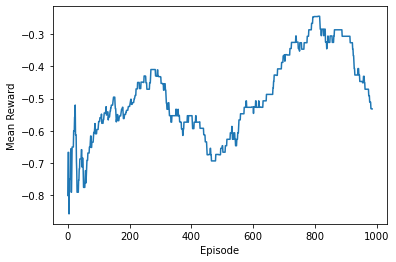

In [17]:
df = pd.read_csv("../../logs/SAC-tf/SAC_3_vs_3_auto_GK_44107_00000_0_2022-07-22_15-30-50/progress.csv")
plt.plot(df.episode_reward_mean)
plt.xlabel("Episode")
plt.ylabel("Mean Reward");

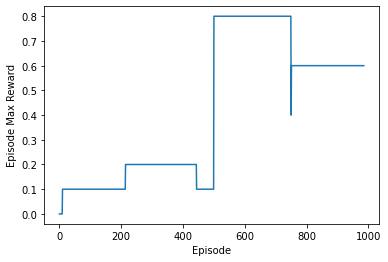

In [16]:
plt.plot(df.episode_reward_max)
plt.xlabel("Episode")
plt.ylabel("Episode Max Reward");